# Drug-Drug Interaction Extraction

This notebook goes through the process I used to attempt to extract drug-drug interactions from papers on the subject. The algorithm I made up was created based off of information obtained from the training set of data from the DDI Corpus 2013. I evaluated the performance of this algorithm on the training set of data and the test set of data. I also gave some examples of the Named Entity Recognition process I used, and how the ddi extraction works on a few example papers, and how it could be used to analyze other papers

## Imports

In [1]:
import sys
!{sys.executable} -m pip install pdfplumber

In [2]:
import nltk,re,os,string
import pdfplumber
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import PlaintextCorpusReader
from nltk import FreqDist
from wordcloud.wordcloud import WordCloud
import pandas as pd
import numpy as np
import spacy as s
import itertools
import os
import nltk
from nltk import sent_tokenize, word_tokenize, ngrams
from nltk.corpus import PlaintextCorpusReader
from string import punctuation
from collections import Counter, defaultdict
import re
from spacy import displacy
import xml.etree.cElementTree as et
from bs4 import BeautifulSoup
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import matplotlib.pyplot as plt
%matplotlib inline

stop_words = set(stopwords.words('english'))
stop_words.add('said')
punctuation = set(word_tokenize(string.punctuation))
punctuation.add(',')
punctuation.add('.')
punctuation.add("''")
toremoveDrugs = punctuation
toremoveSen = punctuation|stop_words
encod = 'latin-1'

## Prediction and Detection Algorithms

In [3]:
# Function takes in a sentence and attempts to extract DDI, returns a list containing all of the results
# (True/False, Type/None)

def detect_ddi(s):
    ddi = []
    #obtains all the tokens and extracts the drugs from each of the sentences
    tokens = word_tokenize(s)
    #print("Raw tokens: ", tokens, "\n")
    tokens = [word for word in tokens if word not in toremoveSen]
    #print("Cleaned tokens: ", tokens, "\n")
    tokens = list(map(str.lower, tokens))
    print("Simplified tokens: ", tokens, "\n")
    extracted_drugs = [word for word in tokens if word in drugsList]
    print("Drugs Found", extracted_drugs)
    print("Number of Drugs Found: ",len(extracted_drugs))
    
    #If there is one drug or no drugs, returns (false,NA)
    if(len(extracted_drugs)<2):
        if(len(extracted_drugs) == 1):
            print("Only one drug present, no DDI")
            return([(False,"NA")])
        else:
            print("No drugs present, no DDI")
            return([(False,"NA")])
    
    
    #If there are two or more drugs, attempts to classify the DDI
    elif(len(extracted_drugs)>1):
        for i in range(0,len(tokens)):    
            if((tokens[i] == 'caution') or (tokens[i] == 'therefore') or (tokens[i] == 'recommended') or (tokens[i] == 'used') or (tokens[i] == 'dose')):
                print("DDI detected, type: Advise")
                ddi.append((True,"advise"))
            
            if((tokens[i] == 'interacts') or (tokens[i] == 'interaction') or (tokens[i] == 'inhibitors') or (tokens[i] == 'interact')):
                print("DDI detected, type: Interaction")
                ddi.append((True,"interaction"))
            
            if((tokens[i] == 'increase') or (tokens[i] == 'decrease') or (tokens[i] == 'concentrations') or (tokens[i] == 'levels') or (tokens[i] == 'increased') or (tokens[i] == 'decreased') or (tokens[i] == 'plasma')):
                print("DDI detected, type: Mechanism")
                ddi.append((True,"mechanism"))
            
            if((tokens[i] == 'effect') or (tokens[i] == 'effects') or (tokens[i] == 'reported') or (tokens[i] == 'use') or (tokens[i] == 'receiving')):
                print("DDI detected, type: Effect")
                ddi.append((True,"effect"))
    
    # If there are no ddi's found returns that there are no relation between the drugs in that sentence
    if(is_empty(ddi)):
        print("No DDI deteceted")
        return([(False,"NA")])
    
    # If there are ddi's, the list is returned 
    else:
        print(ddi)
        return(ddi)
    
    
# Function returns a tuple with its guess regarding what the interaction is between the two drugs(only works with two drug sentences)
def predict_ddi(s):
    ddi = []
    #obtains all the tokens and extracts the drugs from each of the sentences
    tokens = word_tokenize(s)
    #print("Raw tokens: ", tokens, "\n")
    tokens = [word for word in tokens if word not in toremoveSen]
    #print("Cleaned tokens: ", tokens, "\n")
    tokens = list(map(str.lower, tokens))
    print("Simplified tokens: ", tokens, "\n")
    extracted_drugs = [word for word in tokens if word in drugsList]
    print("Drugs Found", extracted_drugs)
    print("Number of Drugs Found: ",len(extracted_drugs))
    
    #attempts to classify the ddi
    if(len(extracted_drugs) == 2):
        for i in range(0,len(tokens)):    
            if((tokens[i] == 'caution') or (tokens[i] == 'therefore') or (tokens[i] == 'recommended') or (tokens[i] == 'used') or (tokens[i] == 'dose')):
                print("DDI detected, type: Advise")
                ddi.append((True,"advise"))
                break
            
            if((tokens[i] == 'interacts') or (tokens[i] == 'interaction') or (tokens[i] == 'inhibitors') or (tokens[i] == 'interact')):
                print("DDI detected, type: Interaction")
                ddi.append((True,"interaction"))
                break
            
            if((tokens[i] == 'increase') or (tokens[i] == 'decrease') or (tokens[i] == 'concentrations') or (tokens[i] == 'levels') or (tokens[i] == 'increased') or (tokens[i] == 'decreased') or (tokens[i] == 'plasma')):
                print("DDI detected, type: Mechanism")
                ddi.append((True,"mechanism"))
                break
            
            if((tokens[i] == 'effect') or (tokens[i] == 'effects') or (tokens[i] == 'reported') or (tokens[i] == 'use') or (tokens[i] == 'receiving')):
                print("DDI detected, type: Effect")
                ddi.append((True,"effect"))
                break
    else:
        print("Error: More or less than two drugs present in the sentence")
        return("Error: More or less than two drugs present in the sentence")
    
    if(is_empty(ddi)):
        print((extracted_drugs[0],"False",extracted_drugs[1]))
        return((extracted_drugs[0],"False",extracted_drugs[1]))
    else:
        print((extracted_drugs[0],ddi,extracted_drugs[1]))
        return((extracted_drugs[0],ddi,extracted_drugs[1])) 

## Functions

In [4]:
# The following fill function calcualte certain quantities based on the number of drugs 

# function to fill an array that calculates the length of a block of data in the xml files fromd DDI corpus
# total = number of drugs + number of unique combinations of those drugs
def totalFill(a):
    total = []
    n = 1
    b = 1
    for i in range(0,a):
        n += 1
        total.append(b)
        b += n
    return(total)

# function to fill an array that calcualtes the number f unique combinations for any number of drugs
def numPairsFill(a):
    total = []
    n = 0
    b = 0
    for i in range(0,a):
        n += 1
        total.append(b)
        b += n
    return(total)

# function to fill an array with any given number of drugs
def numDrugsFill(a):
    total = []
    n=0
    for i in range(0,a):
        n += 1
        total.append(n)
    return(total)

# Function determines if a given structure is empty
def is_empty(any_structure):
    if any_structure:
        return False
    else:
        return True

# Function creates all the possible combination of drugs, given the full pairs of all the drugs
def getDP(p):
    dP = []
    for i in range(0,len(p)):
        temp = list(itertools.combinations(full_pairs[i][1],2))
        q = []
        for j in range(0,len(p[i][2])):
            q.append((temp[j],full_pairs[i][2][j]))
        dP.append(q)
    return dP

# Function takes in a string and tokenizes it and outputs a Frequency Distribution of the most common words
def getFDist(s):
    tokens = word_tokenize(s)
    tokens = list(map(str.lower, tokens))
    encod = [word for word in tokens if word not in toremove]
    fdist = FreqDist(encod)
    fdist.plot(25, cumulative = False)
    

# This function evaluates the performance of the prediction algorithm, and takes in sorted sentences
# and gives the accuracy of predicting the ddi type, since this evaluation function is based off 
# of the prediciton algorithm, it only functions for sentences that have two drugs present in them

def evalPred(sentences, ddiType, none = False):
    counter = 0
    if(none == False):
        for i in range(0,len(sentences)):
            ddi = predict_ddi(sentences[i])
            if(ddi == "Error: More or less than two drugs present in the sentence"):
                print("Incorrect")
                print("\n")
                continue
            else:
                if(ddi[1][0] == (True, ddiType)):
                    counter += 1
                    print("Correct")
                    print("\n")
                else:
                    print("Incorrect")
                    print("\n")
    else:
        for i in range(0,len(sentences)):
            ddi = predict_ddi(sentences[i])
            if(ddi == "Error: More or less than two drugs present in the sentence"):
                print("Incorrect")
                print("\n")
                continue
            else:
                if(ddi[1] == 'False'):
                    counter += 1
                    print("Correct")
                    print("\n")
                else:
                    print("incrorrect")
                    print("\n")
    
    acc = (counter*1.0)/len(sentences)
    print("Number of sentences containing interactions: ",len(sentences))
    print("Number of sentences containing interaction correctly classified: ",counter)
    print("Accuracy of classification: ",acc)
    return(counter,acc)
    
# This function evaluates the performance of the detection algorithm, and takes in sorted sentences
# and gives the accuracy of predicting the ddi type, this evaluation function works uses the detection algorithm,
# but only works for sentences with a pair of drugs
    
def evalDetPair(sentences, ddiType, none = False):
    counter = 0
    falsePosCounter = 0
    if(none == False):
        for i in range(0,len(sentences)):
            ddi = detect_ddi(sentences[i])
            for j in range(0,len(ddi)):
                if(ddi[j] == (True, ddiType)):
                    counter += 1
                    print("Correct")
                else:
                    falsePosCounter += 1
                    print("Incorrect")
    else:
        for i in range(0,len(sentences)):
            ddi = detect_ddi(sentences[i])
            if(ddi == [(False, 'NA')]):
                counter+=1
                print("Correct")
            else:
                print("Incorrect")
    
    acc = (counter*1.0)/len(sentences)
    print("Number of sentences containing interactions: ",len(sentences))
    print("Number of sentences containing interaction correctly detected: ",counter)
    print("Accuracy of detection: ",acc)
    print("Number of false positive ddi's found: ",falsePosCounter)
    return(counter,acc)
    
# This function evaluates the performance of the detection algorithm, and takes in sorted sentences
# and gives the accuracy of predicting the ddi type, this evaluation function works uses the detection algorithm,
# and works for sentences with any number of drugs present in them

def evalDet(sentences, ddiType, none = False):
    counter = 0
    if(none == False):
        for i in range(0,len(sentences)):
            ddi = detect_ddi(sentences[i])
            for j in range(0,len(ddi)):
                if(ddi[j] == (True, ddiType)):
                    counter += 1
                    print("Correct")
                    break
    else:
        for i in range(0,len(sentences)):
            ddi = detect_ddi(sentences[i])
            if(len(ddi) == 1):
                if(ddi[0] == (False, 'NA')):
                    counter+=1
                    print("Correct")
                    continue
    
    acc = (counter*1.0)/len(sentences)
    print("Number of sentences containing interactions: ",len(sentences))
    print("Number of sentences containing interaction correctly classified: ",counter)
    print("Accuracy of detection: ",acc)
    return(counter,acc)

# Takes in a pdf file and extracts the text from it, returns the text from the file
def pdfExtractText(filename):
    pdf = pdfplumber.open(filename)
    text = ''
    for i in range(0, len(pdf.pages)):
        page = pdf.pages[i]
        text += page.extract_text()
    return(text)

# Takes in text, extracts the sentences, and cleans up the sentences, returns the sentences
def getSentences(text):
    # Obtains all the sentences from the text file
    sentences = sent_tokenize(str(text))

    # Breaks up each sentence into a list of words
    sen_tokens = []
    for i in range(0,len(sentences)):
        sen_tokens.append(word_tokenize(sentences[i]))
        
    #Cleans up each of the sentences, lowers the case and removes some of the punctuation
    # It also replaces some of the weird strings present in this document
    sen_tokens2 = []
    for i in range(0,len(sen_tokens)):
        tokens = []
        for j in range(0,len(sen_tokens[i])):
            if(sen_tokens[i][j] not in toremoveDrugs):
                tokens.append(sen_tokens[i][j])
        for j in range(0,len(tokens)):
            tokens[j] = tokens[j].replace('\\r\\n',"")
            tokens[j] = tokens[j].replace('\\xe2\\x80\\xa2',"")
            tokens[j] = tokens[j].replace('\\xc3\\xa9',"")
            tokens[j] = tokens[j].replace('...', "")
        tokens = list(map(str.lower, tokens))
        sen_tokens2.append(tokens)
    return(sen_tokens2)

# Takes in sentences, looks for drugs in the sentences, and returns any sentences with more than one drug
# present, returns that list of drugs
def getPossibleDDI(sentences):
    # Goes through sentence by sentence to determine if there is the possibility for a DDI. Excludes sentences where only one drug
    # or no drugs are present

    possible_ddi = []
    for i in range(0,len(sentences)):
        extracted_drugs = [word for word in sentences[i] if word in drugsList]
        extracted_drugs = list(set(extracted_drugs))
        print("In sentence ",i,", there were: ",len(extracted_drugs)," drugs Found: ", extracted_drugs)
        if(len(extracted_drugs)>1):
            possible_ddi.append((sentences[i],extracted_drugs))
    print("\n\n Number of sentences containing a possible DDI: ",len(possible_ddi))
    
    # convert the tokens in the sentences back to string
    possible_ddi_sentences = []
    for i in range(0,len(possible_ddi)):
        s_str = ""
        for j in range(0,len(possible_ddi[i][0])):
            s_str += possible_ddi[i][0][j] + " "
        possible_ddi_sentences.append((s_str,possible_ddi[i][1]))
    
    return(possible_ddi_sentences)
    

# Gets the predictions using the sentences that have two drugs present, returns the predicitons
def getPredictions(possibleDDI):
    predictions = []
    for i in range(0,len(possibleDDI)):
        if(len(possibleDDI[i][1]) == 2):
            predictions.append((possibleDDI[i][0],predict_ddi(possibleDDI[i][0])))
    return(predictions)

# Gets the detections using the sentences that have any drugs present, returns the detections
def getDetections(possibleDDI):
    detections = []
    for i in range(0,len(possibleDDI)):
        detections.append((possibleDDI[i][0],detect_ddi(possibleDDI[i][0])))
    return(detections)
    
# All in one function for processing a pdf    
def processPdf(filename):
    text = pdfExtractText(filename)
    sentences = getSentences(text)
    possibleDDI = getPossibleDDI(sentences)
    predictions = getPredictions(possibleDDI)
    detections = getDetections(possibleDDI)
    
    print("\n")
    print("Predictions: \n")
    j = 0
    for i in range(0,len(predictions)):
        if(predictions[i][1] == 'Error: More or less than two drugs present in the sentence'):
            continue
        print("Sentence ", j,":", predictions[i][0], "\n")
        print("DDI ",j," : ",predictions[i][1], "\n")
        print("-----------------------------------------------------------")
        j+=1
    print("\n")
    print("Detections: \n")
    for i in range(0,len(detections)):
        print("Sentence ", i,":", detections[i][0], "\n")
        print("DDI Detected: ", detections[i][1], "\n")
        print("-----------------------------------------------------------")
    
    return predictions, detections

# Displays the predictions from the process function
def displayPredictions(predictions):
    print("Predictions: \n")
    j = 0
    for i in range(0,len(predictions)):
        if(predictions[i][1] == 'Error: More or less than two drugs present in the sentence'):
            continue
        print("Sentence ", j,":", predictions[i][0], "\n")
        print("DDI ",j," : ",predictions[i][1], "\n")
        print("-----------------------------------------------------------")
        j+=1

# Displays the detections from the process function
def displayDetections(detections):
    print("Detections: \n")
    for i in range(0,len(detections)):
        print("Sentence ", i,":", detections[i][0], "\n")
        print("DDI Detected: ", detections[i][1], "\n")
        print("-----------------------------------------------------------")   

In [5]:
# Array for the number of pairs,drugs,total given the length of root, the 10,000 is arbitrarily large to fit all scenarios
numD = numDrugsFill(10000)
numP = numPairsFill(10000)
total= totalFill(10000)

In [6]:
# this code below gives an idea of what the above arrays are being filled with

# prints out the first 20 numbers of each list
# for i in range(0,20):
#     print(numD[i])
#     print(numP[i])
#     print(total[i])

## Pulling Information from DDI Corpus Training set

In [7]:
# This chunk extracts all the relevant data from the DDI Corpus training files from both medline, and Drugbank, train set

path_of_the_directory = 'DDICorpus-2013/DDICorpus/all_train'
ext = ('.xml')
#xml_files_sentence_ddi_pairs = []
train_sent_ddi_pairs = []
#xml_files_full_pairs = []
train_full_pairs = []
all_drugs = []
all_sentences_train = []
for files in os.listdir(path_of_the_directory):
    if files.endswith(ext):
        print(files)
        
        # parses the xml file into a tree and obtains its root
        tree = et.parse('DDICorpus-2013/DDICorpus/all_train/' + files)
        root = tree.getroot()
        print("Number of sentences for this file: ",len(root))
       
        sentences = []
        drugs = []
        drugPairs = []
        ddi = []
        full_pairs = []

        # obtains all of the sentences from the xml files from medline
        for i in range(0,len(root)):
            sentences.append(root[i].attrib['text'])
            all_sentences_train.append(root[i].attrib['text'])


        # obtains all of the drugs and their types from each of the sentences
        for i in range(0,len(root)):
            length = len(root[i])
            if(length == 0):
                drugPairs.append([])
                ddi.append([])
            for j in range(0,length):
                if(total[j] == length):
                    drugs = []
                    p_inter = []
                    for k in range(0,(total[j]-numP[j])):
                        t = []
                        d = []
                        d.append(root[i][k].attrib['text'])
                        all_drugs.append(d)
                        t.append(root[i][k].attrib['type'])
                        drugs.append((d,t))
                    drugPairs.append(drugs)
                    for l in range(numD[j],total[j]):
                        p = []
                        inter = []
                        p.append(root[i][l].attrib['ddi'])
                        if(root[i][l].attrib['ddi'] == 'true'):
                            inter.append(root[i][l].attrib['type'])
                        elif(root[i][l].attrib['ddi'] == 'false'):
                            inter.append([])
                        p_inter.append((p,inter))
                    ddi.append(p_inter)

        # combines all of the information about the drug pairs
        for i in range(0,len(sentences)):
            t = (sentences[i],drugPairs[i],ddi[i])
            full_pairs.append(t)
        train_full_pairs.append((full_pairs,files))
        
        ddi_pairs = getDP(full_pairs)
        sentence_ddi_pairs = []
        for i in range(0,len(sentences)):
            sentence_ddi_pairs.append((sentences[i],ddi_pairs[i]))
        train_sent_ddi_pairs.append((sentence_ddi_pairs,files))
       
    else:
        continue
# Gets all the drugs found in these files
all_dc = []
for i in range (0,len(all_drugs)):
    all_dc.append(all_drugs[i][0])

10150268.xml
Number of sentences for this file:  5
10226677.xml
Number of sentences for this file:  30
10319155.xml
Number of sentences for this file:  6
1089034.xml
Number of sentences for this file:  9
1089817.xml
Number of sentences for this file:  6
10959916.xml
Number of sentences for this file:  9
10978746.xml
Number of sentences for this file:  7
10978751.xml
Number of sentences for this file:  12
11064383.xml
Number of sentences for this file:  10
11085305.xml
Number of sentences for this file:  7
11085328.xml
Number of sentences for this file:  9
11085333.xml
Number of sentences for this file:  12
11085336.xml
Number of sentences for this file:  17
1109248.xml
Number of sentences for this file:  10
1109299.xml
Number of sentences for this file:  10
1109556.xml
Number of sentences for this file:  11
11114408.xml
Number of sentences for this file:  9
11115418.xml
Number of sentences for this file:  10
11120981.xml
Number of sentences for this file:  6
11121387.xml
Number of sent

Number of sentences for this file:  44
Arbutamine_ddi.xml
Number of sentences for this file:  4
Ardeparin_ddi.xml
Number of sentences for this file:  1
Arformoterol_ddi.xml
Number of sentences for this file:  17
Argatroban_ddi.xml
Number of sentences for this file:  8
Aripiprazole_ddi.xml
Number of sentences for this file:  31
Arsenic trioxide_ddi.xml
Number of sentences for this file:  2
Asparaginase_ddi.xml
Number of sentences for this file:  2
Aspirin_ddi.xml
Number of sentences for this file:  10
Astemizole_ddi.xml
Number of sentences for this file:  1
Atenolol_ddi.xml
Number of sentences for this file:  11
Atomoxetine_ddi.xml
Number of sentences for this file:  7
Atorvastatin_ddi.xml
Number of sentences for this file:  26
Atovaquone_ddi.xml
Number of sentences for this file:  8
Atracurium_ddi.xml
Number of sentences for this file:  11
Atropine_ddi.xml
Number of sentences for this file:  3
Auranofin_ddi.xml
Number of sentences for this file:  6
Azacitidine_ddi.xml
Number of sentenc

Number of sentences for this file:  1
Desflurane_ddi.xml
Number of sentences for this file:  3
Desipramine_ddi.xml
Number of sentences for this file:  29
Desloratadine_ddi.xml
Number of sentences for this file:  23
Desmopressin_ddi.xml
Number of sentences for this file:  1
Desogestrel_ddi.xml
Number of sentences for this file:  5
Desoximetasone_ddi.xml
Number of sentences for this file:  3
Dexamethasone_ddi.xml
Number of sentences for this file:  33
Dexbrompheniramine_ddi.xml
Number of sentences for this file:  1
Dexfenfluramine_ddi.xml
Number of sentences for this file:  10
Dexmedetomidine_ddi.xml
Number of sentences for this file:  6
Dexrazoxane_ddi.xml
Number of sentences for this file:  5
Dezocine_ddi.xml
Number of sentences for this file:  1
Diatrizoate_ddi.xml
Number of sentences for this file:  2
Dichlorphenamide_ddi.xml
Number of sentences for this file:  1
Diclofenac_ddi.xml
Number of sentences for this file:  25
Dicloxacillin_ddi.xml
Number of sentences for this file:  1
Dicy

Grepafloxacin_ddi.xml
Number of sentences for this file:  22
Griseofulvin_ddi.xml
Number of sentences for this file:  3
Guaifenesin_ddi.xml
Number of sentences for this file:  3
Guanethidine_ddi.xml
Number of sentences for this file:  1
Guanfacine_ddi.xml
Number of sentences for this file:  15
Haloperidol_ddi.xml
Number of sentences for this file:  7
Halothane_ddi.xml
Number of sentences for this file:  5
Heparin_ddi.xml
Number of sentences for this file:  10
Heroin_ddi.xml
Number of sentences for this file:  5
Hexachlorophene_ddi.xml
Number of sentences for this file:  1
Hexobarbital_ddi.xml
Number of sentences for this file:  1
Hydralazine_ddi.xml
Number of sentences for this file:  9
Hydrochlorothiazide_ddi.xml
Number of sentences for this file:  14
Hydrocodone_ddi.xml
Number of sentences for this file:  4
Hydrocortisone_ddi.xml
Number of sentences for this file:  1
Hydroflumethiazide_ddi.xml
Number of sentences for this file:  34
Hydromorphone_ddi.xml
Number of sentences for this f

Zaleplon_ddi.xml
Number of sentences for this file:  39


## Pulling Information from DDI Corpus Test set

In [8]:
# This chunk extracts all the relevant data from the DDI Corpus training files from both medline, and Drugbank, test set

path_of_the_directory = 'DDICorpus-2013/DDICorpus/all_test'
ext = ('.xml')
#xml_files_sentence_ddi_pairs_test = []
test_sent_ddi_pairs = []
#xml_files_full_pairs_test = []
test_full_pairs = []
all_sentences_test = []
for files in os.listdir(path_of_the_directory):
    if files.endswith(ext):
        print(files)
        
        # parses the xml file into a tree and obtains its root
        tree = et.parse('DDICorpus-2013/DDICorpus/all_test/' + files)
        root = tree.getroot()
        print("Number of sentences for this file: ",len(root))
       
        sentences = []
        drugs = []
        drugPairs = []
        ddi = []
        full_pairs = []

        # obtains all of the sentences from the xml files from medline
        for i in range(0,len(root)):
            sentences.append(root[i].attrib['text'])
            all_sentences_test.append(root[i].attrib['text'])


        # obtains all of the drugs and their types from each of the sentences
        for i in range(0,len(root)):
            length = len(root[i])
            if(length == 0):
                drugPairs.append([])
                ddi.append([])
            for j in range(0,length):
                if(total[j] == length):
                    drugs = []
                    p_inter = []
                    for k in range(0,(total[j]-numP[j])):
                        t = []
                        d = []
                        d.append(root[i][k].attrib['text'])
                        all_drugs.append(d)
                        t.append(root[i][k].attrib['type'])
                        drugs.append((d,t))
                    drugPairs.append(drugs)
                    for l in range(numD[j],total[j]):
                        p = []
                        inter = []
                        p.append(root[i][l].attrib['ddi'])
                        if(root[i][l].attrib['ddi'] == 'true'):
                            inter.append(root[i][l].attrib['type'])
                        elif(root[i][l].attrib['ddi'] == 'false'):
                            inter.append([])
                        p_inter.append((p,inter))
                    ddi.append(p_inter)

        # combines all of the information about the drug pairs
        for i in range(0,len(sentences)):
            t = (sentences[i],drugPairs[i],ddi[i])
            full_pairs.append(t)
        test_full_pairs.append((full_pairs,files))
        
        ddi_pairs = getDP(full_pairs)
        sentence_ddi_pairs = []
        for i in range(0,len(sentences)):
            sentence_ddi_pairs.append((sentences[i],ddi_pairs[i]))
        test_sent_ddi_pairs.append((sentence_ddi_pairs,files))
       
    else:
        continue

21704241.xml
Number of sentences for this file:  28
21705423.xml
Number of sentences for this file:  11
21706316.xml
Number of sentences for this file:  14
21706978.xml
Number of sentences for this file:  5
21711060.xml
Number of sentences for this file:  8
21715267.xml
Number of sentences for this file:  11
21715286.xml
Number of sentences for this file:  4
21716267.xml
Number of sentences for this file:  7
21720561.xml
Number of sentences for this file:  14
21722807.xml
Number of sentences for this file:  10
21728157.xml
Number of sentences for this file:  8
21728158.xml
Number of sentences for this file:  5
21728182.xml
Number of sentences for this file:  9
21729965.xml
Number of sentences for this file:  4
21730162.xml
Number of sentences for this file:  10
21731080.xml
Number of sentences for this file:  10
21731754.xml
Number of sentences for this file:  12
21734381.xml
Number of sentences for this file:  11
21740149.xml
Number of sentences for this file:  15
21741958.xml
Number 

Number of sentences for this file:  10
Procaine.xml
Number of sentences for this file:  9
Procarbazine.xml
Number of sentences for this file:  5
Prochlorperazine.xml
Number of sentences for this file:  3
Propofol.xml
Number of sentences for this file:  8
Propoxyphene.xml
Number of sentences for this file:  5
Propylthiouracil.xml
Number of sentences for this file:  2
Pseudoephedrine.xml
Number of sentences for this file:  2
Pyrazinamide.xml
Number of sentences for this file:  2
Pyrimethamine.xml
Number of sentences for this file:  4
Quinacrine.xml
Number of sentences for this file:  1
Raloxifene.xml
Number of sentences for this file:  8
Ranibizumab.xml
Number of sentences for this file:  4
Ranitidine.xml
Number of sentences for this file:  5
Reboxetine.xml
Number of sentences for this file:  1
Remifentanil.xml
Number of sentences for this file:  3
Remoxipride.xml
Number of sentences for this file:  1
Retapamulin.xml
Number of sentences for this file:  4
Reteplase.xml
Number of sentences

## Building the list of drugs

In [9]:
# Extracts drug names from the drugbank database
raw_data = pd.read_csv("drugbankVocab.csv", header = 0)
dBank_drugs = list(raw_data['Common name'])

# Extracts drug names from personal list of drugs amalgamated from various sources, and initally builds the drug list
path_to_file = "drugsList.txt"
with open(path_to_file) as f:
    contents = f.readlines()

# Adds all the drugs found in the training set to the list
for i in range(0,len(all_dc)):
    contents.append(all_dc[i])

# Adds all the drugs from drugbank to the list
for i in range(0,len(dBank_drugs)):
    contents.append(dBank_drugs[i])
    
# Removes any repitions of drugs present in the list   
# contents = [word for word in contents if word not in toremoveDrugs]
contents = set(contents)
contents = list(contents)

# Strips any leftover escape characters in the list
for i in range(0,len(contents)):
    contents[i] = contents[i].strip('\n')

# Lowers the case of all the drugs and changes it the list to a set
contentsLow = list(map(str.lower, contents))
drugsList = contentsLow

# Removes some odd words that made it onto the lsit
drugsList.remove('')
drugsList.remove('drug')
drugsList.remove('drugs')
drugsList.remove('had')
drugsList.remove('same')
drugsList.remove('fig')

# Displays the number of known drugs in the dataset
drugsListExp = set(drugsList)
print("Number of drugs known: ", len(drugsListExp))

Number of drugs known:  32360


# Exploring the data

In [10]:
# Meant to remove words that will not be useful to looking through the data
toremove = punctuation|stop_words|drugsListExp|{'may'}|{'patient'}|{'patients'}

## Getting the sentences related to each DDI with any number of drugs present

In [11]:
s_int = []
s_adv = []
s_mech = []
s_eff = []
s_none = []
s_all = []

# This chunk of code sorts through all of the sentences from the training data set, and sorts them to each bin.
# Any sentence that contains any of the ddi, gets put in the specific bin. If a sentence contains more than one
# type of ddi it can be placed in multiple bins

for k in range(0,len(train_sent_ddi_pairs)):
    for i in range(0,len(train_sent_ddi_pairs[k][0])):
        s_all.append(train_sent_ddi_pairs[k][0][i][0])
        eff = 0
        inte = 0
        adv = 0
        mech = 0
        # this for loop goes through and checks if each sentence contains a ddi, it is prevented from adding the same sentence
        # twice if it contains multiple ddi of the same type
        for j in range(0,len(train_sent_ddi_pairs[k][0][i][1])):
            if(train_sent_ddi_pairs[k][0][i][1][j][1][0][0] == 'true'):
                if(train_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'effect' and eff == 0):
                    s_eff.append(train_sent_ddi_pairs[k][0][i][0])
                    eff+=1
                if(train_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'int' and inte == 0):
                    s_int.append(train_sent_ddi_pairs[k][0][i][0])
                    inte+=1
                if(train_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'advise' and adv == 0):
                    s_adv.append(train_sent_ddi_pairs[k][0][i][0])
                    adv+=1
                if(train_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'mechanism' and mech == 0):
                    s_mech.append(train_sent_ddi_pairs[k][0][i][0])
                    mech+=1
        
        # these statements absorb all the sentences that contain no ddi
        if(len(train_sent_ddi_pairs[k][0][i][1]) > 1 and eff == 0 and inte == 0 and adv == 0 and mech == 0):
            s_none.append(train_sent_ddi_pairs[k][0][i][0])
        if(len(train_sent_ddi_pairs[k][0][i][1]) == 1):
            if(train_sent_ddi_pairs[k][0][i][1][0][1][0][0] == 'false'):
                s_none.append(train_sent_ddi_pairs[k][0][i][0])
        if(len(train_sent_ddi_pairs[k][0][i][1]) == 0):
            s_none.append(train_sent_ddi_pairs[k][0][i][0])

print("Training Set:")
print("Number of sentences containing interaction ddi: ", len(s_int))
print("Number of sentences containing advise ddi: ", len(s_adv))
print("Number of sentences containing mechanism ddi: ", len(s_mech))
print("Number of sentences containing effect ddi: ", len(s_eff))
print("Number of sentences containing no ddi: ", len(s_none))

# the sum of all the sentences in all of these bins is greater because sentences can be used twice based on the ddi they contain
print("Number of all sentences: ", len(s_all))
print("\n")

s_int_test = []
s_adv_test = []
s_mech_test = []
s_eff_test = []
s_none_test = []
s_all_test = []

# This chunk of code sorts through all of the sentences from the training data set, and sorts them to each bin.
# Any sentence that contains any of the ddi, gets put in the specific bin. If a sentence contains more than one
# type of ddi it can be placed in multiple bins

for k in range(0,len(test_sent_ddi_pairs)):
    for i in range(0,len(test_sent_ddi_pairs[k][0])):
        s_all_test.append(test_sent_ddi_pairs[k][0][i][0])
        eff = 0
        inte = 0
        adv = 0
        mech = 0
        # this for loop goes through and checks if each sentence contains a ddi, it is prevented from adding the same sentence
        # twice if it contains multiple ddi of the same type
        for j in range(0,len(test_sent_ddi_pairs[k][0][i][1])):
            if(test_sent_ddi_pairs[k][0][i][1][j][1][0][0] == 'true'):
                if(test_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'effect' and eff == 0):
                    s_eff_test.append(test_sent_ddi_pairs[k][0][i][0])
                    eff+=1
                if(test_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'int' and inte == 0):
                    s_int_test.append(test_sent_ddi_pairs[k][0][i][0])
                    inte+=1
                if(test_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'advise' and adv == 0):
                    s_adv_test.append(test_sent_ddi_pairs[k][0][i][0])
                    adv+=1
                if(test_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'mechanism' and mech == 0):
                    s_mech_test.append(test_sent_ddi_pairs[k][0][i][0])
                    mech+=1
        
        # these statements absorb all the sentences that contain no ddi
        if(len(test_sent_ddi_pairs[k][0][i][1]) > 1 and eff == 0 and inte == 0 and adv == 0 and mech == 0):
            s_none_test.append(test_sent_ddi_pairs[k][0][i][0])
        if(len(test_sent_ddi_pairs[k][0][i][1]) == 1):
            if(test_sent_ddi_pairs[k][0][i][1][0][1][0][0] == 'false'):
                s_none_test.append(test_sent_ddi_pairs[k][0][i][0])
        if(len(test_sent_ddi_pairs[k][0][i][1]) == 0):
            s_none_test.append(test_sent_ddi_pairs[k][0][i][0])

print("Test Set:")
print("Number of sentences containing interaction ddi: ", len(s_int_test))
print("Number of sentences containing advise ddi: ", len(s_adv_test))
print("Number of sentences containing mechanism ddi: ", len(s_mech_test))
print("Number of sentences containing effect ddi: ", len(s_eff_test))
print("Number of sentences containing no ddi: ", len(s_none_test))

# the sum of all the sentences in all of these bins is greater because sentences can be used twice based on the ddi they contain
print("Number of all sentences: ", len(s_all_test))
print("\n")

Training Set:
Number of sentences containing interaction ddi:  56
Number of sentences containing advise ddi:  485
Number of sentences containing mechanism ddi:  736
Number of sentences containing effect ddi:  838
Number of sentences containing no ddi:  4861
Number of all sentences:  6944


Test Set:
Number of sentences containing interaction ddi:  19
Number of sentences containing advise ddi:  120
Number of sentences containing mechanism ddi:  159
Number of sentences containing effect ddi:  203
Number of sentences containing no ddi:  1477
Number of all sentences:  1964




## Getting the sentences related to each DDI with just a pair of drugs present

In [12]:
s_int_pair = []
s_adv_pair = []
s_mech_pair = []
s_eff_pair = []
s_none_pair = []
s_all_pair = []

# This chunk of code sorts through all of the sentences that only contain two drugs, and thus can only have one ddi, or 
# no ddi. So this sorts all of the sentences into wach bin, but each sentence can only be in one bin

for k in range(0,len(train_sent_ddi_pairs)):
    for i in range(0,len(train_sent_ddi_pairs[k][0])):
        for j in range(0,len(train_sent_ddi_pairs[k][0][i][1])):
            if(len(train_sent_ddi_pairs[k][0][i][1]) == 1):
                s_all_pair.append(train_sent_ddi_pairs[k][0][i][0])
                if(train_sent_ddi_pairs[k][0][i][1][j][1][0][0] == 'true'):
                    if(train_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'effect'):
                        s_eff_pair.append(train_sent_ddi_pairs[k][0][i][0])
                    if(train_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'int'):
                        s_int_pair.append(train_sent_ddi_pairs[k][0][i][0])
                    if(train_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'advise'):
                        s_adv_pair.append(train_sent_ddi_pairs[k][0][i][0])
                    if(train_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'mechanism'):
                        s_mech_pair.append(train_sent_ddi_pairs[k][0][i][0])
                if(train_sent_ddi_pairs[k][0][i][1][j][1][0][0] == 'false'):
                    s_none_pair.append(train_sent_ddi_pairs[k][0][i][0])
                    
print("Train Set:")
print("Number of two drug sentences containing interaction ddi: ", len(s_int_pair))
print("Number of two drug sentences containing advise ddi: ", len(s_adv_pair))
print("Number of two drug sentences containing mechanism ddi: ", len(s_mech_pair))
print("Number of two drug sentences containing effect ddi: ", len(s_eff_pair))
print("Number of two drug sentences containing no ddi: ", len(s_none_pair))
print("Number of two drug sentences: ", len(s_all_pair))
print("\n")

s_int_pair_test = []
s_adv_pair_test = []
s_mech_pair_test = []
s_eff_pair_test = []
s_none_pair_test = []
s_all_pair_test = []

# This chunk of code sorts through all of the sentences that only contain two drugs, and thus can only have one ddi, or 
# no ddi. So this sorts all of the sentences into wach bin, but each sentence can only be in one bin

for k in range(0,len(test_sent_ddi_pairs)):
    for i in range(0,len(test_sent_ddi_pairs[k][0])):
        for j in range(0,len(test_sent_ddi_pairs[k][0][i][1])):
            if(len(test_sent_ddi_pairs[k][0][i][1]) == 1):
                s_all_pair_test.append(test_sent_ddi_pairs[k][0][i][0])
                if(test_sent_ddi_pairs[k][0][i][1][j][1][0][0] == 'true'):
                    if(test_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'effect'):
                        s_eff_pair_test.append(test_sent_ddi_pairs[k][0][i][0])
                    if(test_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'int'):
                        s_int_pair_test.append(test_sent_ddi_pairs[k][0][i][0])
                    if(test_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'advise'):
                        s_adv_pair_test.append(test_sent_ddi_pairs[k][0][i][0])
                    if(test_sent_ddi_pairs[k][0][i][1][j][1][1][0] == 'mechanism'):
                        s_mech_pair_test.append(test_sent_ddi_pairs[k][0][i][0])
                if(test_sent_ddi_pairs[k][0][i][1][j][1][0][0] == 'false'):
                    s_none_pair_test.append(test_sent_ddi_pairs[k][0][i][0])

print("Test Set:")
print("Number of two drug sentences containing interaction ddi: ", len(s_int_pair_test))
print("Number of two drug sentences containing advise ddi: ", len(s_adv_pair_test))
print("Number of two drug sentences containing mechanism ddi: ", len(s_mech_pair_test))
print("Number of two drug sentences containing effect ddi: ", len(s_eff_pair_test))
print("Number of two drug sentences containing no ddi: ", len(s_none_pair_test))
print("Number of two drug sentences: ", len(s_all_pair_test))
print("\n")

Train Set:
Number of two drug sentences containing interaction ddi:  18
Number of two drug sentences containing advise ddi:  227
Number of two drug sentences containing mechanism ddi:  174
Number of two drug sentences containing effect ddi:  331
Number of two drug sentences containing no ddi:  840
Number of two drug sentences:  1590


Test Set:
Number of two drug sentences containing interaction ddi:  5
Number of two drug sentences containing advise ddi:  55
Number of two drug sentences containing mechanism ddi:  40
Number of two drug sentences containing effect ddi:  78
Number of two drug sentences containing no ddi:  251
Number of two drug sentences:  429




## Merging all the sentences into one string for each category

In [13]:
# converts each list into a string with each words seperated by spaces so they can be tokenized later
s_int_str = ""
for i in range(0,len(s_int)):
    s_int_str += s_int[i] + " "

s_adv_str = ""
for i in range(0,len(s_adv)):
    s_adv_str += s_adv[i] + " "
    
s_mech_str = ""
for i in range(0,len(s_mech)):
    s_mech_str += s_mech[i] + " "

s_eff_str = ""
for i in range(0,len(s_eff)):
    s_eff_str += s_eff[i] + " "

s_none_str = ""
for i in range(0,len(s_none)):
    s_none_str += s_none[i] + " "
    
# converts each list into a string with each words seperated by spaces so they can be tokenized later
# same as above but for the sentences with two drugs only

s_int_pair_str = ""
for i in range(0,len(s_int_pair)):
    s_int_pair_str += s_int_pair[i] + " "

s_adv_pair_str = ""
for i in range(0,len(s_adv_pair)):
    s_adv_pair_str += s_adv_pair[i] + " "
    
s_mech_pair_str = ""
for i in range(0,len(s_mech_pair)):
    s_mech_pair_str += s_mech_pair[i] + " "

s_eff_pair_str = ""
for i in range(0,len(s_eff_pair)):
    s_eff_pair_str += s_eff_pair[i] + " "
    
s_none_pair_str = ""
for i in range(0,len(s_none_pair)):
    s_none_pair_str += s_none_pair[i] + " "

# Frequency Distributions

## Frquency Distributions for No DDI

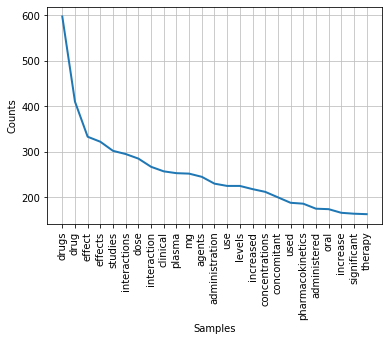

In [14]:
# For any number of drugs in a sentence
getFDist(s_none_str)

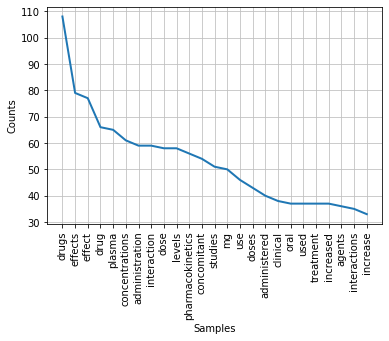

In [15]:
# For pairs of drugs in a sentence
getFDist(s_none_pair_str)

## Frequency Distributions for Interactions

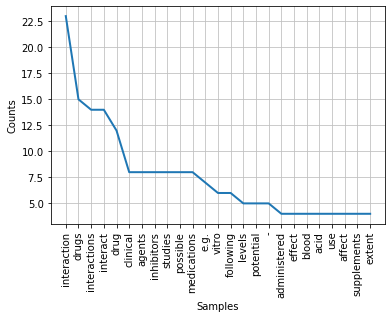

In [16]:
# For any number of drugs in a sentence
getFDist(s_int_str)

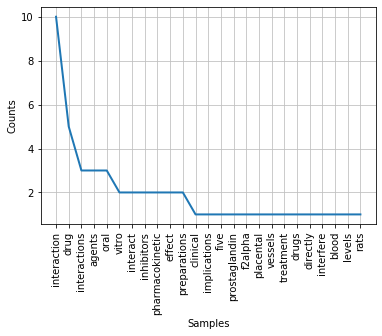

In [17]:
# For pairs of drugs in a sentence
getFDist(s_int_pair_str)

## Frequency Distributions for Advise

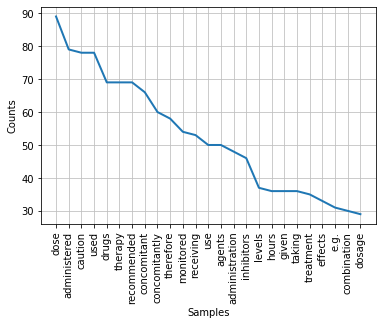

In [18]:
# For any number of drugs in a sentence
getFDist(s_adv_str)

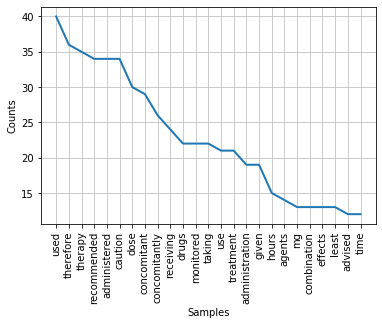

In [19]:
# For pairs of drugs in a sentence
getFDist(s_adv_pair_str)

## Frequency Distributions for Mechanism

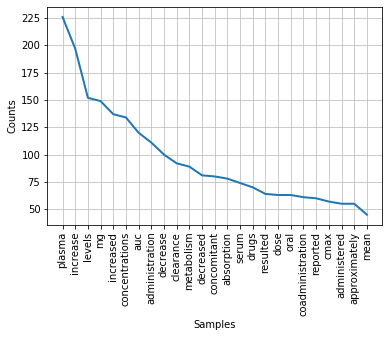

In [20]:
# For any number of drugs in a sentence
getFDist(s_mech_str)

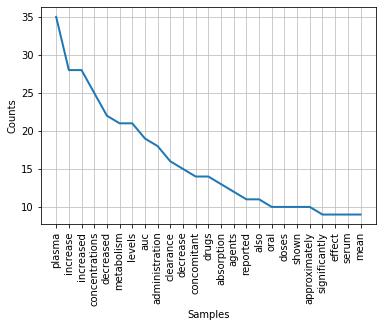

In [21]:
# For pairs of drugs in a sentence
getFDist(s_mech_pair_str)

## Frequency Distributions for Effect

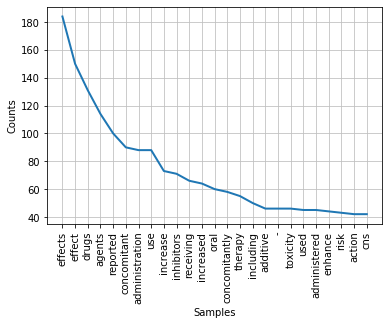

In [22]:
# For any number of drugs in a sentence
getFDist(s_eff_str)

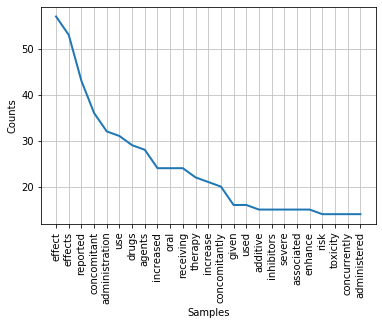

In [23]:
# For pairs of drugs in a sentence
getFDist(s_eff_pair_str)

# Evaluating the Algorithms

# Prediction Algorithm Evaluation

## Evaluation on the training set for sentences containing a single pair

In [24]:
intCounter, intAcc = evalPred(s_int_pair, 'interaction')

Simplified tokens:  ['clinical', 'implications', 'warfarin', 'interactions', 'five', 'sedatives'] 

Drugs Found ['warfarin', 'sedatives']
Number of Drugs Found:  2
('warfarin', 'False', 'sedatives')
Incorrect


Simplified tokens:  ['in', 'vitro', 'interaction', 'prostaglandin', 'f2alpha', 'oxytocin', 'placental', 'vessels'] 

Drugs Found ['oxytocin']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['treatment', 'antidepressant', 'drugs', 'directly', 'interfere', 'blood', 'glucose', 'levels', 'may', 'interact', 'hypoglycemic', 'agents'] 

Drugs Found ['antidepressant', 'glucose', 'hypoglycemic']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['interaction', 'ketamine', 'halothane', 'rats'] 

Drugs Found ['ketamine', 'halothane']
Number of Drugs Found:  2
DDI detected, type: Interaction
('ketamine', [(True, 'interaction')], 'halothane')
Correct


Simp

In [25]:
advCounter, advAcc = evalPred(s_adv_pair, 'advise')

Simplified tokens:  ['indinavir', 'may', 'taken', 'light', 'meal', '1', 'h', 'following', 'administration', '400', 'mg', 'didanosine'] 

Drugs Found ['indinavir', 'didanosine']
Number of Drugs Found:  2
('indinavir', 'False', 'didanosine')
Incorrect


Simplified tokens:  ['however', 'careful', 'attention', 'must', 'directed', 'cross', 'toxicity', 'possible', 'pharmacokinetic', 'interactions', 'antiretroviral', 'antineoplastic', 'drugs'] 

Drugs Found ['antiretroviral']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['concurrent', 'therapy', 'orencia', 'tnf', 'antagonists', 'recommended'] 

Drugs Found ['orencia']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['there', 'insufficient', 'experience', 'assess', 'safety', 'efficacy', 'orencia', 'administered', 'concurrently', 'anakinra', 'therefore', 'use', 'recommended'] 

Drugs Found ['orencia', 'ana

Drugs Found ['clonidine']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['these', 'increases', 'considered', 'selecting', 'oral', 'contraceptive', 'woman', 'taking', 'atorvastatin'] 

Drugs Found ['contraceptive', 'atorvastatin']
Number of Drugs Found:  2
('contraceptive', 'False', 'atorvastatin')
Incorrect


Simplified tokens:  ['alternatives', 'rifampin', 'considered', 'course', 'pcp', 'treatment', 'mepron'] 

Drugs Found ['rifampin', 'pcp', 'mepron']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['tracrium', 'administered', 'patient', 'recovered', 'succinylcholine-induced', 'neuromuscular', 'block'] 

Drugs Found ['tracrium']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['the', 'following', 'precautions', 'kept', 'mind', 'treatment', 'anticholinesterase', 'poisoning', 'alt

Drugs Found ['prothrombin', 'anticoagulant', 'tagamet']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['physicians', 'provided', 'information', 'increase', 'awareness', 'potential', 'serious', 'interactions', 'cinoxacin', 'certain', 'nonsteroidal', 'anti-inflammatory', 'agents', 'administered', 'concomitantly'] 

Drugs Found ['cinoxacin', 'anti-inflammatory']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('cinoxacin', [(True, 'mechanism')], 'anti-inflammatory')
Incorrect


Simplified tokens:  ['therefore', 'patients', 'methotrexate', 'therapy', 'carefully', 'monitored', 'concomitant', 'ciprofloxacin', 'therapy', 'indicated'] 

Drugs Found ['methotrexate', 'ciprofloxacin']
Number of Drugs Found:  2
DDI detected, type: Advise
('methotrexate', [(True, 'advise')], 'ciprofloxacin')
Correct


Simplified tokens:  ['this', 'time', 'window', 'different', 'oral', 'formulations', 'ciprofloxacin', 'usually', 'administ

('diltiazem', [(True, 'effect')], 'cimetidine')
Incorrect


Simplified tokens:  ['when', 'used', 'concomitantly', 'anesthetics', 'calcium', 'channel', 'blockers', 'titrated', 'carefully'] 

Drugs Found ['anesthetics', 'calcium']
Number of Drugs Found:  2
DDI detected, type: Advise
('anesthetics', [(True, 'advise')], 'calcium')
Correct


Simplified tokens:  ['if', 'agents', 'administered', 'concurrently', 'cyclosporine', 'concentrations', 'monitored', 'especially', 'diltiazem', 'therapy', 'initiated', 'adjusted', 'discontinued'] 

Drugs Found ['cyclosporine', 'diltiazem']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('cyclosporine', [(True, 'mechanism')], 'diltiazem')
Incorrect


Simplified tokens:  ['coadministration', 'diltiazem', 'rifampin', 'known', 'cyp3a4', 'inducer', 'avoided', 'possible', 'alternative', 'therapy', 'considered'] 

Drugs Found ['diltiazem', 'rifampin', 'cyp3a4']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorre

Drugs Found ['fenofibrate', 'resin']
Number of Drugs Found:  2
DDI detected, type: Advise
('fenofibrate', [(True, 'advise')], 'resin')
Correct


Simplified tokens:  ['when', 'phenobarbital', 'added', 'withdrawn', 'treatment', 'dosage', 'adjustment', 'nalfon', 'may', 'required'] 

Drugs Found ['phenobarbital', 'nalfon']
Number of Drugs Found:  2
('phenobarbital', 'False', 'nalfon')
Incorrect


Simplified tokens:  ['the', 'use', 'fludara', 'for', 'injection', 'combination', 'pentostatin', 'recommended', 'due', 'risk', 'severe', 'pulmonary', 'toxicity'] 

Drugs Found ['fludara', 'pentostatin']
Number of Drugs Found:  2
DDI detected, type: Effect
('fludara', [(True, 'effect')], 'pentostatin')
Incorrect


Simplified tokens:  ['wait', '5', 'weeks', 'stopping', 'escitalopram', 'starting', 'non-selective', 'mao', 'inhibitor'] 

Drugs Found ['escitalopram']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['wait', '2', 'weeks',

Drugs Found ['indocin', 'methotrexate']
Number of Drugs Found:  2
DDI detected, type: Advise
('indocin', [(True, 'advise')], 'methotrexate')
Correct


Simplified tokens:  ['nsaids', 'used', 'caution', 'patients', 'taking', 'cyclosporine', 'renal', 'function', 'carefully', 'monitored'] 

Drugs Found ['nsaids', 'cyclosporine']
Number of Drugs Found:  2
DDI detected, type: Advise
('nsaids', [(True, 'advise')], 'cyclosporine')
Correct


Simplified tokens:  ['indocin', 'triamterene', 'administered', 'together'] 

Drugs Found ['indocin', 'triamterene']
Number of Drugs Found:  2
('indocin', 'False', 'triamterene')
Incorrect


Simplified tokens:  ['caution', 'therefore', 'advised', 'coadministration', 'atrovent', 'inhalation', 'aerosol', 'anticholinergic-containing', 'drugs'] 

Drugs Found ['atrovent']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['concomitant', 'use', 'isocarboxazid', 'psychotropic', 'agents', 'generally'

Drugs Found ['anticoagulants', 'prothrombin', 'lovastatin', 'prothrombin']
Number of Drugs Found:  4
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['caution', 'used', 'nsaids', 'administered', 'concomitantly', 'methotrexate'] 

Drugs Found ['nsaids', 'methotrexate']
Number of Drugs Found:  2
DDI detected, type: Advise
('nsaids', [(True, 'advise')], 'methotrexate')
Correct


Simplified tokens:  ['this', 'interaction', 'given', 'consideration', 'patients', 'taking', 'nsaids', 'concomitantly', 'ace', 'inhibitors'] 

Drugs Found ['nsaids']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['during', 'concomitant', 'therapy', 'ponstel', 'furosemide', 'patient', 'observed', 'closely', 'signs', 'renal', 'failure', 'well', 'assure', 'diuretic', 'efficacy'] 

Drugs Found ['ponstel', 'furosemide', 'diuretic']
Number of Drugs Found:  3
Error: More or less than two drugs present in the s

In [26]:
effCounter, effAcc = evalPred(s_eff_pair, 'effect')

Simplified tokens:  ['the', 'antimicrobial', 'combinations', 'gl', 'four', 'antibiotics', 'resulted', 'additive', 'effect', 'instances', 'synergism', 'two', 'instances', 'antagonism', 'two', 'instances'] 

Drugs Found ['gl', 'antibiotics']
Number of Drugs Found:  2
DDI detected, type: Effect
('gl', [(True, 'effect')], 'antibiotics')
Correct


Simplified tokens:  ['synergism', 'observed', 'gl', 'combined', 'cefazolin', 'bacillus', 'subtilis', 'klebsiella', 'oxytoca'] 

Drugs Found ['gl', 'cefazolin']
Number of Drugs Found:  2
('gl', 'False', 'cefazolin')
Incorrect


Simplified tokens:  ['echistatin', 'alone', 'effect', 'tyrosine', 'phosphorylation', 't24', 'cells', 'dose-dependently', 'inhibits', 'effects', 'contortrostatin', 'added', 'simultaneously'] 

Drugs Found ['echistatin', 'tyrosine', 'contortrostatin']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['flavoridin', 'alone', 'found', 'effect', 'cas', 'completely

Drugs Found ['tripelennamine', 'pentazocine']
Number of Drugs Found:  2
('tripelennamine', 'False', 'pentazocine')
Incorrect


Simplified tokens:  ['misonidazole', 'protects', 'mouse', 'tumour', 'normal', 'tissues', 'toxicity', 'oral', 'ccnu'] 

Drugs Found ['misonidazole', 'ccnu']
Number of Drugs Found:  2
('misonidazole', 'False', 'ccnu')
Incorrect


Simplified tokens:  ['misonidazole', 'reduced', 'antitumour', 'activity', 'oral', 'ccnu', 'dose', 'modifying', 'factors', 'dmf', '0.58-0.71'] 

Drugs Found ['misonidazole', 'ccnu']
Number of Drugs Found:  2
DDI detected, type: Advise
('misonidazole', [(True, 'advise')], 'ccnu')
Incorrect


Simplified tokens:  ['with', 'combined', 'use', 'clinicians', 'aware', 'phenytoin', 'added', 'potential', 'reexacerbation', 'pulmonary', 'symptomatology', 'due', 'lowered', 'serum', 'theophylline', 'concentrations'] 

Drugs Found ['phenytoin', 'theophylline']
Number of Drugs Found:  2
DDI detected, type: Effect
('phenytoin', [(True, 'effect')], 'theoph

Drugs Found ['adenocard', 'digitalis']
Number of Drugs Found:  2
DDI detected, type: Effect
('adenocard', [(True, 'effect')], 'digitalis')
Correct


Simplified tokens:  ['adenosine', 'effects', 'potentiated', 'dipyridamole'] 

Drugs Found ['adenosine', 'dipyridamole']
Number of Drugs Found:  2
DDI detected, type: Effect
('adenosine', [(True, 'effect')], 'dipyridamole')
Correct


Simplified tokens:  ['thus', 'smaller', 'doses', 'adenosine', 'may', 'effective', 'presence', 'dipyridamole'] 

Drugs Found ['adenosine', 'dipyridamole']
Number of Drugs Found:  2
('adenosine', 'False', 'dipyridamole')
Incorrect


Simplified tokens:  ['as', 'primary', 'effect', 'adenosine', 'decrease', 'conduction', 'a-v', 'node', 'higher', 'degrees', 'heart', 'block', 'may', 'produced', 'presence', 'carbamazepine'] 

Drugs Found ['adenosine', 'carbamazepine']
Number of Drugs Found:  2
DDI detected, type: Effect
('adenosine', [(True, 'effect')], 'carbamazepine')
Correct


Simplified tokens:  ['myocardial', 'inj

Drugs Found ['calcium', 'tenormin']
Number of Drugs Found:  2
DDI detected, type: Effect
('calcium', [(True, 'effect')], 'tenormin')
Correct


Simplified tokens:  ['beta', 'blockers', 'may', 'exacerbate', 'rebound', 'hypertension', 'follow', 'withdrawal', 'clonidine'] 

Drugs Found ['clonidine']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['concomitant', 'use', 'prostaglandin', 'synthase', 'inhibiting', 'drugs', 'eg', 'indomethacin', 'may', 'decrease', 'hypotensive', 'effects', 'beta', 'blockers'] 

Drugs Found ['indomethacin']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['however', 'ldl-c', 'reduction', 'greater', 'atorvastatin', 'colestipol', 'coadministered', 'either', 'drug', 'given', 'alone'] 

Drugs Found ['atorvastatin', 'colestipol']
Number of Drugs Found:  2
('atorvastatin', 'False', 'colestipol')
Incorrect


Simplified tokens:  ['dr

Simplified tokens:  ['some', 'reports', 'shown', 'concomitant', 'administration', 'thiazides', 'vitamin', 'd', 'causes', 'hypercalcemia'] 

Drugs Found ['thiazides', 'vitamin']
Number of Drugs Found:  2
('thiazides', 'False', 'vitamin')
Incorrect


Simplified tokens:  ['deaths', 'severe', 'enterocolitis', 'diarrhea', 'dehydration', 'reported', 'elderly', 'patients', 'receiving', 'weekly', 'leucovorin', 'fluorouracil'] 

Drugs Found ['leucovorin', 'fluorouracil']
Number of Drugs Found:  2
DDI detected, type: Effect
('leucovorin', [(True, 'effect')], 'fluorouracil')
Correct


Simplified tokens:  ['agents', 'causing', 'renin', 'release', 'captopril', "'s", 'effect', 'augmented', 'antihypertensive', 'agents', 'cause', 'renin', 'release'] 

Drugs Found ['captopril', 'antihypertensive']
Number of Drugs Found:  2
DDI detected, type: Effect
('captopril', [(True, 'effect')], 'antihypertensive')
Correct


Simplified tokens:  ['beta-adrenergic', 'blocking', 'drugs', 'add', 'antihypertensive', 'ef

Drugs Found ['lovastatin', 'fibrate']
Number of Drugs Found:  2
('lovastatin', 'False', 'fibrate')
Incorrect


Simplified tokens:  ['narcotic', 'analgesics', 'may', 'potentiate', 'hypotensive', 'effects', 'clonidine'] 

Drugs Found ['narcotic', 'analgesics', 'clonidine']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['tricyclic', 'antidepressants', 'may', 'antagonize', 'hypotensive', 'effects', 'clonidine'] 

Drugs Found ['tricyclic', 'antidepressants', 'clonidine']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['beta', 'blockers', 'may', 'exacerbate', 'hypertensive', 'response', 'seen', 'clonidine', 'withdrawl'] 

Drugs Found ['clonidine']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['there', 'one', 'reported', 'case', 'patient', 'acute', 'delirium', 'associated', 'simultan

Drugs Found ['thiazide', 'diuretics', 'dihydrotachysterol']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['the', 'depression', 'cardiac', 'contractility', 'conductivity', 'automaticity', 'well', 'vascular', 'dilation', 'associated', 'anesthetics', 'may', 'potentiated', 'calcium', 'channel', 'blockers'] 

Drugs Found ['anesthetics', 'calcium']
Number of Drugs Found:  2
('anesthetics', 'False', 'calcium')
Incorrect


Simplified tokens:  ['prostin', 'e2', 'may', 'augment', 'activity', 'oxytocic', 'drugs'] 

Drugs Found []
Number of Drugs Found:  0
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['mao', 'inhibitors', 'prolong', 'intensify', 'anticholinergic', 'drying', 'effects', 'antihistamines'] 

Drugs Found ['anticholinergic', 'antihistamines']
Number of Drugs Found:  2
DDI detected, type: Interaction
('anticholinergic', [(True, 'interaction')], 'antihistamines')
Incorrect

Drugs Found ['enbrel', 'anakinra']
Number of Drugs Found:  2
('enbrel', 'False', 'anakinra')
Incorrect


Simplified tokens:  ['trecator', 'may', 'potentiate', 'adverse', 'effects', 'antituberculous', 'drugs', 'administered', 'concomitantly'] 

Drugs Found ['trecator']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['in', 'particular', 'convulsions', 'reported', 'ethionamide', 'administered', 'cycloserine', 'special', 'care', 'taken', 'treatment', 'regimen', 'includes', 'drugs'] 

Drugs Found ['ethionamide', 'cycloserine']
Number of Drugs Found:  2
DDI detected, type: Effect
('ethionamide', [(True, 'effect')], 'cycloserine')
Correct


Simplified tokens:  ['acitretin', 'interferes', 'contraceptive', 'effect', 'microdosed', 'progestin-containing', 'minipill', 'preparations'] 

Drugs Found ['acitretin', 'contraceptive']
Number of Drugs Found:  2
DDI detected, type: Effect
('acitretin', [(True, 'effect')], 'contraceptive'

Drugs Found ['tcas', 'guanfacine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('tcas', [(True, 'mechanism')], 'guanfacine')
Incorrect


Simplified tokens:  ['an', 'encephalopathic', 'syndrome', 'characterized', 'weakness', 'lethargy', 'fever', 'tremulousness', 'confusion', 'extrapyramidal', 'symptoms', 'leukocytosis', 'elevated', 'serum', 'enzymes', 'bun', 'fbs', 'followed', 'irreversible', 'brain', 'damage', 'occurred', 'patients', 'treated', 'lithium', 'plus', 'haldol'] 

Drugs Found ['lithium', 'haldol']
Number of Drugs Found:  2
('lithium', 'False', 'haldol')
Incorrect


Simplified tokens:  ['fluothane', 'may', 'augment', 'hypotension', 'caused', 'ganglionic-blocking', 'effect', 'tubocurarine'] 

Drugs Found ['fluothane', 'tubocurarine']
Number of Drugs Found:  2
DDI detected, type: Effect
('fluothane', [(True, 'effect')], 'tubocurarine')
Correct


Simplified tokens:  ['the', 'anticoagulant', 'effect', 'heparin', 'enhanced', 'concurrent', 'treatment', 'antithrombin', '

Drugs Found ['disulfiram']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['it', 'believed', 'toxicity', 'may', 'resulted', 'previously', 'unrecognized', 'interaction', 'isoniazid', 'acetaminophen', 'molecular', 'basis', 'interaction', 'proposed'] 

Drugs Found ['isoniazid', 'acetaminophen']
Number of Drugs Found:  2
DDI detected, type: Interaction
('isoniazid', [(True, 'interaction')], 'acetaminophen')
Incorrect


Simplified tokens:  ['the', 'vasodilating', 'effects', 'isosorbide', 'dinitrate', 'may', 'additive', 'vasodilators'] 

Drugs Found ['isosorbide', 'vasodilators']
Number of Drugs Found:  2
DDI detected, type: Effect
('isosorbide', [(True, 'effect')], 'vasodilators')
Correct


Simplified tokens:  ['the', 'vasodilating', 'effects', 'isosorbide', 'mononitrate', 'may', 'additive', 'vasodilators'] 

Drugs Found ['isosorbide', 'vasodilators']
Number of Drugs Found:  2
DDI detected, type: Effect
('isosorbide', [(T

Drugs Found ['revia', 'disulfiram']
Number of Drugs Found:  2
DDI detected, type: Effect
('revia', [(True, 'effect')], 'disulfiram')
Correct


Simplified tokens:  ['lethargy', 'somnolence', 'reported', 'following', 'doses', 'revia', 'thioridazine'] 

Drugs Found ['revia', 'thioridazine']
Number of Drugs Found:  2
DDI detected, type: Effect
('revia', [(True, 'effect')], 'thioridazine')
Correct


Simplified tokens:  ['in', 'emergency', 'situation', 'opioid', 'analgesia', 'must', 'administered', 'patient', 'receiving', 'revia', 'amount', 'opioid', 'required', 'may', 'greater', 'usual', 'resulting', 'respiratory', 'depression', 'may', 'deeper', 'prolonged'] 

Drugs Found ['opioid', 'revia', 'opioid']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['the', 'use', 'nsaids', 'patients', 'receiving', 'ace', 'inhibitors', 'may', 'potentiate', 'renal', 'disease', 'states'] 

Drugs Found ['nsaids']
Number of Drugs Found:  1
Erro

In [27]:
mechCounter, mechAcc = evalPred(s_mech_pair, 'mechanism')

Simplified tokens:  ['median', 'gastric', 'ph', 'significantly', 'higher', 'indinavir', 'taken', 'didanosine', 'administration'] 

Drugs Found ['indinavir', 'didanosine']
Number of Drugs Found:  2
('indinavir', 'False', 'didanosine')
Incorrect


Simplified tokens:  ['however', 'halothane', 'anesthetic', 'requirement', 'i.e.', 'mac', 'depressed', 'dose-dependent', 'fashion', 'much', '56', '1-2', 'hours', 'much', '14', '5-6', 'hours', 'injection', 'ketamine', '50', 'mg/kg', 'im'] 

Drugs Found ['halothane', 'anesthetic', 'ketamine']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['rifampin', 'reported', 'increase', 'warfarin', 'requirements', 'human', 'subjects', 'ingesting', 'agents', 'simultaneously'] 

Drugs Found ['rifampin', 'warfarin']
Number of Drugs Found:  2
DDI detected, type: Effect
('rifampin', [(True, 'effect')], 'warfarin')
Incorrect


Simplified tokens:  ['withdrawal', 'rifampin', 'decreased', 'warfarin'

Drugs Found ['iron', 'cobalt']
Number of Drugs Found:  2
DDI detected, type: Effect
('iron', [(True, 'effect')], 'cobalt')
Incorrect


Simplified tokens:  ['due', 'nephrotoxicity', 'gentamicin', 'may', 'cause', 'abnormal', 'renal', 'uptake', 'seen', '99mtc-mdp', 'bone', 'scintigraphy'] 

Drugs Found ['gentamicin', '99mtc-mdp']
Number of Drugs Found:  2
('gentamicin', 'False', '99mtc-mdp')
Incorrect


Simplified tokens:  ['acid-catalyzed', 'ethanolysis', 'temazepam', 'anhydrous', 'aqueous', 'ethanol', 'solutions'] 

Drugs Found ['temazepam', 'ethanol']
Number of Drugs Found:  2
('temazepam', 'False', 'ethanol')
Incorrect


Simplified tokens:  ['the', 'results', 'raise', 'possibility', 'ethanolysis', 'reaction', 'may', 'occur', 'stomach', 'people', 'consume', 'alcohol', '3-hydroxy-1,4-benzodiazepine', 'regular', 'basis'] 

Drugs Found ['alcohol', '3-hydroxy-1,4-benzodiazepine']
Number of Drugs Found:  2
('alcohol', 'False', '3-hydroxy-1,4-benzodiazepine')
Incorrect


Simplified tokens:  

Drugs Found ['bosentan', 'hypoglycemic', 'cyp2c9', 'cyp3a4']
Number of Drugs Found:  4
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['concomitant', 'oral', 'administration', 'ketoconazole', 'known', 'inhibitor', 'cyp3a4', 'activity', 'liver', 'intestinal', 'mucosa', 'caused', 'eight-fold', 'increase', 'systemic', 'exposure', 'oral', 'budesonide'] 

Drugs Found ['ketoconazole', 'cyp3a4', 'budesonide']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['in', 'vitro', 'buspirone', 'may', 'displace', 'less', 'firmly', 'bound', 'drugs', 'like', 'digoxin'] 

Drugs Found ['buspirone', 'digoxin']
Number of Drugs Found:  2
('buspirone', 'False', 'digoxin')
Incorrect


Simplified tokens:  ['itraconazole', 'decreases', 'busulfan', 'clearance', '25', 'may', 'produce', 'aucs', '1500', 'm', 'min', 'patients'] 

Drugs Found ['itraconazole', 'busulfan']
Number of Drugs Found:  2
('itraconaz

Drugs Found ['anti-inflammatory', 'methotrexate']
Number of Drugs Found:  2
DDI detected, type: Effect
('anti-inflammatory', [(True, 'effect')], 'methotrexate')
Incorrect


Simplified tokens:  ['in', 'vitro', 'propranolol', 'appears', 'displaced', 'binding', 'sites', 'diltiazem'] 

Drugs Found ['propranolol', 'diltiazem']
Number of Drugs Found:  2
('propranolol', 'False', 'diltiazem')
Incorrect


Simplified tokens:  ['the', 'effect', 'may', 'mediated', 'cimetidines', 'known', 'inhibition', 'hepatic', 'cytochrome', 'p-450', 'enzyme', 'system', 'responsible', 'first-pass', 'metabolism', 'diltiazem'] 

Drugs Found ['diltiazem']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['cimetidine', 'doses', '100', 'mg', 'bid', 'otc', 'dose', 'resulted', '13', 'increase', 'dofetilide', 'plasma', 'levels', '500', 'mcg', 'single', 'dose'] 

Drugs Found ['cimetidine', 'dofetilide']
Number of Drugs Found:  2
DDI detected, type: Advise

Drugs Found ['coumarin', 'fondaparinux']
Number of Drugs Found:  2
('coumarin', 'False', 'fondaparinux')
Incorrect


Simplified tokens:  ['hydrocodone', 'increases', 'gabapentin', 'auc', 'values', '14'] 

Drugs Found ['hydrocodone', 'gabapentin']
Number of Drugs Found:  2
('hydrocodone', 'False', 'gabapentin')
Incorrect


Simplified tokens:  ['thus', 'cimetidine', 'appeared', 'alter', 'renal', 'excretion', 'gabapentin', 'creatinine', 'endogenous', 'marker', 'renal', 'function'] 

Drugs Found ['cimetidine', 'gabapentin', 'creatinine']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['this', 'small', 'decrease', 'excretion', 'gabapentin', 'cimetidine', 'expected', 'clinical', 'importance'] 

Drugs Found ['gabapentin', 'cimetidine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('gabapentin', [(True, 'mechanism')], 'cimetidine')
Correct


Simplified tokens:  ['the', 'cmax', 'norethindrone', '13', 'higher', 'coa

Drugs Found ['nitazoxanide', 'warfarin']
Number of Drugs Found:  2
DDI detected, type: Advise
('nitazoxanide', [(True, 'advise')], 'warfarin')
Incorrect


Simplified tokens:  ['the', 'mechanism', 'interaction', 'probably', 'adsorption', 'nitrofurantoin', 'onto', 'surface', 'magnesium', 'trisilicate'] 

Drugs Found ['nitrofurantoin', 'magnesium']
Number of Drugs Found:  2
DDI detected, type: Interaction
('nitrofurantoin', [(True, 'interaction')], 'magnesium')
Incorrect


Simplified tokens:  ['elevated', 'plasma', 'levels', 'theophylline', 'reported', 'concomitant', 'quinolone', 'use'] 

Drugs Found ['theophylline', 'quinolone']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('theophylline', [(True, 'mechanism')], 'quinolone')
Correct


Simplified tokens:  ['some', 'quinolones', 'also', 'shown', 'interfere', 'metabolism', 'caffeine'] 

Drugs Found ['quinolones', 'caffeine']
Number of Drugs Found:  2
('quinolones', 'False', 'caffeine')
Incorrect


Simplified tokens:  ['steady-sta

In [28]:
noneCounter, noneAcc = evalPred(s_none_pair, 'NA', none = True)

Simplified tokens:  ['the', 'fluoroquinolones', 'rapidly', 'growing', 'class', 'antibiotics', 'broad', 'spectrum', 'activity', 'gram-negative', 'gram-positive', 'aerobic', 'bacteria'] 

Drugs Found ['fluoroquinolones', 'antibiotics']
Number of Drugs Found:  2
('fluoroquinolones', 'False', 'antibiotics')
Correct


Simplified tokens:  ['advantages', 'offered', 'class', 'antibiotics', 'include', 'optimal', 'pharmacokinetics', 'effectiveness', 'multidrug-resistant', 'organisms', 'oral', 'administration', 'even', 'parenteral', 'antibiotics', 'generally', 'used'] 

Drugs Found ['antibiotics', 'antibiotics']
Number of Drugs Found:  2
DDI detected, type: Advise
('antibiotics', [(True, 'advise')], 'antibiotics')
incrorrect


Simplified tokens:  ['antimicrobial', 'activity', 'ganoderma', 'lucidum', 'extract', 'alone', 'combination', 'antibiotics'] 

Drugs Found ['antibiotics']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['o

Drugs Found ['indomethacin', 'resveratrol']
Number of Drugs Found:  2
('indomethacin', 'False', 'resveratrol')
Correct


Simplified tokens:  ['in', 'noradrenaline-precontracted', 'arteries', 'dietary-obese', 'rats', 'responses', 'resveratrol', 'attenuated', 'endothelial', 'denudation', 'indicating', 'action', 'independent', 'endothelium'] 

Drugs Found ['resveratrol']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['this', 'study', 'indicates', 'maximal', 'effects', 'resveratrol', 'resistance', 'arteries', 'lean', 'dietary-obese', 'rats', 'effected', 'endothelial', 'dysfunction', 'b', 'effects', 'resveratrol', 'lean', 'animals', 'endothelial', 'function', 'impaired', 'dietary-obese', 'rats', 'mediated', 'via', 'no'] 

Drugs Found ['resveratrol', 'resveratrol']
Number of Drugs Found:  2
DDI detected, type: Effect
('resveratrol', [(True, 'effect')], 'resveratrol')
incrorrect


Simplified tokens:  ['although', 'verapami

Drugs Found ['ketamine', 'ketamine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('ketamine', [(True, 'mechanism')], 'ketamine')
incrorrect


Simplified tokens:  ['cysteine', 'covalently', 'linked', 'carbodiimide', 'activated', 'nacmc'] 

Drugs Found ['cysteine', 'nacmc']
Number of Drugs Found:  2
('cysteine', 'False', 'nacmc')
Correct


Simplified tokens:  ['rifabutin', 'significantly', 'affect', 'amprenavir', "'s", 'pharmacokinetics'] 

Drugs Found ['rifabutin', 'amprenavir']
Number of Drugs Found:  2
('rifabutin', 'False', 'amprenavir')
Correct


Simplified tokens:  ['the', 'results', 'ermbt', '2', 'weeks', 'rifabutin', 'rifampin', 'therapy', 'increased', '187', '156', 'respectively'] 

Drugs Found ['rifabutin', 'rifampin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('rifabutin', [(True, 'mechanism')], 'rifampin')
incrorrect


Simplified tokens:  ['amprenavir', 'plus', 'rifampin', 'well', 'tolerated'] 

Drugs Found ['amprenavir', 'rifampin']
Number of Drugs 

Drugs Found ['insulin', 'glucose']
Number of Drugs Found:  2
('insulin', 'False', 'glucose')
Correct


Simplified tokens:  ['conclusions/interpretation', 'glucose', 'insulin', 'exert', 'additive', 'vasodilator', 'properties', 'renal', 'ocular', 'circulation'] 

Drugs Found ['glucose', 'insulin']
Number of Drugs Found:  2
('glucose', 'False', 'insulin')
Correct


Simplified tokens:  ['lack', 'interaction', 'levofloxacin', 'oxycodone', 'pharmacokinetics', 'drug', 'disposition'] 

Drugs Found ['levofloxacin', 'oxycodone']
Number of Drugs Found:  2
DDI detected, type: Interaction
('levofloxacin', [(True, 'interaction')], 'oxycodone')
incrorrect


Simplified tokens:  ['this', 'decrease', 'absorption', 'results', '36', '50', 'lower', 'auc', 'trovafloxacin', 'ciprofloxacin', 'respectively', 'could', 'cause', 'clinical', 'failures'] 

Drugs Found ['trovafloxacin', 'ciprofloxacin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('trovafloxacin', [(True, 'mechanism')], 'ciprofloxacin')


Drugs Found []
Number of Drugs Found:  0
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['the', 'superiority', 'efavirenz', 'indinavir-based', 'regimens', 'observed', 'comparative', 'data', 'subset', 'patients', 'high', 'viral', 'loads'] 

Drugs Found ['efavirenz']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['efavirenz', 'demonstrated', 'superiority', 'nelfinavir', 'nucleoside-experienced', 'patients', 'although', 'combining', '2', 'agents', 'may', 'represent', 'best', 'approach', 'circumstances'] 

Drugs Found ['efavirenz', 'nelfinavir']
Number of Drugs Found:  2
('efavirenz', 'False', 'nelfinavir')
Correct


Simplified tokens:  ['in', 'addition', 'patients', 'taking', 'drugs', 'inhibit', 'cytochrome', 'p450', '3a4', 'isozyme', 'metabolizes', 'sildenafil', 'may', 'experience', 'increased', 'drug', 'concentrations', 'possible', 'toxicity', 'normal', 'doses', 'sildenafil

Drugs Found ['cocaine', 'amphetamine', 'norepinephrine']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['fluvastatin', 'first', 'synthetic', '3-hydroxy-3-methylglutaryl', 'coenzyme', 'a', 'hmgcoa', 'reductase', 'inhibitor', 'approved', 'clinical', 'use', 'studied', 'extensively', 'humans', 'since', '1986'] 

Drugs Found ['fluvastatin']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['dual', 'effect', 'ouabain', 'palytoxin-induced', 'contraction', 'norepinephrine', 'release', 'guinea-pig', 'vas', 'deferens'] 

Drugs Found ['ouabain', 'norepinephrine']
Number of Drugs Found:  2
DDI detected, type: Effect
('ouabain', [(True, 'effect')], 'norepinephrine')
incrorrect


Simplified tokens:  ['palytoxin', 'ptx', 'c129h223n3o54', 'isolated', 'marine', 'coelenterates', 'palythoa', 'tuberculosa', 'caused', 'first', 'rapid', 'contraction', 'followed', 'slow',

Drugs Found ['lead', 'tml']
Number of Drugs Found:  2
('lead', 'False', 'tml')
Correct


Simplified tokens:  ['the', '20', 'v/v', 'solution', 'alcohol', 'prepared', 'water', 'stock', 'solution', '95', 'ethanol'] 

Drugs Found ['alcohol', 'water', 'ethanol']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['since', 'photic', 'evoked', 'potential', 'components', 'representations', 'neural', 'pathways', 'activated', 'photic', 'stimulation', 'study', 'effects', 'alcohol', 'components', 'may', 'help', 'trace', 'pathways', 'affected', 'alcohol'] 

Drugs Found ['alcohol', 'alcohol']
Number of Drugs Found:  2
DDI detected, type: Effect
('alcohol', [(True, 'effect')], 'alcohol')
incrorrect


Simplified tokens:  ['atropine', 'either', 'alone', 'combination', 'alcohol', 'produced', 'approximately', 'degree', 'enhancement', 'component', 'p2'] 

Drugs Found ['atropine', 'alcohol']
Number of Drugs Found:  2
('atropine', 'False', 'a

Drugs Found ['magnesium', 'cardioplegic']
Number of Drugs Found:  2
DDI detected, type: Effect
('magnesium', [(True, 'effect')], 'cardioplegic')
incrorrect


Simplified tokens:  ['the', 'ec50', 'values', 'isoproterenol', 'substrate', 'norepinephrine', 'uptake-1', 'reduced', 'myocardium', 'functional', 'classes', 'ii', 'iii', 'iv', 'compared', 'nonfailing', 'myocardium'] 

Drugs Found ['isoproterenol', 'norepinephrine']
Number of Drugs Found:  2
('isoproterenol', 'False', 'norepinephrine')
Correct


Simplified tokens:  ['radioligand', 'binding', 'experiments', 'using', 'uptake', 'inhibitor', 'hydrogen-3', 'mazindol', 'revealed', 'significant', 'decrease', 'approximately', '30', 'norepinephrine', 'uptake-1', 'carrier', 'density', 'functional', 'classes', 'ii', 'iii', 'iv', 'myocardium', 'versus', 'nonfailing', 'myocardium', 'p', '0.05'] 

Drugs Found ['mazindol', 'norepinephrine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('mazindol', [(True, 'mechanism')], 'norepinephrine'

Drugs Found ['alosetron', 'alosetron']
Number of Drugs Found:  2
DDI detected, type: Interaction
('alosetron', [(True, 'interaction')], 'alosetron')
incrorrect


Simplified tokens:  ['in', 'pharmacokinetic', 'study', '40', 'healthy', 'female', 'subjects', 'received', 'fluvoxamine', 'escalating', 'doses', '50', '200', 'mg', 'per', 'day', '16', 'days', 'coadministration', 'alosetron', '1', 'mg', 'last', 'day'] 

Drugs Found ['fluvoxamine', 'alosetron']
Number of Drugs Found:  2
('fluvoxamine', 'False', 'alosetron')
Correct


Simplified tokens:  ['in', 'pharmacokinetic', 'study', '38', 'healthy', 'female', 'subjects', 'received', 'ketoconazole', '200', 'mg', 'twice', 'daily', '7', 'days', 'coadministration', 'alosetron', '1', 'mg', 'last', 'day'] 

Drugs Found ['ketoconazole', 'alosetron']
Number of Drugs Found:  2
('ketoconazole', 'False', 'alosetron')
Correct


Simplified tokens:  ['a', 'clinical', 'interaction', 'study', 'also', 'conducted', 'alosetron', 'cyp3a4', 'substrate', 'cisapri

Drugs Found ['anagrelide', 'aspirin']
Number of Drugs Found:  2
DDI detected, type: Interaction
('anagrelide', [(True, 'interaction')], 'aspirin')
incrorrect


Simplified tokens:  ['no', 'clinically', 'relevant', 'pharmacokinetic', 'interactions', 'anagrelide', 'acetylsalicylic', 'acid', 'observed'] 

Drugs Found ['anagrelide']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['toxicologic', 'toxicokinetic', 'studies', 'rats', 'demonstrate', 'alterations', 'clearance', 'toxicologic', 'profile', 'either', 'methotrexate', 'kineret', 'two', 'agents', 'administered', 'together'] 

Drugs Found ['methotrexate', 'kineret']
Number of Drugs Found:  2
('methotrexate', 'False', 'kineret')
Correct


Simplified tokens:  ['anastrozole', 'alter', 'pharmacokinetics', 'antipyrine'] 

Drugs Found ['anastrozole', 'antipyrine']
Number of Drugs Found:  2
('anastrozole', 'False', 'antipyrine')
Correct


Simplified tokens:  ['although', 'for

Drugs Found ['bepridil', 'digoxin', 'digoxin']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['irinotecan', 'concentrations', 'similar', 'patients', 'receiving', 'bolus-ifl', 'alone', 'combination', 'avastin'] 

Drugs Found ['irinotecan', 'avastin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('irinotecan', [(True, 'mechanism')], 'avastin')
incrorrect


Simplified tokens:  ['under', 'similar', 'conditions', 'bexarotene', 'concentrations', 'affected', 'concomitant', 'atorvastatin', 'administration'] 

Drugs Found ['bexarotene', 'atorvastatin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('bexarotene', [(True, 'mechanism')], 'atorvastatin')
incrorrect


Simplified tokens:  ['there', 'effect', 'zebeta', 'prothrombin', 'time', 'patients', 'stable', 'doses', 'warfarin'] 

Drugs Found ['zebeta', 'prothrombin', 'warfarin']
Number of Drugs Found:  3
Error: More or less than two drugs present in the s

Simplified tokens:  ['however', 'vivo', 'drug', 'interaction', 'studies', 'ketoconazole', 'vitamin', 'd', 'investigated'] 

Drugs Found ['ketoconazole', 'vitamin']
Number of Drugs Found:  2
DDI detected, type: Interaction
('ketoconazole', [(True, 'interaction')], 'vitamin')
incrorrect


Simplified tokens:  ['vitamin', 'd', 'the', 'coadministration', 'vitamin', 'd', 'analogues', 'avoided', 'could', 'create', 'possible', 'additive', 'effects', 'hypercalcemia'] 

Drugs Found ['vitamin', 'vitamin']
Number of Drugs Found:  2
DDI detected, type: Effect
('vitamin', [(True, 'effect')], 'vitamin')
incrorrect


Simplified tokens:  ['calcium', 'supplements', 'uncontrolled', 'intake', 'additional', 'calcium-containing', 'preparations', 'avoided'] 

Drugs Found ['calcium']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['there', 'small', 'increase', 'plasma', 'concentrations', 'capecitabine', 'one', 'metabolite', '5-dfcr'] 

Drug

Drugs Found ['ceftibuten', 'ceftibuten']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('ceftibuten', [(True, 'mechanism')], 'ceftibuten')
incrorrect


Simplified tokens:  ['because', 'lack', 'platelet', 'effects', 'celebrex', 'substitute', 'aspirin', 'cardiovascular', 'prophylaxis'] 

Drugs Found ['celebrex', 'aspirin']
Number of Drugs Found:  2
DDI detected, type: Effect
('celebrex', [(True, 'effect')], 'aspirin')
incrorrect


Simplified tokens:  ['in', 'subjects', 'celecoxib', 'alter', 'anticoagulant', 'effect', 'warfarin', 'determined', 'prothrombin', 'time'] 

Drugs Found ['celecoxib', 'anticoagulant', 'warfarin', 'prothrombin']
Number of Drugs Found:  4
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['no', 'information', 'available', 'interaction', 'cephalexin', 'metformin', 'following', 'multiple', 'doses', 'either', 'drug'] 

Drugs Found ['cephalexin', 'metformin']
Number of Drugs Found:  2
DDI detected, type: Interaction
('

DDI detected, type: Effect
('augmentin', [(True, 'effect')], 'allopurinol')
incrorrect


Simplified tokens:  ['alcohol', 'increases', 'bioavailability', '50', 'cimetidine', 'valproates'] 

Drugs Found ['alcohol', 'cimetidine']
Number of Drugs Found:  2
('alcohol', 'False', 'cimetidine')
Correct


Simplified tokens:  ['poor', 'metabolizers', 'higher', 'expected', 'lasma', 'concentrations', 'tricyclic', 'antidepressants', 'tcas', 'given', 'usual', 'doses'] 

Drugs Found ['tricyclic', 'antidepressants', 'tcas']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['fluoxetine', 'affect', 'pharmacokinetics', 'clonazepam'] 

Drugs Found ['fluoxetine', 'clonazepam']
Number of Drugs Found:  2
('fluoxetine', 'False', 'clonazepam')
Correct


Simplified tokens:  ['the', 'effects', 'tricyclic', 'antidepressants', 'clonidines', 'analgesic', 'actions', 'known'] 

Drugs Found ['tricyclic', 'antidepressants', 'analgesic']
Number of Drugs

Drugs Found ['dasatinib', 'cyp3a4', 'cyp3a4', 'dasatinib']
Number of Drugs Found:  4
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['if', 'sprycel', 'must', 'administered', 'cyp3a4', 'inducer', 'dose', 'increase', 'sprycel', 'considered'] 

Drugs Found ['sprycel', 'cyp3a4', 'sprycel']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['antacids', 'nonclinical', 'data', 'demonstrate', 'solubility', 'dasatinib', 'ph', 'dependent'] 

Drugs Found ['antacids', 'dasatinib']
Number of Drugs Found:  2
('antacids', 'False', 'dasatinib')
Correct


Simplified tokens:  ['drugs', 'may', 'plasma', 'concentration', 'altered', 'dasatinib', 'cyp3a4', 'substrates', 'dasatinib', 'time-dependent', 'inhibitor', 'cyp3a4'] 

Drugs Found ['dasatinib', 'cyp3a4', 'dasatinib', 'cyp3a4']
Number of Drugs Found:  4
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  

Simplified tokens:  ['naproxen', 'effect', 'plasma', 'levels', 'diflunisal'] 

Drugs Found ['naproxen', 'diflunisal']
Number of Drugs Found:  2
DDI detected, type: Effect
('naproxen', [(True, 'effect')], 'diflunisal')
incrorrect


Simplified tokens:  ['furthermore', 'caution', 'exercised', 'combining', 'digoxin', 'drug', 'may', 'cause', 'significant', 'deterioration', 'renal', 'function', 'since', 'decline', 'glomerular', 'filtration', 'tubular', 'secretion', 'may', 'impair', 'excretion', 'digoxin'] 

Drugs Found ['digoxin', 'digoxin']
Number of Drugs Found:  2
DDI detected, type: Advise
('digoxin', [(True, 'advise')], 'digoxin')
incrorrect


Simplified tokens:  ['controlled', 'uncontrolled', 'domestic', 'studies', 'suggest', 'concomitant', 'use', 'diltiazem', 'hydrochloride', 'beta-blockers', 'usually', 'well', 'tolerated', 'available', 'data', 'sufficient', 'predict', 'effects', 'concomitant', 'treatment', 'patients', 'left', 'ventricular', 'dysfunction', 'cardiac', 'conduction', 'ab

Drugs Found ['cyp2d6', 'fluoxetine', 'quinidine']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['potential', 'duloxetine', 'affect', 'other', 'drugs', 'drugs', 'metabolized', 'cyp1a2', 'in', 'vitro', 'drug', 'interaction', 'studies', 'demonstrate', 'duloxetine', 'induce', 'cyp1a2', 'activity', 'unlikely', 'clinically', 'significant', 'effect', 'metabolism', 'cyp1a2', 'substrates'] 

Drugs Found ['duloxetine', 'cyp1a2', 'duloxetine', 'cyp1a2', 'cyp1a2']
Number of Drugs Found:  5
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['in', 'duloxetine', 'clinical', 'trials', 'database', 'three', 'duloxetine-treated', 'patients', 'liver', 'injury', 'manifested', 'alt', 'total', 'bilirubin', 'elevations', 'evidence', 'obstruction'] 

Drugs Found ['duloxetine']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['it', 

Drugs Found ['lexapro', 'metoprolol']
Number of Drugs Found:  2
DDI detected, type: Effect
('lexapro', [(True, 'effect')], 'metoprolol')
incrorrect


Simplified tokens:  ['patients', 'treated', 'concurrently', 'brevibloc', 'esmolol', 'hcl', 'catecholamine', 'depletor', 'therefore', 'closely', 'observed', 'evidence', 'hypotension', 'marked', 'bradycardia', 'may', 'result', 'vertigo', 'syncope', 'postural', 'hypotension'] 

Drugs Found ['brevibloc', 'esmolol']
Number of Drugs Found:  2
DDI detected, type: Advise
('brevibloc', [(True, 'advise')], 'esmolol')
incrorrect


Simplified tokens:  ['digoxin', 'affect', 'brevibloc', 'pharmacokinetics'] 

Drugs Found ['digoxin', 'brevibloc']
Number of Drugs Found:  2
('digoxin', 'False', 'brevibloc')
Correct


Simplified tokens:  ['the', 'effect', 'brevibloc', 'duration', 'succinylcholine-induced', 'neuromuscular', 'blockade', 'studied', 'patients', 'undergoing', 'surgery'] 

Drugs Found ['brevibloc', 'duration']
Number of Drugs Found:  2
DDI detec

Drugs Found ['valproate', 'felbatol']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('valproate', [(True, 'mechanism')], 'felbatol')
incrorrect


Simplified tokens:  ['steady-state', 'plasma', 'felbamate', 'concentrations', 'found', '29', 'lower', 'mean', 'concentrations', 'group', 'newly', 'diagnosed', 'subjects', 'epilepsy', 'also', 'receiving', '2400', 'mg', 'felbamate', 'day'] 

Drugs Found ['felbamate', 'felbamate']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('felbamate', [(True, 'mechanism')], 'felbamate')
incrorrect


Simplified tokens:  ['cyp3a4', 'inhibitors', 'felodipine', 'metabolized', 'cyp3a4'] 

Drugs Found ['cyp3a4', 'felodipine', 'cyp3a4']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['these', 'effects', 'observed', 'co-administration', 'itraconazole', 'potent', 'cyp3a4', 'inhibitor'] 

Drugs Found ['itraconazole', 'cyp3a4']
Number of Drugs Found:  2
DDI detected, type: Effect

Drugs Found ['ethanol', 'flumazenil']
Number of Drugs Found:  2
DDI detected, type: Interaction
('ethanol', [(True, 'interaction')], 'flumazenil')
incrorrect


Simplified tokens:  ['use', 'ambulatory', 'patients', 'the', 'effects', 'romazicon', 'may', 'wear', 'long-acting', 'benzodiazepine', 'completely', 'cleared', 'body'] 

Drugs Found ['romazicon', 'benzodiazepine']
Number of Drugs Found:  2
DDI detected, type: Effect
('romazicon', [(True, 'effect')], 'benzodiazepine')
incrorrect


Simplified tokens:  ['this', 'effect', 'aspirin', 'also', 'lowers', 'serum', 'concentrations', 'nonsteroidal', 'anti-inflammatory', 'drugs', 'given', 'demonstrated', 'patients', 'rheumatoid', 'arthritis', 'n=', '15', 'well', 'normal', 'volunteers', 'n=', '16'] 

Drugs Found ['aspirin', 'anti-inflammatory']
Number of Drugs Found:  2
DDI detected, type: Effect
('aspirin', [(True, 'effect')], 'anti-inflammatory')
incrorrect


Simplified tokens:  ['as', 'noted', 'sub-', 'fluvoxamine', 'combination', 'alprazol

Drugs Found ['cyp3a4', 'rifampicin', 'phenytoin']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['for', 'information', 'pharmacokinetics', 'gemzar', 'cisplatin', 'combination', 'see', 'drug', 'interactions', 'clinical', 'pharmacology', 'section'] 

Drugs Found ['gemzar', 'cisplatin']
Number of Drugs Found:  2
('gemzar', 'False', 'cisplatin')
Correct


Simplified tokens:  ['results', 'existing', 'clinical', 'trials', 'suggest', 'significant', 'interactions', 'copaxone', 'therapies', 'commonly', 'used', 'ms', 'patients', 'including', 'concurrent', 'use', 'corticosteroids', '28', 'days'] 

Drugs Found ['copaxone', 'corticosteroids']
Number of Drugs Found:  2
DDI detected, type: Advise
('copaxone', [(True, 'advise')], 'corticosteroids')
incrorrect


Simplified tokens:  ['copaxone', 'formally', 'evaluated', 'combination', 'interferon', 'beta'] 

Drugs Found ['copaxone', 'interferon']
Number of Drugs Found:  2
('copaxone'

Drugs Found ['alert', 'ifosfamide', 'ifosfamide', 'cytotoxic']
Number of Drugs Found:  4
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['intravenous', 'infusion', 'iloprost', 'effect', 'pharmacokinetics', 'digoxin'] 

Drugs Found ['iloprost', 'digoxin']
Number of Drugs Found:  2
DDI detected, type: Effect
('iloprost', [(True, 'effect')], 'digoxin')
incrorrect


Simplified tokens:  ['acetylsalicylic', 'acid', 'alter', 'clearance', 'pharmacokinetics', 'iloprost'] 

Drugs Found ['iloprost']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['drugs', 'may', 'decrease', 'imatinib', 'plasma', 'concentrations', 'substances', 'inducers', 'cyp3a4', 'activity', 'may', 'increase', 'metabolism', 'decrease', 'imatinib', 'plasma', 'concentrations'] 

Drugs Found ['imatinib', 'cyp3a4', 'imatinib']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect

Drugs Found ['corticosteroids', 'accutane']
Number of Drugs Found:  2
DDI detected, type: Effect
('corticosteroids', [(True, 'effect')], 'accutane')
incrorrect


Simplified tokens:  ['neither', 'racemic', 'warfarin', 'isradipine', 'binding', 'plasma', 'proteins', 'vitro', 'altered', 'addition', 'drug'] 

Drugs Found ['warfarin', 'isradipine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('warfarin', [(True, 'mechanism')], 'isradipine')
incrorrect


Simplified tokens:  ['even', 'though', 'interactions', 'seen', 'clinical', 'studies', 'dynacirc', 'isradipine', 'increased', 'volume', 'circulating', 'fluids', 'might', 'required', 'interaction', 'occur'] 

Drugs Found ['dynacirc', 'isradipine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('dynacirc', [(True, 'mechanism')], 'isradipine')
incrorrect


Simplified tokens:  ['both', 'itraconazole', 'major', 'metabolite', 'hydroxyitraconazole', 'inhibitors', 'cytochrome', 'p450', '3a4', 'enzyme', 'system'] 

Drugs Found ['i

Simplified tokens:  ['in', 'addition', 'levetiracetam', 'affect', 'vitro', 'glucuronidation', 'valproic', 'acid'] 

Drugs Found ['levetiracetam']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['pharmacokinetics', 'levetiracetam', 'also', 'affected', 'phenytoin'] 

Drugs Found ['levetiracetam', 'phenytoin']
Number of Drugs Found:  2
('levetiracetam', 'False', 'phenytoin')
Correct


Simplified tokens:  ['valproate', '500', 'mg', 'twice', 'daily', 'modify', 'rate', 'extent', 'levetiracetam', 'absorption', 'plasma', 'clearance', 'urinary', 'excretion'] 

Drugs Found ['valproate', 'levetiracetam']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('valproate', [(True, 'mechanism')], 'levetiracetam')
incrorrect


Simplified tokens:  ['coadministration', 'oral', 'contraceptive', 'influence', 'pharmacokinetics', 'levetiracetam'] 

Drugs Found ['contraceptive', 'levetiracetam']
Number of Drugs Found:  2
('contraceptive

Simplified tokens:  ['there', 'appear', 'increase', 'adverse', 'events', 'subjects', 'received', 'oral', 'contraceptives', 'loratadine'] 

Drugs Found ['contraceptives', 'loratadine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('contraceptives', [(True, 'mechanism')], 'loratadine')
incrorrect


Simplified tokens:  ['lovastatin', 'therapy', 'associated', 'bleeding', 'changes', 'prothrombin', 'time', 'patients', 'taking', 'anticoagulants'] 

Drugs Found ['lovastatin', 'prothrombin', 'anticoagulants']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['meclofenamate', 'sodium', 'affect', 'serum', 'salicylate', 'levels'] 

Drugs Found ['meclofenamate', 'salicylate']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('meclofenamate', [(True, 'mechanism')], 'salicylate')
incrorrect


Simplified tokens:  ['there', 'one', 'report', 'cardiopulmonary', 'arrest', 'full', 'recovery', 'patient', 'taking', 'beta', 

Drugs Found ['oxcarbazepine', 'mhd', 'cyp1a2', 'cyp2c9', 'cyp2d6']
Number of Drugs Found:  5
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['although', 'inhibition', 'cyp', '3a4/5', 'oxc', 'mhd', 'occur', 'high', 'concentrations', 'likely', 'clinical', 'significance'] 

Drugs Found ['oxc', 'mhd']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('oxc', [(True, 'mechanism')], 'mhd')
incrorrect


Simplified tokens:  ['the', 'inhibition', 'cyp-2c19', 'oxc', 'mhd', 'however', 'clinically', 'relevant'] 

Drugs Found ['oxc', 'mhd']
Number of Drugs Found:  2
('oxc', 'False', 'mhd')
Correct


Simplified tokens:  ['increases', '22', 'mhd', '47', 'oxcarbazepine', 'observed'] 

Drugs Found ['mhd', 'oxcarbazepine']
Number of Drugs Found:  2
('mhd', 'False', 'oxcarbazepine')
Correct


Simplified tokens:  ['influence', 'trileptal', 'aed', 'concentration', 'mean', 'change', '90', 'confidence', 'interval'] 

Drugs Found ['trileptal', 'aed']
Number of

Drugs Found []
Number of Drugs Found:  0
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['-', 'amiodarone', 'e.g.', 'cordarone'] 

Drugs Found ['amiodarone', 'cordarone']
Number of Drugs Found:  2
('amiodarone', 'False', 'cordarone')
Correct


Simplified tokens:  ['-', 'carbamazepine', 'e.g.', 'tegretol'] 

Drugs Found ['carbamazepine', 'tegretol']
Number of Drugs Found:  2
('carbamazepine', 'False', 'tegretol')
Correct


Simplified tokens:  ['-', 'carmustine', 'e.g.', 'bicnu'] 

Drugs Found ['carmustine', 'bicnu']
Number of Drugs Found:  2
('carmustine', 'False', 'bicnu')
Correct


Simplified tokens:  ['-', 'chloroquine', 'e.g.', 'aralen'] 

Drugs Found ['chloroquine', 'aralen']
Number of Drugs Found:  2
('chloroquine', 'False', 'aralen')
Correct


Simplified tokens:  ['-', 'dantrolene', 'e.g.', 'dantrium'] 

Drugs Found ['dantrolene', 'dantrium']
Number of Drugs Found:  2
('dantrolene', 'False', 'dantrium')
Correct


Simplified tokens:  ['-

('omeprazole', 'False', 'omeprazole')
Correct


Simplified tokens:  ['valdecoxib', 'steady', 'state', 'plasma', 'concentrations', '40', 'mg', 'bid', 'affected', 'significantly', 'multiple', 'doses', 'omeprazole', '40', 'mg', 'qd'] 

Drugs Found ['valdecoxib', 'omeprazole']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('valdecoxib', [(True, 'mechanism')], 'omeprazole')
incrorrect


Simplified tokens:  ['drugs', 'whose', 'absorption', 'sensitive', 'ph', 'may', 'negatively', 'impacted', 'concomitant', 'administration', 'omeprazole', 'valdecoxib'] 

Drugs Found ['omeprazole', 'valdecoxib']
Number of Drugs Found:  2
('omeprazole', 'False', 'valdecoxib')
Correct


Simplified tokens:  ['however', 'higher', 'doses', '360', 'mg', 'qd', 'omeprazole', 'tolerated', 'zollinger-ellison', 'ze', 'patients', 'dose', 'adjustment', 'omeprazole', 'recommended', 'current', 'doses'] 

Drugs Found ['omeprazole', 'omeprazole']
Number of Drugs Found:  2
DDI detected, type: Advise
('omeprazole', [(Tr

In [29]:
print("Accuracy of classifying sentences with interaction ddi: ",intAcc)
print("Accuracy of classifying sentences with advise ddi: ",advAcc)
print("Accuracy of classifying sentences with effect ddi: ",effAcc)
print("Accuracy of classifying sentences with mechanism ddi: ",mechAcc)
print("Accuracy of classifying sentences with no ddi: ",noneAcc)
print("Overall pair prediction Accuracy: ", ((intCounter + advCounter + effCounter + mechCounter + noneCounter)*1.0)/len(s_all_pair))

Accuracy of classifying sentences with interaction ddi:  0.5
Accuracy of classifying sentences with advise ddi:  0.3656387665198238
Accuracy of classifying sentences with effect ddi:  0.256797583081571
Accuracy of classifying sentences with mechanism ddi:  0.3793103448275862
Accuracy of classifying sentences with no ddi:  0.3130952380952381
Overall pair prediction Accuracy:  0.3182389937106918


## Evaluation on the test set for a pair

In [30]:
intCounter2, intAcc2 = evalPred(s_int_pair_test, 'interaction')

Simplified tokens:  ['the', 'authors', 'report', 'case', 'infant', 'confirmed', 'congenital', 'hypothyroidism', 'levothyroxine', 'experienced', 'possible', 'drug', 'interaction', 'simeticone'] 

Drugs Found ['levothyroxine']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['synergistic', 'interaction', 'sunitinib', 'docetaxel', 'sequence', 'dependent', 'human', 'non-small', 'lung', 'cancer', 'egfr', 'tkis-resistant', 'mutation'] 

Drugs Found ['sunitinib', 'docetaxel']
Number of Drugs Found:  2
DDI detected, type: Interaction
('sunitinib', [(True, 'interaction')], 'docetaxel')
Correct


Simplified tokens:  ['some', 'anticonvulsants', 'may', 'interact', 'mephenytoin'] 

Drugs Found ['anticonvulsants', 'mephenytoin']
Number of Drugs Found:  2
DDI detected, type: Interaction
('anticonvulsants', [(True, 'interaction')], 'mephenytoin')
Correct


Simplified tokens:  ['concomitant', 'use', 'alcohol', 'phentermine', 'hydrochl

In [31]:
advCounter2, advAcc2 = evalPred(s_adv_pair_test, 'advise')

Simplified tokens:  ['the', 'findings', 'suggest', 'dosage', 's-ketamine', 'reduced', 'patients', 'receiving', 'ticlopidine'] 

Drugs Found ['ticlopidine']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['co-administration', 'zetia', 'fibrates', 'recommended', 'use', 'patients', 'studied'] 

Drugs Found ['zetia', 'fibrates']
Number of Drugs Found:  2
DDI detected, type: Advise
('zetia', [(True, 'advise')], 'fibrates')
Correct


Simplified tokens:  ['patients', 'take', 'ezetimibe', 'cyclosporine', 'carefully', 'monitored'] 

Drugs Found ['ezetimibe', 'cyclosporine']
Number of Drugs Found:  2
('ezetimibe', 'False', 'cyclosporine')
Incorrect


Simplified tokens:  ['careful', 'monitoring', 'prothrombin', 'time', 'patients', 'receiving', 'diflucan', 'coumarin-type', 'anticoagulants', 'recommended'] 

Drugs Found ['prothrombin', 'diflucan', 'anticoagulants']
Number of Drugs Found:  3
Error: More or less than two drugs pres

Simplified tokens:  ['if', 'diuretics', 'interrupted', 'close', 'medical', 'supervision', 'provided', 'first', 'dose', 'aceon', 'tablets', 'least', 'two', 'hours', 'blood', 'pressure', 'stabilized', 'another', 'hour'] 

Drugs Found ['diuretics', 'aceon']
Number of Drugs Found:  2
DDI detected, type: Advise
('diuretics', [(True, 'advise')], 'aceon')
Correct


Simplified tokens:  ['pilocarpine', 'administered', 'caution', 'patients', 'taking', 'beta', 'adrenergic', 'antagonists', 'possibility', 'conduction', 'disturbances'] 

Drugs Found ['pilocarpine', 'adrenergic']
Number of Drugs Found:  2
DDI detected, type: Advise
('pilocarpine', [(True, 'advise')], 'adrenergic')
Correct


Simplified tokens:  ['other', 'short-acting', 'beta', 'adrenergic', 'aerosol', 'bronchodilators', 'used', 'concomitantly', 'maxair', 'autohaler', 'may', 'additive', 'effects'] 

Drugs Found ['adrenergic', 'bronchodilators', 'maxair']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sente

In [32]:
effCounter2, effAcc2 = evalPred(s_eff_pair_test, 'effect')

Simplified tokens:  ['the', '3-', '2-methyl-1,3-thiazol-4-yl', 'ethynyl', 'pyridine', 'treatment', 'also', 'significant', 'effect', '1-methyl-4-phenyl-1,2,3,6-tetrahydropyridine-induced', 'loss', 'norepinephrine', 'neurons', 'locus', 'coeruleus', 'adjoining', 'a5', 'a7', 'noradrenaline', 'cell', 'groups'] 

Drugs Found ['norepinephrine', 'noradrenaline']
Number of Drugs Found:  2
DDI detected, type: Effect
('norepinephrine', [(True, 'effect')], 'noradrenaline')
Correct


Simplified tokens:  ['our', 'data', 'demonstrate', 'chronic', 'treatment', 'metabotropic', 'glutamate', 'receptor', '5', 'antagonist', '3-', '2-methyl-1,3-thiazol-4-yl', 'ethynyl', 'pyridine', 'significantly', 'reduces', '1-methyl-4-phenyl-1,2,3,6-tetrahydropyridine', 'toxicity', 'towards', 'dopaminergic', 'noradrenergic', 'cell', 'groups', 'non-human', 'primates'] 

Drugs Found ['glutamate', 'receptor']
Number of Drugs Found:  2
('glutamate', 'False', 'receptor')
Incorrect


Simplified tokens:  ['implanon', 'failure',

Drugs Found ['melphalan', 'cyclosporin']
Number of Drugs Found:  2
('melphalan', 'False', 'cyclosporin')
Incorrect


Simplified tokens:  ['anticholinergics', 'antagonize', 'effects', 'antiglaucoma', 'agents'] 

Drugs Found ['anticholinergics']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['anticholinergic', 'drugs', 'presence', 'increased', 'intraocular', 'pressure', 'may', 'hazardous', 'taken', 'concurrently', 'agents', 'corticosteroids'] 

Drugs Found ['anticholinergic', 'corticosteroids']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('anticholinergic', [(True, 'mechanism')], 'corticosteroids')
Incorrect


Simplified tokens:  ['anticholinergic', 'drugs', 'may', 'antagonize', 'effects', 'drugs', 'alter', 'gastrointestinal', 'motility', 'metoclopramide'] 

Drugs Found ['anticholinergic', 'metoclopramide']
Number of Drugs Found:  2
DDI detected, type: Effect
('anticholinergic', [(True, 'effect')], 'metocl

Drugs Found ['thiazide', 'diuretics', 'phenothiazines']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['antihypertensive', 'effects', 'guanethidine', 'related', 'compounds', 'may', 'counteracted', 'phenothiazines', 'used', 'concomitantly'] 

Drugs Found ['antihypertensive', 'guanethidine', 'phenothiazines']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['mild', 'hepatotoxicity', 'reported', 'patients', 'lorazepam', 'pyrimethamine', 'administered', 'concomitantly'] 

Drugs Found ['lorazepam', 'pyrimethamine']
Number of Drugs Found:  2
DDI detected, type: Effect
('lorazepam', [(True, 'effect')], 'pyrimethamine')
Correct


Simplified tokens:  ['requirements', 'riboflavin', 'may', 'increased', 'patients', 'receiving', 'probenecid'] 

Drugs Found ['riboflavin', 'probenecid']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('riboflavin', [(True

In [33]:
mechCounter2, mechAcc2 = evalPred(s_mech_pair_test, 'mechanism')

Simplified tokens:  ['in', 'presence', 'ketoconazole', '1.6-', '1.8-fold', 'increase', 'c', 'max', 'auc', 'panobinostat', 'respectively'] 

Drugs Found ['ketoconazole', 'panobinostat']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('ketoconazole', [(True, 'mechanism')], 'panobinostat')
Correct


Simplified tokens:  ['pantoprazole', 'much', 'weaker', 'effect', 'clopidogrel', "'s", 'pharmacokinetics', 'platelet', 'reactivity', 'concomitant', 'use'] 

Drugs Found ['pantoprazole', 'clopidogrel']
Number of Drugs Found:  2
DDI detected, type: Effect
('pantoprazole', [(True, 'effect')], 'clopidogrel')
Incorrect


Simplified tokens:  ['calcium', 'doses', '1000', 'mg', 'diminished', 'nonheme', 'iron', 'absorption', 'average', '49.6'] 

Drugs Found ['calcium', 'iron']
Number of Drugs Found:  2
('calcium', 'False', 'iron')
Incorrect


Simplified tokens:  ['a', 'calcium', 'dose', '800', 'mg', 'diminished', 'absorption', '5', 'mg', 'heme', 'iron', '37.7'] 

Drugs Found ['calcium', 'iron']

Drugs Found ['cyp3a4', 'ketoconazole', 'cyp3a4', 'tolterodine']
Number of Drugs Found:  4
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['trimethoprim', 'may', 'inhibit', 'hepatic', 'metabolism', 'phenytoin'] 

Drugs Found ['trimethoprim', 'phenytoin']
Number of Drugs Found:  2
('trimethoprim', 'False', 'phenytoin')
Incorrect


Simplified tokens:  ['a', 'study', 'published', '2002', 'found', 'vigabatrin', 'causes', 'statistically', 'significant', 'increase', 'plasma', 'clearance', 'carbamazepine'] 

Drugs Found ['vigabatrin', 'carbamazepine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('vigabatrin', [(True, 'mechanism')], 'carbamazepine')
Correct


Simplified tokens:  ['drug', 'interactions', 'women', 'oral', 'contraceptives', 'shown', 'significant', 'increase', 'plasma', 'vitamin', 'a', 'levels'] 

Drugs Found ['contraceptives', 'vitamin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
('contraceptives', [(True, 'mecha

In [34]:
noneCounter2, noneAcc2 = evalPred(s_none_pair_test, 'NA', none = True)

Simplified tokens:  ['single-dose', 'bioequivalence', '105-mg', 'fenofibric', 'acid', 'tablets', 'versus', '145-mg', 'fenofibrate', 'tablets', 'fasting', 'fed', 'conditions', 'report', 'two', 'phase', 'i', 'open-label', 'single-dose', 'randomized', 'crossover', 'clinical', 'trials'] 

Drugs Found ['fenofibrate']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['fenofibrate', 'prodrug', 'rapidly', 'completely', 'hydrolyzed', 'fenofibric', 'acid', 'active', 'moiety'] 

Drugs Found ['fenofibrate']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['a', 'new', 'orally', 'administered', 'agent', 'fenofibric', 'acid', 'developed', 'alternative', 'fenofibrate'] 

Drugs Found ['fenofibrate']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['in', 'study', '1', 'fasted', 'study', 'period', 'vol

Simplified tokens:  ['neuropharmacological', 'approach', 'mptp', '1-methyl-4-phenyl-1,2,3,6-', 'tetrahydropyridine', '-induced', 'mouse', 'model', 'parkinson', "'s", 'disease'] 

Drugs Found ['mptp']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['the', 'biochemical', 'cellular', 'alterations', 'occur', '1-methyl-4-phenyl-1,2,3,6-', 'tetrahydropyridine', 'mptp', 'treatment', 'remarkably', 'similar', 'observed', 'idiopathic', 'pd'] 

Drugs Found ['mptp']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['furthermore', 'well', 'known', 'acute', 'treatment', 'mptp', 'cause', 'severe', 'loss', 'tyrosine', 'hydroxylase', 'dopamine', 'transporter', 'protein', 'levels', 'dopamine', 'contents', 'striatum', 'mice', 'compared', 'continuous', 'mptp', 'treatment'] 

Drugs Found ['mptp', 'tyrosine', 'dopamine', 'dopamine', 'mptp']
Number of Drugs Found:  5
Error

Drugs Found ['colchicine', 'eugenol']
Number of Drugs Found:  2
('colchicine', 'False', 'eugenol')
Correct


Simplified tokens:  ['the', 'effect', 'eugenol', 'colchicine', 'transport', 'across', 'isolated', 'rat', 'intestinal', 'membrane', 'studied', 'using', 'vitro', 'diffusion', 'chamber', 'system'] 

Drugs Found ['eugenol', 'colchicine']
Number of Drugs Found:  2
DDI detected, type: Effect
('eugenol', [(True, 'effect')], 'colchicine')
incrorrect


Simplified tokens:  ['the', 'effect', 'eugenol', 'intestinal', 'absorption', 'colchicine', 'oral', 'administrative', 'nanoemulsion', 'formulation', 'also', 'demonstrated', 'vivo'] 

Drugs Found ['eugenol', 'colchicine']
Number of Drugs Found:  2
DDI detected, type: Effect
('eugenol', [(True, 'effect')], 'colchicine')
incrorrect


Simplified tokens:  ['the', 'permeation', 'colchicine', 'nanoemulsion', 'across', 'intestinal', 'membrane', 'significantly', 'different', 'control', 'group', '0.2', 'mm', 'colchicine'] 

Drugs Found ['colchicine',

Drugs Found ['manganese']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['adding', '0.01', 'manganese', 'gluconate', '10', 'carbamide', 'peroxide', 'bleaching', 'gel', 'increased', 'degree', 'tooth', 'bleaching', 'seven-day', 'treatment', 'influence', 'resulting', 'shade', '14', 'days'] 

Drugs Found ['manganese']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['questioning', 'revealed', 'child', 'taking', 'infacol', 'drops', 'feeds', 'levothyroxine'] 

Drugs Found ['levothyroxine']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['drug', 'interaction', 'thyroxine', 'simeticone', 'reported', 'previously', 'listed', 'british', 'national', 'formulary', 'children'] 

Drugs Found ['thyroxine']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorr

Drugs Found ['imexon']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['there', '75', 'reduction', 'cellular', 'glutathione', 'cysteine', 'imexon', 'dtic'] 

Drugs Found ['glutathione', 'cysteine', 'imexon']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['the', 'aim', 'present', 'study', 'investigate', 'whether', 'hb-egf', 'therapeutic', 'target', 't-all', 'elucidate', 'antitumor', 'effects', 'specific', 'inhibitor', 'hb-egf', 'cross-reacting', 'material', '197', 'crm197'] 

Drugs Found []
Number of Drugs Found:  0
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['we', 'elucidated', 'expression', 'hb-egf', 't-all', 'cell', 'lines', 'evaluated', 'effect', 'crm197', 'cells', 'alone', 'combination', 'anticancer', 'agent'] 

Drugs Found []
Number of Drugs Found:  0
Error: More or less than two drugs present i

Drugs Found ['steroids', 'acth']
Number of Drugs Found:  2
DDI detected, type: Effect
('steroids', [(True, 'effect')], 'acth')
incrorrect


Simplified tokens:  ['potentiation', 'occurs', 'ganglionic', 'peripheral', 'adrenergic', 'blocking', 'drugs'] 

Drugs Found ['adrenergic']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['there', 'studies', 'interaction', 'methyl', 'aminolevulinate', 'cream', 'drugs', 'including', 'local', 'anesthetics'] 

Drugs Found ['anesthetics']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['the', 'effect', 'methylprednisolone', 'oral', 'anticoagulants', 'variable'] 

Drugs Found ['methylprednisolone', 'anticoagulants']
Number of Drugs Found:  2
DDI detected, type: Effect
('methylprednisolone', [(True, 'effect')], 'anticoagulants')
incrorrect


Simplified tokens:  ['corticosteroids', 'acth', 'may', 'increase', 'risk', 'h

Drugs Found ['moxifloxacin', 'cyp3a4', 'cyp2d6', 'cyp2c9', 'cyp1a2', 'moxifloxacin']
Number of Drugs Found:  6
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['interference', 'mpag', 'hydrolysis', 'may', 'lead', 'less', 'mpa', 'available', 'absorption'] 

Drugs Found ['lead']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['the', 'bioavailability', 'olmesartan', 'significantly', 'altered', 'co-administration', 'antacids', 'al', 'oh', '3/mg', 'oh', '2'] 

Drugs Found ['olmesartan', 'antacids']
Number of Drugs Found:  2
('olmesartan', 'False', 'antacids')
Correct


Simplified tokens:  ['because', 'ondansetron', 'metabolized', 'hepatic', 'cytochrome', 'p-450', 'drug-metabolizing', 'enzymes', 'cyp3a4', 'cyp2d6', 'cyp1a2', 'inducers', 'inhibitors', 'enzymes', 'may', 'change', 'clearance', 'hence', 'half-life', 'ondansetron'] 

Drugs Found ['ondansetron', 'cyp3a4', 'cyp2d6', 'cyp

Simplified tokens:  ['drug', 'interactions', 'pirenzepine', 'may', 'interact', 'following', 'drugs', 'may', 'affect', 'effect', 'pirenzepine', 'whose', 'effects', 'may', 'affected'] 

Drugs Found ['pirenzepine', 'pirenzepine']
Number of Drugs Found:  2
DDI detected, type: Interaction
('pirenzepine', [(True, 'interaction')], 'pirenzepine')
incrorrect


Simplified tokens:  ['preclinical', 'data', 'also', 'suggest', 'tissue', 'ischemia', 'allopurinol', 'calcium', 'channel', 'blockers', 'prostaglandin', 'synthesis', 'inhibitors', 'could', 'interfere', 'photofrin', 'pdt'] 

Drugs Found ['allopurinol', 'calcium', 'photofrin']
Number of Drugs Found:  3
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['this', 'especially', 'true', 'total', 'dose', 'atropine', 'large', 'administration', 'pralidoxime', 'delayed'] 

Drugs Found ['atropine', 'pralidoxime']
Number of Drugs Found:  2
DDI detected, type: Advise
('atropine', [(True, 'advise')], 'pralidoxime')

Simplified tokens:  ['the', 'interaction', 'streptase', 'streptokinase', 'drugs', 'well', 'studied'] 

Drugs Found ['streptase', 'streptokinase']
Number of Drugs Found:  2
DDI detected, type: Interaction
('streptase', [(True, 'interaction')], 'streptokinase')
incrorrect


Simplified tokens:  ['in', 'treatment', 'acute', 'mi', 'aspirin', 'otherwise', 'contraindicated', 'administered', 'streptokinase', 'see'] 

Drugs Found ['aspirin', 'streptokinase']
Number of Drugs Found:  2
('aspirin', 'False', 'streptokinase')
Correct


Simplified tokens:  ['anticoagulation', 'antiplatelets', 'after', 'treatment', 'myocardial', 'infarction', '--', 'in', 'treatment', 'acute', 'myocardial', 'infarction', 'use', 'aspirin', 'shown', 'reduce', 'incidence', 'reinfarction', 'stroke'] 

Drugs Found ['aspirin']
Number of Drugs Found:  1
Error: More or less than two drugs present in the sentence
Incorrect


Simplified tokens:  ['chemet', 'known', 'interact', 'drugs', 'including', 'iron', 'supplements'] 

Drugs

In [35]:
print("Accuracy of classifying sentences with interaction ddi: ",intAcc2)
print("Accuracy of classifying sentences with advise ddi: ",advAcc2)
print("Accuracy of classifying sentences with effect ddi: ",effAcc2)
print("Accuracy of classifying sentences with mechanism ddi: ",mechAcc2)
print("Accuracy of classifying sentences with no ddi: ",noneAcc2)
print("Overall pair prediction Accuracy: ", ((intCounter2 + advCounter2 + effCounter2 + mechCounter2 + noneCounter2)*1.0)/len(s_all_pair_test))

Accuracy of classifying sentences with interaction ddi:  0.6
Accuracy of classifying sentences with advise ddi:  0.34545454545454546
Accuracy of classifying sentences with effect ddi:  0.24358974358974358
Accuracy of classifying sentences with mechanism ddi:  0.375
Accuracy of classifying sentences with no ddi:  0.2589641434262948
Overall pair prediction Accuracy:  0.28205128205128205


# Detection Algorithm Evaluation

## Evaluation on the training set for sentences with a single pair

In [36]:
intCounter3, intAcc3 = evalDetPair(s_int_pair, 'interaction')

Simplified tokens:  ['clinical', 'implications', 'warfarin', 'interactions', 'five', 'sedatives'] 

Drugs Found ['warfarin', 'sedatives']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['in', 'vitro', 'interaction', 'prostaglandin', 'f2alpha', 'oxytocin', 'placental', 'vessels'] 

Drugs Found ['oxytocin']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['treatment', 'antidepressant', 'drugs', 'directly', 'interfere', 'blood', 'glucose', 'levels', 'may', 'interact', 'hypoglycemic', 'agents'] 

Drugs Found ['antidepressant', 'glucose', 'hypoglycemic']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Interaction
[(True, 'mechanism'), (True, 'interaction')]
Incorrect
Correct
Simplified tokens:  ['interaction', 'ketamine', 'halothane', 'rats'] 

Drugs Found ['ketamine', 'halothane']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Correct
Simplified tokens:  ['rifampin

In [37]:
advCounter3, advAcc3 = evalDetPair(s_adv_pair, 'advise')

Simplified tokens:  ['indinavir', 'may', 'taken', 'light', 'meal', '1', 'h', 'following', 'administration', '400', 'mg', 'didanosine'] 

Drugs Found ['indinavir', 'didanosine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['however', 'careful', 'attention', 'must', 'directed', 'cross', 'toxicity', 'possible', 'pharmacokinetic', 'interactions', 'antiretroviral', 'antineoplastic', 'drugs'] 

Drugs Found ['antiretroviral']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['concurrent', 'therapy', 'orencia', 'tnf', 'antagonists', 'recommended'] 

Drugs Found ['orencia']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['there', 'insufficient', 'experience', 'assess', 'safety', 'efficacy', 'orencia', 'administered', 'concurrently', 'anakinra', 'therefore', 'use', 'recommended'] 

Drugs Found ['orencia', 'anakinra']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Eff

Drugs Found ['alcohol', 'abilify']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['if', 'two', 'drugs', 'coadministered', 'beta', 'blocker', 'withdrawn', 'several', 'days', 'gradual', 'withdrawal', 'clonidine'] 

Drugs Found ['clonidine']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['these', 'increases', 'considered', 'selecting', 'oral', 'contraceptive', 'woman', 'taking', 'atorvastatin'] 

Drugs Found ['contraceptive', 'atorvastatin']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['alternatives', 'rifampin', 'considered', 'course', 'pcp', 'treatment', 'mepron'] 

Drugs Found ['rifampin', 'pcp', 'mepron']
Number of Drugs Found:  3
No DDI deteceted
Incorrect
Simplified tokens:  ['tracrium', 'administered', 'patient', 'recovered', 'succinylcholine-induced', 'neuromuscular', 'block'] 

Drugs Found ['tracrium']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:

Drugs Found ['lithium', 'chlorothiazide']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['therefore', 'ketoconazole', 'administered', 'caution', 'intranasal', 'ciclesonide'] 

Drugs Found ['ketoconazole', 'ciclesonide']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Correct
Simplified tokens:  ['therefore', 'close', 'monitoring', 'prothrombin', 'time', 'recommended', 'adjustment', 'anticoagulant', 'dose', 'may', 'necessary', 'tagamet', 'administered', 'concomitantly'] 

Drugs Found ['prothrombin', 'anticoagulant', 'tagamet']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise'), (True, 'advise')]
Correct
Correct
Correct
Simplified tokens:  ['physicians', 'provided', 'information', 'increase', 'awareness', 'potential', 'serious', 'interactions', 'cinoxacin', 'certain'

Drugs Found ['macrolides', 'terfenadine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['disulfiram', 'should', 'be', 'used', 'with', 'caution', 'in', 'those', 'patients', 'reveiving', 'phenytoin', 'and', 'its', 'congeners'] 

Drugs Found ['disulfiram', 'phenytoin']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Correct
Simplified tokens:  ['patients', 'taking', 'isoniazid', 'disulfiram', 'given', 'observed', 'appearance', 'unsteady', 'gait', 'marked', 'changes', 'mental', 'status'] 

Drugs Found ['isoniazid', 'disulfiram']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['nevertheless', 'caution', 'indicated', 'co-administration', 'tcas', 'ssris', 'also', 'switching', 'one', 'class'] 

Drugs Found ['tcas', 'ssris']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['therefore', 

Drugs Found ['flurbiprofen', 'beta-blocker']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['after', 'stopping', 'fluvoxamine', 'tablets', 'least', '2', 'weeks', 'allowed', 'starting', 'maoi'] 

Drugs Found ['fluvoxamine', 'maoi']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['accordingly', 'diazepam', 'fluvoxamine', 'ordinarily', 'co-administered'] 

Drugs Found ['diazepam', 'fluvoxamine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['if', 'concomitant', 'treatment', 'frovatriptan', 'ssri', 'clinically', 'warranted', 'appropriate', 'observation', 'patient', 'advised'] 

Drugs Found ['frovatriptan', 'ssri']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['furosemide', 'used', 'concomitantly', 'ethacrynic', 'acid', 'possibility', 'ototoxicity'] 

Drugs Found ['furosemide']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified t

Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Correct
Simplified tokens:  ['nsaids', 'used', 'caution', 'patients', 'taking', 'cyclosporine', 'renal', 'function', 'carefully', 'monitored'] 

Drugs Found ['nsaids', 'cyclosporine']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Correct
Simplified tokens:  ['indocin', 'triamterene', 'administered', 'together'] 

Drugs Found ['indocin', 'triamterene']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['caution', 'therefore', 'advised', 'coadministration', 'atrovent', 'inhalation', 'aerosol', 'anticholinergic-containing', 'drugs'] 

Drugs Found ['atrovent']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['concomitant', 'use', 'isocarboxazid', 'psychotropic', 'agents', 'generally', 'recommended', 'possible', 'potentiating', 'e

Drugs Found ['nsaids']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['it', 'recommended', 'patients', 'taking', 'anticoagulants', 'prothrombin', 'time', 'determined', 'starting', 'lovastatin', 'frequently', 'enough', 'early', 'therapy', 'insure', 'significant', 'alteration', 'prothrombin', 'time', 'occurs'] 

Drugs Found ['anticoagulants', 'prothrombin', 'lovastatin', 'prothrombin']
Number of Drugs Found:  4
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['caution', 'used', 'nsaids', 'administered', 'concomitantly', 'methotrexate'] 

Drugs Found ['nsaids', 'methotrexate']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Correct
Simplified tokens:  ['this', 'interaction', 'given', 'consideration', 'patients', 'taking', 'nsaids', 'concomitantly', 'ace', 'inhibitors'] 

Drugs Found ['nsaids']
Number of Drugs Found:  1
Only one drug present, no DDI

Drugs Found ['pentamidine', 'hivid']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Number of sentences containing interactions:  227
Number of sentences containing interaction correctly detected:  148
Accuracy of detection:  0.6519823788546255
Number of false positive ddi's found:  175


In [38]:
effCounter3, effAcc3 = evalDetPair(s_eff_pair, 'effect')

Simplified tokens:  ['the', 'antimicrobial', 'combinations', 'gl', 'four', 'antibiotics', 'resulted', 'additive', 'effect', 'instances', 'synergism', 'two', 'instances', 'antagonism', 'two', 'instances'] 

Drugs Found ['gl', 'antibiotics']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['synergism', 'observed', 'gl', 'combined', 'cefazolin', 'bacillus', 'subtilis', 'klebsiella', 'oxytoca'] 

Drugs Found ['gl', 'cefazolin']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['echistatin', 'alone', 'effect', 'tyrosine', 'phosphorylation', 't24', 'cells', 'dose-dependently', 'inhibits', 'effects', 'contortrostatin', 'added', 'simultaneously'] 

Drugs Found ['echistatin', 'tyrosine', 'contortrostatin']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Correct
Correct
Simplified tokens:  ['flavoridin', 'alone', 'found', 'effect', 'cas', 'completely', 


Drugs Found ['mptp', 'dopamine', 'pargyline']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Incorrect
Correct
Simplified tokens:  ['however', 'retinyl', 'acetate', 'stimulated', 'significantly', 'inhibit', 'proliferation', 'presence', 'insulin'] 

Drugs Found ['acetate', 'insulin']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['dose-response', 'curves', 'derived', 'results', 'using', 'tablets', 'well', 'pure', 'powders', 'showed', 'tripelennamine', 'responsible', 'inhibitory', 'activity', 'partially', 'antagonized', 'pentazocine'] 

Drugs Found ['tripelennamine', 'pentazocine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['misonidazole', 'protects', 'mouse', 'tumour', 'normal', 'tissues', 'toxicity', 'oral', 'ccnu'] 

Drugs Found ['misonidazole', 'ccnu']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['misonidazole', 'reduced',

Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['as', 'primary', 'effect', 'adenosine', 'decrease', 'conduction', 'a-v', 'node', 'higher', 'degrees', 'heart', 'block', 'may', 'produced', 'presence', 'carbamazepine'] 

Drugs Found ['adenosine', 'carbamazepine']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Correct
Incorrect
Simplified tokens:  ['myocardial', 'injury', 'including', 'myocardial', 'infarction', 'myocarditis', 'ventricular', 'hypokinesia', 'severe', 'rhabdomyolysis', 'appear', 'increased', 'patients', 'receiving', 'proleukin', 'interferon-alfa', 'concurrently'] 

Drugs Found ['proleukin', 'interferon-alfa']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Incorrect
Correct
Simplified tokens:  ['exacerbation', 'initial', 'presentation', 'number', 'autoimmune', 'inflammatory', 'disorders', 'observed', 

Drugs Found ['succinylcholine', 'duration', 'tracrium']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Incorrect
Simplified tokens:  ['mao', 'inhibitors', 'prolong', 'intensify', 'effects', 'antihistamines'] 

Drugs Found ['antihistamines']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['when', 'sympathomimetic', 'drugs', 'given', 'patients', 'receiving', 'monoamine', 'oxidase', 'inhibitors', 'hypertensive', 'reactions', 'including', 'hypertensive', 'crises', 'may', 'occur'] 

Drugs Found ['sympathomimetic']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['increased', 'ectopic', 'pacemaker', 'activity', 'occur', 'pseudoephedrine', 'used', 'concomitantly', 'digitalis'] 

Drugs Found ['pseudoephedrine', 'digitalis']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'advise')]
Incorrect
Incorrect
Simplified tokens:  ['c

Drugs Found ['cephalosporins', 'aminoglycoside', 'antibiotics']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Incorrect
Correct
Simplified tokens:  ['if', 'cefotan', 'aminoglycoside', 'used', 'concomitantly', 'renal', 'function', 'carefully', 'monitored', 'nephrotoxicity', 'may', 'potentiated'] 

Drugs Found ['cefotan', 'aminoglycoside']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['increased', 'nephrotoxicity', 'reported', 'following', 'concomitant', 'administration', 'cephalosporins', 'aminoglycoside', 'antibiotics'] 

Drugs Found ['cephalosporins', 'aminoglycoside', 'antibiotics']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Incorrect
Correct
Simplified tokens:  ['nephrotoxicity', 'reported', 'following', 'concomitant', 'administration', 'aminoglycoside', 'antibiotics', 'ce

Drugs Found ['enablex', 'anticholinergic', 'anticholinergic']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'effect'), (True, 'mechanism'), (True, 'effect')]
Correct
Incorrect
Correct
Simplified tokens:  ['use', 'cerubidine', 'patient', 'previously', 'received', 'doxorubicin', 'increases', 'risk', 'cardiotoxicity'] 

Drugs Found ['cerubidine', 'doxorubicin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['cyclophosphamide', 'used', 'concurrently', 'cerubidine', 'may', 'also', 'result', 'increased', 'cardiotoxicity'] 

Drugs Found ['cyclophosphamide', 'cerubidine']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'mechanism')]
Incorrect
Incorrect
Simplified tokens:  ['taking', 'rauwolfia', 'alkaloid', 'taking', 'within', '2', 'weeks', 'taking', 'mao', 'inhibitors', 'may', 'increase', 'risk', 'central', '

Drugs Found ['tetracycline', 'contraceptives']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['doxylamine', 'may', 'enhance', 'effects', 'epinephrine'] 

Drugs Found ['doxylamine', 'epinephrine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['in', 'diabetic', 'patients', 'metabolic', 'effects', 'androgens', 'may', 'decrease', 'blood', 'glucose', 'therefore', 'insulin', 'requirements'] 

Drugs Found ['androgens', 'glucose', 'insulin']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'effect'), (True, 'mechanism'), (True, 'advise')]
Correct
Incorrect
Incorrect
Simplified tokens:  ['in', 'uninfected', 'volunteers', '46', 'developed', 'rash', 'receiving', 'sustiva', 'clarithromycin'] 

Drugs Found ['sustiva', 'clarithromycin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplifie

Drugs Found ['furosemide', 'creatinine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['there', 'case', 'reports', 'patients', 'developed', 'increased', 'bun', 'serum', 'creatinine', 'serum', 'potassium', 'levels', 'weight', 'gain', 'furosemide', 'used', 'conjunction', 'nsaids'] 

Drugs Found ['creatinine', 'potassium', 'furosemide', 'nsaids']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'mechanism'), (True, 'advise')]
Incorrect
Incorrect
Incorrect
Simplified tokens:  ['literature', 'reports', 'indicate', 'coadministration', 'indomethacin', 'may', 'reduce', 'natriuretic', 'antihypertensive', 'effects', 'furosemide', 'patients', 'inhibiting', 'prostaglandin', 'synthesis'] 

Drugs Found ['indomethacin', 'antihypertensive', 'furosemide']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['international', 'normalized'

Drugs Found ['prochlorperazine', 'camptosar']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['it', 'would', 'expected', 'laxative', 'use', 'therapy', 'camptosar', 'would', 'worsen', 'incidence', 'severity', 'diarrhea', 'studied'] 

Drugs Found ['laxative', 'camptosar']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['in', 'single', 'study', 'rats', 'given', 'high', 'intraperitoneal', 'doses', 'mao', 'inhibitor', 'plus', 'disulfiram', 'experienced', 'severe', 'toxicity', 'including', 'convulsions', 'death'] 

Drugs Found ['disulfiram']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['it', 'believed', 'toxicity', 'may', 'resulted', 'previously', 'unrecognized', 'interaction', 'isoniazid', 'acetaminophen', 'molecular', 'basis', 'interaction', 'proposed'] 

Drugs Found ['isoniazid', 'acetaminophen']
Number of Drugs Found:  2
DDI detected, type: Interaction
DDI detected, ty

Drugs Found ['tricyclic', 'antidepressants', 'lofexidine']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['however', 'another', 'hmg-coa', 'reductase', 'inhibitor', 'found', 'produce', 'less', 'two-second', 'increase', 'prothrombin', 'time', 'healthy', 'volunteers', 'receiving', 'low', 'doses', 'warfarin'] 

Drugs Found ['prothrombin', 'warfarin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Incorrect
Correct
Simplified tokens:  ['also', 'bleeding', 'and/or', 'increased', 'prothrombin', 'time', 'reported', 'patients', 'taking', 'coumarin', 'anticoagulants', 'concomitantly', 'lovastatin'] 

Drugs Found ['prothrombin', 'coumarin', 'anticoagulants', 'lovastatin']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Incorrect
Correct
Simplified tokens:  ['there', 'rare', 'reports', 'signific

Simplified tokens:  ['zalcitabine', 'inhibited', 'lamivudine', 'phosphorylation', 'high', 'concentration', 'ratios', '10', '100'] 

Drugs Found ['zalcitabine', 'lamivudine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['death', 'due', 'fulminant', 'pancreatitis', 'possibly', 'related', 'intravenous', 'pentamidine', 'hivid', 'reported'] 

Drugs Found ['pentamidine', 'hivid']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Number of sentences containing interactions:  331
Number of sentences containing interaction correctly detected:  178
Accuracy of detection:  0.5377643504531722
Number of false positive ddi's found:  251


In [39]:
mechCounter3, mechAcc3 = evalDetPair(s_mech_pair, 'mechanism')

Simplified tokens:  ['median', 'gastric', 'ph', 'significantly', 'higher', 'indinavir', 'taken', 'didanosine', 'administration'] 

Drugs Found ['indinavir', 'didanosine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['however', 'halothane', 'anesthetic', 'requirement', 'i.e.', 'mac', 'depressed', 'dose-dependent', 'fashion', 'much', '56', '1-2', 'hours', 'much', '14', '5-6', 'hours', 'injection', 'ketamine', '50', 'mg/kg', 'im'] 

Drugs Found ['halothane', 'anesthetic', 'ketamine']
Number of Drugs Found:  3
No DDI deteceted
Incorrect
Simplified tokens:  ['rifampin', 'reported', 'increase', 'warfarin', 'requirements', 'human', 'subjects', 'ingesting', 'agents', 'simultaneously'] 

Drugs Found ['rifampin', 'warfarin']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Incorrect
Correct
Simplified tokens:  ['withdrawal', 'rifampin', 'decreased', 'warfarin', 'requirement', '50'] 

Drugs Foun

Drugs Found ['alcohol', '3-hydroxy-1,4-benzodiazepine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['acetazolamide', 'decreases', 'urinary', 'excretion', 'amphetamine', 'may', 'enhance', 'magnitude', 'duration', 'effect'] 

Drugs Found ['acetazolamide', 'amphetamine', 'duration']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['acetazolamide', 'reduces', 'urinary', 'excretion', 'quinidine', 'may', 'enhance', 'effect'] 

Drugs Found ['acetazolamide', 'quinidine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['acetazolamide', 'may', 'elevate', 'cyclosporine', 'levels'] 

Drugs Found ['acetazolamide', 'cyclosporine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['co-administration', 'probenecid', 'acyclovir', 'shown', 'increase', 'mean', 'half-life', 'area', 'concentration-time', 'curve'] 

Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Correct
Simplified tokens:  ['concomitant', 'oral', 'administration', 'ketoconazole', 'known', 'inhibitor', 'cyp3a4', 'activity', 'liver', 'intestinal', 'mucosa', 'caused', 'eight-fold', 'increase', 'systemic', 'exposure', 'oral', 'budesonide'] 

Drugs Found ['ketoconazole', 'cyp3a4', 'budesonide']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['in', 'vitro', 'buspirone', 'may', 'displace', 'less', 'firmly', 'bound', 'drugs', 'like', 'digoxin'] 

Drugs Found ['buspirone', 'digoxin']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['itraconazole', 'decreases', 'busulfan', 'clearance', '25', 'may', 'produce', 'aucs', '1500', 'm', 'min', 'patients'] 

Drugs Found ['itraconazole', 'busulfan']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['pheny

Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['anticholinergic', 'drugs', 'may', 'antagonize', 'effects', 'drugs', 'alter', 'gastrointestinal', 'motility', 'metoclopramide'] 

Drugs Found ['anticholinergic', 'metoclopramide']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['because', 'antacids', 'may', 'interfere', 'absorption', 'anticholinergic', 'agents', 'simultaneous', 'use', 'drugs', 'avoided'] 

Drugs Found ['antacids', 'anticholinergic']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['this', 'may', 'occur', 'diflunisal', 'competitively', 'displaces', 'coumarins', 'protein', 'binding', 'sites'] 

Drugs Found ['diflunisal', 'coumarins']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['nonsteroidal', 'anti-inflammatory', 'drugs', 'reported', 'decrease', 'tubular', 'secretion', 'methotrexate', 'potentiate', 'toxicity'] 



Drugs Found ['felbamate', 'valproate']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'mechanism')]
Incorrect
Correct
Simplified tokens:  ['chronic', 'administration', 'phenobarbital', 'known', 'enzyme', 'inducer', 'may', 'associated', 'decrease', 'plasma', 'half-life', 'fenoprofen'] 

Drugs Found ['phenobarbital', 'fenoprofen']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Correct
Simplified tokens:  ['in', 'healthy', 'subjects', 'receiving', 'cimetidine', '1', 'gm', 'daily', 'one', 'week', 'plasma', 'flecainide', 'levels', 'increased', '30', 'half-life', 'increased', '10'] 

Drugs Found ['cimetidine', 'flecainide']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism'), (True, '

Simplified tokens:  ['quinolones', 'shown', 'interfere', 'metabolism', 'caffeine'] 

Drugs Found ['quinolones', 'caffeine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['probenecid', 'given', 'concurrently', 'increases', 'naproxen', 'anion', 'plasma', 'levels', 'extends', 'plasma', 'half-life', 'significantly'] 

Drugs Found ['probenecid', 'naproxen']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Correct
Correct
Simplified tokens:  ['starlix', 'potential', 'inhibitor', 'cyp2c9', 'isoenzyme', 'vivo', 'indicated', 'ability', 'inhibit', 'vitro', 'metabolism', 'tolbutamide'] 

Drugs Found ['starlix', 'cyp2c9', 'tolbutamide']
Number of Drugs Found:  3
No DDI deteceted
Incorrect
Simplified tokens:  ['clarithromycin', 'exposure', 'significantly', 'decreased', 'nevirapine'] 

Drugs Found ['clarithromycin', 'nevirapine']
Numbe

In [40]:
noneCounter3, noneAcc3 = evalDetPair(s_none_pair, 'NA', none = True)

Simplified tokens:  ['the', 'fluoroquinolones', 'rapidly', 'growing', 'class', 'antibiotics', 'broad', 'spectrum', 'activity', 'gram-negative', 'gram-positive', 'aerobic', 'bacteria'] 

Drugs Found ['fluoroquinolones', 'antibiotics']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['advantages', 'offered', 'class', 'antibiotics', 'include', 'optimal', 'pharmacokinetics', 'effectiveness', 'multidrug-resistant', 'organisms', 'oral', 'administration', 'even', 'parenteral', 'antibiotics', 'generally', 'used'] 

Drugs Found ['antibiotics', 'antibiotics']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['antimicrobial', 'activity', 'ganoderma', 'lucidum', 'extract', 'alone', 'combination', 'antibiotics'] 

Drugs Found ['antibiotics']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['on', 'basis', 'estimated', 'number', 'regular', 'users', 'intravenous', 'amphetamine', 'ontario', '

Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Incorrect
Simplified tokens:  ['although', 'verapamil', 'administered', 'either', 'dose', 'little', 'effect', 'enhancement', 'intestinal', 'carcinogenesis', 'bombesin', 'location', 'histologic', 'type', 'depth', 'involvement', 'labeling', 'index', 'apoptotic', 'index', 'tumor', 'vascularity', 'intestinal', 'cancers', 'significantly', 'decreased', 'incidence', 'cancer', 'metastasis'] 

Drugs Found ['verapamil', 'bombesin']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'effect'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['the', 'interaction', 'prostaglandin', 'f2alpha', 'synthetic', 'oxytocin', 'placental', 'vessels', 'studied', 'vitro'] 

Drugs Found ['oxytocin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['carbamazepine', 'overdose'

Drugs Found ['rifabutin', 'rifampin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Incorrect
Simplified tokens:  ['amprenavir', 'plus', 'rifampin', 'well', 'tolerated'] 

Drugs Found ['amprenavir', 'rifampin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['glucose', 'alone', 'presence', 'theophylline', 'caused', 'subnormal', 'insulin', 'release', 'less', 'suppression', 'glucagon', 'release', 'diabectics', 'normals'] 

Drugs Found ['glucose', 'theophylline', 'insulin', 'glucagon']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['further', 'results', 'confirm', 'diabetic', 'chinese', 'hamster', "'s", 'alpha', 'beta', 'cells', 'respond', 'normally', 'theophylline', 'relatively', 'insensitive', 'glucose'] 

Drugs Found ['theophylline', 'glucose']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['in', 'study', 'effects', 'etofibrate', 'upon', 'chylomicron', 'metabolism', 'tested', 'dete

Drugs Found ['oxycodone', 'levofloxacin']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Incorrect
Simplified tokens:  ['1', 'hour', 'starting', 'oxycodone', 'levofloxacin', '500', 'mg', 'p.o'] 

Drugs Found ['oxycodone', 'levofloxacin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['it', 'concluded', 'oral', 'oxycodone', 'levofloxacin', 'administered', 'concomitantly', 'without', 'significant', 'decrease', 'auc', 'cmax', 'tmax'] 

Drugs Found ['oxycodone', 'levofloxacin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Incorrect
Simplified tokens:  ['subjects', 'treated', '200', 'mg', 'dideoxyinosine', 'twice', 'daily', '21', 'days', 'received', '1200', 'mg', 'azithromycin', 'equivalent', 'amount', 'placebo/day', 'days', '8', '21'] 

Drugs Found ['dideoxyinosine', 'azithromycin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['azithromycin', 'significant', 'effect', 'did

Simplified tokens:  ['objectives', 'to', 'examine', 'effects', 'acute', 'hydrocortisone', 'pretreatment', 'subjective', 'behavioral', 'effects', 'd-amphetamine'] 

Drugs Found ['hydrocortisone', 'd-amphetamine']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Incorrect
Simplified tokens:  ['methods', 'hydrocortisone', '100', 'mg', 'd-amphetamine', '20', 'mg', 'administered', 'orally', '16', 'healthy', 'male', 'female', 'volunteers', 'four-session', 'placebo-controlled', 'within-subject', 'crossover', 'design'] 

Drugs Found ['hydrocortisone', 'd-amphetamine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['however', 'hydrocortisone', 'pretreatment', 'affect', 'physiological', 'behavioral', 'subjective', 'effects', 'd-amphetamine'] 

Drugs Found ['hydrocortisone', 'd-amphetamine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['conclusions

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['furthermore', 'arsenate', 'phosphate', 'appear', 'share', 'common', 'transport', 'pathway', 'duodenum', 'evidence', 'obtained', 'interaction', 'two', 'level'] 

Drugs Found ['arsenate', 'phosphate']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Incorrect
Simplified tokens:  ['by', 'contrast', 'spermidine', '1', 'mm', 'putrescine', '1', 'mm', 'significant', 'effect', 'translocation', 'added', 'alone'] 

Drugs Found ['spermidine', 'putrescine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['spermine', 'lesser', 'extent', 'spermidine', 'enhanced', 'translocating', 'action', 'oleate', 'increased', 'effectiveness', 'transferring', 'phosphohydrolase', 'soluble', 'microsomal', 'fraction'] 

Drugs Found ['spermine', 'spermidine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
I

Drugs Found ['estrogen', 'estrogens']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['the', '16,16-dimethylprostaglandin', 'e2', 'dmpge2', '-induced', 'diarrhea', 'analyzed', 'cecectomized', 'rats', 'prepared', 'resecting', 'cecum', 'vasculature', 'without', 'disturbing', 'ileocecal', 'junction'] 

Drugs Found ['dmpge2']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['on', 'hand', 'enhanced', 'secretion', 'colonic', 'fluid', 'dmpge2', 'given', 'intraluminally', 'half', 'control', 'rats', 'whereas', 'colonic', 'transit-enhancing', 'effect', 'dmpge2', 'cecectomized', 'rats', 'pronounced', 'control', 'rats', '15', '30', 'min', 'administration'] 

Drugs Found ['dmpge2', 'dmpge2']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['loperamide', 'morphine', '0.1', '1.0', 'mg/kg', 's.c'] 

Drugs Found ['loperamide', 'morphine']
Number of Drugs Found

Drugs Found ['humira', 'mtx']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['the', 'safety', 'efficacy', 'anakinra', 'used', 'combination', 'humira', 'studied'] 

Drugs Found ['anakinra', 'humira']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['the', 'pharmacokinetics', 'praziquantel', 'unchanged', 'following', 'coadministration', 'albendazole', '400', 'mg'] 

Drugs Found ['praziquantel', 'albendazole']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['the', 'safety', 'efficacy', 'proleukin', 'combination', 'antineoplastic', 'agents', 'established'] 

Drugs Found ['proleukin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'duration', 'period', 'following', 'treatment', 'amevive', 'one', 'consider', 'starting', 'immunosuppressive', 'therapy', 'evaluated'] 

Drugs Found ['duration', 'amevive', 'immunosuppres

Drugs Found ['amiodarone', 'amiodarone']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['the', 'continued', 'need', 'antiarrhythmic', 'agent', 'reviewed', 'effects', 'amiodarone', 'established', 'discontinuation', 'ordinarily', 'attempted'] 

Drugs Found ['antiarrhythmic', 'amiodarone']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['in', 'amiodarone-treated', 'patients', 'require', 'additional', 'antiarrhythmic', 'therapy', 'initial', 'dose', 'agents', 'approximately', 'half', 'usual', 'recommended', 'dose'] 

Drugs Found ['antiarrhythmic']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['seizure', 'associated', 'increased', 'lidocaine', 'concentrations', 'reported', 'concomitant', 'administration', 'intravenous', 'amiodarone'] 

Drugs Found ['lidocaine', 'amiodarone']
Number of Drugs Fou

Drugs Found ['azithromycin', 'prothrombin', 'warfarin']
Number of Drugs Found:  3
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['ergotamine', 'dihydroergotamine', 'acute', 'ergot', 'toxicity', 'characterized', 'severe', 'peripheral', 'vasospasm', 'dysesthesia'] 

Drugs Found ['ergotamine', 'dihydroergotamine', 'ergot']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['side', 'effects', 'kemstro', 'the', 'common', 'adverse', 'reaction', 'treatment', 'baclofen', 'transient', 'drowsiness', '10-63'] 

Drugs Found ['kemstro', 'baclofen']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['the', 'adverse', 'experience', 'profile', 'seen', 'kemstrotm', 'similar', 'seen', 'baclofen', 'tablets'] 

Drugs Found ['kemstrotm', 'baclofen']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['sublingual', 'nitroglycerin', 'may', 'taken', 'necessary', 'control', 'acute', 'angin

Drugs Found ['thiazides', 'thiazides', 'calcium']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['however', 'vivo', 'drug', 'interaction', 'studies', 'ketoconazole', 'vitamin', 'd', 'investigated'] 

Drugs Found ['ketoconazole', 'vitamin']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Incorrect
Simplified tokens:  ['vitamin', 'd', 'the', 'coadministration', 'vitamin', 'd', 'analogues', 'avoided', 'could', 'create', 'possible', 'additive', 'effects', 'hypercalcemia'] 

Drugs Found ['vitamin', 'vitamin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['calcium', 'supplements', 'uncontrolled', 'intake', 'additional', 'calcium-containing', 'preparations', 'avoided'] 

Drugs Found ['calcium']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['since', 'blood', 'level', 'calcitriol/ergocalcitriol', 'reduced', 'higher', 'doses', 'rocaltrol', 'ma

Simplified tokens:  ['theophylline', 'twelve', 'healthy', 'male', 'volunteers', 'administered', 'one', '200-mg', 'ceftibuten', 'capsule', 'twice', 'daily', '6', 'days'] 

Drugs Found ['theophylline', 'ceftibuten']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['with', 'morning', 'dose', 'ceftibuten', 'day', '6', 'volunteer', 'received', 'single', 'intravenous', 'infusion', 'theophylline', '4', 'mg/kg'] 

Drugs Found ['ceftibuten', 'theophylline']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['the', 'effect', 'ceftibuten', 'pharmacokinetics', 'theophylline', 'administered', 'orally', 'investigated'] 

Drugs Found ['ceftibuten', 'theophylline']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['a', 'single', 'dose', 'liquid', 'antacid', 'affect', 'c', 'max', 'auc', 'ceftibuten'] 

Drugs Found ['antacid', 'ceftibuten']
Number of Drugs Found:  2
DDI detecte

Drugs Found ['anticoagulants', 'anticoagulants']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['other', 'coadministration', 'grapefruit', 'juice', 'cisapride', 'increases', 'bioavailability', 'cisapride', 'concomitant', 'use', 'avoided'] 

Drugs Found ['grapefruit', 'cisapride', 'cisapride']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['tricyclic', 'antidepressants', 'amitriptyline'] 

Drugs Found ['tricyclic', 'antidepressants', 'amitriptyline']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['certain', 'tetracyclic', 'antidepressants', 'maprotiline'] 

Drugs Found ['antidepressants', 'maprotiline']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['certain', 'antipsychotic', 'medications', 'sertindole'] 

Drugs Found ['sertindole']
Number of Drugs Found:  1
Only one drug pres

Drugs Found ['dasatinib', 'cyp3a4', 'dasatinib', 'cyp3a4']
Number of Drugs Found:  4
DDI detected, type: Mechanism
[(True, 'mechanism')]
Incorrect
Simplified tokens:  ['in', 'healthy', 'volunteers', 'exjade', 'effect', 'pharmacokinetics', 'digoxin'] 

Drugs Found ['exjade', 'digoxin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['the', 'effect', 'digoxin', 'exjade', 'pharmacokinetics', 'studied'] 

Drugs Found ['digoxin', 'exjade']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['the', 'concomitant', 'administration', 'exjade', 'vitamin', 'c', 'formally', 'studied'] 

Drugs Found ['exjade', 'vitamin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['the', 'interaction', 'exjade', 'hydroxyurea', 'formally', 'studied'] 

Drugs Found ['exjade', 'hydroxyurea']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Incorrect
Simp

Drugs Found ['pravastatin', 'diltiazem']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['anticholinergics', 'medications', 'anticholinergic', 'activity', '-', 'anticholinergic', 'effects', 'may', 'potentiated', 'medications', 'used', 'concurrently', 'diphenidol'] 

Drugs Found ['anticholinergics', 'anticholinergic', 'anticholinergic', 'diphenidol']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Incorrect
Simplified tokens:  ['no', 'pharmacokinetic', 'drug-drug', 'interaction', 'studies', 'conducted', 'persantine', 'dipyridamole', 'usp', 'tablets'] 

Drugs Found ['persantine', 'dipyridamole']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Incorrect
Simplified tokens:  ['also', 'vitro', 'experiments', 'demonstrated', 'lack', 'interaction', 'dirithromycin', 'terfenadine'] 

Drugs Found ['dirithromycin', 'terfenadine']
Number of Drugs Found:  2
DDI detected, typ

Drugs Found ['sustiva', 'efavirenz']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['consider', 'doubling', 'rifabutin', 'dose', 'regimens', 'rifabutin', 'given', '2', '3', 'times', 'week'] 

Drugs Found ['rifabutin', 'rifabutin']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['should', 'used', 'sole', 'protease', 'inhibitor', 'combination', 'sustiva'] 

Drugs Found ['sustiva']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['anticoagulants', 'warfarin'] 

Drugs Found ['anticoagulants', 'warfarin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['expected', 'substantially', 'decrease', 'plasma', 'levels', 'efavirenz', 'studied', 'combination', 'sustiva'] 

Drugs Found ['efavirenz', 'sustiva']
Number of Drugs F

Drugs Found ['zimelidine', 'etomidate']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['aminophylline', 'etomidate', 'antagonism'] 

Drugs Found ['aminophylline', 'etomidate']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['the', 'conversion', '6-deoxy', 'penciclovir', 'penciclovir', 'catalyzed', 'aldehyde', 'oxidase'] 

Drugs Found ['penciclovir', 'penciclovir']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['carbamazepine', 'cbz'] 

Drugs Found ['carbamazepine', 'cbz']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['in', '10', 'otherwise', 'healthy', 'subjects', 'epilepsy', 'ingesting', 'phenytoin', 'steadystate', 'trough', 'cmin', 'phenytoin', 'plasma', 'concentration', '17', '5', 'micrograms/ml'] 

Drugs Found ['phenytoin', 'phenytoin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Incorrect
Simplified tokens:  ['in', 'nine', 'otherwise', 'healthy', 's

Drugs Found ['digitalis', 'glycosides', 'digitalis']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['antidiabetic', 'drugs', 'oral', 'agents', 'insulin', 'diminished', 'antidiabetic', 'effect'] 

Drugs Found ['antidiabetic', 'insulin', 'antidiabetic']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['monitor', 'salicylate', 'levels', 'therapeutic', 'effect', 'aspirin', 'given'] 

Drugs Found ['salicylate', 'aspirin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Incorrect
Simplified tokens:  ['observe', 'patient', 'possible', 'diminished', 'effect', 'steroid', 'increase', 'steroid', 'dosage', 'accordingly'] 

Drugs Found ['steroid', 'steroid']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['interaction', 'central', 'nervous', '

Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['this', 'indicates', 'gabapentin', 'undergo', 'renal', 'tubular', 'secretion', 'pathway', 'blocked', 'probenecid'] 

Drugs Found ['gabapentin', 'probenecid']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['drug/laboratory', 'tests', 'interactions', 'because', 'false', 'positive', 'readings', 'reported', 'ames', 'n-multistix', 'sg', 'dipstick', 'test', 'urinary', 'protein', 'gabapentin', 'added', 'antiepileptic', 'drugs', 'specific', 'sulfosalicylic', 'acid', 'precipitation', 'procedure', 'recommended', 'determine', 'presence', 'urine', 'protein'] 

Drugs Found ['gabapentin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'patients', 'receiving', 'potent', 'cyp3a4', 'inducer', 'rifampicin', 'phenytoin', 'dose', 'increase', '500', 'mg', 'daily', 'considered', 'absence', 'severe', 'adverse', 'drug', 'reaction', 'clinical', 'response', 'adverse', 'eve

Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['in', 'patients', 'using', 'cardiac', 'glycosides', 'digoxin', 'others', 'plasma', 'levels', 'calcium', 'potassium', 'magnesium', 'must', 'carefully', 'monitored'] 

Drugs Found ['glycosides', 'digoxin', 'calcium', 'potassium', 'magnesium']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['heparin', 'no', 'human', 'drug', 'interaction', 'studies', 'heparin', 'conducted'] 

Drugs Found ['heparin', 'heparin']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Incorrect
Simplified tokens:  ['in', 'vitro', 'studies', 'demonstrated', 'evidence', 'incompatibility', 'heparin', 'extraneal'] 

Drugs Found ['heparin', 'extraneal']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['antibiotics', 'no', 'human', 'drug', 'interaction', '

Drugs Found ['phenytoin', 'anticonvulsant', 'made']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['although', 'hormonal', 'contraceptives', 'highly', 'effective', 'reports', 'pregnancy', 'women', 'used', 'combined', 'oral', 'contraceptives', 'well', 'topical/injectable/implantable/insertable', 'hormonal', 'birth', 'control', 'products'] 

Drugs Found ['contraceptives', 'contraceptives']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['it', 'known', 'hormonal', 'contraceptives', 'differ', 'effectiveness', 'used', 'accutane'] 

Drugs Found ['contraceptives', 'accutane']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['no', 'formal', 'clinical', 'studies', 'conducted', 'assess', 'interactive', 'effect', 'bone', 'loss', 'phenytoin', 'accutane'] 

Drugs Found ['phenytoin', 'accutane']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
I

Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['drugs', 'inhibit', 'induce', 'cytochrome', 'p450', '3a4', 'enzymes', 'lapatinib', 'undergoes', 'extensive', 'metabolism', 'cyp3a4', 'concomitant', 'administration', 'strong', 'inhibitors', 'inducers', 'cyp3a4', 'alter', 'lapatinib', 'concentrations', 'significantly'] 

Drugs Found ['lapatinib', 'cyp3a4', 'cyp3a4', 'lapatinib']
Number of Drugs Found:  4
DDI detected, type: Interaction
DDI detected, type: Mechanism
[(True, 'interaction'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['if', 'tykerb', 'administered', 'drugs', 'inhibit', 'pgp', 'increased', 'concentrations', 'lapatinib', 'likely', 'caution', 'exercised'] 

Drugs Found ['tykerb', 'lapatinib']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'mechanism'), (True, 'advise')]
Inc

Simplified tokens:  ['commonly', 'used', 'drugs', 'phenylpropanolamine', 'pseudoephedrine', 'specifically', 'studied'] 

Drugs Found ['phenylpropanolamine', 'pseudoephedrine']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['oral', 'anticoagulants', 'thyroid', 'hormones', 'appear', 'increase', 'catabolism', 'vitamin', 'k-dependent', 'clotting', 'factors'] 

Drugs Found ['anticoagulants', 'thyroid', 'hormones', 'vitamin']
Number of Drugs Found:  4
DDI detected, type: Mechanism
[(True, 'mechanism')]
Incorrect
Simplified tokens:  ['patients', 'receiving', 'insulin', 'oral', 'hypoglycemics', 'closely', 'watched', 'initiation', 'thyroid', 'replacement', 'therapy'] 

Drugs Found ['insulin', 'hypoglycemics', 'thyroid']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['decreases', 'tbg', 'concentrations', 'observed', 'nephrosis', 'acromegaly', 'androgen', 'corticosteroid', 'therapy'] 



Drugs Found ['cimetidine', 'nimodipine']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['ranitidine', '150', 'mg', 'twice', 'daily', 'interact', 'significantly', 'nisoldipine', 'auc', 'decreased', '15-20'] 

Drugs Found ['ranitidine', 'nisoldipine']
Number of Drugs Found:  2
DDI detected, type: Interaction
DDI detected, type: Mechanism
[(True, 'interaction'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['the', 'resulting', 'increase', 'nitrofurantoin', 'serum', 'levels', 'may', 'increase', 'toxicity', 'decreased', 'urinary', 'levels', 'could', 'lessen', 'efficacy', 'urinary', 'tract', 'antibacterial'] 

Drugs Found ['nitrofurantoin', 'antibacterial']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, '

Drugs Found ['vioxx', 'vioxx']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Incorrect
Simplified tokens:  ['several', 'drug', 'interaction', 'studies', 'completed', 'invirase', 'fortovase'] 

Drugs Found ['invirase', 'fortovase']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Incorrect
Simplified tokens:  ['observations', 'drug', 'interaction', 'studies', 'fortovase', 'may', 'predictive', 'invirase'] 

Drugs Found ['fortovase', 'invirase']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Incorrect
Simplified tokens:  ['because', 'ritonavir', 'coadministered', 'prescribers', 'also', 'refer', 'prescribing', 'information', 'ritonavir', 'regarding', 'drug', 'interactions', 'associated', 'agent'] 

Drugs Found ['ritonavir', 'ritonavir']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['additional', 'drugs', 'recommended', 'coadmin

Drugs Found ['valdecoxib', 'omeprazole']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Incorrect
Simplified tokens:  ['drugs', 'whose', 'absorption', 'sensitive', 'ph', 'may', 'negatively', 'impacted', 'concomitant', 'administration', 'omeprazole', 'valdecoxib'] 

Drugs Found ['omeprazole', 'valdecoxib']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['however', 'higher', 'doses', '360', 'mg', 'qd', 'omeprazole', 'tolerated', 'zollinger-ellison', 'ze', 'patients', 'dose', 'adjustment', 'omeprazole', 'recommended', 'current', 'doses'] 

Drugs Found ['omeprazole', 'omeprazole']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Incorrect
Simplified tokens:  ['coadministration', 'valdecoxib', 'doses', 'higher', '40', 'mg', 'qd', 'omeprazole', 'studied'] 

Drugs Found ['valdecoxib', 'omeprazole']
Number of Drugs Found: 

In [41]:
print("Accuracy of classifying sentences with interaction ddi: ",intAcc3)
print("Accuracy of classifying sentences with advise ddi: ",advAcc3)
print("Accuracy of classifying sentences with effect ddi: ",effAcc3)
print("Accuracy of classifying sentences with mechanism ddi: ",mechAcc3)
print("Accuracy of classifying sentences with no ddi: ",noneAcc3)
print("Overall pair prediction Accuracy: ", ((intCounter3 + advCounter3 + effCounter3 + mechCounter3 + noneCounter3)*1.0)/len(s_all_pair))

Accuracy of classifying sentences with interaction ddi:  0.5555555555555556
Accuracy of classifying sentences with advise ddi:  0.6519823788546255
Accuracy of classifying sentences with effect ddi:  0.5377643504531722
Accuracy of classifying sentences with mechanism ddi:  0.9655172413793104
Accuracy of classifying sentences with no ddi:  0.48333333333333334
Overall pair prediction Accuracy:  0.5723270440251572


## Evaluation on the test set for sentences with a single pair

In [42]:
intCounter4, intAcc4 = evalDetPair(s_int_pair_test, 'interaction')

Simplified tokens:  ['the', 'authors', 'report', 'case', 'infant', 'confirmed', 'congenital', 'hypothyroidism', 'levothyroxine', 'experienced', 'possible', 'drug', 'interaction', 'simeticone'] 

Drugs Found ['levothyroxine']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['synergistic', 'interaction', 'sunitinib', 'docetaxel', 'sequence', 'dependent', 'human', 'non-small', 'lung', 'cancer', 'egfr', 'tkis-resistant', 'mutation'] 

Drugs Found ['sunitinib', 'docetaxel']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Correct
Simplified tokens:  ['some', 'anticonvulsants', 'may', 'interact', 'mephenytoin'] 

Drugs Found ['anticonvulsants', 'mephenytoin']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Correct
Simplified tokens:  ['concomitant', 'use', 'alcohol', 'phentermine', 'hydrochloride', 'may', 'result', 'adverse', 'drug', 'interaction'] 

Drugs Found ['alcohol', 'phentermine']

In [43]:
advCounter4, advAcc4 = evalDetPair(s_adv_pair_test, 'advise')

Simplified tokens:  ['the', 'findings', 'suggest', 'dosage', 's-ketamine', 'reduced', 'patients', 'receiving', 'ticlopidine'] 

Drugs Found ['ticlopidine']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['co-administration', 'zetia', 'fibrates', 'recommended', 'use', 'patients', 'studied'] 

Drugs Found ['zetia', 'fibrates']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Effect
[(True, 'advise'), (True, 'effect')]
Correct
Incorrect
Simplified tokens:  ['patients', 'take', 'ezetimibe', 'cyclosporine', 'carefully', 'monitored'] 

Drugs Found ['ezetimibe', 'cyclosporine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['careful', 'monitoring', 'prothrombin', 'time', 'patients', 'receiving', 'diflucan', 'coumarin-type', 'anticoagulants', 'recommended'] 

Drugs Found ['prothrombin', 'diflucan', 'anticoagulants']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'e

Drugs Found ['diuretics', 'aceon']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['pilocarpine', 'administered', 'caution', 'patients', 'taking', 'beta', 'adrenergic', 'antagonists', 'possibility', 'conduction', 'disturbances'] 

Drugs Found ['pilocarpine', 'adrenergic']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['other', 'short-acting', 'beta', 'adrenergic', 'aerosol', 'bronchodilators', 'used', 'concomitantly', 'maxair', 'autohaler', 'may', 'additive', 'effects'] 

Drugs Found ['adrenergic', 'bronchodilators', 'maxair']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Effect
[(True, 'advise'), (True, 'effect')]
Correct
Incorrect
Simplified tokens:  ['it', 'recommended', 'plasma', 'lithium', 'levels', 'monitored', 'initiating', 'adjusting', 'discontinuing', 'feldene'] 

Drugs Found ['lithium', 'feldene']
Number of Drugs Found:  2
DDI detected, type: A

In [44]:
effCounter4, effAcc4 = evalDetPair(s_eff_pair_test, 'effect')

Simplified tokens:  ['the', '3-', '2-methyl-1,3-thiazol-4-yl', 'ethynyl', 'pyridine', 'treatment', 'also', 'significant', 'effect', '1-methyl-4-phenyl-1,2,3,6-tetrahydropyridine-induced', 'loss', 'norepinephrine', 'neurons', 'locus', 'coeruleus', 'adjoining', 'a5', 'a7', 'noradrenaline', 'cell', 'groups'] 

Drugs Found ['norepinephrine', 'noradrenaline']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['our', 'data', 'demonstrate', 'chronic', 'treatment', 'metabotropic', 'glutamate', 'receptor', '5', 'antagonist', '3-', '2-methyl-1,3-thiazol-4-yl', 'ethynyl', 'pyridine', 'significantly', 'reduces', '1-methyl-4-phenyl-1,2,3,6-tetrahydropyridine', 'toxicity', 'towards', 'dopaminergic', 'noradrenergic', 'cell', 'groups', 'non-human', 'primates'] 

Drugs Found ['glutamate', 'receptor']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['implanon', 'failure', 'hiv-positive', 'woman', 'antiretroviral', 'therapy', 'res

Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['anticholinergics', 'antagonize', 'effects', 'antiglaucoma', 'agents'] 

Drugs Found ['anticholinergics']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['anticholinergic', 'drugs', 'presence', 'increased', 'intraocular', 'pressure', 'may', 'hazardous', 'taken', 'concurrently', 'agents', 'corticosteroids'] 

Drugs Found ['anticholinergic', 'corticosteroids']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Incorrect
Simplified tokens:  ['anticholinergic', 'drugs', 'may', 'antagonize', 'effects', 'drugs', 'alter', 'gastrointestinal', 'motility', 'metoclopramide'] 

Drugs Found ['anticholinergic', 'metoclopramide']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['thiazides', 'may', 'decrease', 'arterial', 'responsiveness', 'norepinephrine'] 

Drugs Found ['thiazides', 'norepinephrine']
Number of 

Drugs Found ['reserpine', 'beta-blocking']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['the', 'effect', 'corticosteroids', 'oral', 'anticoagulants', 'variable'] 

Drugs Found ['corticosteroids', 'anticoagulants']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['there', 'reports', 'enhanced', 'well', 'diminished', 'effects', 'anticoagulants', 'given', 'concurrently', 'corticosteroids'] 

Drugs Found ['anticoagulants', 'corticosteroids']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['thiazide', 'diuretics', 'may', 'accentuate', 'orthostatic', 'hypotension', 'may', 'occur', 'phenothiazines'] 

Drugs Found ['thiazide', 'diuretics', 'phenothiazines']
Number of Drugs Found:  3
No DDI deteceted
Incorrect
Simplified tokens:  ['antihypertensive', 'effects', 'guanethidine', 'related', 'compounds', 'may', 'counteracted', 'phenothiazin

In [45]:
mechCounter4, mechAcc4 = evalDetPair(s_mech_pair_test, 'mechanism')

Simplified tokens:  ['in', 'presence', 'ketoconazole', '1.6-', '1.8-fold', 'increase', 'c', 'max', 'auc', 'panobinostat', 'respectively'] 

Drugs Found ['ketoconazole', 'panobinostat']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['pantoprazole', 'much', 'weaker', 'effect', 'clopidogrel', "'s", 'pharmacokinetics', 'platelet', 'reactivity', 'concomitant', 'use'] 

Drugs Found ['pantoprazole', 'clopidogrel']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Incorrect
Incorrect
Simplified tokens:  ['calcium', 'doses', '1000', 'mg', 'diminished', 'nonheme', 'iron', 'absorption', 'average', '49.6'] 

Drugs Found ['calcium', 'iron']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['a', 'calcium', 'dose', '800', 'mg', 'diminished', 'absorption', '5', 'mg', 'heme', 'iron', '37.7'] 

Drugs Found ['calcium', 'iron']
Number of Drugs Found:  2
DDI

Drugs Found ['sumatriptan']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['administration', 'valproic', 'acid', 'decreases', 'oral', 'clearance', 'temozolomide', '5'] 

Drugs Found ['temozolomide']
Number of Drugs Found:  1
Only one drug present, no DDI
Incorrect
Simplified tokens:  ['an', 'increase', 'intracellular', 'levels', 'methotrexate', 'observed', 'vitro', 'presence', 'teniposide'] 

Drugs Found ['methotrexate', 'teniposide']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Correct
Simplified tokens:  ['terbinafine', 'decreases', 'clearance', 'caffeine', '19'] 

Drugs Found ['terbinafine', 'caffeine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:  ['terbinafine', 'increases', 'clearance', 'cyclosporine', '15'] 

Drugs Found ['terbinafine', 'cyclosporine']
Number of Drugs Found:  2
No DDI deteceted
Incorrect
Simplified tokens:

In [46]:
noneCounter4, noneAcc4 = evalDetPair(s_none_pair_test, 'NA', none = True)

Simplified tokens:  ['single-dose', 'bioequivalence', '105-mg', 'fenofibric', 'acid', 'tablets', 'versus', '145-mg', 'fenofibrate', 'tablets', 'fasting', 'fed', 'conditions', 'report', 'two', 'phase', 'i', 'open-label', 'single-dose', 'randomized', 'crossover', 'clinical', 'trials'] 

Drugs Found ['fenofibrate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['fenofibrate', 'prodrug', 'rapidly', 'completely', 'hydrolyzed', 'fenofibric', 'acid', 'active', 'moiety'] 

Drugs Found ['fenofibrate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['a', 'new', 'orally', 'administered', 'agent', 'fenofibric', 'acid', 'developed', 'alternative', 'fenofibrate'] 

Drugs Found ['fenofibrate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'study', '1', 'fasted', 'study', 'period', 'volunteers', 'received', 'single', '105-mg', 'dose', 'fenofibric', 'acid', 'single', '145-mg', 'dose',

Drugs Found ['antidepressant', 'warfarin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['in', 'total', '430,455', 'warfarin', 'users', 'contributed', '407,370', 'person-years', 'warfarin', 'use'] 

Drugs Found ['warfarin', 'warfarin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['the', 'incubations', 'performed', 'absence', 'presence', 'non-specific', 'cyp', 'inhibitor', '1-aminobenzotriazole', 'abt', 'isoform-specific', 'inhibitors'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['of', 'isoform-specific', 'cyp', 'inhibitors', 'tested', 'effect', 'precocene', 'i', 'metabolite', 'profile', 'tranylcypromine', 'noticeably', 'effective', 'indicating', 'role', 'cyps', '2a6', '2c9', '2cl9', '2e1'] 

Drugs Found ['tranylcypromine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['these', 'results', 'suggest', 'rat', 'liver'

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['o-cymen-5-ol', 'zinc', 'gluconate', 'minimum', 'inhibitory', 'concentration', 'mic', 'minimum', 'bactericidal', 'concentration', 'mbc', 'determined', 'streptococcus', 'mutans', 'actinomyces', 'viscosus', 'porphyromonas', 'gingivalis', 'fusobacterium', 'nucleatum', 'candida', 'albicans'] 

Drugs Found ['o-cymen-5-ol', 'zinc']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['nucleatum', 'mic', '0.42', 'mm/0.69', 'mm', 'o-cymen-5-ol/zinc', 'gluconate', 'respectively'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['zinc', 'inhibited', 'glycolysis', 'protease', 'greater', 'degree', 'o-cymen-5-ol'] 

Drugs Found ['zinc', 'o-cymen-5-ol']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['o-cymen-5-ol/zinc', 'chloride', 'toothpaste', 'showed', 'greater', 'effects', 'placebo', '120s', 'log10', 'kill=7.35'

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['in', 'direct', 'contrast', 'rats', 'made', 'opiate', 'dependent', 'conditioned', 'state', 'withdrawal', 'intra-bla', 'd2', 'd1', 'receptor', 'blockade', 'blocked', 'opiate', 'reward', 'encoding'] 

Drugs Found ['made', 'opiate', 'receptor', 'opiate']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['single-unit', 'vivo', 'extracellular', 'recordings', 'performed', 'neurons', 'nac', 'confirmed', 'opiate-state-dependent', 'role', 'bla', 'd1/d2', 'transmission', 'nac', 'neuronal', 'response', 'patterns', 'morphine'] 

Drugs Found ['nac', 'nac', 'morphine']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['selective', 'serotonin', 'reuptake', 'inhibitors', 'commonly', 'prescribed', 'antidepressant'] 

Drugs Found ['serotonin', 'antidepressant']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Incorrect
Simplified toke

Drugs Found ['piperine', 'ibuprofen']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['abacavir', 'effect', 'pharmacokinetic', 'properties', 'ethanol'] 

Drugs Found ['abacavir', 'ethanol']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['consult', 'doctor', 'pharmacist', 'taking', 'following', 'seizure', 'medications', 'antibiotics', 'warfarin', 'medications', 'help', 'sleep'] 

Drugs Found ['antibiotics', 'warfarin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['carcinogenesis', 'mutagenesis', 'impairment', 'fertility', 'a', '104-week', 'dietary', 'carcinogenicity', 'study', 'ezetimibe', 'conducted', 'rats', 'doses', '1500', 'mg/kg/day', 'males', '500', 'mg/kg/day', 'females', '~20', 'times', 'human', 'exposure', '10', 'mg', 'daily', 'based', 'auc0-24hr', 'total', 'ezetimibe'] 

Drugs Found ['ezetimibe', 'ezetimibe']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified t

DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['drugs', 'affecting', 'hepatic', 'metabolism', 'the', 'metabolism', 'pharmacokinetics', 'remeron', 'soltab', 'mirtazapine', 'orally', 'disintegrating', 'tablets', 'may', 'affected', 'induction', 'inhibition', 'drug-metab-olizing', 'enzymes'] 

Drugs Found ['remeron', 'mirtazapine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['misoprostol', 'shown', 'interfere', 'beneficial', 'effects', 'aspirin', 'signs', 'symptoms', 'rheumatoid', 'arthritis'] 

Drugs Found ['misoprostol', 'aspirin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Incorrect
Simplified tokens:  ['misoprostol', 'exert', 'clinically', 'significant', 'effects', 'absorption', 'blood', 'levels', 'anti-platelet', 'effects', 'therapeutic', 'doses', 'aspirin'] 

Drugs Found ['misoprostol', 'aspirin']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type:

Drugs Found ['penicillin', 'penicillin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Incorrect
Simplified tokens:  ['interactions', 'cylcopholsphamide', 'fludarabine', 'vidarabine'] 

Drugs Found ['fludarabine', 'vidarabine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['because', 'pergolide', 'mesylate', 'approximately', '90', 'bound', 'plasma', 'proteins', 'caution', 'exercised', 'pergolide', 'mesylate', 'coadministered', 'drugs', 'known', 'affect', 'protein', 'binding'] 

Drugs Found ['pergolide', 'pergolide']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'advise')]
Incorrect
Simplified tokens:  ['the', 'rate', 'extent', 'perindopril', 'absorption', 'elimination', 'affected', 'concomitant', 'diuretics'] 

Drugs Found ['perindopril', 'diuretics']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['the', 'bioavailability', 'perindoprilat',

Drugs Found ['glucocorticoid', 'geref', 'geref']
Number of Drugs Found:  3
DDI detected, type: Interaction
DDI detected, type: Advise
[(True, 'interaction'), (True, 'advise')]
Incorrect
Simplified tokens:  ['no', 'dosage', 'adjustment', 'digoxin', 'januvia', 'recommended'] 

Drugs Found ['digoxin', 'januvia']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Incorrect
Simplified tokens:  ['the', 'addition', 'sodium', 'bicarbonate', 'parenteral', 'solutions', 'containing', 'calcium', 'avoided', 'except', 'compatibility', 'previously', 'established'] 

Drugs Found ['calcium']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['heparin', 'included', 'syringe', 'sodium', 'tetradecyl', 'sulfate', 'since', 'two', 'incompatible'] 

Drugs Found ['heparin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['if', 'glucocorticoid', 'replacement', 'required', 'glucocorticoid', 'dose', 'carefully', 'adjusted'

In [47]:
print("Accuracy of classifying sentences with interaction ddi: ",intAcc4)
print("Accuracy of classifying sentences with advise ddi: ",advAcc4)
print("Accuracy of classifying sentences with effect ddi: ",effAcc4)
print("Accuracy of classifying sentences with mechanism ddi: ",mechAcc4)
print("Accuracy of classifying sentences with no ddi: ",noneAcc4)
print("Overall pair prediction Accuracy: ", ((intCounter4 + advCounter4 + effCounter4 + mechCounter4 + noneCounter4)*1.0)/len(s_all_pair_test))

Accuracy of classifying sentences with interaction ddi:  0.8
Accuracy of classifying sentences with advise ddi:  0.6545454545454545
Accuracy of classifying sentences with effect ddi:  0.5
Accuracy of classifying sentences with mechanism ddi:  0.875
Accuracy of classifying sentences with no ddi:  0.6294820717131474
Overall pair prediction Accuracy:  0.634032634032634


## Evaluation on the train set for sentences with any number of drugs

In [48]:
intCounter5, intAcc5 = evalDet(s_int, 'interaction')

Simplified tokens:  ['clinical', 'implications', 'warfarin', 'interactions', 'five', 'sedatives'] 

Drugs Found ['warfarin', 'sedatives']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['chloral', 'hydrate', 'methaqualone', 'interact', 'pharmacologically', 'orally', 'administered', 'anticoagulant', 'agents', 'effect', 'clinically', 'significant'] 

Drugs Found ['methaqualone', 'anticoagulant']
Number of Drugs Found:  2
DDI detected, type: Interaction
DDI detected, type: Effect
[(True, 'interaction'), (True, 'effect')]
Correct
Simplified tokens:  ['in', 'vitro', 'interaction', 'prostaglandin', 'f2alpha', 'oxytocin', 'placental', 'vessels'] 

Drugs Found ['oxytocin']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['treatment', 'antidepressant', 'drugs', 'directly', 'interfere', 'blood', 'glucose', 'levels', 'may', 'interact', 'hypoglycemic', 'agents'] 

Drugs Found ['antidepressant', 'glucose', 'hypoglycemic']
Number of Drugs Found:  3
DDI det

Simplified tokens:  ['dexbrompheniramine', 'interact', 'alcohol', 'cns', 'depressants', 'may', 'potentiate', 'cns', 'depressant', 'effects', 'either', 'medications', 'antihistamines', 'anticholinergics', 'medications', 'anticholinergic', 'activity', 'anticholinergic', 'effects', 'may', 'potentiated', 'medications', 'used', 'concurrently', 'antihistamines', 'monoamine', 'oxidase', 'mao', 'inhibitors', 'concurrent', 'use', 'antihistamines', 'may', 'prolong', 'intensify', 'anticholinergic', 'cns', 'depressant', 'effects', 'antihistamines'] 

Drugs Found ['dexbrompheniramine', 'alcohol', 'antihistamines', 'anticholinergics', 'anticholinergic', 'anticholinergic', 'antihistamines', 'antihistamines', 'anticholinergic', 'antihistamines']
Number of Drugs Found:  10
DDI detected, type: Interaction
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Advise
DDI detected, type: Interaction
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'interaction'), (True, 'ef

Drugs Found ['ketoconazole', 'ketoconazole', 'isoniazid']
Number of Drugs Found:  3
DDI detected, type: Interaction
[(True, 'interaction')]
Correct
Simplified tokens:  ['therefore', 'linezolid', 'potential', 'interaction', 'adrenergic', 'serotonergic', 'agents'] 

Drugs Found ['linezolid', 'adrenergic']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Interaction
[(True, 'advise'), (True, 'interaction')]
Correct
Simplified tokens:  ['caution', 'exercised', 'administering', 'nabumetone', 'warfarin', 'since', 'interactions', 'seen', 'nsaids'] 

Drugs Found ['nabumetone', 'warfarin', 'nsaids']
Number of Drugs Found:  3
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['when', 'administered', 'concurrently', 'following', 'drugs', 'may', 'interact', 'beta-adrenergic', 'receptor', 'blocking', 'agents', 'anesthetics', 'general', 'exaggeration', 'hypotension', 'induced', 'general', 'anesthetics'] 

Drugs Found ['receptor', 'anesthetics', 'anesthetics']


In [49]:
advCounter5, advAcc5 = evalDet(s_adv, 'advise')

Simplified tokens:  ['barbiturates', 'glutethimide', 'administered', 'patients', 'receiving', 'coumarin', 'drugs'] 

Drugs Found ['barbiturates', 'glutethimide', 'coumarin']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['indinavir', 'may', 'taken', 'light', 'meal', '1', 'h', 'following', 'administration', '400', 'mg', 'didanosine'] 

Drugs Found ['indinavir', 'didanosine']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['we', 'report', 'case', 'adolescent', 'altered', 'consciousness', 'caused', 'carbamazepine', 'overdose', 'positive', 'tricyclic', 'antidepressant', 'level', 'alert', 'clinicians', 'cross-reactivity', 'carbamazepine', 'toxicology', 'screen', 'tricyclic', 'antidepressants'] 

Drugs Found ['carbamazepine', 'tricyclic', 'antidepressant', 'alert', 'carbamazepine', 'tricyclic', 'antidepressants']
Number of Drugs Found:  7
No DDI deteceted
Simplified tokens:  ['however', 'careful', 'attention', 'must', 'directed', 

Drugs Found ['alosetron', 'cyp1a2', 'quinolone', 'antibiotics', 'cimetidine']
Number of Drugs Found:  5
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['caution', 'used', 'alosetron', 'ketoconazole', 'administered', 'concomitantly'] 

Drugs Found ['alosetron', 'ketoconazole']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Simplified tokens:  ['coadministration', 'alosetron', 'strong', 'cyp3a4', 'inhibitors', 'clarithromycin', 'telithromycin', 'protease', 'inhibitors', 'voriconazole', 'itraconazole', 'evaluated', 'undertaken', 'caution', 'similar', 'potential', 'drug', 'interactions'] 

Drugs Found ['alosetron', 'cyp3a4', 'clarithromycin', 'telithromycin', 'voriconazole', 'itraconazole']
Number of Drugs Found:  6
DDI detected, type: Interaction
DDI detected, type: Interaction
DDI detected, type: Advise
[(True, 'interaction'), (True, 'interaction'), (True, 'advise')]
Correct
Simplif

Drugs Found ['aprepitant', 'cyp3a4', 'ketoconazole', 'itraconazole', 'nefazodone', 'troleandomycin', 'clarithromycin', 'ritonavir', 'nelfinavir']
Number of Drugs Found:  9
DDI detected, type: Interaction
DDI detected, type: Advise
[(True, 'interaction'), (True, 'advise')]
Correct
Simplified tokens:  ['because', 'moderate', 'cyp3a4', 'inhibitors', 'e.g.', 'diltiazem', 'result', '2-fold', 'increase', 'plasma', 'concentrations', 'aprepitant', 'concomitant', 'administration', 'also', 'approached', 'caution'] 

Drugs Found ['cyp3a4', 'diltiazem', 'aprepitant']
Number of Drugs Found:  3
DDI detected, type: Interaction
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'interaction'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'advise')]
Correct
Simplified tokens:  ['beta-adrenergic', 'blocking', 'agents', 'withdrawn', 'least', '48', 'hours', 'conducting', 'arbutamine-mediated', 'stress', 'tes

Drugs Found ['auranofin', 'penicillamine', 'depen', 'cuprimine']
Number of Drugs Found:  4
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['patients', 'receiving', 'azathioprine', 'allopurinol', 'concomitantly', 'dose', 'reduction', 'azathioprine', 'approximately', '1/3', '1/4', 'usual', 'dose'] 

Drugs Found ['azathioprine', 'allopurinol', 'azathioprine']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise'), (True, 'advise')]
Correct
Simplified tokens:  ['although', 'dose', 'adjustment', 'azithromycin', 'recommended', 'administered', 'combination', 'nelfinavir', 'close', 'monitoring', 'known', 'side', 'effects', 'azithromycin', 'liver', 'enzyme', 'abnormalities', 'hearing', 'impairment', 'warranted'] 

Drugs Found ['azithromycin', 'nelfinavir', 'azithromycin']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Effect
[(Tr

Drugs Found ['alcohol', 'barbiturates', 'opiates', 'sedatives', 'anesthetics']
Number of Drugs Found:  5
DDI detected, type: Interaction
DDI detected, type: Effect
[(True, 'interaction'), (True, 'effect')]
Simplified tokens:  ['concomitant', 'use', 'bromocriptine', 'mesylate', 'ergot', 'alkaloids', 'recommended'] 

Drugs Found ['bromocriptine', 'ergot']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Correct
Simplified tokens:  ['if', 'treatment', 'inhibitors', 'cyp3a4', 'activity', 'ketoconazole', 'intraconazole', 'ritonavir', 'indinavir', 'saquinavir', 'erythromycin', 'etc', 'indicated', 'reduction', 'budesonide', 'dose', 'considered'] 

Drugs Found ['cyp3a4', 'ketoconazole', 'intraconazole', 'ritonavir', 'indinavir', 'saquinavir', 'erythromycin', 'budesonide']
Number of Drugs Found:  8
DDI detected, type: Interaction
DDI detected, type: Advise
[(True, 'interaction'), (True, 'advise')]
Correct
Simplified tokens:  ['

Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['due', 'wide', 'interindividual', 'variability', 'dose', 'adjustment', 'required', 'recommended', 'cyclosporine', 'concentrations', 'monitored', 'closely', 'initiation', 'carvedilol', 'therapy', 'dose', 'cyclosporine', 'adjusted', 'appropriate'] 

Drugs Found ['cyclosporine', 'carvedilol', 'cyclosporine']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise'), (True, 'mechanism'), (True, 'advise')]
Correct
Simplified tokens:  ['therefore', 'increased', 'monitoring', 'digoxin', 'recommended', 'initiating', 'adjusting', 'discontinuing', 'coreg'] 

Drugs Found ['digoxin', 'coreg']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'advise'), (True, 'mechanism'), (True, 'advise')]
Correct
Simplified tokens:  ['as', 'agents', 'b-bloc

Number of Drugs Found:  10
No DDI deteceted
Simplified tokens:  ['since', 'pletal', 'extensively', 'metabolized', 'cytochrome', 'p-450', 'isoenzymes', 'caution', 'exercised', 'pletal', 'coadministered', 'inhibitors', 'c.p.a', 'ketoconazole', 'erythromycin', 'inhibitors', 'cyp2c19', 'omeprazole'] 

Drugs Found ['pletal', 'pletal', 'ketoconazole', 'erythromycin', 'omeprazole']
Number of Drugs Found:  5
DDI detected, type: Advise
DDI detected, type: Interaction
DDI detected, type: Interaction
[(True, 'advise'), (True, 'interaction'), (True, 'interaction')]
Correct
Simplified tokens:  ['therefore', 'close', 'monitoring', 'prothrombin', 'time', 'recommended', 'adjustment', 'anticoagulant', 'dose', 'may', 'necessary', 'tagamet', 'administered', 'concomitantly'] 

Drugs Found ['prothrombin', 'anticoagulant', 'tagamet']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise'), (True, 'advise')]
Correct
Simpli

Drugs Found ['propranolol', 'colestid']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['the', 'concomitant', 'use', 'sodium', 'cephalothin', 'coly-mycin', 'm', 'parenteral', 'avoided'] 

Drugs Found ['cephalothin', 'coly-mycin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['drugs', 'induce', 'hepatic', 'enzymes', 'phenobarbital', 'phenytoin', 'rifampin', 'may', 'increase', 'clearance', 'corticosteroids', 'may', 'require', 'increases', 'corticosteroid', 'dose', 'achieve', 'desired', 'response'] 

Drugs Found ['phenobarbital', 'phenytoin', 'rifampin', 'corticosteroids', 'corticosteroid']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'advise')]
Correct
Simplified tokens:  ['aspirin', 'used', 'cautiously', 'conjunction', 'cortico-steroids', 'patients', 'suffering', 'hypopro-thrombinemia'] 

Drugs Found ['aspirin', 'cortico-s

Drugs Found ['precedex', 'precedex', 'anesthetic', 'sedative', 'hypnotic', 'opioid']
Number of Drugs Found:  6
No DDI deteceted
Simplified tokens:  ['caution', 'advised', 'patients', 'receiving', 'concomitant', 'high-dose', 'aspirin', 'carbonic', 'anhydrase', 'inhibitors', 'anorexia', 'tachypnea', 'lethargy', 'coma', 'rarely', 'reported', 'due', 'possible', 'drug', 'interaction'] 

Drugs Found ['aspirin']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['aspirin', 'concomitant', 'administration', 'diclofenac', 'aspirin', 'recommended', 'diclofenac', 'displaced', 'binding', 'sites', 'concomitant', 'administration', 'aspirin', 'resulting', 'lower', 'plasma', 'concentrations', 'peak', 'plasma', 'levels', 'auc', 'values'] 

Drugs Found ['aspirin', 'diclofenac', 'aspirin', 'diclofenac', 'aspirin']
Number of Drugs Found:  5
DDI detected, type: Advise
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mecha

Simplified tokens:  ['it', 'may', 'necessary', 'adjust', 'dosage', 'oral', 'anticoagulants', 'upon', 'beginning', 'stopping', 'disulfiram', 'since', 'disulfiram', 'may', 'prolong', 'prothrombin', 'time'] 

Drugs Found ['anticoagulants', 'disulfiram', 'disulfiram', 'prothrombin']
Number of Drugs Found:  4
No DDI deteceted
Simplified tokens:  ['patients', 'taking', 'isoniazid', 'disulfiram', 'given', 'observed', 'appearance', 'unsteady', 'gait', 'marked', 'changes', 'mental', 'status'] 

Drugs Found ['isoniazid', 'disulfiram']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['if', 'patient', 'requires', 'tikosyn', 'anti-ulcer', 'therapy', 'suggested', 'omeprazole', 'ranitidine', 'antacids', 'aluminum', 'magnesium', 'hydroxides', 'used', 'alternatives', 'cimetidine', 'agents', 'effect', 'pharmacokinetic', 'profile', 'tikosyn'] 

Drugs Found ['tikosyn', 'anti-ulcer', 'omeprazole', 'ranitidine', 'antacids', 'aluminum', 'magnesium', 'cimetidine', 'tikosyn']
Number of Drugs Fou

Drugs Found ['ellence', 'calcium']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['cimetidine', 'treatment', 'stopped', 'treatment', 'ellence'] 

Drugs Found ['cimetidine', 'ellence']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['serum', 'lithium', 'levels', 'monitored', 'frequently', 'inspra', 'administered', 'concomitantly', 'lithium'] 

Drugs Found ['lithium', 'inspra', 'lithium']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['therefore', 'inspra', 'nsaids', 'used', 'concomitantly', 'patients', 'observed', 'determine', 'whether', 'desired', 'effect', 'blood', 'pressure', 'obtained'] 

Drugs Found ['inspra', 'nsaids']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Effect
[(True, 'advise'), (True, 'advise'), (True, 'effect')]
Correct
Simplified tokens:  ['caution', 'used', 'administering', 'taking', 'tarceva', 'ketoc

Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['therefore', 'fenofibrate', 'taken', 'least', '1', 'hour', '4-6', 'hours', 'bile', 'acid', 'binding', 'resin', 'avoid', 'impeding', 'absorption'] 

Drugs Found ['fenofibrate', 'resin']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['drug', 'interactions', 'beta-blockers', 'concomitant', 'use', 'fenoldopam', 'beta-blockers', 'avoided'] 

Drugs Found ['beta-blockers', 'fenoldopam', 'beta-blockers']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['because', 'nalfon', 'shown', 'produce', 'additional', 'effect', 'beyond', 'obtained', 'aspirin', 'alone', 'aspirin', 'increases', 'rate', 'excretion', 'nalfon', 'concomitant', 'use', 'nalfon', 'salicylates', 'recommended'] 

Drugs Found ['nalfon', 'aspirin', 'aspirin', 'nalfon', 'nalfon', 'salicylates']
Number of Drugs Found:  6
DDI detected, type: 

Drugs Found ['lithium', 'diuretics', 'lithium']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['the', 'intake', 'furosemide', 'sucralfate', 'separated', 'least', 'two', 'hours'] 

Drugs Found ['furosemide', 'sucralfate']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['patients', 'receiving', 'indomethacin', 'furosemide', 'observed', 'closely', 'determine', 'desired', 'diuretic', 'and/or', 'antihypertensive', 'effect', 'furosemide', 'achieved'] 

Drugs Found ['indomethacin', 'furosemide', 'diuretic', 'antihypertensive', 'furosemide']
Number of Drugs Found:  5
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Simplified tokens:  ['it', 'recommended', 'gabapentin', 'taken', 'least', '2', 'hours', 'following', 'maalox', 'administration'] 

Drugs Found ['gabapentin', 'maalox']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['however', 'quinolones', 'reported', 'enh


Drugs Found ['imatinib', 'imatinib', 'gleevec', 'cyp3a4', 'ketoconazole', 'itraconazole', 'erythromycin', 'clarithromycin']
Number of Drugs Found:  8
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Interaction
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'advise'), (True, 'advise'), (True, 'interaction')]
Correct
Simplified tokens:  ['particular', 'caution', 'recommended', 'administering', 'gleevec', 'cyp3a4', 'substrates', 'narrow', 'therapeutic', 'window', 'e.g.', 'cyclosporine', 'pimozide'] 

Drugs Found ['gleevec', 'cyp3a4', 'cyclosporine', 'pimozide']
Number of Drugs Found:  4
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Simplified tokens:  ['avoid', 'use', 'preparations', 'decongestants

Drugs Found ['valproate', 'isoniazid', 'valproate', 'co', 'valproate', 'made']
Number of Drugs Found:  6
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['isoproterenol', 'hydrochloride', 'injection', 'epinephrine', 'administered', 'simultaneously', 'drugs', 'direct', 'cardiac', 'stimulants', 'combined', 'effects', 'may', 'induce', 'serious', 'arrhythmias'] 

Drugs Found ['isoproterenol', 'epinephrine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['isuprel', 'used', 'caution', 'potent', 'inhalational', 'anesthetics', 'halothane', 'employed', 'potential', 'sensitize', 'myocardium', 'effects', 'sympathomimetic', 'amines'] 

Drugs Found ['isuprel', 'anesthetics', 'halothane', 'sympathomimetic']
Number of Drugs Found:  4
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Effect
[(True, 'advise'), (True, 'advise'), (True, 'effect')]
Correct
Simplified tokens:  ['tetracyclines', 'concomitant', 'tre

Drugs Found ['thyroid', 'thyroid', 'thyroid', 'estrogens', 'contraceptives']
Number of Drugs Found:  5
DDI detected, type: Advise
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'advise'), (True, 'mechanism'), (True, 'advise')]
Correct
Simplified tokens:  ['if', 'necessary', 'continue', 'diuretic', 'initiate', 'therapy', 'prinivil', 'dose', '5', 'mg', 'daily', 'provide', 'close', 'medical', 'supervision', 'initial', 'dose', 'blood', 'pressure', 'stabilized'] 

Drugs Found ['diuretic', 'prinivil']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Simplified tokens:  ['studies', 'ace', 'inhibitors', 'combination', 'diuretics', 'indicate', 'dose', 'ace', 'inhibitor', 'reduced', 'given', 'diuretic'] 

Drugs Found ['diuretics', 'diuretic']
Number of Drugs Found:  2
DDI detected, type: Interaction
DDI detected, type: Advise
[(True, 'interaction'), (True, 'advise')]
Correct
Simplified tokens:  ['this',

Drugs Found ['nelfinavir', 'didanosine']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['a', 'dose', 'adjustment', 'needed', 'zidovudine', 'administered', 'viracept'] 

Drugs Found ['zidovudine', 'viracept']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['it', 'recommended', 'dose', 'rifabutin', 'reduced', 'one-half', 'usual', 'dose', 'administered', 'viracept'] 

Drugs Found ['rifabutin', 'viracept']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise'), (True, 'advise')]
Correct
Simplified tokens:  ['viracept', 'rifampin', 'coadministered'] 

Drugs Found ['viracept', 'rifampin']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['these', 'antibiotics', 'used', 'myasthenic', 'patient', 'definitely', 'indicated', 'careful', 'adjustment', 'made', 'adjunctive', 'anticholinesterase'

Drugs Found ['warfarin', 'anticoagulant', 'vioxx', 'warfarin']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Simplified tokens:  ['since', 'invirase', 'coadministered', 'ritonavir', 'ritonavir', 'label', 'reviewed', 'additional', 'drugs', 'coadministered'] 

Drugs Found ['invirase', 'ritonavir', 'ritonavir']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['because', 'possible', 'additive', 'effects', 'drugs', 'may', 'depress', 'nervous', 'system', 'ethanol', 'triazolam', 'used', 'cautiously', 'combination', 'tiagabine'] 

Drugs Found ['ethanol', 'triazolam', 'tiagabine']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Correct
Simplified tokens:  ['this', 'interaction', 'given', 'consideration', 'patients', 'taking', 'bextra', 'concomitantly', 'ace-inhibitors'] 

Drugs Found ['bextra', 'ace-inhibitors']
Number of Drugs Found:  

In [50]:
effCounter5, effAcc5 = evalDet(s_eff, 'effect')

Simplified tokens:  ['the', 'antimicrobial', 'combinations', 'gl', 'four', 'antibiotics', 'resulted', 'additive', 'effect', 'instances', 'synergism', 'two', 'instances', 'antagonism', 'two', 'instances'] 

Drugs Found ['gl', 'antibiotics']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['synergism', 'observed', 'gl', 'combined', 'cefazolin', 'bacillus', 'subtilis', 'klebsiella', 'oxytoca'] 

Drugs Found ['gl', 'cefazolin']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['echistatin', 'alone', 'effect', 'tyrosine', 'phosphorylation', 't24', 'cells', 'dose-dependently', 'inhibits', 'effects', 'contortrostatin', 'added', 'simultaneously'] 

Drugs Found ['echistatin', 'tyrosine', 'contortrostatin']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Correct
Simplified tokens:  ['flavoridin', 'alone', 'found', 'effect', 'cas', 'completely', 'block', 'contortr

Drugs Found ['morphine']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['we', 'conclude', 'adl', '8-2698', 'prevents', 'morphine-induced', 'increases', 'gastrointestinal', 'transit', 'time', 'means', 'selective', 'peripheral', 'opioid', 'anitagonism', 'without', 'affecting', 'central', 'opioid', 'analgesia'] 

Drugs Found ['opioid', 'opioid']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['rhabdomyolysis', 'secondary', 'drug', 'interaction', 'simvastatin', 'clarithromycin'] 

Drugs Found ['simvastatin', 'clarithromycin']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['the', 'concomitant', 'administration', 'macrolide', 'antibiotics', 'hydroxymethylglutaryl', 'coenzyme', 'a', 'hmg-coa', 'reductase', 'inhibitors', 'resulted', 'previous', 'reports', 'rhabdomyolysis'] 

Drugs Found ['antibiotics']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['coingestion', 

Drugs Found ['methamphetamine', 'mptp', 'dopamine', 'pargyline']
Number of Drugs Found:  4
No DDI deteceted
Simplified tokens:  ['dexamethasone', 'retinyl', 'acetate', 'similarly', 'inhibit', 'stimulate', 'egf-', 'insulin-induced', 'proliferation', 'prostatic', 'epithelium'] 

Drugs Found ['dexamethasone', 'acetate']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['although', 'neither', 'dexamethasone', 'retinyl', 'acetate', 'affected', 'proliferation', 'prostatic', 'epithelium', 'rpmi1640', 'containing', 'transferrin', 'alone', 'modify', 'mitogenic', 'effect', 'egf', 'insulin'] 

Drugs Found ['dexamethasone', 'acetate', 'transferrin', 'egf', 'insulin']
Number of Drugs Found:  5
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['dexamethasone', '10', '-10', 'm', 'retinyl', 'acetate', '3', 'x', '10', '-9', 'm', 'inhibits', 'proliferation', 'stimulated', 'egf'] 

Drugs Found ['dexamethasone', 'acetate', 'egf']
Number of Drugs Found:  3
No DDI dete

Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Correct
Simplified tokens:  ['therapeutic', 'drug', 'monitoring', 'avoid', 'iatrogenic', 'alterations', 'caused', '99mtc-methylene', 'diphosphonate', 'mdp', '-gentamicin', 'interaction'] 

Drugs Found ['mdp']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['these', 'results', 'suggest', 'hepatoxicity', 'ethanol', 'alcoholic', 'beverages', 'enhanced', 'interaction', 'congeners', 'acetaldehyde'] 

Drugs Found ['ethanol', 'acetaldehyde']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['our', 'data', 'suggest', 'tam', 'significantly', 'potentiates', 'reduction', 'cell', 'number', 'induced', '1,25', 'oh', '2d3', 'alone'] 

Drugs Found ['tam']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['combined', 'treatment', '1,25', 'oh', '2d3', 'tam', 'enhances', 'degree', '

[(True, 'effect')]
Correct
Simplified tokens:  ['thus', 'smaller', 'doses', 'adenosine', 'may', 'effective', 'presence', 'dipyridamole'] 

Drugs Found ['adenosine', 'dipyridamole']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['as', 'primary', 'effect', 'adenosine', 'decrease', 'conduction', 'a-v', 'node', 'higher', 'degrees', 'heart', 'block', 'may', 'produced', 'presence', 'carbamazepine'] 

Drugs Found ['adenosine', 'carbamazepine']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Correct
Simplified tokens:  ['concurrent', 'administration', 'drugs', 'possessing', 'nephrotoxic', 'e.g.', 'aminoglycosides', 'indomethacin', 'myelotoxic', 'e.g.', 'cytotoxic', 'chemotherapy', 'cardiotoxic', 'e.g.', 'doxorubicin', 'hepatotoxic', 'e.g.', 'methotrexate', 'asparaginase', 'effects', 'proleukin', 'may', 'increase', 'toxicity', 'organ', 'systems'] 

Drugs Found ['aminoglycosides', 'indomethacin', 'cytotox

Drugs Found ['indomethacin', 'diuretics', 'midamor', 'potassium', 'potassium']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['aminoglutethimide', 'diminishes', 'effect', 'coumarin', 'warfarin'] 

Drugs Found ['aminoglutethimide', 'coumarin', 'warfarin']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['renal', 'clearance', 'measurements', 'pah', 'made', 'significant', 'accuracy', 'patients', 'receiving', 'sulfonamides', 'procaine', 'thiazolesulfone'] 

Drugs Found ['pah', 'made', 'sulfonamides', 'procaine', 'thiazolesulfone']
Number of Drugs Found:  5
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['therefore', 'patients', 'receiving', 'probenecid', 'erroneously', 'low', 'erpf', 'tm', 'pah', 'values'] 

Drugs Found ['probenecid', 'pah']
Number of Drugs F

Simplified tokens:  ['drugs', 'reportedly', 'may', 'increase', 'oral', 'anticoagulant', 'response', 'ie', 'increased', 'prothrombin', 'response', 'man', 'include', 'alcohol*', 'allopurinol', 'aminosalicylic', 'acid', 'amiodarone', 'anabolic', 'steroids', 'antibiotics', 'bromelains', 'chloral', 'hydrate*', 'chlorpropamide', 'chymotrypsin', 'cimetidine', 'cinchophen', 'clofibrate', 'dextran', 'dextrothyroxine', 'diazoxide', 'dietary', 'deficiencies', 'diflunisal', 'disulfiram', 'drugs', 'affecting', 'blood', 'elements', 'ethacrynic', 'acid', 'fenoprofen', 'glucagon', 'hepatotoxic', 'drugs', 'ibuprofen', 'indomethacin', 'influenza', 'virus', 'vaccine', 'inhalation', 'anesthetics', 'mefenamic', 'acid', 'methyldopa', 'methylphenidate', 'metronidazole', 'miconazole', 'monoamine', 'oxidase', 'inhibitors', 'nalidixic', 'acid', 'naproxen', 'oxolinic', 'acid', 'oxyphenbutazone', 'pentoxifylline', 'phenylbutazone', 'phenyramidol', 'phenytoin', 'prolonged', 'hot', 'weather', 'prolonged', 'narcotic

Drugs Found ['argatroban', 'warfarin', 'prothrombin']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Correct
Simplified tokens:  ['co-administration', 'concomitant', 'use', 'argatroban', 'antiplatelet', 'agents', 'thrombolytics', 'anticoagulants', 'may', 'increase', 'risk', 'bleeding'] 

Drugs Found ['argatroban', 'thrombolytics', 'anticoagulants']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Correct
Simplified tokens:  ['1-', 'adrenergic', 'receptor', 'antagonism', 'aripiprazole', 'potential', 'enhance', 'effect', 'certain', 'antihypertensive', 'agents'] 

Drugs Found ['adrenergic', 'receptor', 'aripiprazole', 'antihypertensive']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['tissue', 'culture', 'animal', 'studies', 'indicate', 'elspar', 'diminish', 'abolish', 'effect', 'methotrexate',

Drugs Found ['diuretic', 'lithium']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'mechanism')]
Simplified tokens:  ['benazepril', 'like', 'ace', 'inhibitors', 'less', 'additive', 'effects', 'beta-adrenergic', 'blockers', 'presumably', 'drugs', 'lower', 'blood', 'pressure', 'inhibiting', 'parts', 'renin-angiotensin', 'system'] 

Drugs Found ['benazepril']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['may', 'interact', 'following', 'cholestyramine', 'colestipol', 'use', 'thiazide', 'diuretics', 'may', 'prevent', 'diuretic', 'working', 'properly'] 

Drugs Found ['cholestyramine', 'colestipol', 'thiazide', 'diuretics', 'diuretic']
Number of Drugs Found:  5
DDI detected, type: Interaction
DDI detected, type: Effect
[(True, 'interaction'), (True, 'effect')]
Correct
Simplified tokens:  ['hypertensive', 'crises', 'resulted', 'sympathomimetic', 'amines', 'used', 'concomitantly', 'within14', 'days', '

Drugs Found ['dexbrompheniramine', 'alcohol', 'antihistamines', 'anticholinergics', 'anticholinergic', 'anticholinergic', 'antihistamines', 'antihistamines', 'anticholinergic', 'antihistamines']
Number of Drugs Found:  10
DDI detected, type: Interaction
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Advise
DDI detected, type: Interaction
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'interaction'), (True, 'effect'), (True, 'effect'), (True, 'advise'), (True, 'interaction'), (True, 'effect'), (True, 'effect')]
Correct
Simplified tokens:  ['-', 'probenecid', 'pretreatment', 'probenecid', 'reduces', 'natriuresis', 'hyperreninemia', 'produced', 'bumetanide'] 

Drugs Found ['probenecid', 'probenecid', 'bumetanide']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['-', 'indomethacin', 'indomethacin', 'blunts', 'increases', 'urine', 'volume', 'sodium', 'excretion', 'seen', 'bumetanide', 'treatment', 'inhibits', 'bumetanide-induced', 'i

Drugs Found ['leucovorin', 'fluorouracil']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Correct
Simplified tokens:  ['hypotension', 'patients', 'diuretic', 'therapy', 'patients', 'diuretics', 'especially', 'diuretic', 'therapy', 'recently', 'instituted', 'well', 'severe', 'dietary', 'salt', 'restriction', 'dialysis', 'may', 'occasionally', 'experience', 'precipitous', 'reduction', 'blood', 'pressure', 'usually', 'within', 'first', 'hour', 'receiving', 'initial', 'dose', 'captopril'] 

Drugs Found ['diuretic', 'diuretics', 'diuretic', 'captopril']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Correct
Simplified tokens:  ['the', 'possibility', 'hypotensive', 'effects', 'captopril', 'minimized', 'either', 'discontinuing', 'diuretic', 'increasing', 'salt', 'intake', 'approximately', 'one', 'week', 'prior', 'initiation', 'treatment', 'captopril', 'ca

Drugs Found ['calcium', 'coreg', 'diltiazem']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['insulin', 'oral', 'hypoglycemics', 'agents', 'b-blocking', 'properties', 'may', 'enhance', 'blood-sugar-reducing', 'effect', 'insulin', 'oral', 'hypoglycemics'] 

Drugs Found ['insulin', 'hypoglycemics', 'insulin', 'hypoglycemics']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['there', 'transient', 'increases', 'liver', 'alt', 'ast', 'cancidas', 'cyclosporine', 'co-administered'] 

Drugs Found ['cancidas', 'cyclosporine']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['nephrotoxicity', 'reported', 'following', 'concomitant', 'administration', 'cephalosporins', 'potent', 'diuretics', 'furosemide'] 

Drugs Found ['cephalosporins', 'diuretics', 'furosemide']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['warfarin', 'anticoagulants', 'increased', 'prothrom

Drugs Found ['chlorthalidone', 'antihypertensive']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['chlorthalidone', 'related', 'drugs', 'may', 'increase', 'responsiveness', 'tubocurarine'] 

Drugs Found ['chlorthalidone', 'tubocurarine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['chlorthalidone', 'related', 'drugs', 'may', 'decrease', 'arterial', 'responsiveness', 'norepinephrine'] 

Drugs Found ['chlorthalidone', 'norepinephrine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['some', 'reports', 'shown', 'concomitant', 'administration', 'thiazides', 'vitamin', 'd', 'causes', 'hypercalcemia'] 

Drugs Found ['thiazides', 'vitamin']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['corticosteroids', 'a', 'relationship', 'functional', 'antagonism', 'exists', 'vitamin', 'd', 'analogues', 'promote', 'calcium', 'absorption', 'corticosteroids', 'inhibit'

Drugs Found ['fibrate', 'lovastatin']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['for', 'reasons', 'felt', 'subjects', 'unsatisfactory', 'lipid', 'response', 'either', 'drug', 'alone', 'possible', 'benefits', 'combined', 'therapy', 'lovastatin', 'fibrate', 'outweigh', 'risks', 'severe', 'myopathy', 'rhabdomyolysis', 'acute', 'renal', 'failure'] 

Drugs Found ['lovastatin', 'fibrate']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['several', 'tricyclic', 'antidepressants', 'reported', 'block', 'pharmacologic', 'effects', 'guanethidine', 'clonidine', 'similar', 'agents', 'effect', 'may', 'anticipated', 'cmi', 'structural', 'similarity', 'tricyclic', 'antidepressants'] 

Drugs Found ['tricyclic', 'antidepressants', 'guanethidine', 'clonidine', 'cmi', 'tricyclic', 'antidepressants']
Number of Drugs Found:  7
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect'), (True, 'effect')]
Correct
Si

Simplified tokens:  ['cyclophosphamide', 'treatment', 'causes', 'marked', 'persistent', 'inhibition', 'cholinesterase', 'activity', 'potentiates', 'effect', 'succinylcholine', 'chloride'] 

Drugs Found ['cyclophosphamide', 'succinylcholine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['mao', 'inhibitors', 'prolong', 'intensify', 'anticholinergic', 'effects', 'antihistamines'] 

Drugs Found ['anticholinergic', 'antihistamines']
Number of Drugs Found:  2
DDI detected, type: Interaction
DDI detected, type: Effect
[(True, 'interaction'), (True, 'effect')]
Correct
Simplified tokens:  ['antihistamines', 'may', 'additive', 'effects', 'alcohol', 'cns', 'depressants', 'e.g.', 'hypnotics', 'sedatives', 'tranquilizers', 'antianxiety', 'agents'] 

Drugs Found ['antihistamines', 'alcohol', 'hypnotics', 'sedatives', 'tranquilizers']
Number of Drugs Found:  5
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['administra

Simplified tokens:  ['a', 'rare', 'serious', 'constellation', 'symptoms', 'termed', 'serotonin', 'syndrome', 'reported', 'concomitant', 'use', 'selective', 'serotonin', 'reuptake', 'inhibitors', 'ssris', 'agents', 'migraine', 'therapy', 'imitrex', 'sumatriptan', 'succinate', 'dihydroergotamine'] 

Drugs Found ['serotonin', 'serotonin', 'ssris', 'imitrex', 'sumatriptan', 'dihydroergotamine']
Number of Drugs Found:  6
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Interaction
[(True, 'effect'), (True, 'effect'), (True, 'interaction')]
Correct
Simplified tokens:  ['anesthetics/sedatives/hypnotics/opioids', 'co-administration', 'precedex', 'anesthetics', 'sedatives', 'hypnotics', 'opioids', 'likely', 'lead', 'enhancement', 'effects'] 

Drugs Found ['precedex', 'anesthetics', 'sedatives', 'hypnotics', 'opioids', 'lead']
Number of Drugs Found:  6
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['ingestion', 'diclofenac', 'may', 'increase',

Drugs Found ['thiazide', 'diuretics', 'dihydrotachysterol']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['pharmacologic', 'studies', 'indicate', 'may', 'additive', 'effects', 'prolonging', 'av', 'conduction', 'using', 'beta-blockers', 'digitalis', 'concomitantly', 'tiazac'] 

Drugs Found ['beta-blockers', 'digitalis', 'tiazac']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['the', 'depression', 'cardiac', 'contractility', 'conductivity', 'automaticity', 'well', 'vascular', 'dilation', 'associated', 'anesthetics', 'may', 'potentiated', 'calcium', 'channel', 'blockers'] 

Drugs Found ['anesthetics', 'calcium']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['these', 'pharmacokinetic', 'effects', 'seen', 'diltiazem', 'coadministration', 'result', 'increased', 'clinical', 'effects', 'e.g.', 'prolonged', 'sodation', 'midazolam', 'triazolam'] 

Drugs Found ['diltiazem', 'midazolam', 'triazolam']
Number o

Drugs Found ['cyclopropane', 'anesthetics', 'catecholamines', 'dopamine']
Number of Drugs Found:  4
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['it', 'reported', 'results', 'studies', 'animals', 'indicate', 'dopamine-induced', 'ventricular', 'arrhythmias', 'anesthesia', 'reversed', 'propranolol'] 

Drugs Found ['anesthesia', 'propranolol']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['the', 'concomitant', 'use', 'vasopressors', 'vasoconstricting', 'agents', 'ergonovine', 'oxytocic', 'drugs', 'may', 'result', 'severe', 'hypertension'] 

Drugs Found ['vasopressors', 'ergonovine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['administration', 'phenytoin', 'patients', 'receiving', 'dopamine', 'hcl', 'reported', 'lead', 'hypotension', 'bradycardia'] 

Drugs Found ['phenytoin', 'dopamine', 'lead']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI

Drugs Found ['caffeine', 'enoxacin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['if', 'signs', 'symptoms', 'suggestive', 'digoxin', 'toxicity', 'occur', 'enoxacin', 'digoxin', 'given', 'concomitantly', 'physicians', 'advised', 'obtain', 'serum', 'digoxin', 'levels', 'adjust', 'digoxin', 'doses', 'appropriately'] 

Drugs Found ['digoxin', 'enoxacin', 'digoxin', 'digoxin', 'digoxin']
Number of Drugs Found:  5
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['non-steroidal', 'anti-inflammatory', 'agents', 'seizures', 'reported', 'patients', 'taking', 'enoxacin', 'concomitantly', 'nonsteroidal', 'anti-inflammatory', 'drug', 'fenbufen'] 

Drugs Found ['anti-inflammatory', 'enoxacin', 'anti-inflammatory', 'fenbufen']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['theophylline-related', 'adverse', 'effects', 'occurred', 'patients', 'theophylline', 'enoxacin'


Drugs Found ['enbrel', 'anakinra', 'enbrel']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['two', 'percent', 'patients', 'treated', 'concurrently', 'enbrel', 'anakinra', 'developed', 'neutropenia', 'anc', '1', 'x', '109/l'] 

Drugs Found ['enbrel', 'anakinra']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['patients', 'clinical', 'study', 'established', 'therapy', 'sulfasalazine', 'enbrel', 'added', 'noted', 'develop', 'mild', 'decrease', 'mean', 'neutrophil', 'counts', 'comparison', 'groups', 'treated', 'either', 'enbrel', 'ci', 'sulfasalazine', 'alone'] 

Drugs Found ['sulfasalazine', 'enbrel', 'enbrel', 'sulfasalazine']
Number of Drugs Found:  4
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['edecrin', 'may', 'increase', 'ototoxic', 'potential', 'drugs', 'aminoglycoside', 'cephalosporin', 'antibiotics'] 

Drugs Found ['edecrin', 'aminoglycoside', 'cephalosporin', 'antibiotics']
Number of Drugs Found:  4
DDI detected, type

Drugs Found ['tambocor', 'propranolol']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['nevertheless', 'possibility', 'additive', 'negative', 'inotropic', 'effects', 'beta', 'blockers', 'flecainide', 'recognized'] 

Drugs Found ['flecainide']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['cytosine', 'arabinoside', 'cytostatic', 'agent', 'reported', 'inactivate', 'antifungal', 'activity', 'flucytosine', 'competitive', 'inhibition'] 

Drugs Found ['antifungal', 'flucytosine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['rarely', 'salicylate', 'toxicity', 'may', 'occur', 'patients', 'discontinue', 'steroids', 'concurrent', 'high-dose', 'aspirin', 'therapy'] 

Drugs Found ['salicylate', 'steroids', 'aspirin']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['particular', 'caution', 'necessary', 'using', 'romazicon', 'cases', 'mixed', '

Drugs Found ['phenytoin', 'anticoagulants', 'corticosteroids', 'coumarin', 'digitoxin', 'doxycycline', 'estrogens', 'furosemide', 'contraceptives', 'rifampin', 'quinidine', 'theophylline', 'vitamin']
Number of Drugs Found:  13
No DDI deteceted
Simplified tokens:  ['selective', 'serotonin', 'reuptake', 'inhibitors', 'ssris', 'e.g.', 'fluoxetine', 'fluvoxamine', 'paroxetine', 'sertraline', 'reported', 'rarely', 'cause', 'weakness', 'hyperreflexia', 'incoordination', 'coadministered', '5-ht1', 'agonists'] 

Drugs Found ['serotonin', 'ssris', 'fluoxetine', 'fluvoxamine', 'paroxetine', 'sertraline']
Number of Drugs Found:  6
DDI detected, type: Interaction
DDI detected, type: Effect
[(True, 'interaction'), (True, 'effect')]
Correct
Simplified tokens:  ['furosemide', 'may', 'increase', 'ototoxic', 'potential', 'aminoglycoside', 'antibiotics', 'especially', 'presence', 'impaired', 'renal', 'function'] 

Drugs Found ['furosemide', 'aminoglycoside', 'antibiotics']
Number of Drugs Found:  3
DDI 

Drugs Found ['dextromethorphan', 'alcohol', 'antihistamines', 'psychotropics']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Correct
Simplified tokens:  ['the', 'potential', 'increased', 'sedation', 'guanfacine', 'given', 'cns-depressant', 'drug', 'appreciated'] 

Drugs Found ['guanfacine']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['tcas', 'decrease', 'hypotensive', 'effect', 'guanfacine'] 

Drugs Found ['tcas', 'guanfacine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['noncardioselective', 'beta-blockers', 'nadolol', 'porpranolol', 'timolol', 'may', 'exacerbate', 'rebound', 'hypertension', 'guanfacine', 'withdrawn'] 

Drugs Found ['beta-blockers', 'nadolol', 'timolol', 'guanfacine']
Number of Drugs Found:  4
No DDI deteceted
Simplified tokens:  ['an', 'encephalopathic', 'syn

Drugs Found ['hydroxyzine', 'narcotics', 'analgesics', 'barbiturates']
Number of Drugs Found:  4
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['additive', 'adverse', 'effects', 'resulting', 'cholinergic', 'blockade', 'may', 'occur', 'levsin', 'administered', 'concomitantly', 'antimuscarinics', 'amantadine', 'haloperidol', 'phenothiazines', 'monoamine', 'oxidase', 'mao', 'inhibitors', 'tricyclic', 'antidepressants', 'antihistamines'] 

Drugs Found ['levsin', 'antimuscarinics', 'amantadine', 'haloperidol', 'phenothiazines', 'tricyclic', 'antidepressants', 'antihistamines']
Number of Drugs Found:  8
DDI detected, type: Effect
DDI detected, type: Interaction
[(True, 'effect'), (True, 'interaction')]
Correct
Simplified tokens:  ['however', 'bleeding', 'reported', 'ibuprofen', 'nonsteroidal', 'anti-inflammatory', 'agents', 'administered', 'patients', 'coumarin-type', 'anticoagulants', 'physician', 'cautious', 'administering', 'ibuprofen', 'patients', 'anticoagulants'] 



Drugs Found ['laxative', 'camptosar']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['in', 'view', 'potential', 'risk', 'dehydration', 'secondary', 'vomiting', 'and/or', 'diarrhea', 'induced', 'camptosar', 'physician', 'may', 'wish', 'withhold', 'diuretics', 'dosing', 'camptosar', 'certainly', 'periods', 'active', 'vomiting', 'diarrhea'] 

Drugs Found ['camptosar', 'diuretics', 'camptosar']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['in', 'single', 'study', 'rats', 'given', 'high', 'intraperitoneal', 'doses', 'mao', 'inhibitor', 'plus', 'disulfiram', 'experienced', 'severe', 'toxicity', 'including', 'convulsions', 'death'] 

Drugs Found ['disulfiram']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['isoflurane', 'potentiates', 'muscle', 'relaxant', 'effect', 'muscle', 'relaxants', 'notably', 'nondepolarizing', 'muscle', 'relaxants', 'mac', 'minimum', 'alveolar', 'concentration', 'red

Drugs Found ['toradol', 'fluoxetine', 'thiothixene', 'alprazolam']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Correct
Simplified tokens:  ['cyclosporine', '-', 'l-arginine', 'may', 'counteract', 'antinaturetic', 'effect', 'cyclosporin'] 

Drugs Found ['cyclosporine', 'l-arginine', 'cyclosporin']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['organic', 'nitrates', '-', 'l-arginine', 'supplements', 'theoretically', 'may', 'potentiate', 'effects', 'organic', 'nitrates', 'taken', 'concomitantly'] 

Drugs Found ['nitrates', 'l-arginine', 'nitrates']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['sildenafil', 'citrate', '-', 'theoretically', 'l-arginine', 'supplements', 'taken', 'concomitantly', 'sildenafil', 'citrate', 'may', 'potentiate', 'effects', 'drug'] 

Drugs Found ['sildenafil', 'citrate', 'l-arginine'

Drugs Found ['phenobarbital', 'phenytoin', 'primidone']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Correct
Simplified tokens:  ['however', 'high', 'doses', 'leucovorin', 'may', 'reduce', 'efficacy', 'intrathecally', 'administered', 'methotrexate'] 

Drugs Found ['leucovorin', 'methotrexate']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['leucovorin', 'may', 'enhance', 'toxicity', '5-fluorouracil'] 

Drugs Found ['leucovorin', '5-fluorouracil']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['ergamisol', 'levamisole', 'hydrochloride', 'reported', 'produce', 'antabuse-like', 'side', 'effects', 'given', 'concomitantly', 'alcohol'] 

Drugs Found ['ergamisol', 'levamisole', 'alcohol']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Correct
Simplified tokens:  ['although', 'betagan', 'used', 'alone', 'little', '

Drugs Found ['norepinephrine', 'amphetamines', 'adrenergic', 'norepinephrine']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['propoxyphene', 'in', 'cases', 'propoxyphene', 'overdosage', 'amphetamine', 'cns', 'stimulation', 'potentiated', 'fatal', 'convulsions', 'occur'] 

Drugs Found ['propoxyphene', 'propoxyphene', 'amphetamine']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['veratrum', 'alkaloids', 'amphetamines', 'inhibit', 'hypotensive', 'effect', 'veratrum', 'alkaloids'] 

Drugs Found ['amphetamines']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['hypotension', '-', 'patients', 'diuretic', 'therapy', 'patients', 'diuretics', 'especially', 'diuretic', 'therapy', 'recently', 'instituted', 'may', 'occasionally', 'experience', 'excessive', 'reduction', 'blood', 'pressure', 'initiation', 'therapy', 'prinivil'] 

Drugs Found ['diuretic', 'diuretics', 'diuretic', 'prinivil']
Number of 

Drugs Found ['mefloquine', 'quinine', 'quinidine', 'chloroquine']
Number of Drugs Found:  4
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['this', 'appears', 'clinically', 'relevant', 'interaction', 'kind', 'mefloquine', 'although', 'theoretically', 'coadministration', 'drugs', 'known', 'alter', 'cardiac', 'conduction', 'eg', 'anti-arrhythmic', 'beta-adrenergic', 'blocking', 'agents', 'calcium', 'channel', 'blockers', 'antihistamines', 'h1-blocking', 'agents', 'tricyclic', 'antidepressants', 'phenothiazines', 'might', 'also', 'contribute', 'prolongation', 'qtc', 'interval'] 

Drugs Found ['mefloquine', 'anti-arrhythmic', 'calcium', 'antihistamines', 'tricyclic', 'antidepressants', 'phenothiazines']
Number of Drugs Found:  7
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['in', 'patients', 'taking', 'anticonvulsant', 'eg', 'valproic', 'acid', 'carbamazepine', 'phenobarbital', 'phenytoin', 'concomitant', 'use', 'mefloquine', 'may', '

Drugs Found ['nitroprusside', 'nitroglycerin', 'inomax']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['the', 'vasodilating', 'effects', 'nitroglycerin', 'may', 'additive', 'vasodilators'] 

Drugs Found ['nitroglycerin', 'vasodilators']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['marked', 'symptomatic', 'orthostatic', 'hypotension', 'reported', 'calcium', 'channel', 'blockers', 'organic', 'nitrates', 'used', 'combination'] 

Drugs Found ['calcium', 'nitrates']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Correct
Simplified tokens:  ['the', 'hypotensive', 'effect', 'sodium', 'nitroprusside', 'augmented', 'hypotensive', 'drugs', 'including', 'ganglionic', 'blocking', 'agents', 'negative', 'inotropic', 'agents', 'inhaled', 'anesthetics'] 

Drugs Found ['nitroprusside', 'anesthetics']
Number of Drugs Found: 

Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['furosemide', 'clinical', 'studies', 'well', 'post-marketing', 'observations', 'shown', 'nsaids', 'reduce', 'natriuretic', 'effect', 'furosemide', 'thiazides', 'patients'] 

Drugs Found ['furosemide', 'nsaids', 'furosemide', 'thiazides']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['valdecoxib', 'caused', 'statistically', 'significant', 'increase', 'plasma', 'exposures', 'r-warfarin', 's-warfarin', '12', '15', 'respectively', 'pharmacodynamic', 'effects', 'prothrombin', 'time', 'measured', 'inr', 'warfarin'] 

Drugs Found ['valdecoxib', 'r-warfarin', 's-warfarin', 'prothrombin', 'warfarin']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['although', 'magnitude', 'changes', 'diaze

In [51]:
mechCounter5, mechAcc5 = evalDet(s_mech, 'mechanism')

Simplified tokens:  ['concurrent', 'administration', 'indinavir', 'didanosine', 'significantly', 'reduces', 'level', 'exposure', 'indinavir', 'unclear', 'soon', 'didanosine', 'administration', 'indinavir', 'may', 'given', 'safely'] 

Drugs Found ['indinavir', 'didanosine', 'indinavir', 'didanosine', 'indinavir']
Number of Drugs Found:  5
No DDI deteceted
Simplified tokens:  ['median', 'gastric', 'ph', 'significantly', 'higher', 'indinavir', 'taken', 'didanosine', 'administration'] 

Drugs Found ['indinavir', 'didanosine']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['however', 'halothane', 'anesthetic', 'requirement', 'i.e.', 'mac', 'depressed', 'dose-dependent', 'fashion', 'much', '56', '1-2', 'hours', 'much', '14', '5-6', 'hours', 'injection', 'ketamine', '50', 'mg/kg', 'im'] 

Drugs Found ['halothane', 'anesthetic', 'ketamine']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['the', 'half-life', 'ketamine', 'plasma', 'brain', 'longer', 'presence', '

Drugs Found ['theophylline', 'phenytoin']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['this', 'study', 'demonstrates', 'concurrent', 'administration', 'thiosulfate', 'permits', 'least', 'twofold', 'increase', 'dose', 'total', 'exposure', 'cisplatin'] 

Drugs Found ['thiosulfate', 'cisplatin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'advise')]
Correct
Simplified tokens:  ['interactions', 'cobalt', 'iron', 'absorption', 'retention'] 

Drugs Found ['cobalt', 'iron']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['additional', 'iron', 'significantly', 'inhibited', 'absorption', 'cobalt', 'dietary', 'cobalt', 'treatments'] 

Drugs Found ['iron', 'cobalt', 'cobalt']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['the', 'lower', 'rate', 'absorption', 'groups', 'receiving', '446', 'mg', 'fe', 'instead', '48', 'mg', 'fe', 'per', 'kg', 'diet', 'resulted', 'decreased', 're

Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['ketoconazole', 'co-administration', '200', 'mg', 'twice-daily', 'ketoconazole', 'aliskiren', 'resulted', 'approximate', '80', 'increase', 'plasma', 'levels', 'aliskiren'] 

Drugs Found ['ketoconazole', 'ketoconazole', 'aliskiren', 'aliskiren']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['furosemide', 'when', 'aliskiren', 'co-administered', 'furosemide', 'auc', 'cmax', 'furosemide', 'reduced', '30', '50', 'respectively'] 

Drugs Found ['furosemide', 'aliskiren', 'furosemide', 'furosemide']
Number of Drugs Found:  4
No DDI deteceted
Simplified tokens:  ['mercaptopurine/azathioprine', 'allopurinol', 'inhibits', 'enzymatic', 'oxidation', 'mercaptopurine', 'azathioprine', '6-thiouric', 'acid'] 

Drugs Found ['allopurinol',

Simplified tokens:  ['increases', 'plasma', 'levels', 'tricyclic', 'antidepressants', 'frequency', 'severity', 'side', 'effects', 'particularly', 'anticholinergic', 'reported', 'cimetidine', 'added', 'drug', 'regimen'] 

Drugs Found ['tricyclic', 'antidepressants', 'anticholinergic', 'cimetidine']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'mechanism'), (True, 'effect'), (True, 'effect')]
Correct
Simplified tokens:  ['discontinuation', 'cimetidine', 'well-controlled', 'patients', 'receiving', 'tricyclic', 'antidepressants', 'cimetidine', 'may', 'decrease', 'plasma', 'levels', 'efficacy', 'antidepressants'] 

Drugs Found ['cimetidine', 'tricyclic', 'antidepressants', 'cimetidine', 'antidepressants']
Number of Drugs Found:  5
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'effect'), (Tru

Drugs Found ['tolbutamide', 'aprepitant', 'tolbutamide', 'cyp2c9', 'tolbutamide', 'aprepitant']
Number of Drugs Found:  6
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'advise')]
Correct
Simplified tokens:  ['oral', 'contraceptives', 'aprepitant', 'given', 'daily', '14', 'days', '100-mg', 'capsule', 'oral', 'contraceptive', 'containing', '35', 'mcg', 'ethinyl', 'estradiol', '1', 'mg', 'norethindrone', 'decreased', 'auc', 'ethinyl', 'estradiol', '43', 'decreased', 'auc', 'norethindrone', '8'] 

Drugs Found ['contraceptives', 'aprepitant', 'contraceptive', 'estradiol', 'norethindrone', 'estradiol', 'norethindrone']
Number of Drugs Found:  7
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['midazolam', 'aprepitant', 'increased', 'auc', 'midazolam', 'sensitive', 'cyp3a4', 'substrate', '2.3-fold', 'day', '1', '3.3-fold', 'day', '5', 'single', 'oral', 'dose', 'midazolam'

Drugs Found ['simulect', 'azathioprine', 'mycophenolate', 'cyclosporine', 'corticosteroids']
Number of Drugs Found:  5
No DDI deteceted
Simplified tokens:  ['lithium', 'increased', 'serum', 'lithium', 'levels', 'symptoms', 'lithium', 'toxicity', 'reported', 'patients', 'receiving', 'ace', 'inhibitors', 'therapy', 'lithium'] 

Drugs Found ['lithium', 'lithium', 'lithium', 'lithium']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Interaction
[(True, 'mechanism'), (True, 'mechanism'), (True, 'effect'), (True, 'effect'), (True, 'interaction')]
Correct
Simplified tokens:  ['urinary', 'acidifying', 'agents', 'decrease', 'blood', 'levels', 'increase', 'excretion', 'amphetamines'] 

Drugs Found ['amphetamines']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['digoxin', 'in', 'controlled', 'studies', 'healthy', 'volunteers', 'bepridil', 'hydrochloride', '

Drugs Found ['cyp2d6', 'bupropion', 'desipramine', 'desipramine']
Number of Drugs Found:  4
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'mechanism')]
Correct
Simplified tokens:  ['in', 'study', 'normal', 'volunteers', 'concomitant', 'administration', 'buspirone', 'hcl', 'haloperidol', 'resulted', 'increased', 'serum', 'haloperidol', 'concentrations'] 

Drugs Found ['buspirone', 'haloperidol', 'haloperidol']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['in', 'vitro', 'buspirone', 'may', 'displace', 'less', 'firmly', 'bound', 'drugs', 'like', 'digoxin'] 

Drugs Found ['buspirone', 'digoxin']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['itraconazole', 'decreases', 'busulfan', 'clearance', '25', 'may', 'produce', 'aucs', '1500', 'm', 'min', 'patients'] 

Drugs Found ['itraconazole', 'busulfan']
Number of Drugs Found:  2


Simplified tokens:  ['agents', 'found', 'expected', 'decreased', 'plasma', 'levels', 'presence', 'equetrotm', 'due', 'induction', 'cyp', 'enzymes', 'following', 'acetaminophen', 'alprazolam', 'amitriptyline', 'bupropion', 'buspirone', 'citalopram', 'clobazam', 'clonazepam', 'clozapine', 'cyclosporin', 'delavirdine', 'desipramine', 'diazepam', 'dicumarol', 'doxycycline', 'ethosuximide', 'felbamate', 'felodipine', 'glucocorticoids', 'haloperidol', 'itraconazole', 'lamotrigine', 'levothyroxine', 'lorazepam', 'methadone', 'midazolam', 'mirtazapine', 'nortriptyline', 'olanzapine', 'oral', 'contraceptives', '3', 'oxcarbazepine', 'phenytoin', '4', 'praziquantel', 'protease', 'inhibitors', 'quetiapine', 'risperidone', 'theophylline', 'topiramate', 'tiagabine', 'tramadol', 'triazolam', 'valproate', 'warfarin', '5', 'ziprasidone', 'zonisamide'] 

Drugs Found ['equetrotm', 'acetaminophen', 'alprazolam', 'amitriptyline', 'bupropion', 'buspirone', 'citalopram', 'clobazam', 'clonazepam', 'clozapine'

Drugs Found ['famotidine', 'cefditoren']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'advise'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['probenecid', 'as', 'b-lactam', 'antibiotics', 'co-administration', 'probenecid', 'cefditoren', 'pivoxil', 'resulted', 'increase', 'plasma', 'exposure', 'cefditoren', '49', 'increase', 'mean', 'cmax', '122', 'increase', 'mean', 'auc', '53', 'increase', 'half-life'] 

Drugs Found ['probenecid', 'antibiotics', 'probenecid', 'cefditoren', 'cefditoren']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['carbamazepine', 'elevated', 'carbamazepine', 'l

Correct
Simplified tokens:  ['tagamet', 'apparently', 'effect', 'certain', 'microsomal', 'enzyme', 'systems', 'reported', 'reduce', 'hepatic', 'metabolism', 'warfarin-type', 'anticoagulants', 'phenytoin', 'propranolol', 'nifedipine', 'chlordiazepoxide', 'diazepam', 'certain', 'tricyclic', 'antidepressants', 'lidocaine', 'theophylline', 'metronidazole', 'thereby', 'delaying', 'elimination', 'increasing', 'blood', 'levels', 'drugs'] 

Drugs Found ['tagamet', 'anticoagulants', 'phenytoin', 'propranolol', 'nifedipine', 'chlordiazepoxide', 'diazepam', 'tricyclic', 'antidepressants', 'lidocaine', 'theophylline', 'metronidazole']
Number of Drugs Found:  12
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'effect'), (True, 'mechanism')]
Correct
Simplified tokens:  ['however', 'crossover', 'study', 'healthy', 'subjects', 'receiving', 'either', 'tagamet', '300', 'mg', 'q.i.d', '800', 'mg', 'h.s', 'concomitantly', '300', 'mg', 'b.i.d', 

Drugs Found ['cmi', 'haloperidol']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'effect'), (True, 'mechanism')]
Correct
Simplified tokens:  ['plasma', 'levels', 'several', 'closely', 'related', 'tricyclic', 'antidepressants', 'reported', 'increased', 'concomitant', 'administration', 'methylphenidate', 'hepatic', 'enzyme', 'inhibitors', 'e.g.', 'cimetidine', 'fluoxetine', 'decreased', 'concomitant', 'administration', 'hepatic', 'enzyme', 'inducers', 'e.g.', 'barbiturates', 'phenytoin', 'effect', 'may', 'anticipated', 'cmi', 'well'] 

Drugs Found ['tricyclic', 'antidepressants', 'methylphenidate', 'cimetidine', 'fluoxetine', 'barbiturates', 'phenytoin', 'cmi']
Number of Drugs Found:  8
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Interaction
DDI detected, type: Mechanism
DDI detected, type: Effect
[(Tr

Drugs Found ['cimetidine', 'tricyclic', 'antidepressants', 'tricyclic', 'antidepressants']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['conversely', 'decreases', 'plasma', 'levels', 'tricyclic', 'antidepressants', 'reported', 'upon', 'discontinuation', 'cimetidine', 'may', 'result', 'loss', 'therapeutic', 'efficacy', 'tricyclic', 'antidepressant', '6'] 

Drugs Found ['tricyclic', 'antidepressants', 'cimetidine', 'tricyclic', 'antidepressant']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['there', 'greater', 'two-fold', 'increases', 'previously', 'stable', 'plasma', 'levels', 'tricyclic', 'antidepressants', 'fluoxetine', 'administered', 'combination', 'agents'] 

Drugs Found ['tricyclic', 'antidepressants', 'fluoxetine']

Simplified tokens:  ['the', 'auc', 'ciprofloxacin', 'decreased', 'average', '15-fold', '12', 'healthy', 'subjects', 'given', 'ciprofloxacin', 'didanosine-placebo', 'tablets', 'concurrently'] 

Drugs Found ['ciprofloxacin', 'ciprofloxacin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['in', 'single', 'subject', 'given', 'one', 'dose', 'ciprofloxacin', '2', 'hours', 'dose', 'didanosine-placebo', 'tablets', 'greater', '50', 'reduction', 'auc', 'ciprofloxacin', 'observed'] 

Drugs Found ['ciprofloxacin', 'ciprofloxacin']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Simplified tokens:  ['plasma', 'concentrations', 'quinolone', 'antibiotics', 'decreased', 'administered', 'antacids', 'containing', 'magnesium', 'calcium', 'aluminum'] 

Drugs Found ['quinolone', 'antibiotics', 'antacids', 'magnesium', 'calcium', 'aluminum']
Number of Drugs Found:  6
DDI detected,

Drugs Found ['propranolol', 'diltiazem']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['a', 'study', 'six', 'healthy', 'volunteers', 'shown', 'significant', 'increase', 'peak', 'diltiazem', 'plasma', 'levels', '58', 'auc', '53', '1-week', 'course', 'cimetidine', '1200', 'mg/day', 'single', 'dose', 'diltiazem', '60mg'] 

Drugs Found ['diltiazem', 'cimetidine', 'diltiazem']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'advise')]
Correct
Simplified tokens:  ['the', 'effect', 'may', 'mediated', 'cimetidines', 'known', 'inhibition', 'hepatic', 'cytochrome', 'p-450', 'enzyme', 'system', 'responsible', 'first-pass', 'metabolism', 'diltiazem'] 

Drugs Found ['diltiazem']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['administration', 'diltiazem', 'hydrochloride', 'digoxin', '24',

Drugs Found ['ketoconazole', 'tikosyn', 'dofetilide']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'mechanism')]
Correct
Simplified tokens:  ['in', 'patients', 'receiving', 'hctz', 'alone', 'dofetilide', 'auc', 'increased', '27', 'cmax', '21'] 

Drugs Found ['hctz', 'dofetilide']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Correct
Simplified tokens:  ['the', 'mean', 'clearances', 'dofetilide', '16', '15', 'lower', 'patients', 'thiazide', 'diuretics', 'inhibitors', 'tubular', 'organic', 'cation', 'transport', 'respectively'] 

Drugs Found ['dofetilide', 'thiazide', 'diuretics']
Number of Drugs Found:  3
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['blood', 'levels', 'hydrodolasetron', 'increased', '24', 'dolasetron', 'coadministered', 'cimetidine', 'nonselective', 'inhibitor', 'cytochrome', 'p-450', '7', 'days', 'd

Drugs Found ['sustiva', 'itraconazole', 'ketoconazole']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['bismuth', 'bismuth', 'subsalicylate', 'given', 'concomitantly', 'enoxacin', '60', 'minutes', 'following', 'enoxacin', 'administration', 'decreased', 'enoxacin', 'bioavailability', 'approximately', '25'] 

Drugs Found ['bismuth', 'bismuth', 'enoxacin', 'enoxacin', 'enoxacin']
Number of Drugs Found:  5
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['caffeine', 'enoxacin', 'potent', 'inhibitor', 'cytochrome', 'p-450', 'isozymes', 'responsible', 'metabolism', 'methylxanthines'] 

Drugs Found ['caffeine', 'enoxacin', 'methylxanthines']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['in', 'multiple-dose', 'study', 'enoxacin', 'caused', 'dose-related', 'increase', 'mean', 'eliminat

Drugs Found ['erythromycin', 'triazolam', 'midazolam', 'benzodiazepines']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'effect'), (True, 'mechanism'), (True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['erythromycin', 'reported', 'significantly', 'alter', 'metabolism', 'nonsedating', 'antihistamines', 'terfenadine', 'astemizole', 'taken', 'concomitantly'] 

Drugs Found ['erythromycin', 'antihistamines', 'terfenadine', 'astemizole']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['there', 'postmarketing', 'reports', 'drug', 'interactions', 'erythromycin', 'coadministered', 'cisapride', 'resulting', 'qt', 'prolongation', 'cardiac', 'arrythmias', 'ventricular', 'tachycardia', 'ventricular', 'fibrulation', 'torsades', 'de', 'pointes', 'like', 'due', 'inhibition', 'hepatic', 'metabolism', 'cisapride', 'erythromycin'] 

Drugs Fou

Drugs Found ['aminoglutethimide', 'progestins', 'contraceptive']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['anticonvulsants', 'carbamazepine', 'felbamate', 'phenobarbital', 'phenytoin', 'topiramate', 'increase', 'metabolism', 'ethinyl', 'estradiol', 'and/or', 'progestins', 'leading', 'possible', 'decrease', 'contraceptive', 'effectiveness'] 

Drugs Found ['anticonvulsants', 'carbamazepine', 'felbamate', 'phenobarbital', 'phenytoin', 'topiramate', 'estradiol', 'progestins', 'contraceptive']
Number of Drugs Found:  9
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['ascorbic', 'acid', 'doses', 'ascorbic', 'acid', 'vitamin', 'c', '1', 'g/day', 'reported', 'increase', 'plasma', 'concentration', 'synthetic', 'estrogens', '~47', 'possibly', 'inhibiting', 'conjugation'] 

Drugs Found ['vitamin', '

Drugs Found ['cyclosporin', 'etoposide', 'etoposide', 'etoposide', 'etoposide']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['co-medications', 'induce', 'cyp', '3a4', 'e.g.', 'rifampicin', 'phenytoin', 'carbamazepine', 'phenobarbital', 'st.', 'john', 'wort', 'may', 'significantly', 'decrease', 'exposure', 'exemestane'] 

Drugs Found ['rifampicin', 'phenytoin', 'carbamazepine', 'phenobarbital', 'exemestane']
Number of Drugs Found:  5
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['concurrent', 'use', 'probenecid', 'drugs', 'significantly', 'eliminated', 'active', 'renal', 'tubular', 'secretion', 'may', 'result', 'increased', 'plasma', 'concentrations', 'penciclovir'] 

Drugs Found ['probenecid', 'penciclovir']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism


Drugs Found ['fenofibrate', 'tricor', 'pravastatin', 'pravastatin']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['concomitant', 'administration', 'fenofibrate', 'equivalent', '145', 'mg', 'tricor', 'atorvastatin', '20', 'mg', 'daily', '10', 'days', 'resulted', 'approximately', '17', 'decrease', 'range', '67', 'decrease', '44', 'increase', 'atorvastatin', 'auc', 'values', '22', 'healthy', 'males'] 

Drugs Found ['fenofibrate', 'tricor', 'atorvastatin', 'atorvastatin']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DD

Simplified tokens:  ['cimetidine', 'ranitidine', 'in', 'normal', 'volunteers', 'n=9', 'pretreatment', 'cimetidine', 'ranitidine', 'affect', 'flurbiprofen', 'pharmacokinetics', 'except', 'small', '13', 'statistically', 'significant', 'increase', 'area', 'serum', 'concentration', 'curve', 'flurbiprofen', 'resulted', 'cimetidine'] 

Drugs Found ['cimetidine', 'ranitidine', 'cimetidine', 'ranitidine', 'flurbiprofen', 'flurbiprofen', 'cimetidine']
Number of Drugs Found:  7
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['terfenadine', 'astemizole', 'cisapride', 'metabolized', 'cytochrome', 'p450iiia4', 'isozyme', 'demonstrated', 'ketoconazole', 'potent', 'inhibitor', 'iiia4', 'blocks', 'metabolism', 'drugs', 'resulting', 'increased', 'plasma', 'concentrations', 'parent', 'drug'] 

Drugs Found ['terfenadine', 'astemizole', 'cisapride', 'ketoconazole']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mec

Number of Drugs Found:  6
No DDI deteceted
Simplified tokens:  ['concomitant', 'administration', 'factive', 'probenecid', 'resulted', '45', 'increase', 'systemic', 'exposure', 'gemifloxacin'] 

Drugs Found ['factive', 'probenecid', 'gemifloxacin']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['the', 'absorption', 'oral', 'gemifloxacin', 'significantly', 'reduced', 'concomitant', 'administration', 'antacid', 'containing', 'aluminum', 'magnesium'] 

Drugs Found ['gemifloxacin', 'antacid', 'aluminum', 'magnesium']
Number of Drugs Found:  4
No DDI deteceted
Simplified tokens:  ['the', 'mean', 'percentage', 'increase', 'glipizide', 'auc', 'fluconazole', 'administration', '56.9', 'range', '35', '81'] 

Drugs Found ['glipizide', 'fluconazole']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['concomitant', 'administration', 'robinul', 'injection', 'potassium', 'chloride', 'wa

Drugs Found ['gleevec', 'cyp3a4', 'dihydropyridine', 'calcium']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Interaction
[(True, 'mechanism'), (True, 'interaction')]
Correct
Simplified tokens:  ['systemic', 'exposure', 'acetaminophen', 'expected', 'increased', 'coadministered', 'gleevec'] 

Drugs Found ['acetaminophen', 'gleevec']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['the', 'plasma', 'concentration', 'imipramine', 'may', 'increase', 'drug', 'given', 'concomitantly', 'hepatic', 'enzyme', 'inhibitors', 'e.g.', 'cimetidine', 'fluoxetine', 'decrease', 'concomitant', 'administration', 'hepatic', 'enzyme', 'inducers', 'e.g.', 'barbiturates', 'phenytoin', 'adjustment', 'dosage', 'imipramine', 'may', 'therefore', 'necessary'] 

Drugs Found ['imipramine', 'cimetidine', 'fluoxetine', 'barbiturates', 'phenytoin', 'imipramine']
Number of Drugs Found:  6
DDI detected, type: Mechanism
DDI detected, t

DDI detected, type: Mechanism
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'effect'), (True, 'mechanism')]
Correct
Simplified tokens:  ['coadministration', 'terfenadine', 'itraconazole', 'led', 'elevated', 'plasma', 'concentrations', 'terfenadine', 'resulting', 'rare', 'instances', 'life-', 'threatening', 'cardiac', 'dysrhythmias', 'one', 'death'] 

Drugs Found ['terfenadine', 'itraconazole', 'terfenadine']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['another', 'oral', 'azole', 'antifungal', 'ketoconazole', 'inhibits', 'metabolism', 'astemizole', 'resulting', 'elevated', 'plasma', 'concentrations', 'astemizole', 'active', 'metabolite', 'desmethylastermizole', 'may', 'prolong', 'qt', 'intervals'] 

Drugs Found ['antifungal', 'ketoconazole', 'astemizole', 'astemizole', 'desmethylastermizole']
Number of Drugs Found:  5
DDI detected, typ

Drugs Found ['toradol', 'lithium', 'lithium', 'toradol']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'effect'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['methotrexate', 'concomitant', 'administration', 'methotrexate', 'nsaids', 'reported', 'reduce', 'clearance', 'methotrexate', 'enhancing', 'toxicity', 'methotrexate'] 

Drugs Found ['methotrexate', 'methotrexate', 'nsaids', 'methotrexate', 'methotrexate']
Number of Drugs Found:  5
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['ibuprofen', '-', 'l-arginine', 'may', 'increase', 'absorption', 'ibuprofen', 'taken', 'concomitantly'] 

Drugs Found ['ibuprofen', 'l-arginine', 'ibuprofen']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct

Drugs Found ['levothyroxine', 'androgens', 'hormones', 'asparaginase', 'clofibrate', 'estrogens', '5-fluorouracil', 'furosemide', 'glucocorticoids', 'methadone', 'perphenazine', 'phenylbutazone', 'phenytoin', 'salicylates', 'tamoxifen']
Number of Drugs Found:  15
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['cholestyramine', 'cholestyramine', 'binds', 't4', 't3', 'intestine', 'thus', 'impairing', 'absorption', 'thyroid', 'hormones'] 

Drugs Found ['cholestyramine', 'cholestyramine', 't4', 't3', 'thyroid', 'hormones']
Number of Drugs Found:  6
No DDI deteceted
Simplified tokens:  ['in', 'patient', 'nonfunctioning', 'thyroid', 'gland', 'receiving', 'thyroid', 'replacement', 'therapy', 'free', 'levothyroxine', 'may', 'decreased', 'estrogens', 'started', 'thus', 'increasing', 'thyroid', 'requirements'] 

Drugs Found ['thyroid', 'thyroid', 'levothyroxine', 'estrogens', 'thyroid']
Number of Drugs Found:  5
DDI detected, type: Effect
DDI detected, type: Mec

DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['lithium', 'nsaids', 'produced', 'elevation', 'plasma', 'lithium', 'levels', 'reduction', 'renal', 'lithium', 'clearance'] 

Drugs Found ['lithium', 'nsaids', 'lithium', 'lithium']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['antacids', 'in', 'single', 'dose', 'study', 'n=6', 'ingestion', 'antacid', 'containing', '1.7-gram', 'magnesium', 'hydroxide', '500-mg', 'mefenamic', 'acid', 'increased', 'cmax', 'auc', 'mefenamic', 'acid', '125', '36', 'respectively', 'a', 'number', 'compounds', 'inhibitors', 'cyp2c9', 'including', 'fluconazole', 'lovastatin', 'trimethoprim'] 

Drugs Found ['antacids', 'antacid', 'magnesium', 'cyp2c9', 'fluconazole', 'lovastatin', 'trimethoprim']
Number of Drugs Found:  7
DDI detected, type: Advise
DDI detected, type: Mechanism
DDI detected, type: Interaction
[(True, 'advise'), (True, 

Drugs Found ['phenytoin', 'sular', 'nisoldipine']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['quinidine', '648', 'mg', 'bid', 'decreased', 'bioavailability', 'auc', 'nisoldipine', '26', 'peak', 'concentration'] 

Drugs Found ['quinidine', 'nisoldipine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['the', 'immediate', 'release', 'coat-core', 'formulation', 'nisoldipine', 'increased', 'plasma', 'quinidine', 'concentrations', '20'] 

Drugs Found ['nisoldipine', 'quinidine']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['therefore', 'caution', 'used', 'administering', 'nitazoxanide', 'concurrently', 'highl

Drugs Found ['pegasys', 'theophylline']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['probenecid', 'the', 'oral', 'combination', 'probenecid', 'intramuscular', 'injection', 'pipracil', 'produces', 'increase', 'piperacillin', 'peak', 'serum', 'level', '30'] 

Drugs Found ['probenecid', 'probenecid', 'pipracil', 'piperacillin']
Number of Drugs Found:  4
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['methotrexate', 'piperacillin', 'sodium', 'may', 'reduce', 'excretion', 'methotrexate'] 

Drugs Found ['methotrexate', 'piperacillin', 'methotrexate']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['cimetidine', 'co-administration', 'high', 'doses', 'cimetidine', '800', 'mg', 'twice', 'daily', 'increased', 'cmax', 'rofecoxib', '21', 'auc0-120hr', '23', 't1/2', '15'] 

Drugs Found ['cimetidine', 'cimetidine', 'rofecoxib']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(Tru

Drugs Found ['lithium', 'valdecoxib', 'lithium', 'lithium']
Number of Drugs Found:  4
No DDI deteceted
Simplified tokens:  ['valdecoxib', 'caused', 'statistically', 'significant', 'increase', 'plasma', 'exposures', 'r-warfarin', 's-warfarin', '12', '15', 'respectively', 'pharmacodynamic', 'effects', 'prothrombin', 'time', 'measured', 'inr', 'warfarin'] 

Drugs Found ['valdecoxib', 'r-warfarin', 's-warfarin', 'prothrombin', 'warfarin']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['concomitant', 'single', 'dose', 'administration', 'valdecoxib', '20', 'mg', 'multiple', 'doses', 'ketoconazole', 'fluconazole', 'produced', 'significant', 'increase', 'exposure', 'valdecoxib'] 

Drugs Found ['valdecoxib', 'ketoconazole', 'fluconazole', 'valdecoxib']
Number of Drugs Found:  4
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True,

Simplified tokens:  ['multiple-dose', 'administration', 'potent', 'cyp3a4', 'inducer', 'rifampin', '600', 'mg', 'every', '24', 'hours', 'q24h', '14', 'days', 'however', 'reduced', 'zaleplon', 'cmax', 'auc', 'approximately', '80'] 

Drugs Found ['cyp3a4', 'rifampin', 'zaleplon']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['coadministration', 'single', 'oral', 'doses', 'zaleplon', 'erythromycin', '10', 'mg', '800', 'mg', 'respectively', 'strong', 'selective', 'cyp3a4', 'inhibitor', 'produced', '34', 'increase', 'zaleplons', 'maximal', 'plasma', 'concentrations', '20', 'increase', 'area', 'plasma', 'concentration-time', 'curve'] 

Drugs Found ['zaleplon', 'erythromycin', 'cyp3a4']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Sim

In [52]:
noneCounter5, noneAcc5 = evalDet(s_none, 'NA', none = True)

Simplified tokens:  ['the', 'fluoroquinolones', 'urinary', 'tract', 'infections', 'review'] 

Drugs Found ['fluoroquinolones']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'fluoroquinolones', 'rapidly', 'growing', 'class', 'antibiotics', 'broad', 'spectrum', 'activity', 'gram-negative', 'gram-positive', 'aerobic', 'bacteria'] 

Drugs Found ['fluoroquinolones', 'antibiotics']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['these', 'agents', 'including', 'norfloxacin', 'ciprofloxacin', 'ofloxacin', 'enoxacin', 'lomefloxacin', 'extensively', 'studied', 'demonstrated', 'efficacy', 'safety', 'profiles', 'comparable', 'traditional', 'agents', 'treatment', 'complicated', 'uncomplicated', 'urinary', 'tract', 'infections', 'prostatitis'] 

Drugs Found ['norfloxacin', 'ciprofloxacin', 'ofloxacin', 'enoxacin', 'lomefloxacin']
Number of Drugs Found:  5
No DDI deteceted
Correct
Simplified tokens:  ['advantages', 'offered', 'cla

Drugs Found ['gl', 'antibiotics', 'ampicillin', 'cefazolin', 'oxytetracycline', 'chloramphenicol']
Number of Drugs Found:  6
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['death', 'amphetamine', 'users', 'causes', 'rates'] 

Drugs Found ['amphetamine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'world', 'medical', 'literature', 'contains', '43', 'reports', 'deaths', 'associated', 'amphetamines', '35-year', 'period'] 

Drugs Found ['amphetamines']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['these', 'included', 'seven', 'cerebrovascular', 'accidents', 'six', 'sudden', 'cardiac', 'deaths', 'three', 'cases', 'hyperpyrexia', 'eight', 'poisonings', 'uncertain', 'mechanism', 'seven', 'cases', 'medical', 'complications', 'intravenous', 'injection'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['remainder', 'uncertain', 'cause'] 

Dru

Drugs Found ['hydroxylamine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['these', 'data', 'suggest', 'modified', 'histidine', 'residues', 'toxin', 'a', 'critical', 'cytotoxic', 'activity'] 

Drugs Found ['histidine', 'toxin', 'cytotoxic']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['histidine', 'modification', 'effect', 'glucosyl', 'transferase', 'enzyme', 'activity', 'toxin', 'a'] 

Drugs Found ['histidine', 'toxin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['however', 'modification', 'abolished', "'cold", 'binding', 'toxin', 'bovine', 'thyroglobulin', 'elisa', 'reduced', 'ligand', 'binding', 'activity', 'rabbit', 'erythrocyte', 'haemagglutination', 'assay'] 

Drugs Found ['toxin', 'thyroglobulin', 'rabbit']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['the', 'data', 'suggest', 'histidine', 'residues', 'may', 'crucial', 'receptor-binding',

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['these', 'lines', 'showed', 'variable', 'degrees', 'locomotor', 'activities', 'response', 'cocaine'] 

Drugs Found ['cocaine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['at', 'low', 'cocaine', 'dose', 'long', 'withdrawal', 'period', '10', 'mg/kg', 'twice', 'day', '5', 'days', 'followed', '14-day', 'withdrawal', 'lst', 'mice', 'showed', 'tolerance', 'development'] 

Drugs Found ['cocaine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'response', 'cocaine', 'locomotor', 'activities', 'sst', 'significantly', 'different', 'rbc', 'group'] 

Drugs Found ['cocaine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['at', 'higher', 'dose', 'shorter', 'withdrawal', 'period', '20', 'mg/kg', 'daily', '7', 'days', 'followed', '3-day', 'withdrawal', 'sst', 'mice', 'showed', 'behavior

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'preservation', 'microtubules', 'improved', 'd2o', 'present', 'incubation', 'medium'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['reformed', 'microtubules', 'appeared', 'function', 'normally', 'respect', 'possible', 'role', 'transport', 'noradrenaline', 'storage', 'vesicles', 'along', 'axons'] 

Drugs Found ['noradrenaline']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['serum', 'digoxin', 'levels', 'using', '125i-labelled', 'antigen', 'validation', 'method', 'observations', 'cardiac', 'patients'] 

Drugs Found ['digoxin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['1'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['determinations', 'serum', 'digoxin', 'levels', 'utilizing', 'commercially', 'available',

Drugs Found ['indinavir', 'indinavir', 'indinavir', 'didanosine']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['however', 'significant', 'difference', 'maximum', 'concentration', 'plasma', 'area', 'concentration-time', 'curve', 'time', 'zero', '8', 'h', 'observed'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['a', 'proposed', 'mechanism', 'potentiation', 'camp-mediated', 'acid', 'secretion', 'carbachol'] 

Drugs Found ['carbachol']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['acid', 'secretion', 'isolated', 'rabbit', 'gastric', 'glands', 'monitored', 'accumulation', '14', 'c', 'aminopyrine'] 

Drugs Found ['rabbit', 'aminopyrine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['stimulation', 'glands', 'carbachol', 'synergistically', 'augmented', 'response', 'dibutyryl', 'camp'] 

Drugs Found ['carbachol']
Number of Drugs F

Drugs Found ['norepinephrine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['there', 'thus', 'enhancement', 'effect'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['carbamazepine', 'overdose', 'recognized', 'tricyclic', 'antidepressant', 'assay'] 

Drugs Found ['carbamazepine', 'tricyclic', 'antidepressant']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['altered', 'mental', 'status', 'adolescent', 'presents', 'diagnostic', 'challenge', 'clinician', 'depends', 'clinical', 'evaluation', 'laboratory', 'studies', 'determine', 'therapy', 'prognosis'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['considering', 'involvement', 'reactive', 'oxygen', 'species', 'ros', 'implicated', 'toxicity', 'various', 'pesticides', 'study', 'designed', 'investigate', 'possibility', 'oxidative', 'stress', 'induction', 'cypermethrin', 'type', 'i

Drugs Found ['rofecoxib', 'digoxin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['the', 'authors', 'examined', 'effect', 'cyclooxygenase-2', 'cox-2', 'inhibitor', 'rofecoxib', 'steady', 'state', 'pharmacokinetics', 'digoxin', 'following', 'single', 'dose', 'healthy', 'subjects'] 

Drugs Found ['rofecoxib', 'digoxin']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Simplified tokens:  ['each', 'healthy', 'subject', 'n', '10', 'received', 'rofecoxib', '75', 'mg', 'daily', 'placebo', '11', 'days', 'double-blind', 'randomized', 'balanced', 'two-period', 'crossover', 'study'] 

Drugs Found ['rofecoxib']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['a', 'single', '0.5', 'mg', 'oral', 'dose', 'digoxin', 'elixir', 'administered', '7th', 'day', '11-day', 'period'] 

Drugs Found ['digoxin']
Number of Drugs Found:  1
Only one drug present, n

Drugs Found ['glucose', 'glucose', 'glucose']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['imipramine', 'clonazepam', 'change', 'fasting', 'overload', 'glycemia'] 

Drugs Found ['imipramine', 'clonazepam']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['fluoxetine', 'moclobemide', 'increased', 'blood', 'glucose', 'different', 'times', 'glucose', 'overload'] 

Drugs Found ['fluoxetine', 'moclobemide', 'glucose', 'glucose']
Number of Drugs Found:  4
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['sertraline', 'neutralized', 'increase', 'glycemia', 'induced', 'oral', 'glucose', 'overload'] 

Drugs Found ['sertraline', 'glucose']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['in', 'second', 'experiment', 'non-diabetic', 'streptozotocin-induced', 'diabetic', 'rats', 'fasted', 'procedures', 'followed', 'estimation', 'glucose', 'tolerance', '30', 'min', 'glucose'

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['drug', 'interactions', 'how', 'identify'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['interactions', 'theraputic', 'agents', 'recognized', 'increasingly', 'important', 'causes', 'drug', 'usual', 'recommended', 'dose', 'may', 'certain', 'conditions', 'produce', 'toxicity', 'life-endangering', 'proportions'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['while', 'recognition', 'drug', 'toxicity', 'resulting', 'interactions', 'importance', 'physciains', 'especially', 'clinician', 'responsible', 'welfare', 'aerospace', 'environment'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['this', 'paper', 'attempts', 'provide', 'basis', 'understanding', 'identifications', 'important', 'drug', 'interactions'] 

Drugs Found []
Number of Drugs Found:  0
N

Simplified tokens:  ['glucose', 'alone', 'presence', 'theophylline', 'caused', 'subnormal', 'insulin', 'release', 'less', 'suppression', 'glucagon', 'release', 'diabectics', 'normals'] 

Drugs Found ['glucose', 'theophylline', 'insulin', 'glucagon']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['arginine', 'presence', 'glucose', 'theophylline', 'caused', 'excessive', 'glucagon', 'release', 'nearly', 'normal', 'insulin', 'release', 'diabetics'] 

Drugs Found ['arginine', 'glucose', 'theophylline', 'glucagon', 'insulin']
Number of Drugs Found:  5
No DDI deteceted
Correct
Simplified tokens:  ['arginine', 'absence', 'glucose', 'theophylline', 'caused', 'excessive', 'glucagon', 'release', 'diabetics', 'undetectable', 'insulin', 'release', 'either', 'diabetics', 'normals'] 

Drugs Found ['arginine', 'glucose', 'theophylline', 'glucagon', 'insulin']
Number of Drugs Found:  5
No DDI deteceted
Correct
Simplified tokens:  ['pancreatic', 'content', 'perfusion', 'correlat

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['on', 'hand', 'surprisingly', 'green', 'tea', 'gallocatechins', '-', '-epigallocatechin-3-o-gallate', 'theasinensin', 'a', 'potently', 'enhanced', 'promoter', 'activity', '182', '247', 'activity', '1', 'microm', 'respectively'] 

Drugs Found ['promoter']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'regulation', 'level', 'glucocorticoid-induced', 'gene', 'expression', 'antioxidative', 'gallates', 'great', 'interest', 'therapeutic', 'point', 'view'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['aim', 'and', 'background', 'the', 'pharmacokinetic', 'interaction', 'sirolimus', 'macrolide', 'immunosuppressant', 'metabolized', 'cyp3a4', 'calcium', 'channel', 'blocker', 'diltiazem', 'studied', '18', 'healthy', 'subjects'] 

Drugs Found ['sirolimus', 'cyp3a4', 'calcium', 'diltiazem']
Number of Drugs Fou

Drugs Found ['duration']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['there', 'evidence', 'longitudinal', 'stability', 'auc', 'everolimus', 'course', 'study'] 

Drugs Found ['everolimus']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'interindividual', 'pharmacokinetic', 'variability', 'auc', '85.4', 'intraindividual', 'interoccasion', 'variability', '40.8'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['age', 'range', '17-69', 'years', 'weight', 'range', '49-106', 'kg', 'sex', '65', 'men', '36', 'women', 'significant', 'contributors', 'variability'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['there', 'increasing', 'incidence', 'transient', 'thrombocytopenia', '=100', 'x', '10', '9', '/l', 'increasing', 'everolimus', 'auc', 'p', '.03'] 

Drugs Found ['everolimus']
Number of Drugs Found:  1
Only on

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['twenty-four', 'h', 'exposures', 'fully', 'formed', 'cysts', 'effect', 'excystment', 'vitro'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['effects', 'vitro', 'excystment', 'rates', '2', 'h', 'period', 'demonstrated', 'widespread', 'effects', 'cercariae-exposed', 'p'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['acanthus'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['no', 'effects', 'evident', 'excystment', 'rates', 'cyst-exposed', 'parasites'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['toxicity', 'cadmium', 'zinc', 'miracidia', 'schistosoma', 'mansoni'] 

Drugs Found ['cadmium', 'zinc']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['the', 'specific', 'objec

Drugs Found ['phenytoin', 'fluvoxamine', 'serotonin']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['the', 'serum', 'concentration', 'phenytoin', 'increased', 'dramatically', '16.6', '49.1', 'microg/ml', 'fluvoxamine', 'coadministered', 'although', 'daily', 'dosage', 'phenytoin', 'drugs', 'changed'] 

Drugs Found ['phenytoin', 'fluvoxamine', 'phenytoin']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['during', 'phenytoin', 'fluvoxamine', 'treatment', 'ataxia', 'typical', 'side', 'effect', 'phenytoin', 'observed'] 

Drugs Found ['phenytoin', 'fluvoxamine', 'phenytoin']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['the', 'genotypes', 'cyp2c9', '2c19', 'enzymes', 'responsible', 'phenytoin', 'metabolism', 'homozygous', 'wild-type', 'alleles', 'cyp2c9*1/*1', '2c19*1/', '*1'] 

Drugs Found ['cyp2c9', 'phenytoin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simp

Drugs Found ['zidovudine', 'azithromycin', 'zidovudine']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['subjects', 'treated', '200', 'mg', 'dideoxyinosine', 'twice', 'daily', '21', 'days', 'received', '1200', 'mg', 'azithromycin', 'equivalent', 'amount', 'placebo/day', 'days', '8', '21'] 

Drugs Found ['dideoxyinosine', 'azithromycin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['antiretroviral', 'plasma', 'urine', 'sampling', 'conducted', 'days', '1', '7', '21', 'zidovudine', 'days', '7', '21', 'dideoxyinosine'] 

Drugs Found ['antiretroviral', 'zidovudine', 'dideoxyinosine']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['peripheral', 'mononuclear', 'cells', 'also', 'collected', 'quantitation', 'phosphorylated', 'zidovudine'] 

Drugs Found ['zidovudine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['azithromycin', 'significant', 'effect', '

Drugs Found ['cisapride']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['blood', 'samples', 'also', 'taken', 'morning', 'doses', '3rd', '4th', '5th', 'days', 'phases', '1', '3'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['electrocardiograms', 'done', 'baseline', 'last', 'day', 'washout', 'period', 'phase', '2'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['there', 'clinically', 'significant', 'changes', 'corrected', 'qt', 'intervals', 'administration', 'cisapride', 'alone', 'fluoxetine'] 

Drugs Found ['cisapride', 'fluoxetine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['cisapride', 'well', 'tolerated', 'administered', 'alone', 'fluoxetine'] 

Drugs Found ['cisapride', 'fluoxetine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['conclusion', 'cisapride', 'administered', 'safely', 'patient

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['no', 'data', 'prospective', 'clinical', 'trials', 'currently', 'exist', 'comparing', '3', 'approved', 'agents', 'efavirenz', 'nevirapine', 'delavirdine'] 

Drugs Found ['efavirenz', 'nevirapine', 'delavirdine']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['both', 'efavirenz', 'nevirapine', 'compared', 'triple', 'therapy', 'pi', 'indinavir', '48', 'weeks', 'initial', 'therapy', 'similar', 'responses', 'observed', 'nevirapine', 'regimens', 'superiority', 'observed', 'efavirenz'] 

Drugs Found ['efavirenz', 'nevirapine', 'pi', 'indinavir', 'nevirapine', 'efavirenz']
Number of Drugs Found:  6
No DDI deteceted
Correct
Simplified tokens:  ['a', 'smaller', '24-week', 'study', 'suggested', 'nevirapine', 'may', 'superior', 'pi', 'nelfinavir'] 

Drugs Found ['nevirapine', 'pi', 'nelfinavir']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['limited', '

Simplified tokens:  ['recent', 'studies', 'consensus', 'reports', 'expanded', 'understanding', 'efficacy', 'safety', 'contraindications', 'drug', 'interactions'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['objective', 'this', 'paper', 'reviews', 'recent', 'studies', 'efficacy', 'sildenafil', 'adverse', 'effects', 'drug', 'interactions', 'socioeconomic', 'factors', 'involved', 'use', 'focus', 'specific', 'patient', 'populations', 'prostate', 'cancer', 'diabetes', 'mellitus', 'ischemic', 'heart', 'disease', 'spinal', 'cord', 'injuries', 'neurologic', 'disorders'] 

Drugs Found ['sildenafil']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['methods', 'clinical', 'studies', 'case', 'reports', 'commentaries', 'editorials', 'concerning', 'sildenafil', 'published', 'international', 'literature', 'january', '1999', 'august', '2000', 'identified', 'searches', 'medline', 'premedline', 'international', 'pha

No drugs present, no DDI
Correct
Simplified tokens:  ['antagonism', 'never', 'observed'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['molecular', 'basis', 'selective', 'toxicity', 'amphotericin', 'b', 'yeast', 'filipin', 'animal', 'cells'] 

Drugs Found ['amphotericin', 'yeast', 'filipin']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['among', 'polyene', 'antibiotics', 'many', 'like', 'filipin', 'used', 'clinically', 'toxic'] 

Drugs Found ['antibiotics', 'filipin']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['amphotericin', 'b', 'however', 'useful', 'therapy', 'human', 'fungal', 'infections', 'less', 'toxic'] 

Drugs Found ['amphotericin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['both', 'toxicity', 'filipin', 'therapeutic', 'value', 'amphotericin', 'b', 'rationalized', 'cellular', 'molecular', 'level', 'following',

Simplified tokens:  ['herbal', 'remedies', 'nephropathies', 'renal', 'disease'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'use', 'herbal', 'remedies', 'becoming', 'increasingly', 'popular', 'united', 'states'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['research', 'shown', 'herbal', 'remedy', 'use', 'may', 'associated', 'acute', 'renal', 'failure'] 

Drugs Found ['remedy']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'addition', 'use', 'herbal', 'remedies', 'may', 'detrimental', 'patient', 'compromised', 'renal', 'function'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['patients', 'renal', 'insufficiency', 'renal', 'failure', 'may', 'risk', 'kidney', 'damage', 'well', 'complications', 'related', 'interactions', 'herbal', 'remedies', 'complex', 'renal', 'therapy', 'regimens'] 

Drugs Found ['niacin', 'propranolol', 'fluvastatin', 'digoxin', 'digoxin']
Number of Drugs Found:  5
DDI detected, type: Interaction
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'interaction'), (True, 'effect'), (True, 'mechanism'), (True, 'mechanism'), (True, 'effect')]
Simplified tokens:  ['the', 'results', 'generated', 'date', 'clinical', 'pharmacokinetic', 'studies', 'fluvastatin', 'thus', 'support', 'use', 'broad', 'population', 'hypercholesterolaemic', 'patients'] 

Drugs Found ['date', 'fluvastatin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['tumor', 'phenotype', 'susceptibility', 'progression', 'expression', 'subpopulations', 'initiated', 'murine', 'cells'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['currently', 'conceived', 'number', 'events', 'hits', 'required', 'induction', 'tumors', 'chemical', 

Drugs Found ['arsenate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'intestinal', 'absorption', 'arsenate', 'as', 'v', 'investigated', 'chick', 'means', 'situ', 'ligated', 'duodenal', 'loop', 'technique'] 

Drugs Found ['arsenate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['by', 'procedure', 'observed', 'arsenate', 'rapidly', 'essentially', 'completely', 'absorbed', '80-95', 'lumen', 'as', 'v', 'concentrations', '5', 'mm', 'declining', '50', 'absorption', '50', 'mm'] 

Drugs Found ['arsenate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['transfer', 'intestinal', 'lumen', 'mucosal', 'cells', 'low', 'as', 'v', 'concentration', '0.1', 'mm', 'rapid', 'transfer', 'mucosal', 'cells', 'body', 'occurs', 'slowly'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['at', 'stable', 'as', 'v', 'concentrations', 'greater',

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['in', 'paper', 'show', 'precipitate', 'formed', 'interaction', 'jacalin', 'serum', 'protein', 'added', 'culture', 'medium'] 

Drugs Found ['jacalin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['more', 'importantly', 'demonstrate', 'iga', 'probably', 'major', 'serum', 'constituent', 'precipitated', 'lectin', 'igg', 'igm', 'detected', 'precipitates'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['in', 'secretions', 'colostrum', 'iga', 'protein', 'precipitated', 'jacalin'] 

Drugs Found ['jacalin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['on', 'basis', 'specificity', 'describe', 'simple', 'reliable', 'affinity', 'chromatography', 'procedure', 'purification', 'human', 'serum', 'colostrum', 'iga'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no D

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['these', 'differences', 'reflected', 'roughly', 'twofold', 'greater', 'antitumour', 'activity', 'oral', 'route'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['in', 'contrast', 'acute', 'toxicity', 'tests', 'showed', 'oral', 'ccnu', '1.45', 'times', 'less', 'toxic', 'normal', 'tissue', 'although', 'dose-limiting', 'organ', 'may', 'different', 'two', 'routes'] 

Drugs Found ['ccnu']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['similarly', 'acute', 'toxicity', 'also', 'diminished', 'dmf', '0.74'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'plasma', 'tumour', 'total', 'nitrosourea', 'peak', 'concentrations', 'reduced', '1.5', '1.7', 'fold', 'respectively'] 

Drugs Found ['nitrosourea']
Number of Drugs Found:  1
Only one drug present, no DDI
Corr

Drugs Found ['cocaine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['withdrawal', 'cocaine', 'dependence', 'usually', 'involves', 'depression', 'anxiety', 'lethargy'] 

Drugs Found ['cocaine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['these', 'usually', 'clear', 'within', 'week', 'leaving', '``', 'drug', 'hunger'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['contend'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['medication', 'rarely', 'needed'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['when', 'cocaine', 'primary', 'addiction', 'withdrawal', 'effective', 'treatment', 'group', 'therapy', 'recovering', 'cocaine', 'abusers'] 

Drugs Found ['cocaine', 'cocaine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['we', 'incorpor

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['decreased', 'core', 'temperature', 'female', 'rats', 'investigated', 'one', 'possible', 'index', 'disulfiram-ethanol', 'reaction', 'der'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'decrease', 'temperature', 'began', 'within', '20', 'minutes', 'ethanol', 'administration', 'reaching', 'maximal', 'decrease', '60', '120', 'minutes', 'post', 'ethanol'] 

Drugs Found ['ethanol', 'ethanol']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['the', 'core', 'temperature', 'returned', 'normal', '300', 'minutes', 'ethanol'] 

Drugs Found ['ethanol']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'blood', 'pressure', 'carotid', 'cannulation', 'decreased', 'along', 'core', 'temperature'] 

Drugs Found 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['cobalt', 'excretion', 'enhanced', 'supplementary', 'cobalt'] 

Drugs Found ['cobalt', 'cobalt']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['fecal', 'excretion', 'increased', 'supplementary', 'iron'] 

Drugs Found ['iron']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['whereas', 'urinary', 'excretion', 'decreased', 'cases'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['this', 'suggests', 'interactions', 'two', 'elements', 'take', 'place', 'site', 'absorption'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['because', 'low', 'dietary', 'cobalt', 'concentration', 'compared', 'iron', 'contents', 'diets', 'effect', 'cobalt', 'iron', 'absorption', 'excretion', 'occurred'] 

Drugs Found ['cobalt', 'iron', 'cobalt', 'iron']
Number o

Drugs Found ['gentamicin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['serial', 'pharmacokinetic', 'dosing', 'proposed', 'method', 'accomplish', 'goal'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['therapeutic', 'drug', 'monitoring', 'tdm', 'gentamicin', 'therapy', 'bone', 'scintigraphy', 'employing', '99mtc-mdp', 'radiopharmaceutical', 'carried', '22', 'patients'] 

Drugs Found ['gentamicin', '99mtc-mdp', 'radiopharmaceutical']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['the', 'data', 'presented', 'demonstrate', 'serial', 'pharmacokinetic', 'dosing', 'gentamicin', 'iatrogenic', 'alteration', 'caused', 'gentamicin', 'therapy', 'avoided'] 

Drugs Found ['gentamicin', 'gentamicin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['immunosuppressive', 'drugs', 'complications'] 

Drugs Found ['immunosuppressive']
Number of Drugs Found:  1
Only o

Drugs Found ['adenosine', 'receptor']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Simplified tokens:  ['the', 'effect', 'sandimmune', 'activity', 'mixed-function', 'mono-oxidases', 'liver', 'microsomes', 'the', 'effects', 'immunodepressant', '--', 'drug', 'sandimmune', '--', 'hepatic', 'microsomal', 'monooxygenase', 'activities', 'studied'] 

Drugs Found ['sandimmune', 'immunodepressant', 'sandimmune']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Simplified tokens:  ['the', 'agent', 'found', 'produce', 'inhibiting', 'activity', 'hepatic', 'microsomal', '7-ethoxycoumarine', 'deethylase', 'male', 'wistar', 'rats', 'vitro', 'vivo', 'experiments'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['when', 'given', 'dose', '50', 'mg/kg', 'sandimmune', 'produced', 'statistically', 'significant', 'effect'

Simplified tokens:  ['lastly', 'local', 'use', 'mucocutaneous', 'cytoprotective', 'properties', 'magnesium', 'still', 'valid', 'cardioplegic', 'solutions', 'preservation', 'transplants', 'particularly'] 

Drugs Found ['magnesium', 'cardioplegic']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['in', 'study', 'investigated', 'whether', 'also', 'glycine', 'fulfils', 'function', 'co-activator', 'glutamatergic', 'activation', 'nmda', 'receptors', 'neuronal', 'apparatus', 'spontaneous', 'motility', 'chick', 'embryos'] 

Drugs Found ['glycine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'successive', 'application', 'glycine', '5', '10', 'mg/kg', 'egg', 'weight', 'e.w'] 

Drugs Found ['glycine', 'egg']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['glutamate', '15', 'mg/kg', 'e.w'] 

Drugs Found ['glutamate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Si

Drugs Found ['anticoagulants']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['anticoagulants', 'predispose', 'patient', 'bleeding', 'problems'] 

Drugs Found ['anticoagulants']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['many', 'drugs', 'used', 'dentistry', 'taken', 'concomitantly', 'medications'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['administration', 'lithium', 'prophylaxis'] 

Drugs Found ['lithium']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['successful', 'prophylaxis', 'manic-depressive', 'disorder', 'requires', 'prescription', 'lithium', 'carbonate'] 

Drugs Found ['lithium']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'administrative', 'arrangements', 'area', 'scotland', 'accompanied', '300', 'increase', 'frequency', 'admissions', 'mania', 'whereas', 'a

Drugs Found ['orencia', 'mtx', 'nsaids', 'corticosteroids', 'azathioprine', 'chloroquine', 'gold', 'hydroxychloroquine', 'leflunomide', 'sulfasalazine', 'anakinra']
Number of Drugs Found:  11
No DDI deteceted
Correct
Simplified tokens:  ['formal', 'drug', 'interaction', 'studies', 'abciximab', 'conducted'] 

Drugs Found ['abciximab']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['abciximab', 'administered', 'patients', 'ischemic', 'heart', 'disease', 'treated', 'concomitantly', 'broad', 'range', 'medications', 'used', 'treatment', 'angina', 'myocardial', 'infarction', 'hypertension'] 

Drugs Found ['abciximab']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['these', 'medications', 'included', 'heparin', 'warfarin', 'beta-adrenergic', 'receptor', 'blockers', 'calcium', 'channel', 'antagonists', 'angiotensin', 'converting', 'enzyme', 'inhibitors', 'intravenous', 'oral', 'nitrates', 'ticlopidine', 'aspirin'] 

Dr

Drugs Found ['contraceptives', 'acitretin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['other', 'there', 'appears', 'pharmacokinetic', 'interaction', 'acitretin', 'cimetidine', 'digoxin', 'glyburide'] 

Drugs Found ['acitretin', 'cimetidine', 'digoxin', 'glyburide']
Number of Drugs Found:  4
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['investigations', 'effect', 'acitretin', 'protein', 'binding', 'anticoagulants', 'coumarin', 'type', 'warfarin', 'revealed', 'interaction'] 

Drugs Found ['acitretin', 'anticoagulants', 'coumarin', 'warfarin']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Interaction
[(True, 'effect'), (True, 'interaction')]
Simplified tokens:  ['laboratory', 'tests', 'if', 'significant', 'abnormal', 'laboratory', 'results', 'obtained', 'either', 'dosage', 'reduction', 'careful', 'monitoring', 'treatment', 'discontinuation', 'recommended', 'depending', 'clinical', 'judgement'] 

Drugs

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'onset', 'symptoms', 'usually', 'occurred', 'within', 'hours', 'commonly', '1', '4', 'hours', 'following', 'administration', 'contrast', 'media'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['these', 'reactions', 'include', 'fever', 'chills', 'nausea', 'vomiting', 'pruritus', 'rash', 'diarrhea', 'hypotension', 'edema', 'oliguria'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['some', 'clinicians', 'noted', 'reactions', 'resemble', 'immediate', 'side', 'effects', 'caused', 'interleukin-2', 'administration', 'however', 'cause', 'contrast', 'reactions', 'interleukin-2', 'therapy', 'unknown'] 

Drugs Found ['interleukin-2', 'interleukin-2']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['most', 'events', 'reported', 'occur', 'contrast', 'media

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['pediatric', 'use'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'safety', 'efficacy', 'amevive', 'pediatric', 'patients', 'studied'] 

Drugs Found ['amevive']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['amevive', 'indicated', 'pediatric', 'patients'] 

Drugs Found ['amevive']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['drug/laboratory', 'interactions', 'no', 'formal', 'drug', 'interaction', 'studies', 'performed', 'campath'] 

Drugs Found ['campath']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['an', 'immune', 'response', 'campath', 'may', 'interfere', 'subsequent', 'diagnostic', 'serum', 'tests', 'utilize', 'antibodies'] 

Drugs Found ['campath', 'antibodies']
Number of Drugs Found:  2
No DDI deteceted
Correct


[(True, 'mechanism')]
Simplified tokens:  ['tolbutamides', 'conversion', 'inactive', 'metabolites', 'shown', 'catalyzed', 'xanthine', 'oxidase', 'rat', 'liver'] 

Drugs Found ['xanthine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'clinical', 'significance', 'observations', 'unknown'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['ergot-containing', 'drugs', 'these', 'drugs', 'reported', 'cause', 'prolonged', 'vasospastic', 'reactions'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['no', 'dose', 'adjustment', 'necessary'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['propanolol', 'the', 'pharmacokinetics', 'almotriptan', 'affected', 'coadministration', 'propranolol'] 

Drugs Found ['propanolol', 'almotriptan', 'propranolol']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified 

Drugs Found ['heparin', 'aspirin', 'activase']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['the', 'concomitant', 'use', 'heparin', 'aspirin', 'first', '24', 'hours', 'following', 'symptom', 'onset', 'prohibited', 'the', 'ninds', 't-pa', 'stroke', 'trial'] 

Drugs Found ['heparin', 'aspirin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['the', 'safety', 'concomitant', 'use', 'activase', 'management', 'acute', 'ischemic', 'stroke', 'unknown'] 

Drugs Found ['activase']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['coadministration', 'thioridazine', 'reported', 'worsen', 'tremor', 'elderly', 'patients', 'parkinsons', 'disease'] 

Drugs Found ['thioridazine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['however', 'known', 'phenothiazines', 'produce', 'similar', 'response'] 

Drugs Found ['phenothiazines']
Number of Drugs Found:  1
Only

Drugs Found ['digitalis']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['these', 'precautions', 'probably', 'apply', 'digitoxin', 'administration', 'well'] 

Drugs Found ['digitoxin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['antiarrhythmics', 'other', 'antiarrhythmic', 'drugs', 'quinidine', 'procainamide', 'disopyramide', 'phenytoin', 'used', 'concurrently', 'amiodarone'] 

Drugs Found ['antiarrhythmics', 'antiarrhythmic', 'quinidine', 'procainamide', 'disopyramide', 'phenytoin', 'amiodarone']
Number of Drugs Found:  7
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['there', 'case', 'reports', 'increased', 'steady-state', 'levels', 'quinidine', 'procainamide', 'phenytoin', 'concomitant', 'therapy', 'amiodarone'] 

Drugs Found ['quinidine', 'procainamide', 'phenytoin', 'amiodarone']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism

Drugs Found ['amiodarone', 'fentanyl', 'cyp3a4', 'amiodarone']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Simplified tokens:  ['sinus', 'bradycardia', 'reported', 'oral', 'amiodarone', 'combination', 'lidocaine', 'cyp3a4', 'substrate', 'given', 'local', 'anesthesia'] 

Drugs Found ['amiodarone', 'lidocaine', 'cyp3a4', 'anesthesia']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['seizure', 'associated', 'increased', 'lidocaine', 'concentrations', 'reported', 'concomitant', 'administration', 'intravenous', 'amiodarone'] 

Drugs Found ['lidocaine', 'amiodarone']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'mechanism'), (True, 'effect')]
Simplified tokens:  ['dextromethorphan', 'substrate', 'cyp2d6', 'cyp3a4'] 

Drugs Found ['dextromethorphan', 'cyp2d6', 'cyp3a4']
Numbe

Simplified tokens:  ['combination', 'therapy', 'administered', 'caution', 'especially', 'immunocompromised', 'patients'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['other', 'nephrotoxic', 'medications', 'agents', 'aminoglycosides', 'cyclosporine', 'pentamidine', 'may', 'enhance', 'potential', 'drug-induced', 'renal', 'toxicity', 'used', 'concomitantly', 'great', 'caution'] 

Drugs Found ['aminoglycosides', 'cyclosporine', 'pentamidine']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Simplified tokens:  ['intensive', 'monitoring', 'renal', 'function', 'recommended', 'patients', 'requiring', 'combination', 'nephrotoxic', 'medications'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['serum', 'potassium', 'levels', 'monitored', 'deficiencies', 'corrected'] 

Drugs Found ['potassium']
Number of Drugs Found:  1
Only one 

Simplified tokens:  ['anastrozole', 'inhibited', 'vitro', 'metabolic', 'reactions', 'catalyzed', 'cytochromes', 'p450', '1a2', '2c8/9', '3a4', 'relatively', 'high', 'concentrations'] 

Drugs Found ['anastrozole']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['anastrozole', 'inhibit', 'p450', '2a6', 'polymorphic', 'p450', '2d6', 'human', 'liver', 'microsomes'] 

Drugs Found ['anastrozole']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['anastrozole', 'alter', 'pharmacokinetics', 'antipyrine'] 

Drugs Found ['anastrozole', 'antipyrine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['although', 'formal', 'interaction', 'studies', 'antipyrine', 'based', 'vivo', 'vitro', 'studies', 'unlikely', 'co-administration', '1', 'mg', 'dose', 'arimidex', 'drugs', 'result', 'clinically', 'significant', 'drug', 'inhibition', 'cytochrome', 'p450-mediated', 'metabolism', 'drugs'] 

Drugs Found ['antipyr

Drugs Found ['narcotics']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['pyrazolones'] 

Drugs Found ['pyrazolones']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['quinidine'] 

Drugs Found ['quinidine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['quinine'] 

Drugs Found ['quinine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['ranitidine*'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['salicylates', 'sulfinpyrazone'] 

Drugs Found ['salicylates', 'sulfinpyrazone']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['sulfonamides', 'long', 'acting'] 

Drugs Found ['sulfonamides']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['sulindac'] 

Drugs Found ['sulindac']
Number of Drugs Found:  1
Only one drug present, no DDI
C

Drugs Found ['aprepitant', 'cyp3a4']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['coadministration', 'aprepitant', 'drugs', 'induce', 'cyp3a4', 'activity', 'may', 'result', 'reduced', 'plasma', 'concentrations', 'decreased', 'efficacy', 'aprepitant'] 

Drugs Found ['aprepitant', 'cyp3a4', 'aprepitant']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['additional', 'interactions'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['these', 'pharmacokinetic', 'effects', 'result', 'clinically', 'meaningful', 'changes', 'ecg', 'heart', 'rate', 'blood', 'pressure', 'beyond', 'changes', 'induced', 'diltiazem', 'alone'] 

Drugs Found ['diltiazem']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['beta-adr

Drugs Found ['cyp3a4', 'aripiprazole']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'mechanism')]
Simplified tokens:  ['other', 'significant', 'inhibitors', 'cyp2d6', 'fluoxetine', 'paroxetine', 'would', 'expected', 'similar', 'effects', 'therefore', 'accompanied', 'similar', 'dose', 'reductions'] 

Drugs Found ['cyp2d6', 'fluoxetine', 'paroxetine']
Number of Drugs Found:  3
DDI detected, type: Interaction
DDI detected, type: Effect
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'interaction'), (True, 'effect'), (True, 'advise'), (True, 'advise')]
Simplified tokens:  ['when', 'cyp2d6', 'inhibitor', 'withdrawn', 'combination', 'therapy', 'aripiprazole', 'dose', 'increased'] 

Drugs Found ['cyp2d6', 'aripiprazole']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'mechanism')]
Simplified tokens:  ['additional', 'dose', 'increases', 'based', 'clinical'

Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['clinical', 'studies', 'shown', 'atorvastatin', 'reduce', 'basal', 'plasma', 'cortisol', 'concentration', 'impair', 'adrenal', 'reserve'] 

Drugs Found ['atorvastatin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'effects', 'hmg-coa', 'reductase', 'inhibitors', 'male', 'fertility', 'studied', 'adequate', 'numbers', 'patients'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'effects', 'pituitary-gonadal', 'axis', 'premenopausal', 'women', 'unknown'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['cns', 'toxicity', 'brain', 'hemorrhage', 'seen', 'female', 'dog', 'treated', '3', 'months', '120', 'mg/kg/day'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['brain', 'hemorrhage', 'optic', 

Drugs Found ['zmax']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['injection', 'there', 'inadequate', 'systematic', 'experience', 'use', 'baclofen', 'injection', 'combination', 'medications', 'predict', 'specific', 'drug-drug', 'interactions'] 

Drugs Found ['baclofen']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['side', 'effects', 'kemstro', 'the', 'common', 'adverse', 'reaction', 'treatment', 'baclofen', 'transient', 'drowsiness', '10-63'] 

Drugs Found ['kemstro', 'baclofen']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['in', 'one', 'controlled', 'study', '175', 'patients', 'transient', 'drowsiness', 'observed', '63', 'receiving', 'baclofen', 'tablets', 'compared', '36', 'placebo', 'group'] 

Drugs Found ['baclofen']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['other', 'common', 'adverse', 'reactions', 'dizziness', 

Drugs Found ['amphetamines']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['antipsychotic', 'drugs', 'phenothiazines', 'haloperidol'] 

Drugs Found ['phenothiazines', 'haloperidol']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['tricyclic', 'antidepressants'] 

Drugs Found ['tricyclic', 'antidepressants']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['nitrates', 'the', 'concomitant', 'use', 'bepridil', 'long-', 'short-acting', 'nitrates', 'safely', 'tolerated', 'patients', 'stable', 'angina', 'pectoris'] 

Drugs Found ['nitrates', 'bepridil', 'nitrates']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['sublingual', 'nitroglycerin', 'may', 'taken', 'necessary', 'control', 'acute', 'angina', 'attacks', 'bepridil', 'therapy'] 

Drugs Found ['nitroglycerin', 'bepridil']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['beta-blocking'

Drugs Found ['angiomax', 'thrombin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['there', 'experience', 'co-administration', 'angiomax', 'plasma', 'expanders', 'dextran'] 

Drugs Found ['angiomax', 'dextran']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['angiomax', 'used', 'caution', 'patients', 'disease', 'states', 'associated', 'increased', 'risk', 'bleeding'] 

Drugs Found ['angiomax']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['immunogenicity/re-exposure', 'in', 'vitro', 'studies', 'angiomax', 'exhibited', 'platelet', 'aggregation', 'response', 'sera', 'patients', 'history', 'hit/hitts'] 

Drugs Found ['angiomax']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['among', '494', 'subjects', 'received', 'angiomax', 'clinical', 'trials', 'tested', 'antibodies', '2', 'subjects', 'treatment-emergent', '

Drugs Found ['alpha-agonists']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['caution', 'using', 'concomitant', 'drugs', 'beta-blockers', 'ophthalmic', 'systemic', 'anti-hypertensives', 'and/or', 'cardiac', 'glycosides', 'advised'] 

Drugs Found ['beta-blockers', 'anti-hypertensives', 'glycosides']
Number of Drugs Found:  3
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['no', 'data', 'level', 'circulating', 'catecholamines', 'alphagan', 'p', 'administration', 'available'] 

Drugs Found ['catecholamines']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['caution', 'however', 'advised', 'patients', 'taking', 'tricyclic', 'antidepressants', 'affect', 'metabolism', 'uptake', 'circulating', 'amines'] 

Drugs Found ['tricyclic', 'antidepressants']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['azopt', 'brinzolamide', 'ophthalmic', 'suspension', '1', 'c

Drugs Found ['cimetidine', 'bupropion', 'hydroxybupropion']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['however', '16', '32', 'increases', 'auc', 'cmax', 'respectively', 'combined', 'moieties', 'threohydrobupropion', 'erythrohydrobupropion'] 

Drugs Found ['threohydrobupropion', 'erythrohydrobupropion']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['animal', 'data', 'indicated', 'bupropion', 'may', 'inducer', 'drug-metabolizing', 'enzymes', 'humans'] 

Drugs Found ['bupropion']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'one', 'study', 'following', 'chronic', 'administration', 'bupropion', '100', 'mg', '3', 'times', 'daily', '8', 'healthy', 'male', 'volunteers', '14', 'days', 'evidence', 'induction', 'metabolism'] 

Drugs Found ['bupropion']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['nevertheless', 'may', 'potential', 'clinically', 'important

Drugs Found ['caffeine', 'cyp1a2', 'cyp1a2', 'cyp1a2']
Number of Drugs Found:  4
DDI detected, type: Advise
DDI detected, type: Interaction
[(True, 'advise'), (True, 'interaction')]
Simplified tokens:  ['few', 'data', 'exist', 'drug', 'interactions', 'caffeine', 'preterm', 'neonates'] 

Drugs Found ['caffeine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'clinical', 'significance', 'interaction', 'preterm', 'neonates', 'known'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['interconversion', 'caffeine', 'theophylline', 'reported', 'preterm', 'neonates'] 

Drugs Found ['caffeine', 'theophylline']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['the', 'concurrent', 'use', 'drugs', 'recommended'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['may', 'impair', 'intestinal', 'absorption', 'vitamin', 

Drugs Found ['potassium', 'captopril', 'aldosterone', 'potassium']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['potassium-sparing', 'diuretics', 'spironolactone', 'triamterene', 'amiloride', 'potassium', 'supplements', 'given', 'documented', 'hypokalemia', 'caution', 'since', 'may', 'lead', 'significant', 'increase', 'serum', 'potassium'] 

Drugs Found ['diuretics', 'spironolactone', 'triamterene', 'amiloride', 'potassium', 'lead', 'potassium']
Number of Drugs Found:  7
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'mechanism')]
Simplified tokens:  ['salt', 'substitutes', 'containing', 'potassium', 'also', 'used', 'caution'] 

Drugs Found ['potassium']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['other', 'nonsteroidal', 'anti-inflammatory', 'agents', 'e.g.', 'aspirin', 'may', 'also', 'effect'] 

Drugs Found ['anti-inflammatory', 'aspirin']
Number of Drugs Found:  2
DDI detected, ty

Drugs Found ['caspofungin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['clinical', 'studies', 'healthy', 'volunteers', 'show', 'pharmacokinetics', 'cancidas', 'altered', 'itraconazole', 'amphotericin', 'b', 'mycophenolate', 'nelfinavir', 'tacrolimus'] 

Drugs Found ['cancidas', 'itraconazole', 'amphotericin', 'mycophenolate', 'nelfinavir', 'tacrolimus']
Number of Drugs Found:  6
No DDI deteceted
Correct
Simplified tokens:  ['cancidas', 'effect', 'pharmacokinetics', 'itraconazole', 'amphotericin', 'b', 'active', 'metabolite', 'mycophenolate'] 

Drugs Found ['cancidas', 'itraconazole', 'amphotericin', 'mycophenolate']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['for', 'patients', 'receiving', 'therapies', 'standard', 'monitoring', 'tacrolimus', 'blood', 'concentrations', 'appropriate', 'tacrolimus', 'dosage', 'adjustments', 'recommended'] 

Drugs Found ['tacrolimus', 'tacrolimus']
Number of Drugs F

Drugs Found ['cephalosporin', 'antibiotics']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['therefore', 'recognized', 'positive', 'coombs', 'test', 'may', 'due', 'drug'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['drug/laboratory', 'test', 'interactions', 'cephalosporins', 'including', 'cefotaxime', 'sodium', 'known', 'occasionally', 'induce', 'positive', 'direct', 'coombs', 'test'] 

Drugs Found ['cephalosporins', 'cefotaxime']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['increases', 'serum', 'creatinine', 'occurred', 'cefotan', 'given', 'alone'] 

Drugs Found ['creatinine', 'cefotan']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['drug/laboratory', 'test', 'interactions', 'the', 'administration', 'cefotan', 'may', 'result', 'false', 'positive', 'reaction', 'glucose', 'urine', 'using', 'clinitest', 'benedicts', 'solution', 'fehlings

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'effects', 'celecoxib', 'pharmacokinetics', 'and/or', 'pharmacodynamics', 'glyburide', 'ketoconazole', 'methotrexate', 'phenytoin', 'tolbutamide', 'warfarin', 'studied', 'vivo', 'clinically', 'important', 'interactions', 'found'] 

Drugs Found ['celecoxib', 'glyburide', 'ketoconazole', 'methotrexate', 'phenytoin', 'tolbutamide', 'warfarin']
Number of Drugs Found:  7
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['this', 'response', 'attributed', 'inhibition', 'renal', 'prostaglandin', 'synthesis'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['because', 'lack', 'platelet', 'effects', 'celebrex', 'substitute', 'aspirin', 'cardiovascular', 'prophylaxis'] 

Drugs Found ['celebrex', 'aspirin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['methotrexate', 'in', 'interaction'

Drugs Found ['erbitux', 'irinotecan']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['drugs', 'parasympathomimetic', 'effects', 'administered', 'concurrently', 'cevimeline', 'expected', 'additive', 'effects'] 

Drugs Found ['cevimeline']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['cevimeline', 'might', 'interfere', 'desirable', 'antimuscarinic', 'effects', 'drugs', 'used', 'concomitantly'] 

Drugs Found ['cevimeline']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['drugs', 'inhibit', 'cyp2d6', 'cyp3a3/4', 'also', 'inhibit', 'metabolism', 'cevimeline'] 

Drugs Found ['cyp2d6', 'cevimeline']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['cevimeline', 'used', 'caution', 'individuals', 'known', 'suspected', 'deficient', 'cyp2d6', 'activity', 'based', 'previous', 'experience', 'may', 'higher', 'risk', 'adverse', 'events'] 

Drugs Found ['cevimeline', 'cyp2d6']
N

Drugs Found ['lead']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['these', 'drugs', 'include', 'thiazides', 'diuretics', 'corticosteroids', 'phenothiazines', 'thyroid', 'products', 'estrogens', 'oral', 'contraceptives', 'phenytoin', 'nicotinic', 'acid', 'sympathomimetics', 'calcium', 'channel', 'blocking', 'drugs', 'isoniazid'] 

Drugs Found ['thiazides', 'diuretics', 'corticosteroids', 'phenothiazines', 'thyroid', 'estrogens', 'contraceptives', 'phenytoin', 'sympathomimetics', 'calcium', 'isoniazid']
Number of Drugs Found:  11
No DDI deteceted
Correct
Simplified tokens:  ['when', 'drugs', 'administered', 'patient', 'receiving', 'diabinese', 'patient', 'closely', 'observed', 'loss', 'control'] 

Drugs Found ['diabinese']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['when', 'drugs', 'withdrawn', 'patient', 'receiving', 'diabinese', 'patient', 'observed', 'closely', 'hypoglycemia'] 

Drugs Found ['diabinese']

Drugs Found ['vistide']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['pletal', 'however', 'appear', 'cause', 'increased', 'blood', 'levels', 'drugs', 'metabolized', 'cyp3a4', 'effect', 'lovastatin', 'drug', 'metabolism', 'sensitive', 'c.p.a', 'inhibition'] 

Drugs Found ['pletal', 'cyp3a4', 'lovastatin']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'mechanism'), (True, 'effect')]
Simplified tokens:  ['clinically', 'significant', 'effects', 'reported', 'warfarin', 'anticoagulants'] 

Drugs Found ['warfarin', 'anticoagulants']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Simplified tokens:  ['interaction', 'phenytoin', 'lidocaine', 'theophylline', 'also', 'reported', 'produce', 'adverse', 'clinical', 'effects'] 

Drugs Found ['phenytoin', 'lidocaine', 'theophylline']
Number of Drugs

Drugs Found ['cisapride']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'cases', 'serious', 'ventricular', 'arrhythmias', 'qt', 'prolongation', 'torsades', 'de', 'pointes', 'occurred', 'cisapride', 'taken', 'conjunction', 'one', 'cytochrome', 'p450', '3a4', 'inhibitors', 'elevated', 'blood', 'cisapride', 'levels', 'noted', 'time', 'qt', 'prolongation'] 

Drugs Found ['cisapride', 'cisapride']
Number of Drugs Found:  2
DDI detected, type: Interaction
DDI detected, type: Mechanism
[(True, 'interaction'), (True, 'mechanism')]
Simplified tokens:  ['anticoagulants', 'oral', 'in', 'patients', 'receiving', 'oral', 'anticoagulants', 'coagulation', 'times', 'increased', 'cases'] 

Drugs Found ['anticoagulants', 'anticoagulants']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Simplified tokens:  ['other', 'coadministration', 'grapefruit', 'juice', 'cisapride', 'increases', 'bi

Drugs Found ['anafranil']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['drugs', 'metabolized', 'p450', '2d6', 'the', 'biochemical', 'activity', 'drug', 'metabolizing', 'isozyme', 'cytochrome', 'p450', '2d6', 'debrisoquin', 'hydroxylase', 'reduced', 'subset', 'aucasian', 'population', '7', '-10', 'caucasians', 'so-called', 'poor', 'metabolizers'] 

Drugs Found ['debrisoquin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['reliable', 'estimates', 'prevalence', 'reduced', 'p450', '2d6', 'isozyme', 'activity', 'among', 'asian', 'african', 'populations', 'yet', 'available'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['poor', 'metabolizers', 'higher', 'expected', 'lasma', 'concentrations', 'tricyclic', 'antidepressants', 'tcas', 'given', 'usual', 'doses'] 

Drugs Found ['tricyclic', 'antidepressants', 'tcas']
Number of Drugs Found:  3
DDI detected, type: Mechani

Drugs Found ['clozapine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'study', 'schizophrenic', 'patients', 'received', 'clozapine', 'steady', 'state', 'conditions', 'fluvoxamine', 'paroxetine', 'added', '16', '14', 'patients', 'respectively'] 

Drugs Found ['clozapine', 'fluvoxamine', 'paroxetine']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['after', '14', 'days', 'co-administration', 'mean', 'trough', 'concentrations', 'clozapine', 'metabolites', 'n-desmethylclozapine', 'clozapine', 'n-oxide', 'elevated', 'fluvoxamine', 'three-fold', 'compared', 'baseline', 'concentrations'] 

Drugs Found ['clozapine', 'n-desmethylclozapine', 'clozapine', 'fluvoxamine']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['a', 'reduced', 'clozapine', 'dose', 'considered'] 

Drugs Found ['clozapine']
Number of Drugs Found:  1
Only o

Drugs Found ['colestipol', 'aspirin', 'clindamycin', 'clofibrate', 'methyldopa', 'niacin', 'tolbutamide', 'phenytoin', 'warfarin']
Number of Drugs Found:  9
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Simplified tokens:  ['the', 'potential', 'binding', 'drugs', 'given', 'concomitantly', 'present'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['discontinuing', 'colestipol', 'hydrochloride', 'could', 'pose', 'hazard', 'health', 'potentially', 'toxic', 'drug', 'significantly', 'bound', 'resin', 'titrated', 'maintenance', 'level', 'patient', 'taking', 'colestipol', 'hydrochloride'] 

Drugs Found ['colestipol', 'resin', 'colestipol']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['certain', 'antibiotics', 'aminoglycosides', 'polymyxin', 'also', 'reported', 'interfere', 'nerve', 'transmission', 'neuromuscular', 'junction'] 

Drugs Found ['antibiotics', 'aminoglycos

Drugs Found ['digitoxin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['therefore', 'monitoring', 'plasma', 'digoxin', 'levels', 'may', 'indicated', 'patients', 'receiving', 'similar', 'combination', 'chemotherapy', 'regimens'] 

Drugs Found ['digoxin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'utilization', 'digitoxin', 'patients', 'may', 'considered', 'alternative'] 

Drugs Found ['digitoxin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['also', 'flucytosine'] 

Drugs Found ['flucytosine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['drug/laboratorytest', 'interactions', 'dactinomycin', 'may', 'interfere', 'bioassay', 'procedures', 'determination', 'antibacterial', 'drug', 'levels'] 

Drugs Found ['dactinomycin', 'antibacterial']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplifi

Drugs Found ['sprycel', 'creatinine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['dasatinib', 'metabolites', 'minimally', 'excreted', 'via', 'kidney'] 

Drugs Found ['dasatinib']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['since', 'renal', 'excretion', 'unchanged', 'dasatinib', 'metabolites', '4', 'decrease', 'total', 'body', 'clearance', 'expected', 'patients', 'renal', 'insufficiency'] 

Drugs Found ['dasatinib']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['dosage', 'reduction', 'cerubidine', 'may', 'required', 'used', 'concurrently', 'myelosuppressive', 'agents'] 

Drugs Found ['cerubidine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['hepatotoxic', 'medications', 'high-dose', 'methotrexate', 'may', 'impair', 'liver', 'function', 'increase', 'risk', 'toxicity'] 

Drugs Found ['methotrexate']
Number of Drugs Found:  1
Only one drug p

Drugs Found ['tca']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'drugs', 'inhibit', 'cytochrome', 'p450', '2d6', 'include', 'metabolized', 'enzyme', 'quinidine'] 

Drugs Found ['quinidine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['cimetidine', 'many', 'substrates', 'p450', '2d6', 'many', 'antidepressants', 'phenothiazines', 'type', '1c', 'antiarrhythrnics', 'propatenone', 'flecainide'] 

Drugs Found ['cimetidine', 'antidepressants', 'phenothiazines', 'flecainide']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['while', 'selective', 'serotonin', 'reuptake', 'inhibitors', 'ssris', 'e.g.', 'fluoxetine', 'seriraline', 'paroxetine', 'inhibit', 'p450', '2d6', 'may', 'vary', 'extent', 'inhibition'] 

Drugs Found ['serotonin', 'ssris', 'fluoxetine', 'paroxetine']
Number of Drugs Found:  4
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['of', 'partic

Simplified tokens:  ['dexamethasone', 'suppression', 'test', 'dst', 'false-negative', 'results', 'dexamethasone', 'suppression', 'test', 'dst', 'patients', 'treated', 'indomethacin', 'reported'] 

Drugs Found ['dexamethasone', 'dexamethasone', 'indomethacin']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['thus', 'results', 'dst', 'interpreted', 'caution', 'patients'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['digitalis', 'glycosides', 'patients', 'digitalis', 'glycosides', 'may', 'increased', 'risk', 'arrhythmias', 'due', 'hypokalemia'] 

Drugs Found ['digitalis', 'glycosides', 'digitalis', 'glycosides']
Number of Drugs Found:  4
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['dexamethasone', 'moderate', 'inducer', 'cyp', '3a4'] 

Drugs Found ['dexamethasone']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['co-administrati

Number of Drugs Found:  8
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['benzylpenicillin', 'ampicillin', 'oxacillin', 'chlortetracycline', 'doxycycline', 'cephalothin', 'erythromycin', 'sulfamethoxazole', 'influence', 'vitro', 'protein', 'binding', 'diclofenac', 'human', 'serum'] 

Drugs Found ['benzylpenicillin', 'ampicillin', 'oxacillin', 'chlortetracycline', 'doxycycline', 'cephalothin', 'erythromycin', 'sulfamethoxazole', 'diclofenac']
Number of Drugs Found:  9
No DDI deteceted
Correct
Simplified tokens:  ['drug/laboratory', 'test', 'interactions', 'effect', 'blood', 'coagulation', 'diclofenac', 'increases', 'platelet', 'aggregation', 'time', 'affect', 'bleeding', 'time', 'plasma', 'thrombin', 'clotting', 'time', 'plasma', 'fibrinogen', 'factors', 'v', 'vii', 'xii'] 

Drugs Found ['diclofenac', 'thrombin', 'fibrinogen']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'effect'), (Tru

Drugs Found ['calcium']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'risk', 'interaction', 'may', 'reduced', 'digoxin', 'given', 'capsules'] 

Drugs Found ['digoxin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['there', 'inconsistent', 'reports', 'regarding', 'effects', 'drugs', 'e.g.', 'quinine', 'penicillamine', 'serum', 'digoxin', 'concentration'] 

Drugs Found ['quinine', 'penicillamine', 'digoxin']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['succinylcholine', 'may', 'cause', 'sudden', 'extrusion', 'potassium', 'muscle', 'cells', 'may', 'thereby', 'cause', 'arrhythmias', 'digitalized', 'patients'] 

Drugs Found ['succinylcholine', 'potassium']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['due', 'considerable', 'variability', 'interactions', 'dosage', 'digoxin', 'individualized', 'patients', 'receive', 'medications', 'c

Drugs Found ['terfenadine', 'terfenadine', 'dirithromycin']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['both', 'drugs', 'thus', 'dosed', 'steady', 'state'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'pharmacokinetics', 'terfenadine', 'acid', 'metabolite', 'electrocardiographic', 'qt', 'c', 'interval', 'measured', 'periods', 'terfenadine', 'alone', 'terfenadine', 'plus', 'dirithromycin'] 

Drugs Found ['terfenadine', 'terfenadine', 'terfenadine', 'dirithromycin']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['in', 'five', 'men', 'terfenadine', 'levels', 'undetectable', '5', 'ng/ml', 'throughout', 'study'] 

Drugs Found ['terfenadine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'mean', 'c', 'max', 't', 'max', 'auc', 'acid', 'metabolite', 'terfenadine', 'significantly', 'changed'] 

Drugs Found ['terfenadine']
Number of Drugs 

Simplified tokens:  ['drug/laboratory', 'test', 'interactions', 'none', 'known'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['drug-drug', 'interactions', 'cimetidine', 'concomitant', 'use', 'cimetidine', 'contraindicated'] 

Drugs Found ['cimetidine', 'cimetidine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['no', 'studies', 'conducted', 'intermediate', 'doses', 'cimetidine'] 

Drugs Found ['cimetidine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['verapamil', 'concomitant', 'use', 'verapamil', 'contraindicated'] 

Drugs Found ['verapamil', 'verapamil']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['ketoconazole', 'concomitant', 'use', 'ketoconazole', 'contraindicated'] 

Drugs Found ['ketoconazole', 'ketoconazole']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified t

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['in', 'patients', 'taking', 'furosemide', 'nifedipine', 'diltiazem', 'ace', 'inhibitors', 'verapamil', 'glyburide', 'propranolol', 'various', 'chemotherapy', 'agents', 'effect', 'shown', 'clearance', 'hydrodolasetron'] 

Drugs Found ['furosemide', 'nifedipine', 'diltiazem', 'verapamil', 'glyburide', 'propranolol', 'hydrodolasetron']
Number of Drugs Found:  7
DDI detected, type: Interaction
DDI detected, type: Effect
[(True, 'interaction'), (True, 'effect')]
Simplified tokens:  ['dolasetron', 'influence', 'anesthesia', 'recovery', 'time', 'patients'] 

Drugs Found ['dolasetron', 'anesthesia']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['dolasetron', 'mesylate', 'inhibit', 'antitumor', 'activity', 'four', 'chemotherapeutic', 'agents', 'cisplatin', '5-fluorouracil', 'doxorubicin', 'cyclophosphamide', 'four', 'murine', 'models'] 

Drugs Found ['dolasetron', 'cisplatin'

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['poor', 'metabolizers', 'higher', 'expected', 'plasma', 'concentrations', 'tricyclic', 'antidepressants', 'tcas', 'given', 'usual', 'doses'] 

Drugs Found ['tricyclic', 'antidepressants', 'tcas']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['depending', 'fraction', 'drug', 'metabolized', 'p450', '2d6', 'increase', 'plasma', 'concentration', 'may', 'small', 'quite', 'large', '8-fold', 'increase', 'plasma', 'auc', 'tca'] 

Drugs Found ['tca']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'addition', 'certain', 'drugs', 'inhibit', 'activity', 'isozyme', 'make', 'normal', 'metabolizers', 'resemble', 'poor', 'metabolizers'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['an', 'individual', 'stable', '

Drugs Found ['ethanol']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['cns', 'acting', 'drugs', 'given', 'primary', 'cns', 'effects', 'duloxetine', 'used', 'caution', 'taken', 'combination', 'substituted', 'centrally', 'acting', 'drugs', 'including', 'similar', 'mechanism', 'action'] 

Drugs Found ['duloxetine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['potential', 'interaction', 'drugs', 'affect', 'gastric', 'acidity', 'duloxetine', 'enteric', 'coating', 'resists', 'dissolution', 'reaching', 'segment', 'gastrointestinal', 'tract', 'ph', 'exceeds', '5.5'] 

Drugs Found ['duloxetine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'extremely', 'acidic', 'conditions', 'duloxetine', 'unprotected', 'enteric', 'coating', 'may', 'undergo', 'hydrolysis', 'form', 'naphthol'] 

Drugs Found ['duloxetine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Si

Simplified tokens:  ['clarithromycin'] 

Drugs Found ['clarithromycin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['clarithromycin', 'concentration'] 

Drugs Found ['clarithromycin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['plasma', 'concentrations', 'decreased', 'sustiva'] 

Drugs Found ['sustiva']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['clinical', 'significance', 'unknown'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['no', 'dose', 'adjustment', 'sustiva', 'recommended', 'given', 'clarithromycin'] 

Drugs Found ['sustiva', 'clarithromycin']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Simplified tokens:  ['alternatives', 'clarithromycin', 'azithromycin', 'considered'] 

Drugs Found ['clarithromycin', 'azithromycin']
Number of Drugs

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['no', 'studies', 'performed', 'nnrtis'] 

Drugs Found ['nnrtis']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['st.', 'john', 'wort', 'hypericum', 'perforatum'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['expected', 'substantially', 'decrease', 'plasma', 'levels', 'efavirenz', 'studied', 'combination', 'sustiva'] 

Drugs Found ['efavirenz', 'sustiva']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['see', 'tables', '1', '2'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['b', 'this', 'table', 'all-inclusive'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:

Drugs Found ['entacapone', 'warfarin', 'phenylbutazone', 'diazepam']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['drugs', 'metabolized', 'catechol-o-methyltransferase', 'comt', 'hormone', 'levels', 'levodopa', 'known', 'depress', 'prolactin', 'secretion', 'increase', 'growth', 'hormone', 'levels'] 

Drugs Found ['levodopa']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['treatment', 'entacapone', 'coadministered', 'levodopa/dopa', 'decarboxylase', 'inhibitor', 'change', 'effects'] 

Drugs Found ['entacapone']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['no', 'interaction', 'noted', 'mao-b', 'inhibitor', 'selegiline', 'two', 'multiple-dose', 'interaction', 'studies', 'entacapone', 'coadministered', 'levodopa/dopa', 'decarboxylase', 'inhibitor', 'n=29'] 

Drugs Found ['selegiline', 'entacapone']
Number of Drugs Found:  2
DDI detected, type: Interaction
DDI detected, type: Interactio

Drugs Found ['procrit']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['however', 'patients', 'receiving', 'infusions', 'flolan', 'clinical', 'trials', 'maintained', 'anticoagulants', 'without', 'evidence', 'increased', 'bleeding'] 

Drugs Found ['flolan', 'anticoagulants']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Simplified tokens:  ['the', 'change', 'furosemide', 'clearance', 'value', 'likely', 'clinically', 'significant'] 

Drugs Found ['furosemide']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['eprosartan', 'shown', 'effect', 'pharmacokinetics', 'digoxin', 'pharmacodynamics', 'warfarin', 'glyburide'] 

Drugs Found ['eprosartan', 'digoxin', 'warfarin', 'glyburide']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['thus', 'dosing', 'adjustments', 'necessary', 'concomitant', 'use', 'a

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['fatalities', 'reported'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['cases', 'rhabdomyolysis', 'reported', 'seriously', 'ill', 'patients'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['cns', 'drugs', '-', 'given', 'primary', 'cns', 'effects', 'escitalopram', 'caution', 'used', 'taken', 'combination', 'centrally', 'acting', 'drugs'] 

Drugs Found ['escitalopram']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['monoamine', 'oxidase', 'inhibitors', 'maois'] 

Drugs Found ['maois']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['drugs', 'that', 'interfere', 'with', 'hemostasis', 'nsaids', 'aspirin', 'warfarin', 'etc'] 

Drugs Found ['nsaids', 'aspirin', 'warfarin']
Number of Drugs Found:  3
No DDI deteceted
Correct
S

Drugs Found ['prothrombin', 'warfarin', 'esomeprazole']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['increases', 'inr', 'prothrombin', 'time', 'may', 'lead', 'abnormal', 'bleeding', 'even', 'death'] 

Drugs Found ['prothrombin', 'lead']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['esomeprazole', 'may', 'potentially', 'interfere', 'cyp2c19', 'major', 'esomeprazole', 'metabolizing', 'enzyme'] 

Drugs Found ['esomeprazole', 'esomeprazole']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['increased', 'plasma', 'levels', 'diazepam', 'observed', '12', 'hours', 'dosing', 'onwards'] 

Drugs Found ['diazepam']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['however', 'time', 'plasma', 'levels', 'diazepam', 'therapeutic', 'interval', 'thus', 'interaction', 'unlikely', 'clinical', 'relevance'] 

Drugs Found ['diazepam']
Number of Drugs Found:  1
Only one drug present, no DDI
Corre

Drugs Found ['metyrapone']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['paroxetine', 'coadministration', 'single', 'doses', 'eszopiclone', '3', 'mg', 'paroxetine', '20', 'mg', 'daily', '7', 'days', 'produced', 'pharmacokinetic', 'pharmacodynamic', 'interaction'] 

Drugs Found ['paroxetine', 'eszopiclone', 'paroxetine']
Number of Drugs Found:  3
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['lorazepam', 'coadministration', 'single', 'doses', 'eszopiclone', '3', 'mg', 'lorazepam', '2', 'mg', 'clinically', 'relevant', 'effects', 'pharmacodynamics', 'pharmacokinetics', 'either', 'drug'] 

Drugs Found ['lorazepam', 'eszopiclone', 'lorazepam']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['the', 'interaction', 'pharmacodynamic'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['alteration', 'pharmacokinetics', 'either', 'drug']

Simplified tokens:  ['the', 'effect', 'progestational', 'contraceptives', 'eg', 'implants', 'injectables', 'unknown'] 

Drugs Found ['contraceptives']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['use', 'nonhormonal', 'contraceptive', 'product', 'recommended'] 

Drugs Found ['contraceptive']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['antibiotics', 'ampicillin', 'tetracycline', 'pregnancy', 'reported', 'following', 'concomitant', 'use', 'however', 'pharmacokinetic', 'studies', 'shown', 'consistent', 'effects', 'antibiotics', 'plasma', 'concentrations', 'synthetic', 'steroids'] 

Drugs Found ['antibiotics', 'ampicillin', 'tetracycline', 'antibiotics', 'steroids']
Number of Drugs Found:  5
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'effect'), (True, 'effect'), (True, 'mechanism'), (Tru

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['drug/laboratory', 'tests', 'interactions', 'no', 'clinically', 'relevant', 'changes', 'results', 'clinical', 'laboratory', 'tests', 'observed'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'conversion', '6-deoxy', 'penciclovir', 'penciclovir', 'catalyzed', 'aldehyde', 'oxidase'] 

Drugs Found ['penciclovir', 'penciclovir']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['interactions', 'drugs', 'metabolized', 'enzyme', 'could', 'potentially', 'occur'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['no', 'drug', 'interactions', 'identified'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['studies', 'famotidine', 'man', 'animal', 'models', 'vitro', 'shown', 'significant', 'interference', 'disposition', 'compounds'

Drugs Found ['felbatol', 'contraceptives', 'contraceptive', 'estradiol', 'gestodene', 'felbamate', 'contraceptive']
Number of Drugs Found:  7
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['no', 'volunteer', 'showed', 'hormonal', 'evidence', 'ovulation', 'one', 'volunteer', 'reported', 'intermenstrual', 'bleeding', 'felbamate', 'treatment'] 

Drugs Found ['felbamate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['cyp3a4', 'inhibitors', 'felodipine', 'metabolized', 'cyp3a4'] 

Drugs Found ['cyp3a4', 'felodipine', 'cyp3a4']
Number of Drugs Found:  3
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['co-administration', 'cyp3a4', 'inhibitors', 'eg', 'ketoconazole', 'itraconazole', 'erythromycin', 'grapefruit', 'juice', 'cimetidine', 'felodipine', 'may', 'lead', 'several-', 'fold', 'increases', 'plasma', 'levels', 'felodipine', 'either', 'due', 'increase', 'bioavailability', 'due', 'decrease', 'metabolis

Drugs Found ['anticoagulants', 'prothrombin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['bile', 'acid', 'sequestrants', 'shown', 'bind', 'drugs', 'given', 'concurrently'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['a', 'single', 'dose', 'pravastatin', 'clinically', 'important', 'effect', 'pharmacokinetics', 'fenofibric', 'acid'] 

Drugs Found ['pravastatin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'atorvastatin', 'cmax', 'values', 'significantly', 'affected', 'fenofibrate'] 

Drugs Found ['atorvastatin', 'fenofibrate']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['the', 'pharmacokinetics', 'fenofibric', 'acid', 'significantly', 'affected', 'atorvastatin'] 

Drugs Found ['atorvastatin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  [] 

Drugs Found []
Number of Drugs Found:  0
No drugs pre

Drugs Found ['fexofenadine', 'grapefruit', 'orange', 'water']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['based', 'literature', 'reports', 'effects', 'may', 'extrapolated', 'fruit', 'juices', 'apple', 'juice'] 

Drugs Found ['apple']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'clinical', 'significance', 'observations', 'unknown'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['in', 'addition', 'based', 'population', 'pharmacokinetics', 'analysis', 'combined', 'data', 'grapefruit', 'orange', 'juices', 'studies', 'data', 'bioequivalence', 'study', 'bioavailability', 'fexofenadine', 'reduced', '36'] 

Drugs Found ['grapefruit', 'orange', 'fexofenadine']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['therefore', 'maximize', 'effects', 'fexofenadine', 'recommended', 'allegra', 'taken', 'water'] 

Drugs Found ['fexofenadine', 'allegra', 'wa

Simplified tokens:  ['when', 'administered', 'concurrently', 'following', 'drugs', 'may', 'interact', 'adrenal', 'corticosteroids'] 

Drugs Found ['corticosteroids']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['amphotericin', 'b', 'potassium-depleting', 'diuretics', 'benzothiadiazines', 'related', 'drugs', 'ethacrynic', 'acid', 'furosemide', 'enhanced', 'hypokalemia'] 

Drugs Found ['amphotericin', 'diuretics', 'benzothiadiazines', 'furosemide']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['check', 'serum', 'potassium', 'levels', 'frequent', 'intervals'] 

Drugs Found ['potassium']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['use', 'potassium', 'supplements', 'necessary'] 

Drugs Found ['potassium']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['digitalis', 'glycosides', 'enhanced', 'possibility', 'arrhythmias', 'digitalis', 'toxicity', 'as

Drugs Found ['benzodiazepines', 'benzodiazepine', 'alcohol', 'sedative', 'romazicon']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect'), (True, 'effect')]
Simplified tokens:  ['no', 'information', 'available'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['do', 'take', 'medicine', 'thioridizine', 'within', '5', 'weeks', 'taking', 'fluoxetine'] 

Drugs Found ['fluoxetine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['talk', 'doctor', 'taking', 'certain', 'antibiotics', 'erythromycin', 'clarithromycin', 'azithromycin'] 

Drugs Found ['antibiotics', 'erythromycin', 'clarithromycin', 'azithromycin']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['this', 'medicine', 'taken', 'mao', 'inhibitors'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplifi

Drugs Found ['diazepam', 'n-desmethyldiazepam']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['it', 'likely', 'experience', 'significantly', 'underestimates', 'degree', 'accumulation', 'might', 'occur', 'repealed', 'diazepam', 'administration'] 

Drugs Found ['diazepam']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['theophylline', 'the', 'effect', 'steady-state', 'fluvoxamine', 'l50', 'mg', 'bid', 'pharmacokinetics', 'single', 'dose', 'theophylline', '375', 'mg', '442', 'mg', 'aminophylline', 'evaluated', '12', 'healthy', 'non-smoking', 'male', 'volunteers'] 

Drugs Found ['theophylline', 'fluvoxamine', 'theophylline', 'aminophylline']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Simplified tokens:  ['the', 'clearance', 'theophylline', 'decreased', 'approximately', '3-fold'] 

Drugs Found ['theophylline']
Number of Drugs Found:  1
Only one drug prese

Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['iv'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['foradil', 'used', 'substitute', 'oral', 'inhaled', 'corticosteroids'] 

Drugs Found ['foradil', 'corticosteroids']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['the', 'dosage', 'medications', 'changed', 'stopped', 'without', 'consulting', 'physician', 'even', 'patient', 'feels', 'better', 'initiating', 'treatment', 'foradil'] 

Drugs Found ['foradil']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['v.', 'patients', 'cautioned', 'regarding', 'potential', 'adverse', 'cardiovascular', 'effects', 'palpitations', 'chest', 'pain'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['vi'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified toke

Drugs Found ['phenytoin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['it', 'may', 'also', 'produce', 'artifactually', 'low', 'results', 'dexamethasone', 'metyrapone', 'tests'] 

Drugs Found ['dexamethasone', 'metyrapone']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['phenytoin', 'may', 'also', 'cause', 'increased', 'serum', 'concentrations', 'glucose', 'alkaline', 'phosphatase', 'gamma', 'glutamyl', 'transpeptidase', 'ggt'] 

Drugs Found ['phenytoin', 'glucose']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['care', 'taken', 'using', 'immunoanalytical', 'methods', 'measure', 'plasma', 'phenytoin', 'concentrations', 'following', 'cerebyx', 'administration'] 

Drugs Found ['phenytoin', 'cerebyx']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanis

Drugs Found ['faslodex']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['geriatric', 'use', 'when', 'tumor', 'response', 'considered', 'age', 'objective', 'responses', 'seen', '24', '22', 'patients', '65', 'years', 'age', '16', '11', 'patients', '65', 'years', 'age', 'older', 'treated', 'faslodex', 'european', 'north', 'american', 'trials', 'respectively'] 

Drugs Found ['faslodex']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['except', 'life-threatening', 'situations', 'avoid', 'combination'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['potentiation', 'occurs', 'ganglionic', 'peripheral', 'adrenergic', 'blocking', 'drugs'] 

Drugs Found ['adrenergic']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['however', 'norepinephrine', 'may', 'still', 'used', 'effectively'] 

Drugs Found ['norepinephrine']
Number of Drugs Found:

Drugs Found ['probenecid', 'probenecid']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['gabapentin', 'pharmacokinetic', 'parameters', 'without', 'probenecid', 'comparable'] 

Drugs Found ['gabapentin', 'probenecid']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['this', 'indicates', 'gabapentin', 'undergo', 'renal', 'tubular', 'secretion', 'pathway', 'blocked', 'probenecid'] 

Drugs Found ['gabapentin', 'probenecid']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['drug/laboratory', 'tests', 'interactions', 'because', 'false', 'positive', 'readings', 'reported', 'ames', 'n-multistix', 'sg', 'dipstick', 'test', 'urinary', 'protein', 'gabapentin', 'added', 'antiepileptic', 'drugs', 'specific', 'sulfosalicylic', 'acid', 'precipitation', 'procedure', 'recommended', 'determine', 'presence', 'urine', 'protein'] 

Drugs Found ['gabapentin']
Number of Drugs Found:  1
Only one drug present, no DDI
Co

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['anemia'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['thrombocytopenia'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  [] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['leukopenia'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  [] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  [] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['bone', 'marrow', 'hypoplasia'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  [] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  [] 

Drugs Found []
Number of Drugs Found:  0


Drugs Found ['phenothiazine', 'chlorpromazine', 'thorazine', 'fluphenazine', 'prolixin', 'permitil', 'prochlorperazine', 'compazine', 'promethazine', 'phenergan']
Number of Drugs Found:  10
No DDI deteceted
Correct
Simplified tokens:  ['-', 'phenytoin', 'dilantin'] 

Drugs Found ['phenytoin', 'dilantin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['-', 'isoniazid', 'nydrazid'] 

Drugs Found ['isoniazid', 'nydrazid']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['-', 'rifampin', 'rifadin', 'rifamate'] 

Drugs Found ['rifampin', 'rifadin', 'rifamate']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['-', 'over-the-counter', 'cough', 'cold', 'allergy', 'weight', 'loss', 'medications'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['you', 'may', 'require', 'dosage', 'adjustment', 'special', 'monitoring', 'taking', 'medicines', 'listed'] 

Drugs Found []
Number of D

Simplified tokens:  ['the', 'principal', 'drugs', 'given', 'number', 'patients', 'parentheses', 'cardiac', 'glycosides', '115', 'sedatives', 'hypnotics', '103', 'coronary', 'vasodilators', '52', 'oral', 'hypoglycemics', '45', 'cough', 'cold', 'preparations', '45', 'nsaids', '38', 'antihyperlipidemics', '29', 'antigout', 'drugs', '24', 'oral', 'contraceptives', '18', 'bronchodilators', '13', 'insulin', '10', 'beta', 'blockers', '10'] 

Drugs Found ['glycosides', 'sedatives', 'hypnotics', 'vasodilators', 'hypoglycemics', 'nsaids', 'antihyperlipidemics', 'contraceptives', 'bronchodilators', 'insulin']
Number of Drugs Found:  10
No DDI deteceted
Correct
Simplified tokens:  ['laboratory', 'test', 'in', 'clinical', 'trials', 'clinically', 'relevant', 'laboratory', 'test', 'abnormalities', 'identified', 'causally', 'related', 'drug', 'short-term', 'treatment', 'guanfacine'] 

Drugs Found ['guanfacine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['drug/

Drugs Found ['insulin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['lithium', 'salts'] 

Drugs Found ['lithium']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['concurrent', 'use', 'thiazide', 'diuretics', 'recommended', 'may', 'provoke', 'lithium', 'toxicity', 'reduced', 'renal', 'clearance'] 

Drugs Found ['thiazide', 'diuretics', 'lithium']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Simplified tokens:  ['methenamine'] 

Drugs Found ['methenamine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['effectiveness', 'may', 'decreased', 'used', 'concurrently', 'thiazide', 'diuretics', 'alkalinization', 'urine'] 

Drugs Found ['thiazide', 'diuretics']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'advise')]
Simplified tokens:  ['nonstero

Drugs Found ['zevalin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['coumarin-type', 'anticoagulants', 'several', 'short-term', 'controlled', 'studies', 'failed', 'wshow', 'ibuprofen', 'significantly', 'affected', 'prothrombin', 'times', 'variety', 'clotting', 'factors', 'administered', 'individuals', 'coumarin-type', 'anticoagulants'] 

Drugs Found ['anticoagulants', 'ibuprofen', 'prothrombin', 'anticoagulants']
Number of Drugs Found:  4
No DDI deteceted
Correct
Simplified tokens:  ['single', 'dose', 'bioavailability', 'studies', 'normal', 'volunteers', 'failed', 'wshow', 'effect', 'aspirin', 'ibuprofen', 'blood', 'levels'] 

Drugs Found ['aspirin', 'ibuprofen']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'effect'), (True, 'mechanism')]
Simplified tokens:  ['correlative', 'clinical', 'studies', 'performed'] 

Drugs Found []
Number of Drugs Found:  0
No d

DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['such', 'interactions', 'might', 'manifested', 'increased', 'susceptibility', 'bruising', 'nosebleeds', 'hemoptysis', 'hematemesis', 'hematuria', 'blood', 'stool'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['most', 'take', 'epa', 'supplements', 'drugs', 'herbs', 'suffer', 'problems', 'occur', 'rare'] 

Drugs Found ['epa']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['if', 'occur', 'epa', 'dose', 'lowered', 'discontinued'] 

Drugs Found ['epa']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['conflicting', 'results', 'reported', 'regarding', 'effects', 'epa', 'supplements', 'glycemic', 'control', 'non-diabetics', 'glucose', 'intolerance', 'type', '2', 'diabetes'] 

Drugs Found ['epa', 'glucose']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'eff

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['poor', 'metabolizers', 'higher', 'expected', 'plasma', 'concentrations', 'tricyclic', 'antidepressants', 'tcas', 'given', 'usual', 'doses'] 

Drugs Found ['tricyclic', 'antidepressants', 'tcas']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['depending', 'fraction', 'drug', 'metabolized', 'p450', '2d6', 'increase', 'plasma', 'concentration', 'may', 'small', 'quite', 'large', '8-fold', 'increase', 'plasma', 'auc', 'tca'] 

Drugs Found ['tca']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'addition', 'certain', 'drugs', 'inhibit', 'activity', 'isozyme', 'make', 'normal', 'metabolizers', 'resemble', 'p.o'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['metabolizers'] 

Drugs Found []
Number of Drugs

Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['protease', 'inhibitor', 'atazanavir'] 

Drugs Found ['atazanavir']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['both', 'crixivan', 'atazanavir', 'associated', 'indirect', 'unconjugated', 'hyperbilirubinemia'] 

Drugs Found ['crixivan', 'atazanavir']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['table', '9'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['established', 'other', 'potentially', 'significant', 'drug', 'interactions', 'alteration', 'dose', 'regimen', 'may', 'be', 'recommended', 'based', 'drug', 'interaction', 'studies', 'predicted', 'interaction'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['drug', 'name'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['effect'] 

Drugs Found [

[(True, 'advise'), (True, 'effect')]
Simplified tokens:  ['indocin', 'reduces', 'basal', 'plasma', 'renin', 'activity', 'pra', 'well', 'elevations', 'pra', 'induced', 'furosemide', 'administration', 'salt', 'volume', 'depletion'] 

Drugs Found ['indocin', 'furosemide']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['these', 'facts', 'considered', 'evaluating', 'plasma', 'renin', 'activity', 'hypertensive', 'patients'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['indocin', 'potassium-sparing', 'diuretics', 'may', 'associated', 'increased', 'serum', 'potassium', 'levels'] 

Drugs Found ['indocin', 'diuretics', 'potassium']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['therefore', 'using', 'blocking', 'agents', 'treat', 'hypertension', 'patients', 'observed', 'carefully', 'order', '

Drugs Found ['rebif', 'rebif']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['interactions', 'betaseron', 'drugs', 'fully', 'evaluated'] 

Drugs Found ['betaseron']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['although', 'studies', 'designed', 'examine', 'drug', 'interactions', 'done', 'noted', 'corticosteroid', 'acth', 'treatment', 'relapses', 'periods', '28', 'days', 'administered', 'patients', 'n=180', 'receiving', 'betaseron'] 

Drugs Found ['corticosteroid', 'acth', 'betaseron']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['atrovent', 'inhalation', 'aerosol', 'used', 'concomitantly', 'drugs', 'including', 'sympathomimetic', 'bronchodilators', 'methylxanthines', 'steroids', 'commonly', 'used', 'treatment', 'chronic', 'obstructive', 'pulmonary', 'disease'] 

Drugs Found ['atrovent', 'sympathomimetic', 'bronchodilators', 'methylxanthines', 'steroids'

Simplified tokens:  ['alcohol', 'particular', 'found', 'exhibit', 'additive', 'effects', 'variety'] 

Drugs Found ['alcohol']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['dose', 'adjustments', 'either', 'class', 'agents', 'may', 'necessary'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  [] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  [] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['although', 'hormonal', 'contraceptives', 'highly', 'effective', 'reports', 'pregnancy', 'women', 'used', 'combined', 'oral', 'contraceptives', 'well', 'topical/injectable/implantable/insertable', 'hormonal', 'birth', 'control', 'products'] 

Drugs Found ['contraceptives', 'contraceptives']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['these', 'reports', 'frequent', 'wome

Drugs Found ['accutane']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['however', 'clinical', 'significance', 'unknown'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['there', 'rare', 'postmarketing', 'reports', 'rhabdomyolysis', 'associated', 'strenuous', 'physical', 'activity'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['in', 'clinical', 'trial', '217', 'pediatric', 'patients', '12', '17', 'years', 'severe', 'recalcitrant', 'nodular', 'acne', 'transient', 'elevations', 'cpk', 'observed', '12', 'patients', 'including', 'undergoing', 'strenuous', 'physical', 'activity', 'association', 'reported', 'musculoskeletal', 'adverse', 'events', 'back', 'pain', 'arthralgia', 'limb', 'injury', 'muscle', 'sprain'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['in', 'patients', 'approximately', 'half', 'cpk

Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Interaction
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'interaction'), (True, 'advise'), (True, 'advise')]
Simplified tokens:  ['1'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['antacids', 'concomitant', 'administration', 'magnesium', 'hydroxide', 'aluminum', 'hydroxide', 'interfere', 'rate', 'extent', 'absorption', 'ketoprofen', 'administered', 'orudis'] 

Drugs Found ['antacids', 'magnesium', 'aluminum', 'ketoprofen', 'orudis']
Number of Drugs Found:  5
No DDI deteceted
Correct
Simplified tokens:  ['2'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['aspirin', 'ketoprofen', 'alter', 'aspirin', 'absorption'] 

Drugs Found ['aspirin', 'ketoprofen', 'aspirin']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['the', 'clinical', 'significance', 'chang

Drugs Found ['phenelzine', 'tranylcypromine', 'pargyline']
Number of Drugs Found:  3
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['monoamine', 'oxidase', 'mao', 'inhibitors', 'isocarboxazid', 'e.g.', 'marplan', 'phenelzine', 'e.g.', 'nardil', 'procarbazine', 'e.g.', 'matulane', 'selegiline', 'e.g.', 'eldepryl', 'tranylcypromine', 'e.g.', 'parnate', 'using', 'medicines', 'l-tryptophan', 'may', 'increase', 'chance', 'side', 'effects'] 

Drugs Found ['isocarboxazid', 'marplan', 'phenelzine', 'nardil', 'procarbazine', 'matulane', 'selegiline', 'eldepryl', 'tranylcypromine', 'parnate', 'l-tryptophan']
Number of Drugs Found:  11
DDI detected, type: Interaction
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'interaction'), (True, 'mechanism'), (True, 'effect')]
Simplified tokens:  ['the', 'contribution', 'treatments', 'adverse', 'reaction', 'unknown', 'possibility', 'drug', 'interaction', 'excluded'] 

Drugs Found []
Number of Drugs Found:  0


Drugs Found ['leflunomide']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['all', 'elevations', 'resolved', '2', 'continuation', 'drugs', '3', 'discontinuation', 'leflunomide'] 

Drugs Found ['leflunomide']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['a', '3-fold', 'increase', 'seen', 'another', '5', 'patients'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['all', 'also', 'resolved', '2', 'continuation', 'drugs', '3', 'discontinuation', 'leflunomide'] 

Drugs Found ['leflunomide']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['three', 'patients', 'met', 'acr', 'criteria', 'liver', 'biopsy', '1', 'roegnik', 'grade', 'i', '2', 'roegnik', 'grade', 'iiia'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['no', 'pharmacokinetic', 'interaction', 'identified'] 

Drugs Found []
Nu

Drugs Found ['contraceptives', 'keppra', 'contraceptive', 'estradiol', 'levonorgestrel', 'progesterone', 'contraceptive']
Number of Drugs Found:  7
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['coadministration', 'oral', 'contraceptive', 'influence', 'pharmacokinetics', 'levetiracetam'] 

Drugs Found ['contraceptive', 'levetiracetam']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['digoxin', 'keppra', '1000', 'mg', 'twice', 'daily', 'influence', 'pharmacokinetics', 'pharmacodynamics', 'ecg', 'digoxin', 'given', '0.25', 'mg', 'dose', 'every', 'day'] 

Drugs Found ['digoxin', 'keppra', 'digoxin']
Number of Drugs Found:  3
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['coadministration', 'digoxin', 'influence', 'pharmacokinetics', 'levetiracetam'] 

Drugs Found ['digoxin', 'levetiracetam']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['warfarin', 'keppra', '1000', 'mg', 'twice', 'daily', 'i

Drugs Found ['thyroid']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['amiodarone', 'amiodarone', 'therapy', 'alone', 'cause', 'hypothyroidism', 'hyperthyroidism'] 

Drugs Found ['amiodarone', 'amiodarone']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['anticoagulants', 'oral', 'the', 'hypoprothrombinemic', 'effect', 'anticoagulants', 'may', 'potentiated', 'apparently', 'increased', 'catabloism', 'vitamin', 'k-dependent', 'clotting', 'factors'] 

Drugs Found ['anticoagulants', 'anticoagulants', 'vitamin']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Simplified tokens:  ['antidiabetic', 'agents', 'insulin', 'sulfonylureas', 'requirements', 'insulin', 'oral', 'antidiabetic', 'agents', 'may', 'reduced', 'hypothyroid', 'patients', 'diabetes', 'mellitus', 'may', 'subsequently', 'increase', 'initiation', 'thyroid', 'hormone', 'replacement', 'therapy']

Drugs Found ['estrogen', 'contraceptives', 'estrogens']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['however', 'patients', 'thyroid', 'gland', 'sufficient', 'function', 'decreased', 'free', 'thyroxine', 'result', 'compensatory', 'increase', 'thyroxine', 'output', 'thyroid'] 

Drugs Found ['thyroid', 'thyroxine', 'thyroxine', 'thyroid']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['thyroid', 'hormone', 'activity', 'may', 'also', 'enhanced'] 

Drugs Found ['thyroid']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['thyroid', 'hormonal', 'replacement', 'increases', 'metabolic', 'rate', 'requires', 'increase', 'digitalis', 'dosage'] 

Drugs Found ['thyroid', 'digitalis']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['use', 'caution', 'prepared'

Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['potassium', 'sparing', 'agents', 'generally', 'used', 'patients', 'heart', 'failure', 'receiving', 'prinivil'] 

Drugs Found ['potassium', 'prinivil']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Effect
[(True, 'advise'), (True, 'effect')]
Simplified tokens:  [] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  [] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['theophylline', 'in', 'three', 'pharmacokinetic', 'studies', 'including', '46', 'normal', 'healthy', 'subjects', 'theophylline', 'clearance', 'concentration', 'significantly', 'altered', 'addition', 'lomefloxacin'] 

Drugs Found ['theophylline', 'theophylline', 'lomefloxacin']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['in', 'clinical', 'studies', 'patients', 'chronic', 'theophylline', 'therapy'


Drugs Found ['hydrochlorothiazide', 'digoxin', 'warfarin', 'cimetidine', 'phenobarbital']
Number of Drugs Found:  5
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['in', 'humans', 'two', 'inhibitors', 'p450', '3a4', 'studied'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['ketoconazole', 'affect', 'conversion', 'losartan', 'active', 'metabolite', 'intravenous', 'administration', 'losartan', 'erythromycin', 'clinically', 'significant', 'effect', 'oral', 'administration'] 

Drugs Found ['ketoconazole', 'losartan', 'losartan', 'erythromycin']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['the', 'pharmacodynamic', 'consequences', 'concomitant', 'use', 'losartan', 'inhibitors', 'p450', '2c9', 'examined'] 

Drugs Found ['losartan']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['subjects', 'metabolize', 'losartan', 'active', 'me

Drugs Found ['vitamin', 'vitamin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['in', 'vitro', 'studies', 'shown', 'affinity', 'protein', '6mna', 'may', 'displace', 'protein-bound', 'drugs', 'binding', 'site'] 

Drugs Found ['6mna']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['concomitant', 'administration', 'aluminum-containing', 'antacid', 'significant', 'effect', 'bioavailability', '6mna'] 

Drugs Found ['antacid', '6mna']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['when', 'administered', 'food', 'milk', 'rapid', 'absorption'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['however', 'total', 'amount', '6mna', 'plasma', 'unchanged'] 

Drugs Found ['6mna']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['antidiabetic', 'drugs', 'oral', 'agents', 'insulin', 'hypoglycemia', 'hyperglyc

Drugs Found ['starlix', 'cyp2c9', 'cyp3a4']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['inhibition', 'cyp3a4', 'metabolic', 'reactions', 'detected', 'vitro', 'experiments'] 

Drugs Found ['cyp3a4']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['glyburide', 'in', 'randomized', 'multiple-dose', 'crossover', 'study', 'patients', 'type', '2', 'diabetes', 'administered', '120', 'mg', 'starlix', 'three', 'times', 'day', 'meals', '1', 'day', 'combination', 'glyburide', '10', 'mg', 'daily'] 

Drugs Found ['glyburide', 'starlix', 'glyburide']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['there', 'clinically', 'relevant', 'alterations', 'pharmacokinetics', 'either', 'agent'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['metformin', 'when', 'starlix', '120', 'mg', 'three', 'times', 'daily', 'meals', 'administered', 'combination', 'metformin', '500', 'm

Drugs Found ['saquinavir', 'gelatin']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise'), (True, 'advise'), (True, 'advise')]
Simplified tokens:  ['currently', 'safety', 'efficacy', 'data', 'available', 'use', 'combination'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['antifungal', 'agents'] 

Drugs Found ['antifungal']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['this', 'change', 'considered', 'clinically', 'significant', 'dose', 'adjustment', 'needed', 'ketoconazole', 'viracept', 'coadministered'] 

Drugs Found ['ketoconazole', 'viracept']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['anti-hiv', 'reverse', 'transcriptase', 'inhibitors'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified token

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['rifampin'] 

Drugs Found ['rifampin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['nevirapine'] 

Drugs Found ['nevirapine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['physicians', 'needing', 'treatpatients', 'co-infected', 'tuberculosis', 'andusing', 'nevirapine', 'containing', 'regimen', 'mayuse', 'rifabutin', 'instead'] 

Drugs Found ['nevirapine', 'rifabutin']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['saquinavir'] 

Drugs Found ['saquinavir']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['saquinavir'] 

Drugs Found ['saquinavir']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['appropriate', 'doses', 'combination', 'arenot', 'established', 'increase', 'thedosage', 'saquinavir', 'may', 'required'] 

D

Drugs Found ['ranitidine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'effect', 'may', 'mediated', 'known', 'inhibition', 'cimetidine', 'hepatic', 'cytochrome', 'p-450', 'enzyme', 'system', 'probably', 'responsible', 'first-pass', 'metabolism', 'nifedipine'] 

Drugs Found ['cimetidine', 'nifedipine']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['in', 'vitro', 'nilutamide', 'shown', 'inhibit', 'activity', 'liver', 'cytochrome', 'p-450', 'isoenzymes', 'therefore', 'may', 'reduce', 'metabolism', 'compounds', 'requiring', 'systems'] 

Drugs Found ['nilutamide']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['consequently', 'drugs', 'low', 'therapeutic', 'margin', 'vitamin', 'k', 'antagonists', 'phenytoin', 'theophylline', 'could', 'delayed', 'elimination', 'increases', 'serum', 'half-life', 'leading', 'toxic', 'level'] 

Drugs Found ['vitamin', 'phenytoin',

Drugs Found ['contraceptives']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['healthcare', 'prescribers', 'advised', 'consult', 'package', 'inserts', 'medication', 'administered', 'concomitantly', 'oral', 'contraceptives'] 

Drugs Found ['contraceptives']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['several', 'tricyclic', 'antidepressants', 'cited', 'reports'] 

Drugs Found ['tricyclic', 'antidepressants']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['fluoxetine', 'active', 'metabolite', 'norfluoxe-tine', 'long', 'half-lives', '4', '16', 'days', 'norfluoxetine', 'may', 'affect', 'strategies', 'conversion', 'one', 'drug'] 

Drugs Found ['fluoxetine', 'norfluoxetine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['the', 'patient', 'informed', 'response', 'alcohol', 'may', 'exaggerated'] 

Drugs Found ['alcohol']
Number of Drugs Found:  1
Only one drug prese

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['400-2800'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['600-1800'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['nc1', '18', 'decrease', 'ci', '13', 'decrease', '40', 'decrease'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['strong', 'inducers', 'cytochrome', 'p450', 'enzymes', 'i.e', 'carbamazepine', 'phenytoin', 'phenobarbital', 'shown', 'decrease', 'plasma', 'levels', 'mhd', '29-40'] 

Drugs Found ['carbamazepine', 'phenytoin', 'phenobarbital', 'mhd']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['no', 'autoinduction', 'observed', 'trileptal'] 

Drugs Found ['trileptal']
Number of D

Drugs Found ['taxol']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['injectionsite', 'reaction', 'injection', 'site', 'reactions', 'including', 'reactions', 'secondary', 'extravasation', 'usually', 'mild', 'consisted', 'erythema', 'tenderness', 'skin', 'discoloration', 'swelling', 'injection', 'site'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['these', 'reactions', 'observed', 'frequently', '24-hour', 'infusion', '3-hour', 'infusion'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['recurrence', 'skin', 'reactions', 'site', 'previous', 'extravasation', 'following', 'administration', 'taxol', 'different', 'site', 'ie', 'recall', 'reported', 'rarely'] 

Drugs Found ['taxol']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['rare', 'reports', 'severe', 'events', 'phlebitis', 'cellulitis', 'induration', 'skin', 'ex

Drugs Found ['made', 'pegasys', 'copegus']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['pediatric', 'use', 'the', 'safety', 'effectiveness', 'pegasys', 'alone', 'combination', 'copegus', 'patients', 'age', '18', 'years', 'established'] 

Drugs Found ['pegasys', 'copegus']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['pegasys', 'contains', 'benzyl', 'alcohol'] 

Drugs Found ['pegasys', 'alcohol']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['benzyl', 'alcohol', 'reported', 'associated', 'increased', 'incidence', 'neurological', 'complications', 'neonates', 'infants', 'sometimes', 'fatal'] 

Drugs Found ['alcohol']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['geriatric', 'use', 'younger', 'patients', 'higher', 'virologic', 'response', 'rates', 'older', 'patients'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplif

Drugs Found ['methotrexate', 'vioxx', 'methotrexate', 'methotrexate']
Number of Drugs Found:  4
DDI detected, type: Advise
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'advise'), (True, 'effect'), (True, 'mechanism'), (True, 'effect')]
Simplified tokens:  ['oral', 'contraceptives', 'rofecoxib', 'clinically', 'important', 'effect', 'pharmacokinetics', 'ethinyl', 'estradiol', 'norethindrone'] 

Drugs Found ['contraceptives', 'rofecoxib', 'estradiol', 'norethindrone']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['prednisone/prednisolone', 'rofecoxib', 'clinically', 'important', 'effect', 'pharmacokinetics', 'prednisolone', 'prednisone'] 

Drugs Found ['rofecoxib', 'prednisolone', 'prednisone']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['therefore', 'starting', 'daily', 'dose', '25', 'mg', 'vioxx', 'considered', 'treatment', 'osteoarthritis', 'vio

Drugs Found ['steroids', 'nandrolone', 'anabolin', 'oxandrolone', 'anavar', 'oxymetholone', 'anadrol', 'stanozolol', 'winstrol']
Number of Drugs Found:  9
No DDI deteceted
Correct
Simplified tokens:  ['-', 'androgens', 'male', 'hormones'] 

Drugs Found ['androgens', 'hormones']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['-', 'antithyroid', 'agents', 'medicine', 'overactive', 'thyroid'] 

Drugs Found ['thyroid']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['-', 'carbamazepine', 'e.g.', 'tegretol'] 

Drugs Found ['carbamazepine', 'tegretol']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['-', 'carmustine', 'e.g.', 'bicnu'] 

Drugs Found ['carmustine', 'bicnu']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['-', 'chloroquine', 'e.g.', 'aralen'] 

Drugs Found ['chloroquine', 'aralen']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['-', 'dantrolene'

Drugs Found ['phenobarbital', 'primidone', 'tiagabine', 'phenobarbital', 'primidone']
Number of Drugs Found:  5
No DDI deteceted
Correct
Simplified tokens:  ['the', 'addition', 'tiagabine', 'limited', 'number', 'patients', 'three', 'well-controlled', 'studies', 'caused', 'systematic', 'changes', 'phenobarbital', 'primidone', 'concentrations', 'compared', 'placebo'] 

Drugs Found ['tiagabine', 'phenobarbital', 'primidone']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['the', 'clinical', 'relevance', 'vitro', 'finding', 'unknown'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['interaction', 'gabitril', 'other', 'drugs', 'cimetidine', 'co-administration', 'cimetidine', '800', 'mg/day', 'patients', 'taking', 'tiagabine', 'chronically', 'effect', 'tiagabine', 'pharmacokinetics'] 

Drugs Found ['gabitril', 'cimetidine', 'cimetidine', 'tiagabine', 'tiagabine']
Number of Drugs Found:  5
DDI 

Drugs Found ['warfarin', 'valdecoxib', 'anticoagulant', 'warfarin', 'bextra']
Number of Drugs Found:  5
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Simplified tokens:  ['while', 'mean', 'inr', 'values', 'slightly', 'increased', 'coadministration', 'valdecoxib', 'day-to-day', 'variability', 'individual', 'inr', 'values', 'increased'] 

Drugs Found ['valdecoxib']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['fluconazole', 'ketoconazole', 'ketoconazole', 'fluconazole', 'predominantly', 'cyp', '3a4', '2c9', 'inhibitors', 'respectively'] 

Drugs Found ['fluconazole', 'ketoconazole', 'ketoconazole', 'fluconazole']
Number of Drugs Found:  4
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['glyburide', 'glyburide', 'cyp', '2c9', 'substrate'] 

Drugs Found ['glyburide', 'glyburide']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['coadministration', 'valdeco

Drugs Found ['vardenafil', 'alcohol', 'alcohol']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['aspirin', 'vardenafil', '10', 'mg', '20', 'mg', 'potentiate', 'increase', 'bleeding', 'time', 'caused', 'aspirin', 'two', '81', 'mg', 'tablets'] 

Drugs Found ['aspirin', 'vardenafil', 'aspirin']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['other', 'interactions', 'vardenafil', 'effect', 'pharmacodynamics', 'glyburide', 'glucose', 'insulin', 'concentrations', 'warfarin', 'prothrombin', 'time', 'pharmacodynamic', 'parameters'] 

Drugs Found ['vardenafil', 'glyburide', 'glucose', 'insulin', 'warfarin', 'prothrombin']
Number of Drugs Found:  6
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Simplified tokens:  ['zidovudine', 'there', 'significant', 'pharmacokinetic', 'interaction', 'zdv', 'zalcitabine', 'confirmed', 'clinically'] 

Drugs Found ['

Drugs Found ['cyp3a4', 'cyp3a4', 'zaleplon', 'cyp3a4', '5-oxo-desethylzaleplon', '5-oxo-desethylzaleplon', 'zaleplon']
Number of Drugs Found:  7
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['the', 'magnitude', 'interaction', 'multiple', 'doses', 'erythromycin', 'unknown'] 

Drugs Found ['erythromycin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['a', 'routine', 'dosage', 'adjustment', 'zaleplon', 'considered', 'necessary'] 

Drugs Found ['zaleplon']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['drugs', 'that', 'inhibit', 'aldehyde', 'oxidase', 'the', 'aldehyde', 'oxidase', 'enzyme', 'system', 'less', 'well', 'studied', 'cytochrome', 'p450', 'enzyme', 'system'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['diphenhydramine', 'diphenhydramine', 'reported', 'weak', 'inhibitor', 'aldehyde', 'oxidase', 'rat', 'liver', 'inhibitory', 'effect

In [53]:
print("Accuracy of classifying sentences with interaction ddi: ",intAcc5)
print("Accuracy of classifying sentences with advise ddi: ",advAcc5)
print("Accuracy of classifying sentences with effect ddi: ",effAcc5)
print("Accuracy of classifying sentences with mechanism ddi: ",mechAcc5)
print("Accuracy of classifying sentences with no ddi: ",noneAcc5)
print("Overall pair prediction Accuracy: ", ((intCounter5 + advCounter5 + effCounter5 + mechCounter5 + noneCounter5)*1.0)/((len(s_int) + len(s_adv) + len(s_eff) + len(s_mech) + len(s_none))*1.0))

Accuracy of classifying sentences with interaction ddi:  0.6428571428571429
Accuracy of classifying sentences with advise ddi:  0.49690721649484537
Accuracy of classifying sentences with effect ddi:  0.5274463007159904
Accuracy of classifying sentences with mechanism ddi:  0.7010869565217391
Accuracy of classifying sentences with no ddi:  0.7693890146060481
Overall pair prediction Accuracy:  0.7131594036697247


## Evaluation on the test set for sentences with any number of drugs

In [54]:
intCounter6, intAcc6 = evalDet(s_int_test, 'interaction')

Simplified tokens:  ['the', 'authors', 'report', 'case', 'infant', 'confirmed', 'congenital', 'hypothyroidism', 'levothyroxine', 'experienced', 'possible', 'drug', 'interaction', 'simeticone'] 

Drugs Found ['levothyroxine']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['synergistic', 'interaction', 'sunitinib', 'docetaxel', 'sequence', 'dependent', 'human', 'non-small', 'lung', 'cancer', 'egfr', 'tkis-resistant', 'mutation'] 

Drugs Found ['sunitinib', 'docetaxel']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Correct
Simplified tokens:  ['melatonin', 'may', 'interact', 'following', 'drugs', 'aspirin', 'nsaids', 'may', 'lower', 'melatonin', 'levels', 'fluvoxamine', 'bioavailability', 'oral', 'melatonin', 'increased', 'coadministration', 'beta', 'blockers', 'may', 'decrease', 'melatonin', 'levels', 'fluoxetine', 'reports', 'psychotic', 'episodes', 'coadministered', 'progestin', 'coadministration', 'melatonin', 'progesti

Drugs Found ['vindesine', 'phenytoin', 'vaccines', 'vaccines']
Number of Drugs Found:  4
DDI detected, type: Interaction
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'interaction'), (True, 'mechanism'), (True, 'mechanism'), (True, 'effect'), (True, 'mechanism'), (True, 'mechanism')]
Correct
Number of sentences containing interactions:  19
Number of sentences containing interaction correctly classified:  13
Accuracy of detection:  0.6842105263157895


In [55]:
advCounter6, advAcc6 = evalDet(s_adv_test, 'advise')

Simplified tokens:  ['the', 'findings', 'suggest', 'dosage', 's-ketamine', 'reduced', 'patients', 'receiving', 'ticlopidine'] 

Drugs Found ['ticlopidine']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['it', 'better', 'avoid', 'prescribing', 'isoenzyme', 'cyp', '2d6', 'inhibitors', 'women', 'treated', 'tamoxifen', 'breast', 'cancer', 'especially', 'ssri', 'antidepressants', 'paroxetine', 'fluoxetine'] 

Drugs Found ['tamoxifen', 'ssri', 'antidepressants', 'paroxetine', 'fluoxetine']
Number of Drugs Found:  5
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['if', 'certain', 'cases', 'antidepressant', 'considered', 'necessary', 'may', 'advisable', 'replace', 'tamoxifen', 'anastrozole'] 

Drugs Found ['antidepressant', 'tamoxifen', 'anastrozole']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['regulatory', 'agencies', 'state', 'combination', 'clopidogrel', 'cyp2c19', 'inhibitors', 'omeprazole', 'esomeprazole', 'av

Drugs Found ['mobic', 'warfarin', 'warfarin']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'advise'), (True, 'mechanism')]
Correct
Simplified tokens:  ['interaction', 'other', 'central', 'nervous', 'system', 'depressants', 'meperidine', 'should', 'be', 'used', 'with', 'great', 'caution', 'and', 'in', 'reduced', 'dosage', 'in', 'patients', 'who', 'are', 'concurrently', 'receiving', 'other', 'narcotic', 'analgesics', 'general', 'anesthetics', 'phenothiazines', 'other', 'tranquilizers', 'sedative-hypnotics', 'including', 'barbiturates', 'tricyclic', 'antidepressants', 'and', 'other', 'cns', 'depressants', 'including', 'alcohol'] 

Drugs Found ['meperidine', 'narcotic', 'analgesics', 'anesthetics', 'phenothiazines', 'tranquilizers', 'sedative-hypnotics', 'barbiturates', 'tricyclic', 'antidepressants', 'alcohol']
Number of Drugs Found:  11
DDI detected, type: Interaction
DDI detected, type: Advise
DDI

Drugs Found ['diazepam', 'remeron']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['therefore', 'physicians', 'closely', 'monitor', 'patients', 'change', 'anticoagulant', 'dosage', 'requirements', 'administering', 'mitotane', 'patients', 'coumarin-type', 'anticoagulants'] 

Drugs Found ['anticoagulant', 'mitotane', 'anticoagulants']
Number of Drugs Found:  3
DDI detected, type: Advise
[(True, 'advise')]
Correct
Simplified tokens:  ['evidence', 'spontaneous', 'recovery', 'succinylcholine', 'observed', 'administration', 'mivacron'] 

Drugs Found ['succinylcholine', 'mivacron']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['it', 'reasonable', 'employ', 'appropriate', 'clinical', 'monitoring', 'potent', 'cytochrome', 'p450', 'enzyme', 'inducers', 'phenobarbital', 'rifampin', 'co-administered', 'montelukast'] 

Drugs Found ['phenobarbital', 'rifampin', 'montelukast']
Number of Drugs Found:  3
No DDI deteceted
Simplified tokens:  ['it', 'reasonable', 'emplo

Number of Drugs Found:  6
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Simplified tokens:  ['patients', 'mild', 'moderate', 'renal', 'insufficiency', 'avoid', 'taking', 'nsaids', 'short', 'elimination', 'half-lives', 'period', '2', 'days', 'day', '2', 'days', 'following', 'administration', 'alimta'] 

Drugs Found ['nsaids', 'alimta']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['in', 'absence', 'data', 'regarding', 'potential', 'interaction', 'alimta', 'nsaids', 'longer', 'half-lives', 'patients', 'taking', 'nsaids', 'interrupt', 'dosing', 'least', '5', 'days', 'day', '2', 'days', 'following', 'alimta', 'administration'] 

Drugs Found ['alimta', 'nsaids', 'nsaids', 'alimta']
Number of Drugs Found:  4
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['usage', 'alcohol', 'due', 'potential', 'increased', 'cns', 'depressants', 'effects', 'alcohol', 'used', 'caution', 'patients', 'currently',

Drugs Found ['vesicare', 'ketoconazole', 'cyp3a4']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Interaction
[(True, 'advise'), (True, 'interaction')]
Correct
Simplified tokens:  ['caution', 'recommended', 'administering', 'nexavar', 'compounds', 'metabolized/eliminated', 'predominantly', 'ugt1a1', 'pathway', 'e.g', 'irinotecan'] 

Drugs Found ['nexavar', 'irinotecan']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Simplified tokens:  ['caution', 'recommended', 'administering', 'doxorubicin', 'nexavar'] 

Drugs Found ['doxorubicin', 'nexavar']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Correct
Simplified tokens:  ['therefore', 'use', 'zidovudine', 'combination', 'zerit', 'avoided'] 

Drugs Found ['zidovudine', 'zerit']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Effect
[(True, 'adv

In [56]:
effCounter6, effAcc6 = evalDet(s_eff_test, 'effect')

Simplified tokens:  ['after', '21', 'weeks', '1-methyl-4-phenyl-1,2,3,6-tetrahydropyridine', 'treatment', '1-methyl-4-phenyl-1,2,3,6-tetrahydropyridine/vehicle-treated', 'animals', 'displayed', 'parkinsonian', 'symptoms', 'whereas', 'none', '1-methyl-4-phenyl-1,2,3,6-tetrahydropyridine/3-', '2-methyl-1,3-thiazol-4-yl', 'ethynyl', 'pyridine-treated', 'monkeys', 'significantly', 'affected'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Simplified tokens:  ['these', 'behavioural', 'observations', 'consistent', 'vivo', 'positron', 'emission', 'tomography', 'dopamine', 'transporter', 'imaging', 'data', 'post-mortem', 'stereological', 'counts', 'midbrain', 'dopaminergic', 'neurons', 'well', 'striatal', 'intensity', 'measurements', 'dopamine', 'transporter', 'tyrosine', 'hydroxylase', 'immunoreactivity', 'significantly', 'higher', '1-methyl-4-phenyl-1,2,3,6-tetrahydropyridine/3-', '2-methyl-1,3-thiazol-4-yl', 'ethynyl', 'pyridine-treated', 'animals', '1-methyl-4-phenyl-1

Simplified tokens:  ['acute', 'administration', 'hemantane', 'doxycycline', 'failed', 'influence', 'locomotion', 'mice', 'combination', 'normalized', 'motor', 'activity'] 

Drugs Found ['doxycycline']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['the', 'role', 'p27', 'kip1', 'dasatinib-enhanced', 'paclitaxel', 'cytotoxicity', 'human', 'ovarian', 'cancer', 'cells'] 

Drugs Found ['paclitaxel']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['hey', 'cells', 'treated', 'dasatinib', 'plus', 'paclitaxel', 'formed', 'fewer', 'colonies', 'cells', 'treated', 'either', 'agent', 'alone'] 

Drugs Found ['dasatinib', 'paclitaxel']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['treatment', 'hey', 'xenograft-bearing', 'mice', 'dasatinib', 'plus', 'paclitaxel', 'inhibited', 'tumor', 'growth', 'treatment', 'either', 'agent', 'alone', 'average', 'tumor', 'volume', 'per', 'mouse', 'dasatinib', '+', 'paclitaxel', 'vs', 'paclit

DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['in', 'post-marketing', 'experience', 'azole', 'antifungals', 'bleeding', 'events', 'bruising', 'epistaxis', 'gastrointestinal', 'bleeding', 'hematuria', 'melena', 'reported', 'association', 'increases', 'prothrombin', 'time', 'patients', 'receiving', 'fluconazole', 'concurrently', 'warfarin'] 

Drugs Found ['antifungals', 'prothrombin', 'fluconazole', 'warfarin']
Number of Drugs Found:  4
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Correct
Simplified tokens:  ['terfenadine', 'because', 'occurrence', 'serious', 'cardiac', 'dysrhythmias', 'secondary', 'prolongation', 'qtc', 'interval', 'patients', 'receiving', 'azole', 'antifungals', 'conjunction', 'terfenadine', 'interaction', 'studies', 'performed'] 

Drugs Found ['terfenadine', 'antifungals', 'terfenadine']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI 

Drugs Found ['tricyclic', 'antidepressants', 'sympathomimetic']
Number of Drugs Found:  3
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['skelaxin', 'may', 'enhance', 'effects', 'alcohol', 'barbiturates', 'cns', 'depressants'] 

Drugs Found ['skelaxin', 'alcohol', 'barbiturates']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['caution', 'advised', 'patients', 'receiving', 'high-dose', 'aspirin', 'methazolamide', 'concomitantly', 'anorexia', 'tachypnea', 'lethargy', 'coma', 'death', 'reported', 'concomitant', 'use', 'high-dose', 'aspirin', 'carbonic', 'anhydrase', 'inhibitors'] 

Drugs Found ['aspirin', 'methazolamide', 'aspirin']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Interaction
[(True, 'advise'), (True, 'effect'), (True, 'effect'), (True, 'effect'), (True, 'interaction')]
Correct
Simplifi

Drugs Found ['demser', 'alcohol', 'sedative']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'effect'), (True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['the', 'sedative', 'effect', 'versed', 'syrup', 'accentuated', 'concomitantly', 'administered', 'medication', 'depresses', 'central', 'nervous', 'system', 'particularly', 'narcotics', 'eg', 'morphine', 'meperidine', 'fentanyl', 'propofol', 'ketamine', 'nitrous', 'oxide', 'secobarbital', 'droperidol'] 

Drugs Found ['sedative', 'versed', 'narcotics', 'morphine', 'meperidine', 'fentanyl', 'propofol', 'ketamine', 'secobarbital', 'droperidol']
Number of Drugs Found:  10
DDI detected, type: Effect
[(True, 'effect')]
Correct
Simplified tokens:  ['when', 'administered', 'concomitantly', 'proamatine', 'cardiac', 'glycosides', 'may', 'enhance', 'precipitate', 'bradycardia', 'a.v'] 

Drugs Found ['proamatine', 'glycosides']
Number of Drugs Found:  2
No DDI 

Drugs Found ['tetracycline', 'antibiotic', 'penicillin']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect')]
Correct
Simplified tokens:  ['anticoagulants', 'anabolic', 'steroids', 'may', 'increase', 'sensitivity', 'oral', 'anticoagulants'] 

Drugs Found ['anticoagulants', 'steroids', 'anticoagulants']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['the', 'concomitant', 'use', 'oxybutynin', 'anticholinergic', 'drugs', 'agents', 'produce', 'dry', 'mouth', 'constipation', 'somnolence', 'drowsiness', 'and/or', 'anticholinergic-like', 'effects', 'may', 'increase', 'frequency', 'and/or', 'severity', 'effects'] 

Drugs Found ['oxybutynin', 'anticholinergic']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'effect'), (True, 'effect'), (True, 'mechanism'), (True, 'effect')]
Correct
Si

Drugs Found ['anticholinesterases', 'procaine', 'anticholinesterase', 'anticholinesterases', 'procaine']
Number of Drugs Found:  5
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Correct
Simplified tokens:  ['cns', 'depressant', 'medications', 'concurrent', 'use', 'procaine', 'hydrochloride', 'cns', 'depressant', 'medications', 'may', 'result', 'additive', 'depressant', 'effects'] 

Drugs Found ['procaine']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['neuromuscular', 'blocking', 'agents', 'suxamethonium', 'chloride', 'concurrent', 'use', 'procaine', 'hydrochloride', 'neuromuscular', 'blocking', 'agents', 'may', 'result', 'prolongation', 'enhancement', 'neuromuscular', 'blockade'] 

Drugs Found ['procaine']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['sulfonamides', 'concurrent', 'use', 'procaine', 'hydrochloride', 'sulfonamides', 'may', 'result', 'reduction', 'antibacteria

Drugs Found ['sumatriptan', 'serotonin', 'ssris', 'fluoxetine', 'fluvoxamine', 'paroxetine', 'sertraline', 'sumatriptan']
Number of Drugs Found:  8
DDI detected, type: Advise
DDI detected, type: Effect
DDI detected, type: Effect
DDI detected, type: Interaction
DDI detected, type: Interaction
DDI detected, type: Effect
[(True, 'advise'), (True, 'effect'), (True, 'effect'), (True, 'interaction'), (True, 'interaction'), (True, 'effect')]
Correct
Simplified tokens:  ['other', 'eye', 'drops', 'medications', 'acetylcholine', 'chloride', 'miochol', 'carbachol', 'carboptic', 'isopto', 'carbachol', 'may', 'decrease', 'effects', 'suprofen', 'ophthalmic'] 

Drugs Found ['acetylcholine', 'carbachol', 'carbachol', 'suprofen']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['anticoagulants', 'heparin', 'vitamin', 'k', 'antagonists', 'drugs', 'alter', 'platelet', 'function', 'acetylsalicylic', 'aci

In [57]:
mechCounter6, mechAcc6 = evalDet(s_mech_test, 'mechanism')

Simplified tokens:  ['in', 'presence', 'ketoconazole', '1.6-', '1.8-fold', 'increase', 'c', 'max', 'auc', 'panobinostat', 'respectively'] 

Drugs Found ['ketoconazole', 'panobinostat']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['moxifloxacin', 'lomefloxacin', 'reacts', 'faster', 'sucralfate', 'gelusil', 'acidic', 'media', 'whereas', 'erythromycin', 'basic', 'media', 'multi-minerals', 'neutral', 'media'] 

Drugs Found ['moxifloxacin', 'lomefloxacin', 'sucralfate', 'gelusil', 'erythromycin']
Number of Drugs Found:  5
No DDI deteceted
Simplified tokens:  ['ticlopidine', 'treatment', 'increased', 'mean', 'area', 'plasma', 'concentration-time', 'curve', 'extrapolated', 'infinity', 'auc', '0-', 'oral', 'ketamine', '2.4-fold', 'whereas', 'itraconazole', 'treatment', 'increase', 'exposure', 's-ketamine'] 

Drugs Found ['ticlopidine', 'ketamine', 'itraconazole']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, 

Drugs Found ['astemizole', 'fluconazole', 'astemizole']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Correct
Simplified tokens:  ['short-acting', 'benzodiazepines', 'following', 'oral', 'administration', 'midazolam', 'fluconazole', 'resulted', 'substantial', 'increases', 'midazolam', 'concentrations', 'psychomotor', 'effects'] 

Drugs Found ['benzodiazepines', 'midazolam', 'fluconazole', 'midazolam']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['fluconazole', 'tablets', 'coadministered', 'ethinyl', 'estradiol-', 'levonorgestrel-containing', 'oral', 'contraceptives', 'produced', 'overall', 'mean', 'increase', 'ethinyl', 'estradiol', 'levonorgestrel', 'levels'] 

Drugs Found ['fluconazole', 'contraceptives', 'estradiol', 'levonorgestrel']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected

Drugs Found ['mexiletine', 'fluvoxamine', 'cyp1a2']
Number of Drugs Found:  3
DDI detected, type: Interaction
DDI detected, type: Mechanism
[(True, 'interaction'), (True, 'mechanism')]
Correct
Simplified tokens:  ['when', 'phenytoin', 'hepatic', 'enzyme', 'inducers', 'rifampin', 'phenobarbital', 'taken', 'concurrently', 'mexitil', 'lowered', 'mexitil', 'plasma', 'levels', 'reported'] 

Drugs Found ['phenytoin', 'rifampin', 'phenobarbital', 'mexitil', 'mexitil']
Number of Drugs Found:  5
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'mechanism'), (True, 'effect')]
Correct
Simplified tokens:  ['concurrent', 'administration', 'cimetidine', 'mexitil', 'reported', 'increase', 'decrease', 'leave', 'unchanged', 'mexitil', 'plasma', 'levels'] 

Drugs Found ['cimetidine', 'mexitil', 'mexitil']
Number of Drugs Found:  3
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: M

Drugs Found ['antacids', 'myfortic', 'antacids', 'myfortic']
Number of Drugs Found:  4
DDI detected, type: Advise
DDI detected, type: Mechanism
[(True, 'advise'), (True, 'mechanism')]
Correct
Simplified tokens:  ['however', 'drug-drug', 'interaction', 'study', 'mean', 'levonorgesterol', 'auc', 'decreased', '15', 'coadministered', 'mycophenolate', 'mofetil'] 

Drugs Found ['mycophenolate']
Number of Drugs Found:  1
Only one drug present, no DDI
Simplified tokens:  ['phenytoin', 'carbamazepine', 'rifampicin', 'in', 'patients', 'treated', 'potent', 'inducers', 'cyp3a4', 'i.e.', 'phenytoin', 'carbamazepine', 'rifampicin', 'clearance', 'ondansetron', 'significantly', 'increased', 'ondansetron', 'blood', 'concentrations', 'decreased'] 

Drugs Found ['phenytoin', 'carbamazepine', 'rifampicin', 'cyp3a4', 'phenytoin', 'carbamazepine', 'rifampicin', 'ondansetron', 'ondansetron']
Number of Drugs Found:  9
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(

Simplified tokens:  ['plasma', 'levels', 'piroxicam', 'depressed', 'approximately', '80', 'normal', 'values', 'feldene', 'administered', 'conjunction', 'aspirin', '3900', 'mg/day', 'concomitant', 'administration', 'antacids', 'effect', 'piroxicam', 'plasma', 'levels', 'nonsteroidal', 'anti-inflammatory', 'agents', 'including', 'feldene', 'reported', 'increase', 'steady', 'state', 'plasma', 'lithium', 'levels'] 

Drugs Found ['piroxicam', 'feldene', 'aspirin', 'antacids', 'piroxicam', 'anti-inflammatory', 'feldene', 'lithium']
Number of Drugs Found:  8
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism'), (True, 'effect'), (True, 'mechanism'), (True, 'mechanism'), (True, 'effect'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechani

Drugs Found ['rimantadine', 'aspirin']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['in', 'vivo', 'plasma', 'clearance', 'ropivacaine', 'reduced', '70', 'coadministration', 'fluvoxamine', '25', 'mg', 'bid', '2', 'days', 'selective', 'potent', 'cyp1a2', 'inhibitor'] 

Drugs Found ['ropivacaine', 'fluvoxamine', 'cyp1a2']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  ['coadministration', 'selective', 'potent', 'inhibitor', 'cyp3a4', 'ketoconazole', '100', 'mg', 'bid', '2', 'days', 'ropivacaine', 'infusion', 'administered', '1', 'hour', 'ketoconazole', 'caused', '15', 'reduction', 'in-vivo', 'plasma', 'clearance', 'ropivacaine'] 

Drugs Found ['cyp3a4', 'ketoconazole', 'ropivacaine', 'ketoconazole', 'ropivacaine']
Number of Drugs Found:  5
DDI detected, type: Mechanism
[(True, 'mechanism')]
Correct
Simplified tokens:  [

Drugs Found ['thiabendazole', 'theophylline']
Number of Drugs Found:  2
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Correct
Simplified tokens:  ['as', 'vitro', 'evidence', 'aminosalicylate', 'derivatives', 'e.g.', 'olsalazine', 'mesalazine', 'sulphasalazine', 'inhibit', 'tpmt', 'enzyme', 'administered', 'caution', 'patients', 'receiving', 'concurrent', 'thioguanine', 'therapy'] 

Drugs Found ['olsalazine', 'mesalazine', 'thioguanine']
Number of Drugs Found:  3
DDI detected, type: Advise
DDI detected, type: Effect
[(True, 'advise'), (True, 'effect')]
Simplified tokens:  ['the', 'bioavailability', 'skelid', 'decreased', '80', 'calcium', 'calcium', 'skelid', 'administered', 'time', '60', 'aluminum-', 'magnesium-containing', 'antacids', 'administered', '1', 'hour', 'skelid'] 

Drugs Found ['skelid', 'calcium', 'calcium', 'skelid', 'antacids', 'skelid']
Number of Drugs Found:  6
DDI detected, type: Mechanism
[(True, 'mechanism')]
Co

In [58]:
noneCounter6, noneAcc6 = evalDet(s_none_test, 'NA', none = True)

Simplified tokens:  ['single-dose', 'bioequivalence', '105-mg', 'fenofibric', 'acid', 'tablets', 'versus', '145-mg', 'fenofibrate', 'tablets', 'fasting', 'fed', 'conditions', 'report', 'two', 'phase', 'i', 'open-label', 'single-dose', 'randomized', 'crossover', 'clinical', 'trials'] 

Drugs Found ['fenofibrate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['fenofibrate', 'used', 'treat', 'primary', 'hypercholesterolemia', 'mixed', 'lipidemia', 'hypertriglyceridemia', 'adults', 'respond', 'nonpharmacologic', 'measures'] 

Drugs Found ['fenofibrate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['fenofibrate', 'prodrug', 'rapidly', 'completely', 'hydrolyzed', 'fenofibric', 'acid', 'active', 'moiety'] 

Drugs Found ['fenofibrate']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['a', 'new', 'orally', 'administered', 'agent', 'fenofibric', 'acid', 'developed', 'alternative', '

Simplified tokens:  ['this', 'study', 'evaluated', 'effect', 'potent', 'cyp3a', 'inhibitor', 'ketoconazole', 'pharmacokinetics', 'safety', 'panobinostat'] 

Drugs Found ['ketoconazole', 'panobinostat']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['patients', 'received', 'single', 'panobinostat', 'oral', 'dose', 'day', '1', 'followed', '4', 'days', 'wash-out', 'period'] 

Drugs Found ['panobinostat']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['on', 'days', '5-9', 'ketoconazole', 'administered'] 

Drugs Found ['ketoconazole']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['on', 'day', '8', 'single', 'panobinostat', 'dose', 'co-administered', 'ketoconazole'] 

Drugs Found ['panobinostat', 'ketoconazole']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['panobinostat', 'administered', 'single', 'agent', 'three', 'times',

Simplified tokens:  ['optimizing', 'utility', 'phas', 'requires', 'thorough', 'understanding', 'older', 'adults', 'needs', 'preferences', 'practices'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['this', 'study', 'examined', 'drug-drug', 'interactions', 'oral', 's-ketamine', 'cytochrome', 'p450', 'cyp', '2b6', 'inhibitor', 'ticlopidine', 'cyp3a', 'inhibitor', 'itraconazole'] 

Drugs Found ['ticlopidine', 'itraconazole']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['in', 'randomized', 'blinded', 'crossover', 'study', '11', 'healthy', 'volunteers', 'ingested', '0.2', 'mg/kg', 's-ketamine', 'pretreatments', 'oral', 'ticlopidine', '250', 'mg', 'twice', 'daily', 'itraconazole', '200', 'mg', 'daily', 'placebo', '6-day', 'treatment', 'periods', 'intervals', '4', 'weeks'] 

Drugs Found ['ticlopidine', 'itraconazole']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['the', 'ratio', 'norketamine

Drugs Found ['antiretroviral']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['350', 'cells/ul'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['medical', 'treatment', 'tuberculosis', '-', 'update', '2011'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['tuberculosis', 'second', 'common', 'cause', 'death', 'infectious', 'disease', 'hiv/aids', 'leading', 'cause', 'death', 'infectious', 'disease', 'hiv-co-infected', 'patients'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['currently', 'drug', 'susceptible', 'tb', 'treated', 'four', 'drug', 'regimen', 'given', 'period', 'two', 'months', 'followed', 'two', 'drugs', 'four', 'months'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['drug', 'resistant', 'tuberculosis', 'requires', 'complex', 'longer', 'treat

Simplified tokens:  ['in', 'review', 'discuss', 'neuroprotective', 'effects', 'various', 'compounds', 'neuronal', 'cell', 'loss', 'mptp', 'model', 'pd'] 

Drugs Found ['mptp']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['this', 'review', 'may', 'lead', 'much', 'better', 'understanding', 'pd', 'well', 'provide', 'novel', 'clues', 'new', 'targets', 'therapeutic', 'interventions', 'pd', 'patients'] 

Drugs Found ['lead']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['antidepressant-warfarin', 'interaction', 'associated', 'gastrointestinal', 'bleeding', 'risk', 'case-control', 'study'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['bleeding', 'common', 'worrisome', 'adverse', 'effect', 'warfarin', 'therapy'] 

Drugs Found ['warfarin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['one', 'factors', 'might', 'increase', 'ble

Drugs Found ['colchicine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['colchicine', 'doses', 'based', 'creatinine', 'clearance', 'exceeded', 'accepted', 'range', '12', 'patients', 'including', '10', '17', 'cases', 'toxicity', '8', '13', 'cases', 'death', 'classified', 'possible', 'higher'] 

Drugs Found ['colchicine', 'creatinine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['seventeen', 'patients', 'received', 'interacting', 'medications', 'including', '8', '17', 'cases', 'toxicity', '8', '13', 'cases', 'death', 'classified', 'possible', 'higher'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['colchicine', 'toxicity', 'frequent', 'cohort', 'may', 'contributed', 'one-third', 'deaths'] 

Drugs Found ['colchicine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['inappropriate', 'dosing', 'colchicine', 'occurred', 'frequently', 'rel

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'synergistic', 'effect', 'chondroitinase', 'abc', 'growth', 'factors', 'facilitates', 'anatomic', 'integration', 'mrpcs', 'transplanted', 'rho', '-/-', 'mice'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['glycosidic', 'enzymes', 'enhance', 'retinal', 'transduction', 'following', 'intravitreal', 'delivery', 'aav2'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['to', 'determine', 'whether', 'co-injection', 'extracellular', 'matrix', 'degrading', 'enzymes', 'improves', 'retinal', 'transduction', 'following', 'intravitreal', 'delivery', 'adeno-associated', 'virus-2', 'aav2'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['aav2', 'containing', 'cdna', 'encoding', 'enhanced', 'green', 'fluorescent', 'protein', 'gfp', 'control', 'chicken', '

Drugs Found ['serotonin', 'ssri', 'antidepressants']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['two', 'epidemiological', 'studies', 'involving', '3700', 'women', 'shown', 'link', 'use', 'ssri', 'antidepressants', 'increased', 'frequency', 'breast', 'cancer', 'recurrence'] 

Drugs Found ['ssri', 'antidepressants']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism')]
Simplified tokens:  ['other', 'studies', 'lower', 'level', 'evidence', 'less', 'convincing'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['studies', 'isoenzyme', 'cyp', '2d6', 'inhibitors', 'showed', 'increase', 'risk', 'breast', 'cancer', 'recurrence', 'lacked', 'statistical', 'power'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['depression', 'always', 'require', 'antidepressant', 'drug', 'therapy', 'antidepressants', 'pro

Drugs Found ['amphetamine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['for', 'conditioned', 'place', 'preference', 'subjects', 'conditioned', '8', 'consecutive', 'days', 'p32-39', 'amphetamine', '1', 'mg/kg', 'saline', 'drug-free', 'preference', 'test', 'conducted', 'p40'] 

Drugs Found ['amphetamine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['rats', 'treated', 'neonatal', 'quinpirole', 'enhanced', 'time', 'spent', 'amphetamine-paired', 'context', 'compared', 'quinpirole-free', 'controls', 'conditioned', 'amphetamine', 'female', 'controls', 'conditioned', 'amphetamine', 'spent', 'time', 'drug-paired', 'context', 'compared', 'saline-treated', 'controls'] 

Drugs Found ['amphetamine', 'amphetamine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['increased', 'd', '-like', 'receptor', 'sensitivity', 'appears', 'enhanced', 'behavioral', 'effects', 'amphetamine', 'effects', 'preva

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['abeta', '1-40', 'could', 'significantly', 'induce', 'primary', 'cultured', 'neurons', 'apoptosis', 'vitro'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['eggb', 'showed', 'beneficial', 'neuroprotective', 'effects', 'neuronal', 'apoptosis', 'might', 'due', 'improving', 'structures', 'neuron', 'subcellular', 'organelles', 'enhancing', 'cellular', 'proliferative', 'activity', 'inhibiting', 'caspase-3', 'overexpression', 'neurons'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['effects', 'glycyrrhiza', 'extract', 'pharmacokinetics', 'property', 'daphnetin', 'rats'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['to', 'research', 'influence', 'glycyrrhiza', 'extract', 'pharmacokinetics', 'characteristic', 'parameters', 'daphnetin', 'aimed', 'expl

Drugs Found ['5-fu', 'cisplatin', 'doxorubicin', 'etoposide', 'celecoxib']
Number of Drugs Found:  5
No DDI deteceted
Correct
Simplified tokens:  ['celecoxib', 'three', 'drugs', 'remaining', 'four', 'cell', 'lines', 'resulted', 'variable', 'interactions'] 

Drugs Found ['celecoxib']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['mechanistic', 'investigations', 'revealed', 'celecoxib', 'exerts', 'different', 'molecular', 'effects', 'different', 'cells'] 

Drugs Found ['celecoxib']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'lines', 'abrogates', 'drug-induced', 'g2/m', 'arrest', 'enhancing', 'pre-mature', 'entry', 'mitosis', 'damaged', 'dna', 'thus', 'increasing', 'apoptosis', 'resulting', 'synergism'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['in', 'cells', 'enhances', 'drug-induced', 'g2/m', 'arrest', 'allowing', 'time', 'repair', 'drug-induced',

Drugs Found ['clopidogrel']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['contradictory', 'results', 'regarding', 'effect', 'proton', 'pump', 'inhibitors', 'platelet', 'reactivity', 'clinical', 'outcome', 'clopidogrel-treated', 'patients', 'reported', 'literature'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'influence', 'proton', 'pump', 'inhibitors', 'used', 'simultaneously', 'clopidogrel', 'yet', 'investigated', 'adequately', 'randomized', 'studies'] 

Drugs Found ['clopidogrel']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['to', 'date', 'conclusive', 'evidence', 'clinically-relevant', 'interaction', 'proton', 'pump', 'inhibitors', 'clopidogrel'] 

Drugs Found ['date', 'clopidogrel']
Number of Drugs Found:  2
DDI detected, type: Interaction
DDI detected, type: Interaction
[(True, 'interaction'), (True, 'interaction')]
Simplified tokens:  ['abc',

Simplified tokens:  ['forty', 'bovine', 'incisors', 'immersed', '25', 'instant', 'coffee', 'solution', 'seven', 'days', 'randomly', 'divided', 'two', 'groups'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['group', '1', 'control', 'group', 'consisted', '10', 'carbamide', 'peroxide-based', 'bleaching', 'gel'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['group', '2', 'consisted', '10', 'carbamide', 'peroxide-based', 'bleaching', 'gel', '0.01', 'manganese', 'gluconate'] 

Drugs Found ['manganese']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['three', 'readings', 'color', 'taken', 'using', 'vita', 'easyshade', 'spectrophotometer', 'initial', 'reading', 'reading', 'seven', 'days', 'reading', '14', 'days'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['total', 'color', 'variation', 'calculated', 'e*l

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['during', 'spontaneous', 'firing', 'glycine', 'release', 'decreased', 'due', 'strong', 'short-term', 'depression'] 

Drugs Found ['glycine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['elimination', 'background', 'spiking', 'relieved', 'inhibitory', 'synapses', 'depression', 'thereby', 'enhanced', 'stimulus-evoked', 'inhibition'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['our', 'findings', 'illustrate', 'simple', 'yet', 'powerful', 'neuromodulatory', 'mechanism', 'shift', 'balance', 'background', 'stimulus-evoked', 'signals'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['approach', 'evaluation', 'patient', 'increased', 'serum', 'osmolal', 'gap', 'high-anion-gap', 'metabolic', 'acidosis'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['distinct', 'synergistic', 'action', 'piperacillin', 'methylglyoxal', 'pseudomonas', 'aeruginosa'] 

Drugs Found ['piperacillin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'dicarbonyl', 'compound', 'methylglyoxal', 'natural', 'constituent', 'manuka', 'honey', 'produced', 'manuka', 'flowers', 'new', 'zealand'] 

Drugs Found ['honey']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['it', 'known', 'possess', 'anticancer', 'antibacterial', 'activity'] 

Drugs Found ['antibacterial']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['such', 'observations', 'prompted', 'investigate', 'ability', 'methylglyoxal', 'potent', 'drug', 'multidrug', 'resistant', 'pseudomonas', 'aeruginosa'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  [

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['and/or', 'antibiotic', 'drug', 'doxycycline', '100', 'mg/kg', 'p', 'well', 'neurotoxin', '1-methyl-4-phenyl-1,2,3,4-tetrahydropyridine', 'mptp', '4', 'x', '20', 'mg/kg', 'i.', 'p'] 

Drugs Found ['antibiotic', 'doxycycline', 'mptp']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['studied', 'elevated', 'plus', 'maze', 'test', 'c57bl/6', 'mice'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['on', 'second', 'day', 'injection', 'mptp', 'decreased', 'locomot', 'activity', 'comparison', 'saline'] 

Drugs Found ['mptp']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'results', 'obtained', 'confirm', 'role', 'inflammatory', 'processes', 'parkinsonism', 'suggest', 'expediency', 'combined', 'pharmacotherapy', 'neurodegenerative', 'diseases'] 

Drugs Found []
Number of Drugs Found:  

Drugs Found ['antidepressants']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['selective', 'serotonin', 'reuptake', 'inhibitors', 'commonly', 'prescribed', 'antidepressant'] 

Drugs Found ['serotonin', 'antidepressant']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['of', '877', 'residents', 'depression', '25.4', 'receive', 'antidepressant', 'suggesting', 'potential', 'underuse'] 

Drugs Found ['antidepressant']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['of', 'residents', 'depression', 'received', 'antidepressants', '57.5', 'potential', 'inappropriate', 'use', 'due', 'primarily', 'problems', 'seen', 'drug-drug', 'drug-disease', 'interactions'] 

Drugs Found ['antidepressants']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['of', '2,815', 'residents', 'depression', '1,190', '42.3', 'prescribed', 'one', 'antidepres

Simplified tokens:  ['the', 'casein', 'phosphopeptide-amorphous', 'calcium', 'phosphate', 'cpp-acp', 'complex', 'shown', 'remineralise', 'tooth', 'surfaces', 'situ', 'delivered', 'oral', 'care', 'products'] 

Drugs Found ['casein', 'calcium', 'phosphate']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['this', 'complex', 'unique', 'ability', 'deliver', 'bio-available', 'calcium', 'phosphate', 'needed'] 

Drugs Found ['calcium', 'phosphate']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['the', 'effectiveness', 'casein', 'derivatives', 'specifically', 'ccp-acp', 'caries', 'prevention', 'lesion', 'reversal', 'supported', 'many', 'controlled', 'clinical', 'studies'] 

Drugs Found ['casein']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['this', 'review', 'summarises', 'research', 'casein', 'phosphopeptide-amorphous', 'calcium', 'phosphate', 'complex', 'provides', 'information', 'related', 'benefit', 'de

Drugs Found ['lapatinib', 'herceptin']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['lapatinib', 'may', 'potential', 'convert', 'herceptin-refractory', 'herceptin-sensitive', 'tumors', 'her2-positive', 'breast', 'cancer', 'up-regulation', 'cell', 'surface', 'expression', 'her2'] 

Drugs Found ['lapatinib']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['antitumor', 'effects', 'crm197', 'specific', 'inhibitor', 'hb-egf', 't-cell', 'acute', 'lymphoblastic', 'leukemia'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['the', 'therapeutic', 'outcome', 't-cell', 'acute', 'lymphoblastic', 'leukemia', 't-all', 'remains', 'poor'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['thus', 'novel', 'targeted', 'therapies', 'urgently', 'needed'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no D

Drugs Found ['kava']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['kava', 'became', 'popular', 'anti-anxiety', 'treatment', 'western', 'countries', 'late', '1990s', 'subsequently', 'banned', 'many', 'places', 'due', 'adverse', 'reports', 'liver', 'toxicity'] 

Drugs Found ['kava']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['this', 'paper', 'focuses', 'responses', 'bans', 'scientists', 'involved', 'kava', 'research', 'contrasting', 'evidential', 'culture', 'employed', 'clinicians', 'regulatory', 'officials'] 

Drugs Found ['kava']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['cultural', 'constructions', 'social', 'negotiations', 'risk', 'shown', 'context-specific', 'shaped', 'professional', 'disciplinary', 'organizational', 'factors', 'among', 'others'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['though', 'science

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['whereas', 'resting', 'membrane', 'potential', 'input', 'resistance', 'significantly', 'different', 'control', 'epileptic', 'tissue', 'reversal', 'potential', 'e', 'gaba', 'ipscs', 'significantly', 'shifted', 'positive', 'values', 'se', 'rats', 'regard', 'resting', 'membrane', 'potential'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['pharmacologic', 'experiments', 'quantitative', 'reverse', 'transcriptase', 'polymerase', 'chain', 'reaction', 'rt-pcr', 'showed', 'observed', 'changes', 'epileptic', 'tissue', 'due', 'decreased', 'ratio', 'main', 'cl', '-', 'extrusion', 'transporter', 'k', '+', '-cl', '-', 'cotransporter', 'kcc2', 'main', 'cl', '-', 'uptake', 'transporter', 'na', '+', '-k', '+', '-2cl', '-', 'cotransporter', 'nkcc1'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['our', 'results

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['some', 'works', 'show', 'possible', 'satisfactorily', 'address', 'issues', 'polypharmacy', 'requires', 'great', 'courage', 'interdisciplinary', 'approach', 'involving', 'modern', 'information', 'technology'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['vitamin', 'd', 'drugs'] 

Drugs Found ['vitamin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['interactions', 'drugs', 'vitamin', 'd', 'received', 'little', 'attention', 'medical', 'pharmaceutical', 'world', 'past'] 

Drugs Found ['vitamin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['since', 'drugs', 'used', 'treatment', 'patients', 'topic', 'increasingly', 'relevant'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['as', 'interactions', 'impact', 'health', 'pa

Drugs Found ['cholestyramine', 'estrogen']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['talk', 'pharmacist', 'information'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['drugs', 'may', 'decrease', 'effects', 'medicine', 'include', 'rifampin', 'barbiturates', 'phenytoin', 'dilantin', 'carbamazepine', 'tegretol', 'estrogens', 'may', 'decrease', 'effects', 'benzodiazepines', 'lorezepam', 'oxezepam', 'temezepam'] 

Drugs Found ['rifampin', 'barbiturates', 'phenytoin', 'dilantin', 'carbamazepine', 'tegretol', 'estrogens', 'benzodiazepines']
Number of Drugs Found:  8
DDI detected, type: Mechanism
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect'), (True, 'mechanism'), (True, 'effect')]
Simplified tokens:  ['if', 'taking', 'medicines', 'together', 'questions', 'drug', 'interactions', 'talk', 'doctor', 'pharmacist'] 

Drugs Found []
Number of D

Drugs Found ['zetia']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['greater', 'sensitivity', 'older', 'individuals', 'ruled'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['clinically', 'potentially', 'significant', 'drug', 'interactions', 'diflucan', 'following', 'agents/classes', 'observed'] 

Drugs Found ['diflucan']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['these', 'described', 'greater', 'detail', 'diflucan', 'following', 'agents/classes', 'observed'] 

Drugs Found ['diflucan']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['see', 'href=', '``', 'flucon_cp.htm', 'cp', 'clinical', 'pharmacology', 'drug', 'interaction', 'studies'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['see', 'href=', '``', 'flucon_cp.htm', 'cp', 'clinical', 'pharmacology', 'drug', 'intera

Drugs Found ['digoxin', 'meloxicam', 'digoxin']
Number of Drugs Found:  3
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['in', 'vitro', 'testing', 'found', 'protein', 'binding', 'drug', 'interaction', 'digoxin', 'meloxicam'] 

Drugs Found ['digoxin', 'meloxicam']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['this', 'effect', 'attributed', 'inhibition', 'renal', 'prostaglandin', 'synthesis'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['studies', 'furosemide', 'agents', 'meloxicam', 'demonstrated', 'reduction', 'natriuretic', 'effect'] 

Drugs Found ['furosemide', 'meloxicam']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['furosemide', 'single', 'multiple', 'dose', 'pharmacodynamics', 'pharmacokinetics', 'affected', 'multiple', 'doses', 'meloxicam'] 

Drugs Found ['furosemide', 'meloxicam']
Number of Drugs 

Drugs Found ['anthralin', 'griseofulvin', 'phenothiazines', 'sulfonamides', 'tetracyclines', 'thiazides', 'orange']
Number of Drugs Found:  7
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['hypokalemia', 'sensitize', 'exaggerate', 'response', 'heart', 'toxic', 'effects', 'digitalis', 'e.g.', 'increased', 'ventricular', 'irritability'] 

Drugs Found ['digitalis']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['hypokalemia', 'may', 'develop', 'concomitant', 'use', 'steroids', 'acth'] 

Drugs Found ['steroids', 'acth']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['insulin', 'requirements', 'diabetic', 'patients', 'may', 'increased', 'decreased', 'unchanged'] 

Drugs Found ['insulin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['this', 'diminution', 'sufficient', 'preclude', 'effectiveness', 'pressor', 'agent', 'therapeutic', 'use'] 

Drugs Foun

Drugs Found ['methylprednisolone', 'steroid']
Number of Drugs Found:  2
DDI detected, type: Advise
DDI detected, type: Advise
[(True, 'advise'), (True, 'advise')]
Simplified tokens:  ['the', 'effect', 'methylprednisolone', 'oral', 'anticoagulants', 'variable'] 

Drugs Found ['methylprednisolone', 'anticoagulants']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['therefore', 'coagulation', 'indices', 'monitored', 'maintain', 'desired', 'anticoagulant', 'effect'] 

Drugs Found ['anticoagulant']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['methyprylon', 'may', 'interact', 'addictive', 'medications', 'may', 'increase', 'likelyhood', 'addiction', 'abuse'] 

Drugs Found ['methyprylon']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['concurrent', 'use', 'vasoconstrictor', 'agents', 'including', 'ergot', 'alkaloids', 'sumatriptan', 'nicotine', 'e.g', 'smoking', 'may', 're

Drugs Found ['micafungin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['there', 'effect', 'single', 'dose', 'multiple', 'doses', 'mycamine', 'mycophenolate', 'mofetil', 'cyclosporine', 'tacrolimus', 'prednisolone', 'fluconazole', 'pharmacokinetics'] 

Drugs Found ['mycamine', 'mycophenolate', 'cyclosporine', 'tacrolimus', 'prednisolone', 'fluconazole']
Number of Drugs Found:  6
DDI detected, type: Effect
DDI detected, type: Advise
[(True, 'effect'), (True, 'advise')]
Simplified tokens:  ['micafungin', 'inhibitor', 'p-glycoprotein', 'therefore', 'would', 'expected', 'alter', 'p-glycoprotein-mediated', 'drug', 'transport', 'activity'] 

Drugs Found ['micafungin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['these', 'drug', 'interactions', 'may', 'result', 'increased', 'prolonged', 'sedation', 'due', 'decrease', 'plasma', 'clearance', 'midazolam'] 

Drugs Found ['midazolam']
Number of Drugs Found:  1
Only on

Drugs Found ['remeron']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['misoprostol', 'shown', 'interfere', 'beneficial', 'effects', 'aspirin', 'signs', 'symptoms', 'rheumatoid', 'arthritis'] 

Drugs Found ['misoprostol', 'aspirin']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['misoprostol', 'exert', 'clinically', 'significant', 'effects', 'absorption', 'blood', 'levels', 'anti-platelet', 'effects', 'therapeutic', 'doses', 'aspirin'] 

Drugs Found ['misoprostol', 'aspirin']
Number of Drugs Found:  2
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'effect'), (True, 'mechanism'), (True, 'effect')]
Simplified tokens:  ['misoprostol', 'clinically', 'significant', 'effect', 'kinetics', 'diclofenac', 'ibuprofen'] 

Drugs Found ['misoprostol', 'diclofenac', 'ibuprofen']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['in

Drugs Found ['phenobarbital', 'montelukast', 'montelukast']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Advise
[(True, 'mechanism'), (True, 'advise')]
Simplified tokens:  ['no', 'dosage', 'adjustment', 'montelukast', 'recommended'] 

Drugs Found ['montelukast']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['montelukast', 'administered', 'therapies', 'routinely', 'used', 'prophylaxis', 'chronic', 'treatment', 'asthma', 'apparent', 'increase', 'adverse', 'reactions'] 

Drugs Found ['montelukast']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['in', 'drug-interaction', 'studies', 'recommended', 'clinical', 'dose', 'montelukast', 'clinically', 'important', 'effects', 'pharmacokinetics', 'following', 'drugs', 'theophylline', 'prednisone', 'prednisolone', 'oral', 'contraceptives', 'norethindrone', '1', 'mg/ethinyl', 'estradiol', '35', 'mcg', 'terfenadine', 'digoxin', 'warfarin'] 

Dru

Drugs Found ['glyburide', 'orlistat', 'orlistat', 'glyburide']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['nifedipine', 'extended-release', 'tablets', 'in', '17', 'normal-weight', 'subjects', 'receiving', 'xenical', '120', 'mg', 'three', 'times', 'day', '6', 'days', 'xenical', 'alter', 'bioavailability', 'nifedipine', 'extended-release', 'tablets'] 

Drugs Found ['nifedipine', 'xenical', 'xenical', 'nifedipine']
Number of Drugs Found:  4
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['oral', 'contraceptives', 'in', '20', 'normal-weight', 'female', 'subjects', 'treatment', 'xenical', '120', 'mg', 'three', 'times', 'day', '23', 'days', 'resulted', 'changes', 'ovulation-suppressing', 'action', 'oral', 'contraceptives'] 

Drugs Found ['contraceptives', 'xenical', 'contraceptives']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['phenytoin', 'in', '12', 'normal-weight', 'subjects', 'receiving', 'xe

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['severe', 'hypertension', 'reported', 'oxytocin', 'given', 'three', 'four', 'hours', 'following', 'prophylactic', 'administration', 'vasoconstrictor', 'conjunction', 'caudal', 'block', 'anesthesia'] 

Drugs Found ['oxytocin', 'anesthesia']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['cyclopropane', 'anesthesia', 'may', 'modify', 'oxytocin', 'cardiovascular', 'effects', 'produce', 'unexpected', 'results', 'hypotension'] 

Drugs Found ['cyclopropane', 'anesthesia', 'oxytocin']
Number of Drugs Found:  3
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['maternal', 'sinus', 'bradycardia', 'abnormal', 'atrioventricular', 'rhythms', 'also', 'noted', 'oxytocin', 'used', 'concomitantly', 'cyclopropane', 'anesthesia'] 

Drugs Found ['oxytocin', 'cyclopropane', 'anesthesia']
Number of Drugs Found:  3
DDI detected, type: Advise
[(True, 'a

Drugs Found ['pantoprazole']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['an', 'alternative', 'confirmatory', 'method', 'considered', 'verify', 'positive', 'results'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['not', 'compatible', 'cns', 'depressants', 'trycyclic', 'antidepressants'] 

Drugs Found ['antidepressants']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['paricalcitol', 'expected', 'inhibit', 'clearance', 'drugs', 'metabolized', 'cytochrome', 'p450', 'enzymes', 'cyp1a2', 'cyp2a6', 'cyp2b6', 'cyp2c8', 'cyp2c9', 'cyp2c19', 'cyp2d6', 'cyp2e1', 'cyp3a', 'induce', 'clearance', 'drugs', 'metabolized', 'cyp2b6', 'cyp2c9', 'cyp3a'] 

Drugs Found ['paricalcitol', 'cyp1a2', 'cyp2c9', 'cyp2d6', 'cyp2c9']
Number of Drugs Found:  5
No DDI deteceted
Correct
Simplified tokens:  ['drug', 'interaction', 'studies', 'conducted', 'macugen'] 

Drugs Found ['macugen']

Simplified tokens:  ['however', 'investigated', 'human', 'studies'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['coadministration', 'drugs', 'proceed', 'caution'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['food', 'interaction', 'oral', 'administration', 'aceon', 'tablets', 'food', 'significantly', 'lower', 'rate', 'extent', 'perindopril', 'absorption', 'relative', 'fasted', 'state'] 

Drugs Found ['aceon', 'perindopril']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['however', 'extent', 'biotransformation', 'perindopril', 'active', 'metabolite', 'perindoprilat', 'reduced', 'approximately', '43', 'resulting', 'reduction', 'plasma', 'ace', 'inhibition', 'curve', 'approximately', '20', 'probably', 'clinically', 'insignificant'] 

Drugs Found ['perindopril', 'perindoprilat']
Number of Drugs Found:  2
DDI detected, type: Mechani

Drugs Found ['allopurinol', 'calcium', 'photofrin']
Number of Drugs Found:  3
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['drugs', 'decrease', 'clotting', 'vasoconstriction', 'platelet', 'aggregation', 'e.g.', 'thromboxane', 'a2', 'inhibitors', 'could', 'decrease', 'efficacy', 'pdt'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['glucocorticoid', 'hormones', 'given', 'concomitant', 'pdt', 'may', 'decrease', 'efficacy', 'treatment'] 

Drugs Found ['glucocorticoid', 'hormones']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['this', 'especially', 'true', 'total', 'dose', 'atropine', 'large', 'administration', 'pralidoxime', 'delayed'] 

Drugs Found ['atropine', 'pralidoxime']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['morphine', 'theophylline', 'aminophylline', 'succinylcholine', 'reserpine', 'phenothiazi

Drugs Found ['pyrimethamine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['folinic', 'acid', 'leucovorin', 'administered', 'normal', 'hematopoiesis', 'restored'] 

Drugs Found ['leucovorin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['alcohol', 'combination', 'may', 'make', 'sick', 'primaquine'] 

Drugs Found ['alcohol', 'primaquine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['warfarin', 'the', 'coadministration', 'evista', 'warfarin', 'assessed', 'chronic', 'conditions'] 

Drugs Found ['warfarin', 'evista', 'warfarin']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['however', '10', 'decreases', 'prothrombin', 'time', 'observed', 'single-dose', 'studies'] 

Drugs Found ['prothrombin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['other', 'highly', 'protein-bound', 'drugs', 'raloxifene', '95', 'bound', 'plasma',

Drugs Found ['aspirin', 'rimantadine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['on', 'day', '11', 'aspirin', '650', 'mg', 'four', 'times', 'daily', 'started', 'continued', '8', 'days'] 

Drugs Found ['aspirin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'pharmacokinetics', 'rimantadine', 'assessed', 'days', '11', '13'] 

Drugs Found ['rimantadine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['drug/laboratory', 'interactions', 'there', 'formal', 'drug', 'interaction', 'studies', 'performed', 'rituxan'] 

Drugs Found ['rituxan']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['however', 'renal', 'toxicity', 'seen', 'drug', 'combination', 'cisplatin', 'clinical', 'trials'] 

Drugs Found ['cisplatin']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['drug-drug', 'interactions', 'effect', 'exelon', 

Drugs Found ['thyroid']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['interactions', 'leukine', 'drugs', 'fully', 'evaluated'] 

Drugs Found ['leukine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'absorption', 'oral', 'medications', 'may', 'decreased', 'concurrent', 'use', 'scopolamine', 'decreased', 'gastric', 'motility', 'delayed', 'gastric', 'emptying'] 

Drugs Found ['scopolamine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['special', 'attention', 'paid', 'potential', 'interactions', 'drugs', 'anticholinergic', 'properties'] 

Drugs Found ['anticholinergic']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['e.g.', 'belladonna', 'alkaloids', 'antihistamines', 'including', 'meclizine', 'tricyclic', 'antidepressants', 'muscle', 'relaxants'] 

Drugs Found ['belladonna', 'antihistamines', 'meclizine', 'tricyclic', 'antidep

Simplified tokens:  ['probenecid', 'probenecid', 'alter', 'pharmacokinetics', 'sparfloxacin'] 

Drugs Found ['probenecid', 'probenecid', 'sparfloxacin']
Number of Drugs Found:  3
No DDI deteceted
Correct
Simplified tokens:  ['the', 'clinical', 'significance', 'vitro', 'interactions', 'unknown'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['therefore', 'concomitant', 'use', 'stavudine', 'either', 'drugs', 'undertaken', 'caution'] 

Drugs Found ['stavudine']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['the', 'interaction', 'streptase', 'streptokinase', 'drugs', 'well', 'studied'] 

Drugs Found ['streptase', 'streptokinase']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['therefore', 'careful', 'monitoring', 'advised'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['in', 'treatment', 'acute', 

Drugs Found ['tamsulosin', 'warfarin']
Number of Drugs Found:  2
DDI detected, type: Interaction
[(True, 'interaction')]
Simplified tokens:  ['telbivudine', 'excreted', 'mainly', 'passive', 'diffusion', 'potential', 'interactions', 'telbivudine', 'drugs', 'eliminated', 'renal', 'excretion', 'low'] 

Drugs Found ['telbivudine', 'telbivudine']
Number of Drugs Found:  2
No DDI deteceted
Correct
Simplified tokens:  ['however', 'telbivudine', 'eliminated', 'primarily', 'renal', 'excretion', 'co', 'administration', 'telbivudine', 'drugs', 'alter', 'renal', 'function', 'may', 'alter', 'plasma', 'concentrations', 'telbivudine'] 

Drugs Found ['telbivudine', 'co', 'telbivudine', 'telbivudine']
Number of Drugs Found:  4
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['the', 'pharmacokinetic', 'profile', 'temazepam', 'appear', 'altered', 'orally', 'administered', 'cimetidine', 'dosed', 'according', 'labeling'] 

Drugs Fou

Drugs Found ['anticoagulant']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['drug/laboratory', 'test', 'interactions', 'physiologic', 'effects', 'testolactone', 'may', 'result', 'decreased', 'estradiol', 'concentrations', 'radioimmunoassays', 'estradiol', 'increased', 'plasma', 'calcium', 'concentrations', 'increased', '24-hour', 'urinary', 'excretion', 'creatine', '17-ketosteroids'] 

Drugs Found ['testolactone', 'estradiol', 'estradiol', 'calcium', 'creatine']
Number of Drugs Found:  5
DDI detected, type: Effect
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
DDI detected, type: Mechanism
[(True, 'effect'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism'), (True, 'mechanism')]
Simplified tokens:  ['interactions', 'interaction', 'may', 'occur', 'antacids', 'calcium', 'supplements', 'cholestyr

Drugs Found ['sanctura', 'sanctura']
Number of Drugs Found:  2
DDI detected, type: Mechanism
[(True, 'mechanism')]
Simplified tokens:  ['careful', 'patient', 'monitoring', 'recommended', 'patients', 'receiving', 'drugs'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['drug-laboratory-test', 'interactions', 'interactions', 'sanctura', 'laboratory', 'tests', 'studied'] 

Drugs Found ['sanctura']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['because', 'systemic', 'exposure', 'valstar', 'negligible', 'following', 'intravesical', 'administration', 'potential', 'drug', 'interactions', 'low'] 

Drugs Found ['valstar']
Number of Drugs Found:  1
Only one drug present, no DDI
Correct
Simplified tokens:  ['no', 'drug', 'interaction', 'studies', 'conducted'] 

Drugs Found []
Number of Drugs Found:  0
No drugs present, no DDI
Correct
Simplified tokens:  ['concurrent', 'and/or', 'sequential', 'systemic', 'topic

In [59]:
print("Accuracy of classifying sentences with interaction ddi: ",intAcc6)
print("Accuracy of classifying sentences with advise ddi: ",advAcc6)
print("Accuracy of classifying sentences with effect ddi: ",effAcc6)
print("Accuracy of classifying sentences with mechanism ddi: ",mechAcc6)
print("Accuracy of classifying sentences with no ddi: ",noneAcc6)
print("Overall pair prediction Accuracy: ", ((intCounter6 + advCounter6 + effCounter6 + mechCounter6 + noneCounter6)*1.0)/((len(s_int_test) + len(s_adv_test) + len(s_eff_test) + len(s_mech_test) + len(s_none_test))*1.0))

Accuracy of classifying sentences with interaction ddi:  0.6842105263157895
Accuracy of classifying sentences with advise ddi:  0.5166666666666667
Accuracy of classifying sentences with effect ddi:  0.4729064039408867
Accuracy of classifying sentences with mechanism ddi:  0.6415094339622641
Accuracy of classifying sentences with no ddi:  0.8212593094109681
Overall pair prediction Accuracy:  0.7512639029322548


# Compiled Results

## Prediction Algorithm Accuracies:

In [60]:
print("Training Set: \n")
print("Accuracy of classifying sentences with interaction ddi: %.2f"%intAcc)
print("Accuracy of classifying sentences with advise ddi: %.2f"%advAcc)
print("Accuracy of classifying sentences with effect ddi: %.2f"%effAcc)
print("Accuracy of classifying sentences with mechanism ddi: %.2f"%mechAcc)
print("Accuracy of classifying sentences with no ddi: %.2f"%noneAcc)
print("Overall pair prediction Accuracy: %.2f"% (((intCounter + advCounter + effCounter + mechCounter + noneCounter)*1.0)/len(s_all_pair)))
print("\n")
print("Test Set: \n")
print("Accuracy of classifying sentences with interaction ddi: %.2f"%intAcc2)
print("Accuracy of classifying sentences with advise ddi: %.2f"%advAcc2)
print("Accuracy of classifying sentences with effect ddi: %.2f"%effAcc2)
print("Accuracy of classifying sentences with mechanism ddi: %.2f"%mechAcc2)
print("Accuracy of classifying sentences with no ddi: %.2f"%noneAcc2)
print("Overall pair prediction Accuracy: %.2f"% (((intCounter2 + advCounter2 + effCounter2 + mechCounter2 + noneCounter2)*1.0)/len(s_all_pair_test)))

Training Set: 

Accuracy of classifying sentences with interaction ddi: 0.50
Accuracy of classifying sentences with advise ddi: 0.37
Accuracy of classifying sentences with effect ddi: 0.26
Accuracy of classifying sentences with mechanism ddi: 0.38
Accuracy of classifying sentences with no ddi: 0.31
Overall pair prediction Accuracy: 0.32


Test Set: 

Accuracy of classifying sentences with interaction ddi: 0.60
Accuracy of classifying sentences with advise ddi: 0.35
Accuracy of classifying sentences with effect ddi: 0.24
Accuracy of classifying sentences with mechanism ddi: 0.38
Accuracy of classifying sentences with no ddi: 0.26
Overall pair prediction Accuracy: 0.28


## Detection Algorithm Pair Accuaracies

In [61]:
print("Training Set: \n")
print("Accuracy of classifying sentences with interaction ddi: %.2f"%intAcc3)
print("Accuracy of classifying sentences with advise ddi: %.2f"%advAcc3)
print("Accuracy of classifying sentences with effect ddi: %.2f"%effAcc3)
print("Accuracy of classifying sentences with mechanism ddi: %.2f"%mechAcc3)
print("Accuracy of classifying sentences with no ddi: %.2f"%noneAcc3)
print("Overall pair prediction Accuracy: %.2f"%(((intCounter3 + advCounter3 + effCounter3 + mechCounter3 + noneCounter3)*1.0)/len(s_all_pair)))
print("\n")
print("Test Set: \n")
print("Accuracy of classifying sentences with interaction ddi: %.2f"%intAcc4)
print("Accuracy of classifying sentences with advise ddi: %.2f"%advAcc4)
print("Accuracy of classifying sentences with effect ddi: %.2f"%effAcc4)
print("Accuracy of classifying sentences with mechanism ddi: %.2f"%mechAcc4)
print("Accuracy of classifying sentences with no ddi: %.2f"%noneAcc4)
print("Overall pair prediction Accuracy: %.2f"%(((intCounter4 + advCounter4 + effCounter4 + mechCounter4 + noneCounter4)*1.0)/len(s_all_pair_test)))

Training Set: 

Accuracy of classifying sentences with interaction ddi: 0.56
Accuracy of classifying sentences with advise ddi: 0.65
Accuracy of classifying sentences with effect ddi: 0.54
Accuracy of classifying sentences with mechanism ddi: 0.97
Accuracy of classifying sentences with no ddi: 0.48
Overall pair prediction Accuracy: 0.57


Test Set: 

Accuracy of classifying sentences with interaction ddi: 0.80
Accuracy of classifying sentences with advise ddi: 0.65
Accuracy of classifying sentences with effect ddi: 0.50
Accuracy of classifying sentences with mechanism ddi: 0.88
Accuracy of classifying sentences with no ddi: 0.63
Overall pair prediction Accuracy: 0.63


## Detection Algorithm all sentences Accuaracies

In [62]:
print("Training Set: \n")
print("Accuracy of classifying sentences with interaction ddi: %.2f"%intAcc5)
print("Accuracy of classifying sentences with advise ddi: %.2f"%advAcc5)
print("Accuracy of classifying sentences with effect ddi: %.2f"%effAcc5)
print("Accuracy of classifying sentences with mechanism ddi: %.2f"%mechAcc5)
print("Accuracy of classifying sentences with no ddi: %.2f"%noneAcc5)
print("Overall pair prediction Accuracy: %.2f"%(((intCounter5 + advCounter5 + effCounter5 + mechCounter5 + noneCounter5)*1.0)/((len(s_int) + len(s_adv) + len(s_eff) + len(s_mech) + len(s_none))*1.0)))
print("\n")
print("Test Set: \n")
print("Accuracy of classifying sentences with interaction ddi: %.2f"%intAcc6)
print("Accuracy of classifying sentences with advise ddi: %.2f"%advAcc6)
print("Accuracy of classifying sentences with effect ddi: %.2f"%effAcc6)
print("Accuracy of classifying sentences with mechanism ddi: %.2f"%mechAcc6)
print("Accuracy of classifying sentences with no ddi: %.2f"%noneAcc6)
print("Overall pair prediction Accuracy: %.2f"%(((intCounter6 + advCounter6 + effCounter6 + mechCounter6 + noneCounter6)*1.0)/((len(s_int_test) + len(s_adv_test) + len(s_eff_test) + len(s_mech_test) + len(s_none_test))*1.0)))

Training Set: 

Accuracy of classifying sentences with interaction ddi: 0.64
Accuracy of classifying sentences with advise ddi: 0.50
Accuracy of classifying sentences with effect ddi: 0.53
Accuracy of classifying sentences with mechanism ddi: 0.70
Accuracy of classifying sentences with no ddi: 0.77
Overall pair prediction Accuracy: 0.71


Test Set: 

Accuracy of classifying sentences with interaction ddi: 0.68
Accuracy of classifying sentences with advise ddi: 0.52
Accuracy of classifying sentences with effect ddi: 0.47
Accuracy of classifying sentences with mechanism ddi: 0.64
Accuracy of classifying sentences with no ddi: 0.82
Overall pair prediction Accuracy: 0.75


# NER

In [63]:
s1 = "Medications that can assist in managing seasonal allergies are flonase, QVAR, zyrtec, claritin, allegra, and cetirizine"
print(s1,"\n")
tokens = word_tokenize(s1)
print("Raw tokens: ", tokens, "\n")
tokens = [word for word in tokens if word not in toremoveSen]
print("Cleaned tokens: ", tokens, "\n")
tokens = list(map(str.lower, tokens))
print("Simplified tokens: ", tokens, "\n")
extracted_drugs = [word for word in tokens if word in drugsList]
print("Drugs Found", extracted_drugs)

Medications that can assist in managing seasonal allergies are flonase, QVAR, zyrtec, claritin, allegra, and cetirizine 

Raw tokens:  ['Medications', 'that', 'can', 'assist', 'in', 'managing', 'seasonal', 'allergies', 'are', 'flonase', ',', 'QVAR', ',', 'zyrtec', ',', 'claritin', ',', 'allegra', ',', 'and', 'cetirizine'] 

Cleaned tokens:  ['Medications', 'assist', 'managing', 'seasonal', 'allergies', 'flonase', 'QVAR', 'zyrtec', 'claritin', 'allegra', 'cetirizine'] 

Simplified tokens:  ['medications', 'assist', 'managing', 'seasonal', 'allergies', 'flonase', 'qvar', 'zyrtec', 'claritin', 'allegra', 'cetirizine'] 

Drugs Found ['flonase', 'qvar', 'zyrtec', 'claritin', 'allegra', 'cetirizine']


In [64]:
s2 = "Improvement of colchicine oral bioavailability by incorporating eugenol in the nanoemulsion as an oil excipient and enhancer."
print(s2,"\n")
tokens = word_tokenize(s2)
print("Raw tokens: ", tokens, "\n")
tokens = [word for word in tokens if word not in toremoveSen]
print("Cleaned tokens: ", tokens, "\n")
tokens = list(map(str.lower, tokens))
print("Simplified tokens: ", tokens, "\n")
extracted_drugs = [word for word in tokens if word in drugsList]
print("Drugs Found", extracted_drugs)

Improvement of colchicine oral bioavailability by incorporating eugenol in the nanoemulsion as an oil excipient and enhancer. 

Raw tokens:  ['Improvement', 'of', 'colchicine', 'oral', 'bioavailability', 'by', 'incorporating', 'eugenol', 'in', 'the', 'nanoemulsion', 'as', 'an', 'oil', 'excipient', 'and', 'enhancer', '.'] 

Cleaned tokens:  ['Improvement', 'colchicine', 'oral', 'bioavailability', 'incorporating', 'eugenol', 'nanoemulsion', 'oil', 'excipient', 'enhancer'] 

Simplified tokens:  ['improvement', 'colchicine', 'oral', 'bioavailability', 'incorporating', 'eugenol', 'nanoemulsion', 'oil', 'excipient', 'enhancer'] 

Drugs Found ['colchicine', 'eugenol']


So this sentence shows how the list of drugs also has some general names like "antibiotics" on it. This can be beneficial in some sentences as drugs can often be referenced like "this antibiotic", but can also be detrimental or not useful as in this sentence below.

In [65]:
s3 = "The ten most common antibiotics are: amoxicillin, doxycycline, cephalexin, ciprofloxacin, clindamycin, metronidazole, azithromycin, sulfamethoxazole, trimethoprim, levofloxacin"
print(s3,"\n")
tokens = word_tokenize(s3)
print("Raw tokens: ", tokens, "\n")
tokens = [word for word in tokens if word not in toremoveSen]
print("Cleaned tokens: ", tokens, "\n")
tokens = list(map(str.lower, tokens))
print("Simplified tokens: ", tokens, "\n")
extracted_drugs = [word for word in tokens if word in drugsList]
print("Drugs Found", extracted_drugs)

The ten most common antibiotics are: amoxicillin, doxycycline, cephalexin, ciprofloxacin, clindamycin, metronidazole, azithromycin, sulfamethoxazole, trimethoprim, levofloxacin 

Raw tokens:  ['The', 'ten', 'most', 'common', 'antibiotics', 'are', ':', 'amoxicillin', ',', 'doxycycline', ',', 'cephalexin', ',', 'ciprofloxacin', ',', 'clindamycin', ',', 'metronidazole', ',', 'azithromycin', ',', 'sulfamethoxazole', ',', 'trimethoprim', ',', 'levofloxacin'] 

Cleaned tokens:  ['The', 'ten', 'common', 'antibiotics', 'amoxicillin', 'doxycycline', 'cephalexin', 'ciprofloxacin', 'clindamycin', 'metronidazole', 'azithromycin', 'sulfamethoxazole', 'trimethoprim', 'levofloxacin'] 

Simplified tokens:  ['the', 'ten', 'common', 'antibiotics', 'amoxicillin', 'doxycycline', 'cephalexin', 'ciprofloxacin', 'clindamycin', 'metronidazole', 'azithromycin', 'sulfamethoxazole', 'trimethoprim', 'levofloxacin'] 

Drugs Found ['antibiotics', 'amoxicillin', 'doxycycline', 'cephalexin', 'ciprofloxacin', 'clindam

In [66]:
s4 = "The top ten classes of antibiotics: Penicillins, Tetracyclines, Cephalosporins, Quinolones, Lincomycins, Macrolides, Sulfonamides, Glycopeptides, Aminoglycosides, Carbapenems"
print(s4,"\n")
tokens = word_tokenize(s4)
print("Raw tokens: ", tokens, "\n")
tokens = [word for word in tokens if word not in toremoveSen]
print("Cleaned tokens: ", tokens, "\n")
tokens = list(map(str.lower, tokens))
print("Simplified tokens: ", tokens, "\n")
extracted_drugs = [word for word in tokens if word in drugsList]
print("Drugs Found", extracted_drugs)

The top ten classes of antibiotics: Penicillins, Tetracyclines, Cephalosporins, Quinolones, Lincomycins, Macrolides, Sulfonamides, Glycopeptides, Aminoglycosides, Carbapenems 

Raw tokens:  ['The', 'top', 'ten', 'classes', 'of', 'antibiotics', ':', 'Penicillins', ',', 'Tetracyclines', ',', 'Cephalosporins', ',', 'Quinolones', ',', 'Lincomycins', ',', 'Macrolides', ',', 'Sulfonamides', ',', 'Glycopeptides', ',', 'Aminoglycosides', ',', 'Carbapenems'] 

Cleaned tokens:  ['The', 'top', 'ten', 'classes', 'antibiotics', 'Penicillins', 'Tetracyclines', 'Cephalosporins', 'Quinolones', 'Lincomycins', 'Macrolides', 'Sulfonamides', 'Glycopeptides', 'Aminoglycosides', 'Carbapenems'] 

Simplified tokens:  ['the', 'top', 'ten', 'classes', 'antibiotics', 'penicillins', 'tetracyclines', 'cephalosporins', 'quinolones', 'lincomycins', 'macrolides', 'sulfonamides', 'glycopeptides', 'aminoglycosides', 'carbapenems'] 

Drugs Found ['antibiotics', 'penicillins', 'tetracyclines', 'cephalosporins', 'quinolon

In [67]:
s5 = "Most common brand name antibiotics: Augmentin, Flagyl, Amoxil, Cipro, Keflex, Bactrim, Levaquin, Zithromax, Avelox, Cleocin"
print(s5,"\n")
tokens = word_tokenize(s5)
print("Raw tokens: ", tokens, "\n")
tokens = [word for word in tokens if word not in toremoveSen]
print("Cleaned tokens: ", tokens, "\n")
tokens = list(map(str.lower, tokens))
print("Simplified tokens: ", tokens, "\n")
extracted_drugs = [word for word in tokens if word in drugsList]
print("Drugs Found", extracted_drugs)

Most common brand name antibiotics: Augmentin, Flagyl, Amoxil, Cipro, Keflex, Bactrim, Levaquin, Zithromax, Avelox, Cleocin 

Raw tokens:  ['Most', 'common', 'brand', 'name', 'antibiotics', ':', 'Augmentin', ',', 'Flagyl', ',', 'Amoxil', ',', 'Cipro', ',', 'Keflex', ',', 'Bactrim', ',', 'Levaquin', ',', 'Zithromax', ',', 'Avelox', ',', 'Cleocin'] 

Cleaned tokens:  ['Most', 'common', 'brand', 'name', 'antibiotics', 'Augmentin', 'Flagyl', 'Amoxil', 'Cipro', 'Keflex', 'Bactrim', 'Levaquin', 'Zithromax', 'Avelox', 'Cleocin'] 

Simplified tokens:  ['most', 'common', 'brand', 'name', 'antibiotics', 'augmentin', 'flagyl', 'amoxil', 'cipro', 'keflex', 'bactrim', 'levaquin', 'zithromax', 'avelox', 'cleocin'] 

Drugs Found ['antibiotics', 'augmentin', 'flagyl', 'amoxil', 'cipro', 'keflex', 'bactrim', 'levaquin', 'zithromax', 'avelox', 'cleocin']


# Analyzing papers

## Takes in a  file and outputs the sentences with possible ddi's present, and also makes its predictions

## Paper 1: Aldo-Keto Reductases and Cancer Drug Resistance

Code takes in the pdf file and processes it, and outputs the predictions/detections it makes for it

In [75]:
pred, det = processPdf('test1.pdf')

In sentence  0 , there were:  0  drugs Found:  []
In sentence  1 , there were:  0  drugs Found:  []
In sentence  2 , there were:  0  drugs Found:  []
In sentence  3 , there were:  0  drugs Found:  []
In sentence  4 , there were:  0  drugs Found:  []
In sentence  5 , there were:  0  drugs Found:  []
In sentence  6 , there were:  0  drugs Found:  []
In sentence  7 , there were:  10  drugs Found:  ['vincristine', 'mitomycin', 'methotrexate', 'doxorubicin', 'idarubicin', 'irinotecan', 'daunorubicin', 'tyrosine', 'cyclophosphamide', 'epirubicin']
In sentence  8 , there were:  0  drugs Found:  []
In sentence  9 , there were:  0  drugs Found:  []
In sentence  10 , there were:  0  drugs Found:  []
In sentence  11 , there were:  0  drugs Found:  []
In sentence  12 , there were:  0  drugs Found:  []
In sentence  13 , there were:  0  drugs Found:  []
In sentence  14 , there were:  1  drugs Found:  ['alcohols']
In sentence  15 , there were:  0  drugs Found:  []
In sentence  16 , there were:  1  dr

In sentence  143 , there were:  1  drugs Found:  ['mitomycin']
In sentence  144 , there were:  2  drugs Found:  ['idarubicin', 'epirubicin']
In sentence  145 , there were:  0  drugs Found:  []
In sentence  146 , there were:  2  drugs Found:  ['platinum', 'react']
In sentence  147 , there were:  0  drugs Found:  []
In sentence  148 , there were:  0  drugs Found:  []
In sentence  149 , there were:  2  drugs Found:  ['doxorubicin', 'made']
In sentence  150 , there were:  0  drugs Found:  []
In sentence  151 , there were:  1  drugs Found:  ['epirubicin']
In sentence  152 , there were:  0  drugs Found:  []
In sentence  153 , there were:  2  drugs Found:  ['mitomycin', 'carboplatin']
In sentence  154 , there were:  0  drugs Found:  []
In sentence  155 , there were:  1  drugs Found:  ['mitomycin']
In sentence  156 , there were:  0  drugs Found:  []
In sentence  157 , there were:  1  drugs Found:  ['adenine']
In sentence  158 , there were:  1  drugs Found:  ['guanine']
In sentence  159 , there

In sentence  279 , there were:  3  drugs Found:  ['acetate', 'vincristine', 'progesterone']
In sentence  280 , there were:  3  drugs Found:  ['hydroquinone', 'cytokines', 'vincristine']
In sentence  281 , there were:  0  drugs Found:  []
In sentence  282 , there were:  0  drugs Found:  []
In sentence  283 , there were:  0  drugs Found:  []
In sentence  284 , there were:  0  drugs Found:  []
In sentence  285 , there were:  0  drugs Found:  []
In sentence  286 , there were:  0  drugs Found:  []
In sentence  287 , there were:  0  drugs Found:  []
In sentence  288 , there were:  0  drugs Found:  []
In sentence  289 , there were:  1  drugs Found:  ['nsaids']
In sentence  290 , there were:  0  drugs Found:  []
In sentence  291 , there were:  0  drugs Found:  []
In sentence  292 , there were:  0  drugs Found:  []
In sentence  293 , there were:  1  drugs Found:  ['oxaliplatin']
In sentence  294 , there were:  0  drugs Found:  []
In sentence  295 , there were:  3  drugs Found:  ['phenolphthalei

In sentence  437 , there were:  0  drugs Found:  []
In sentence  438 , there were:  1  drugs Found:  ['steroid']
In sentence  439 , there were:  0  drugs Found:  []
In sentence  440 , there were:  0  drugs Found:  []
In sentence  441 , there were:  2  drugs Found:  ['adriamycin', 'antibiotics']
In sentence  442 , there were:  0  drugs Found:  []
In sentence  443 , there were:  0  drugs Found:  []
In sentence  444 , there were:  1  drugs Found:  ['cytotoxic']
In sentence  445 , there were:  0  drugs Found:  []
In sentence  446 , there were:  0  drugs Found:  []
In sentence  447 , there were:  0  drugs Found:  []
In sentence  448 , there were:  0  drugs Found:  []
In sentence  449 , there were:  0  drugs Found:  []
In sentence  450 , there were:  0  drugs Found:  []
In sentence  451 , there were:  0  drugs Found:  []
In sentence  452 , there were:  0  drugs Found:  []
In sentence  453 , there were:  0  drugs Found:  []
In sentence  454 , there were:  0  drugs Found:  []
In sentence  455 

Drugs Found ['platinum', 'react']
Number of Drugs Found:  2
('platinum', 'False', 'react')
Simplified tokens:  ['ovarian', 'cancer', 'cells', 'presence', 'cis-platin', 'made', 'relative', 'contribution', 'akr1c2', 'doxorubicin', 'resis-', 'drug-resistant', 'platin', 'therapy'] 

Drugs Found ['made', 'doxorubicin']
Number of Drugs Found:  2
('made', 'False', 'doxorubicin')
Simplified tokens:  ['1', '2', 'akr1c1', 'akr1c2', 'responsible', 'cis-platin', 'carboplatin', 'resistance', 'human', 'ovarian', 'b.mitomycin', 'cervical', 'lung', 'germ', 'cell', 'tumor', 'cell', 'lines', 'deng', 'et', 'mitomycin', 'widely', 'used', 'patients', 'ad-', 'al', '2004'] 

Drugs Found ['carboplatin', 'mitomycin']
Number of Drugs Found:  2
DDI detected, type: Advise
('carboplatin', [(True, 'advise')], 'mitomycin')
Simplified tokens:  ['vincristine', 'drug', 'choice', 't-cell', 'acute', 'carboplatin', 'also', 'seen', 'cancer', 'cell', 'lines', 'lymphoblastic', 'leukemia', 't-all'] 

Drugs Found ['vincristine

Drugs Found ['antibiotics', 'adriamycin']
Number of Drugs Found:  2
DDI detected, type: Effect
('antibiotics', [(True, 'effect')], 'adriamycin')
Simplified tokens:  ['medroxyprogesterone', 'acetate', 'efﬁcacy', 'without', 'haematological', 'toxicity', 'li', 'ellis', 'em', '2015', 'nrf2-mediated', 'adaptive', 'response', 'methyl', 'elderly', 'relapsed', 'acute', 'myeloid', 'leukaemia', 'aml'] 

Drugs Found ['medroxyprogesterone', 'acetate']
Number of Drugs Found:  2
('medroxyprogesterone', 'False', 'acetate')
Simplified tokens:  ['liedtkeaj', 'adenijiao', 'chenm', 'byrnsmc', 'jiny', 'christiansondw', 'marnettlj', 'novotna', 'cid:4', 'e', 'bu€ku€m', 'n', 'hofman', 'j', 'flaxova', 'cid:4', 'koukl', 'cid:4', 'ıkova', 'cid:4', 'e', 'louvarova', 'cid:4', 'penning', 'tm', '2013', 'development', 'potent', 'selective', 'indomethacin', 'ws', 'cid:4', 'ol', 'v', '2018a', 'roscovitine', 'purvalanol', 'effectively', 'reverse', 'anthracycline', 'analogues', 'inhibition', 'akr1c3', 'type', '5', '17b-

Drugs Found ['mustard', 'irinotecan', 'cytotoxic']
Number of Drugs Found:  3
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['akr1b10', 'may', 'work', 'concert', 'analysis', 'in-gel', 'digest', 'trypsin', 'followed', 'elec-', 'aldh1a1', 'inactivate', 'reactive', 'aldehyde', 'aldophos-', 'trospray', 'ionization-quadrupole', 'time-of-ﬂight', 'mass', 'phamide', 'contribute', 'cyclophosphamide', 'resistance', 'spectrometry', 'identiﬁed', '15', 'proteins', 'overex-', 'bacolod', 'etal.,2008', '.acroleincan', 'also', 'eliminatedby', 'pressed', 'irinotecan-resistant', 'lovo', 'human', 'colon', 'ad-', 'akr1b1', 'akr1b10', 'akr7a2', 'akr1b10', 'enocarcinoma', 'cells', 'versus', 'parental', 'cells'] 

Drugs Found ['trypsin', 'cyclophosphamide']
Number of Drugs Found:  2
No DDI deteceted
Simplified tokens:  ['recent-', 'ly', 'major', 'contributing', 'mechanism', 'cyclophosphamide', 'ly', 'irinotecan', 'resistance', 'linked', 'akr1c3', 'drugresistance'] 

Drugs Found ['cyclophosp

Drugs Found ['oxaliplatin', 'doxorubicin', 'daunorubicin', 'daunorubicin', 'idarubicin', 'etoposide', 'emodin', 'rr']
Number of Drugs Found:  8
No DDI deteceted
Simplified tokens:  ['reference', 'bortolozzietal.,2018', 'shiibaetal.,2017', 'vermaetal.,2019', 'matsunagaetal.,2020', 'liuetal.,2015', '2017', 'vermaetal.,2018', 'morsy', 'trippier,2020', 'cancer/cellline', 'leukemia', 'acutelymphoblasticleukemia', 'ccrf-cem', 'dnd-41', 'loucy1cervicalcancerhelamousexenograftleukemia', 'acutemyeloidleukemia', 'hl-60', 'tmp-1', 'kg-1at-cellacutelymphoblasticleukemia', 'primarycellscoloncancercelllinesdld1', 'rko', 'lovo', 'castrationresistantprostatecancer', 'castrationresistantprostatecancercastrationresistantprostatecancer', 'table3—continueplatinum-baseddrugs', 'chemotherapeuticdrugresistanceinhibited', 'vincristine', '5-fluorouracil', 'cytarabine', 'irinotecan', 'antihormonetherapy', 'enzalutamideabirateroneacetateenzalutamideapalutamidedarolutamide', 'g', 'akrinhibitors', 'medroxy-progest

Drugs Found ['daunorubicin', 'purvalanol', 'daunorubicin']
Number of Drugs Found:  3
DDI detected, type: Mechanism
DDI detected, type: Effect
[(True, 'mechanism'), (True, 'effect')]
Simplified tokens:  ['nurses', 'health', 'cohort', 'study', 'use', 'akr1c3-mediated', 'intracellular', 'reduction', 'dau-', 'aspirin', 'nonaspirin', 'based', 'nsaids', 'prolonged', 'norubicin', 'wherein', 'k', 'value', '14', 'mm', 'deter-', 'survival', 'ovarian', 'cancer', 'patients', 'primary', 'mined', 'using', 'enzymatic', 'assay'] 

Drugs Found ['aspirin', 'nsaids']
Number of Drugs Found:  2
DDI detected, type: Effect
[(True, 'effect')]
Simplified tokens:  ['combination', 'chemotherapeutic', 'agent', 'cis-platin', 'demon-', 'buparlisib', 'daunorubicin', 'results', 'decreased', 'dau-', 'strated', 'clinical', 'utility', 'inhibiting', 'akr1c', 'iso-', 'norubicin', 'metabolism', 'akr1c3', 'overexpressing', 'hu-', 'form', 'trabert', 'et', 'al', '2014'] 

Drugs Found ['buparlisib', 'daunorubicin']
Number of D

## Predictions for this paper

In [69]:
displayPredictions(pred)

Predictions: 

Sentence  0 : upon steroid hormones penning and drury 2007  

DDI  0  :  ('steroid', 'False', 'hormones') 

-----------------------------------------------------------
Sentence  1 : recent crispr/cas9 gene studiesbyciaccioandteworiginallyshowedthathu- editing of nfe2l2 in a549 lung adenocarcinoma cells man colon cancer cells that were resistant to ethacrynic showed that high constitutive expression of akr1c1 aldo-ketoreductasesandcancerdrugresistance 1153 lead to an increase in gsh biosynthesis via induction of gamma-glutamyl cysteine synthetase lightchain and in- crease cofactor availability for glutathione-s-transfer- ases dinkova-kostova et al. 2005  

DDI  1  :  ('lead', [(True, 'mechanism')], 'cysteine') 

-----------------------------------------------------------
Sentence  2 : the three mechanisms may account for the drug resis- methylation pattern of cpg islands in the keap1 tance observed 1 involvement of akrs in drug in- promoter differ between normal lung and 

## Detections for this paper

In [70]:
displayDetections(det)

Detections: 

Sentence  0 : resistance to major cancerchemotherapeutics mediated by aldo-keto reductases    1155 a. anthracyclines daunorubicin doxorubicin idarubicin and epirubicin      1156 d b. mitomycin                         .. 1157 o w c. cis-platin and platin-based drugs                  1157 nlo d. methotrexate                        .. 1158 ad e e. oracin                           1158 d f. vincristine                         .. 1158 from g. irinotecan                         .. 1159 b y h. cyclophosphamide                       1159 gu e i. tyrosine kinase inhibitors                    .. 1159 s t o v. resistance to antihormonal therapies mediated by aldo-keto reductases       1159 n o a. antiandrogenic therapy                     1160 c to b. antiestrogenic therapy                     .. 1160 b e vi  

DDI Detected:  [(True, 'interaction')] 

-----------------------------------------------------------
Sentence  1 : upon steroid hormones penning and drury 2007  

DDI Detecte

## Paper 2: A study of harmful drug–drug interactions due to polypharmacy in hospitalized patients in Goa Medical College

In [71]:
pred1, det1 = processPdf('test2.pdf')

In sentence  0 , there were:  0  drugs Found:  []
In sentence  1 , there were:  0  drugs Found:  []
In sentence  2 , there were:  0  drugs Found:  []
In sentence  3 , there were:  0  drugs Found:  []
In sentence  4 , there were:  0  drugs Found:  []
In sentence  5 , there were:  0  drugs Found:  []
In sentence  6 , there were:  0  drugs Found:  []
In sentence  7 , there were:  0  drugs Found:  []
In sentence  8 , there were:  0  drugs Found:  []
In sentence  9 , there were:  0  drugs Found:  []
In sentence  10 , there were:  0  drugs Found:  []
In sentence  11 , there were:  5  drugs Found:  ['antacids', 'beta-blockers', 'aspirin', 'calcium', 'ondansetron']
In sentence  12 , there were:  0  drugs Found:  []
In sentence  13 , there were:  0  drugs Found:  []
In sentence  14 , there were:  0  drugs Found:  []
In sentence  15 , there were:  0  drugs Found:  []
In sentence  16 , there were:  0  drugs Found:  []
In sentence  17 , there were:  0  drugs Found:  []
In sentence  18 , there were

In sentence  167 , there were:  0  drugs Found:  []
In sentence  168 , there were:  0  drugs Found:  []
In sentence  169 , there were:  0  drugs Found:  []
In sentence  170 , there were:  0  drugs Found:  []
In sentence  171 , there were:  0  drugs Found:  []
In sentence  172 , there were:  0  drugs Found:  []
In sentence  173 , there were:  0  drugs Found:  []
In sentence  174 , there were:  0  drugs Found:  []
In sentence  175 , there were:  0  drugs Found:  []
In sentence  176 , there were:  0  drugs Found:  []
In sentence  177 , there were:  0  drugs Found:  []
In sentence  178 , there were:  0  drugs Found:  []
In sentence  179 , there were:  0  drugs Found:  []
In sentence  180 , there were:  1  drugs Found:  ['antidepressants']
In sentence  181 , there were:  0  drugs Found:  []
In sentence  182 , there were:  0  drugs Found:  []
In sentence  183 , there were:  0  drugs Found:  []
In sentence  184 , there were:  0  drugs Found:  []
In sentence  185 , there were:  0  drugs Found:

Drugs Found ['aspirin', 'antacids', 'beta-blockers', 'calcium']
Number of Drugs Found:  4
DDI detected, type: Advise
DDI detected, type: Interaction
DDI detected, type: Interaction
DDI detected, type: Effect
[(True, 'advise'), (True, 'interaction'), (True, 'interaction'), (True, 'effect')]
Simplified tokens:  ['involved', 'drugs', 'often', 'used', 'together', 'regular', 'drugs', 'calcium', 'salts', 'iron', 'salts'] 

Drugs Found ['calcium', 'iron']
Number of Drugs Found:  2
DDI detected, type: Advise
[(True, 'advise')]
Simplified tokens:  ['according', 'tramadol', 'prescribing', 'contraindicated', 'information', 'tramadol', 'carbamazepine', 'drug‑drug', 'interaction', 'frequency', 'severity', 'mechanism', 'used', 'together'] 

Drugs Found ['tramadol', 'tramadol', 'carbamazepine']
Number of Drugs Found:  3
DDI detected, type: Interaction
DDI detected, type: Advise
[(True, 'interaction'), (True, 'advise')]
Simplified tokens:  ['carbamazepine', 'reduce', 'carbamazepine/tramadol', '6', 'ma

In [72]:
displayPredictions(pred1)

Predictions: 

Sentence  0 : involved drugs often used together with regular drugs such as calcium salts and iron salts  

DDI  0  :  ('calcium', [(True, 'advise')], 'iron') 

-----------------------------------------------------------
Sentence  1 : tramadol has also been ivabradine/ranolazine 1 major pd associated with seizures so its administration could decrease amiodarone/ondansetron 1 major pd artesunate/ondansetron 1 major pd or counteract antiseizure effects of carbamazepine  

DDI  1  :  ('tramadol', [(True, 'mechanism')], 'carbamazepine') 

-----------------------------------------------------------
Sentence  2 : regular medication review by trained physicians and mentioned that concomitant administration of im to discontinue unnecessary medication could also reduce olanzapine and parenteral benzodiazepine had not been polypharmacy and inappropriate medication use in nursing studied and therefore had not been recommended  

DDI  2  :  ('olanzapine', [(True, 'effect')], 'benzod

In [73]:
displayDetections(det1)

Detections: 

Sentence  0 : drugs involved in potential ddis in our study included aspirin antacids beta-blockers 3-hydroxy-3-methylglutaryl-coenzyme reductase inhibitors calcium channel blockers angiotensin-converting enzyme inhibitors ondansetron and h2 blockers  

DDI Detected:  [(True, 'interaction'), (True, 'interaction')] 

-----------------------------------------------------------
Sentence  1 : 15 table 1 comparison of ddis with number of drugs used total number of drugs per prescription total number of drug‑drug interactions ddis per prescriptions 1‑2 ddis 3 to 4 ddis 5 to 7 ddis more than 7 ddis total 5 to 7 drugs 115 37.5 99 32.6 73 24.0 17 5.6 304 7 to 10 drugs 44 13.6 76 23.5 113 35.0 90 27.9 323 more than 10 drugs 11 1.3 6 7.6 19 24.1 53 67.1 79 total 160 22.7 181 25.6 160 29.0 160 22.7 706 perspectives in clinical research volume 8 issue 4 october-december 2017 183khandeparkar and rataboli harmful drug-drug interaction due to polypharmacy another study done in singapore 

## If one wants to plug in a paper and see what the output is here is how to do it:
---------------------------------------------------------------------

1.) Place in jupyter cell: pred, det = processPdf(name of pdf file)

- This will output the predictions and the detections at the bottom but if you want them a lot more readable do the following

2.) To display the predictions place in another cell: displayPredictions(pred)

3.) To display the detections place in another cell: displayDetections(pred)

-- change the cells below to code and place the pdf file in place of name_of_file.pdf

---------------------------------------------------------------------

pred, det = processPdf(name_of_file.pdf)

displayPredictions(pred)

displayDetection(det)